In [1]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_fscore_support
)

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.hub import load_state_dict_from_url
from torchvision import models


import math
from inspect import isfunction
import torch
import torch.nn as nn
import torch.nn.functional as F


import warnings
warnings.filterwarnings(
    "ignore", 
    category=UserWarning, 
    module="torchvision.models._utils"
)

In [2]:
class CFG:
    EPOCHS = 30
    BATCH_SIZE = 32
    SEED = 42
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [3]:
def seed_everything(seed=CFG.SEED):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable optimization for reproducibility

seed_everything(CFG.SEED)

In [4]:
# Define paths
DATASET_PATH = "/kaggle/input/skin-cancer-malignant-vs-benign/"
TRAIN_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/train/'
TEST_PATH = '/kaggle/input/skin-cancer-malignant-vs-benign/test/'

In [5]:
%%time
train_images = glob.glob(f"{TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{TEST_PATH}**/*.jpg")

CPU times: user 6.33 ms, sys: 3.88 ms, total: 10.2 ms
Wall time: 58.4 ms


In [6]:
# Get train & test set sizes
train_size = len(train_images)
test_size = len(test_images)

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		2637
test samples count:		660
TOTAL:				3297


In [7]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Modified version with proper error checking
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    
    # Add print statement to verify unique labels
    print("Unique labels before encoding:", df['label'].unique())
    
    # Modified label encoding with value counts
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)
    print("Label distribution after encoding:", df['label_encoded'].value_counts())
    
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [8]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))
test_df = build_df(test_images, generate_labels(test_images))

Unique labels before encoding: ['benign' 'malignant']
Label distribution after encoding: label_encoded
1    1440
0    1197
Name: count, dtype: int64
Unique labels before encoding: ['benign' 'malignant']
Label distribution after encoding: label_encoded
1    360
0    300
Name: count, dtype: int64


In [9]:
# View first 5 samples in the training set
train_df.head(5)

,image_path,label,label_encoded
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,0
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign,1
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant,0


In [10]:
# Create Train/Val split with Training Set
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index, 
                                                        train_df.label_encoded, 
                                                        test_size=0.15,
                                                        stratify=train_df.label_encoded,
                                                        random_state=CFG.SEED)

In [11]:
# Get new training and validation data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((2241, 3), (396, 3))

In [12]:
class SkinCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label_encoded']
        image = Image.open(img_path).convert('RGB')  # Ensure it's RGB

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms (resize, normalize, augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create PyTorch datasets
train_dataset = SkinCancerDataset(train_new_df, transform=train_transforms)
val_dataset = SkinCancerDataset(val_df, transform=val_transforms)
test_dataset = SkinCancerDataset(test_df, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False)


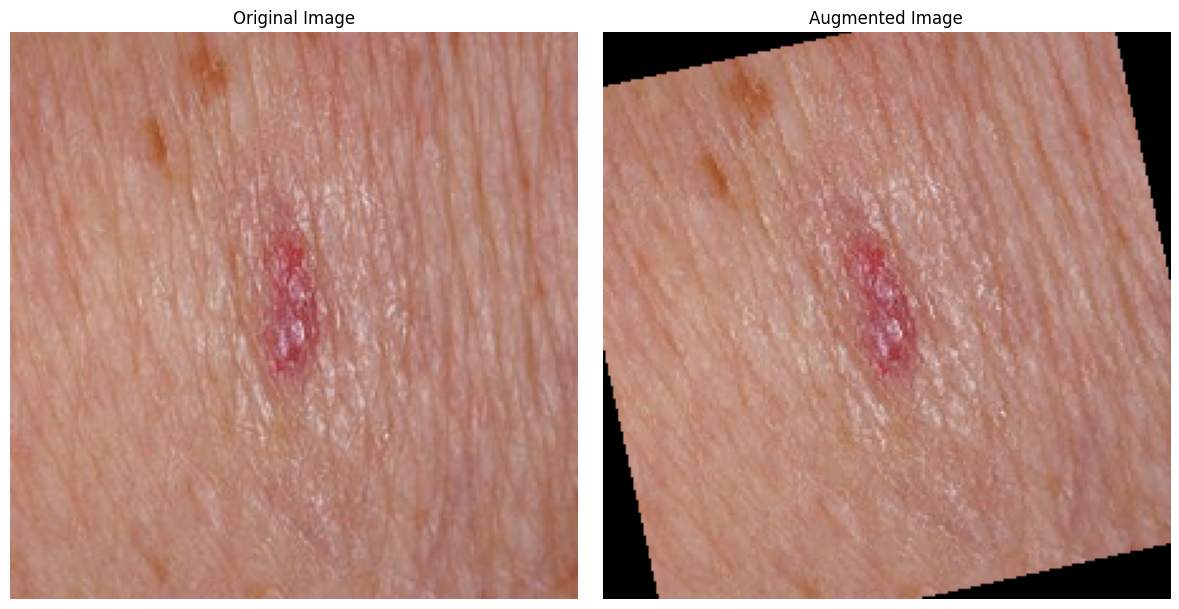

In [13]:
def show_original_and_augmented(dataset, idx, transform, fig_size=(12, 6)):
    """
    Display the original image and the augmented image side by side.
    
    Parameters:
    - dataset: The dataset containing images and labels.
    - idx: Index of the image to display.
    - transform: The transformation pipeline to apply to the image.
    - fig_size: Tuple for figure size.
    """
    # Load the original image and label
    img_path = dataset.df.iloc[idx]['image_path']
    original_image = Image.open(img_path).convert('RGB')  # Ensure it's RGB
    
    # Apply the transform to create the augmented image
    augmented_image = transform(original_image)
    
    # Convert both images to numpy arrays for visualization
    original_image_np = np.array(original_image)
    augmented_image_np = augmented_image.permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    augmented_image_np = np.clip(augmented_image_np * np.array([0.229, 0.224, 0.225]) + 
                                 np.array([0.485, 0.456, 0.406]), 0, 1)  # Denormalize
    
    # Plot side by side
    plt.figure(figsize=fig_size)
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np)
    plt.title("Original Image")
    plt.axis('off')
    
    # Augmented image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image_np)
    plt.title("Augmented Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Example usage
random_idx = random.randint(0, len(train_dataset) - 1)  # Get a random index
show_original_and_augmented(train_dataset, random_idx, transform=train_transforms)

In [14]:
#all CNN results
all_result = {}

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=CFG.EPOCHS):
    best_accuracy = 0.0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Print shape information for debugging
            #print(f"Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate and print training metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate and print validation metrics
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")
        
        # Print confusion matrix for validation set
        if epoch % 5 == 0:  # Print every 5 epochs
            cm = confusion_matrix(val_labels, val_preds)
            # print("\nValidation Confusion Matrix:")
            # print(cm)

        # Save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Basic common blocks in Pytorch for Deep Learning Modules

In [16]:
def round_channels(channels,
                   divisor=8):
    """
    Round weighted channel number (make divisible operation).

    Parameters:
    ----------
    channels : int or float
        Original number of channels.
    divisor : int, default 8
        Alignment value.

    Returns
    -------
    int
        Weighted number of channels.
    """
    rounded_channels = max(int(channels + divisor / 2.0) // divisor * divisor, divisor)
    if float(rounded_channels) < 0.9 * channels:
        rounded_channels += divisor
    return rounded_channels


class Swish(nn.Module):
    """
    Swish activation function from 'Searching for Activation Functions,' https://arxiv.org/abs/1710.05941.
    """
    def forward(self, x):
        return x * torch.sigmoid(x)


class HSigmoid(nn.Module):
    """
    Approximated sigmoid function, so-called hard-version of sigmoid from 'Searching for MobileNetV3,'
    https://arxiv.org/abs/1905.02244.
    """
    def forward(self, x):
        return F.relu6(x + 3.0, inplace=True) / 6.0


class HSwish(nn.Module):
    """
    H-Swish activation function from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    inplace : bool
        Whether to use inplace version of the module.
    """
    def __init__(self, inplace=False):
        super(HSwish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return x * F.relu6(x + 3.0, inplace=self.inplace) / 6.0


def get_activation_layer(activation):
    """
    Create activation layer from string/function.

    Parameters:
    ----------
    activation : function, or str, or nn.Module
        Activation function or name of activation function.

    Returns
    -------
    nn.Module
        Activation layer.
    """
    assert (activation is not None)
    if isfunction(activation):
        return activation()
    elif isinstance(activation, str):
        if activation == "relu":
            return nn.ReLU(inplace=True)
        elif activation == "relu6":
            return nn.ReLU6(inplace=True)
        elif activation == "swish":
            return Swish()
        elif activation == "hswish":
            return HSwish(inplace=True)
        elif activation == "sigmoid":
            return nn.Sigmoid()
        elif activation == "hsigmoid":
            return HSigmoid()
        else:
            raise NotImplementedError()
    else:
        assert (isinstance(activation, nn.Module))
        return activation


def conv1x1(in_channels,
            out_channels,
            stride=1,
            groups=1,
            bias=False):
    """
    Convolution 1x1 layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    """
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        groups=groups,
        bias=bias)


def conv3x3(in_channels,
            out_channels,
            stride=1,
            padding=1,
            dilation=1,
            groups=1,
            bias=False):
    """
    Convolution 3x3 layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    """
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
        bias=bias)


def depthwise_conv3x3(channels,
                      stride):
    """
    Depthwise convolution 3x3 layer.

    Parameters:
    ----------
    channels : int
        Number of input/output channels.
    strides : int or tuple/list of 2 int
        Strides of the convolution.
    """
    return nn.Conv2d(
        in_channels=channels,
        out_channels=channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        groups=channels,
        bias=False)


class ConvBlock(nn.Module):
    """
    Standard convolution block with Batch normalization and activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 groups=1,
                 bias=False,
                 use_bn=True,
                 bn_eps=1e-5,
                 activation=(lambda: nn.ReLU(inplace=True))):
        super(ConvBlock, self).__init__()
        self.activate = (activation is not None)
        self.use_bn = use_bn

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias)
        if self.use_bn:
            self.bn = nn.BatchNorm2d(
                num_features=out_channels,
                eps=bn_eps)
        if self.activate:
            self.activ = get_activation_layer(activation)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x


def conv1x1_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=0,
                  groups=1,
                  bias=False,
                  use_bn=True,
                  bn_eps=1e-5,
                  activation=(lambda: nn.ReLU(inplace=True))):
    """
    1x1 version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 0
        Padding value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=padding,
        groups=groups,
        bias=bias,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)


def conv3x3_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=1,
                  dilation=1,
                  groups=1,
                  bias=False,
                  use_bn=True,
                  bn_eps=1e-5,
                  activation=(lambda: nn.ReLU(inplace=True))):
    """
    3x3 version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
        bias=bias,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)


def conv5x5_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=2,
                  dilation=1,
                  groups=1,
                  bias=False,
                  bn_eps=1e-5,
                  activation=(lambda: nn.ReLU(inplace=True))):
    """
    5x5 version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 2
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=5,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
        bias=bias,
        bn_eps=bn_eps,
        activation=activation)


def conv7x7_block(in_channels,
                  out_channels,
                  stride=1,
                  padding=3,
                  bias=False,
                  use_bn=True,
                  activation=(lambda: nn.ReLU(inplace=True))):
    """
    7x7 version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 3
        Padding value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=7,
        stride=stride,
        padding=padding,
        bias=bias,
        use_bn=use_bn,
        activation=activation)


def dwconv_block(in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=1,
                 dilation=1,
                 bias=False,
                 use_bn=True,
                 bn_eps=1e-5,
                 activation=(lambda: nn.ReLU(inplace=True))):
    """
    Depthwise version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return ConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=out_channels,
        bias=bias,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)


def dwconv3x3_block(in_channels,
                    out_channels,
                    stride=1,
                    padding=1,
                    dilation=1,
                    bias=False,
                    bn_eps=1e-5,
                    activation=(lambda: nn.ReLU(inplace=True))):
    """
    3x3 depthwise version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return dwconv_block(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        bias=bias,
        bn_eps=bn_eps,
        activation=activation)


def dwconv5x5_block(in_channels,
                    out_channels,
                    stride=1,
                    padding=2,
                    dilation=1,
                    bias=False,
                    bn_eps=1e-5,
                    activation=(lambda: nn.ReLU(inplace=True))):
    """
    5x5 depthwise version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 2
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return dwconv_block(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=5,
        stride=stride,
        padding=padding,
        dilation=dilation,
        bias=bias,
        bn_eps=bn_eps,
        activation=activation)


class DwsConvBlock(nn.Module):
    """
    Depthwise separable convolution block with BatchNorms and activations at each convolution layers.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    dw_activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function after the depthwise convolution block.
    pw_activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function after the pointwise convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 bias=False,
                 use_bn=True,
                 bn_eps=1e-5,
                 dw_activation=(lambda: nn.ReLU(inplace=True)),
                 pw_activation=(lambda: nn.ReLU(inplace=True))):
        super(DwsConvBlock, self).__init__()
        self.dw_conv = dwconv_block(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias,
            use_bn=use_bn,
            bn_eps=bn_eps,
            activation=dw_activation)
        self.pw_conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            bias=bias,
            use_bn=use_bn,
            bn_eps=bn_eps,
            activation=pw_activation)

    def forward(self, x):
        x = self.dw_conv(x)
        x = self.pw_conv(x)
        return x


def dwsconv3x3_block(in_channels,
                     out_channels,
                     stride=1,
                     padding=1,
                     dilation=1,
                     bias=False,
                     bn_eps=1e-5,
                     dw_activation=(lambda: nn.ReLU(inplace=True)),
                     pw_activation=(lambda: nn.ReLU(inplace=True))):
    """
    3x3 depthwise separable version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    dw_activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function after the depthwise convolution block.
    pw_activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function after the pointwise convolution block.
    """
    return DwsConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        bias=bias,
        bn_eps=bn_eps,
        dw_activation=dw_activation,
        pw_activation=pw_activation)


class PreConvBlock(nn.Module):
    """
    Convolution block with Batch normalization and ReLU pre-activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    return_preact : bool, default False
        Whether return pre-activation. It's used by PreResNet.
    activate : bool, default True
        Whether activate the convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 bias=False,
                 return_preact=False,
                 activate=True):
        super(PreConvBlock, self).__init__()
        self.return_preact = return_preact
        self.activate = activate

        self.bn = nn.BatchNorm2d(num_features=in_channels)
        if self.activate:
            self.activ = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias)

    def forward(self, x):
        x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        if self.return_preact:
            x_pre_activ = x
        x = self.conv(x)
        if self.return_preact:
            return x, x_pre_activ
        else:
            return x


def pre_conv1x1_block(in_channels,
                      out_channels,
                      stride=1,
                      bias=False,
                      return_preact=False,
                      activate=True):
    """
    1x1 version of the pre-activated convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    bias : bool, default False
        Whether the layer uses a bias vector.
    return_preact : bool, default False
        Whether return pre-activation.
    activate : bool, default True
        Whether activate the convolution block.
    """
    return PreConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=0,
        bias=bias,
        return_preact=return_preact,
        activate=activate)


def pre_conv3x3_block(in_channels,
                      out_channels,
                      stride=1,
                      padding=1,
                      dilation=1,
                      return_preact=False,
                      activate=True):
    """
    3x3 version of the pre-activated convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    return_preact : bool, default False
        Whether return pre-activation.
    activate : bool, default True
        Whether activate the convolution block.
    """
    return PreConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        return_preact=return_preact,
        activate=activate)


def channel_shuffle(x,
                    groups):
    """
    Channel shuffle operation from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    x : Tensor
        Input tensor.
    groups : int
        Number of groups.

    Returns
    -------
    Tensor
        Resulted tensor.
    """
    batch, channels, height, width = x.size()
    # assert (channels % groups == 0)
    channels_per_group = channels // groups
    x = x.view(batch, groups, channels_per_group, height, width)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batch, channels, height, width)
    return x


class ChannelShuffle(nn.Module):
    """
    Channel shuffle layer. This is a wrapper over the same operation. It is designed to save the number of groups.

    Parameters:
    ----------
    channels : int
        Number of channels.
    groups : int
        Number of groups.
    """
    def __init__(self,
                 channels,
                 groups):
        super(ChannelShuffle, self).__init__()
        # assert (channels % groups == 0)
        if channels % groups != 0:
            raise ValueError('channels must be divisible by groups')
        self.groups = groups

    def forward(self, x):
        return channel_shuffle(x, self.groups)


def channel_shuffle2(x,
                     groups):
    """
    Channel shuffle operation from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083. The alternative version.

    Parameters:
    ----------
    x : Tensor
        Input tensor.
    groups : int
        Number of groups.

    Returns
    -------
    Tensor
        Resulted tensor.
    """
    batch, channels, height, width = x.size()
    # assert (channels % groups == 0)
    channels_per_group = channels // groups
    x = x.view(batch, channels_per_group, groups, height, width)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batch, channels, height, width)
    return x


class ChannelShuffle2(nn.Module):
    """
    Channel shuffle layer. This is a wrapper over the same operation. It is designed to save the number of groups.
    The alternative version.

    Parameters:
    ----------
    channels : int
        Number of channels.
    groups : int
        Number of groups.
    """
    def __init__(self,
                 channels,
                 groups):
        super(ChannelShuffle2, self).__init__()
        # assert (channels % groups == 0)
        if channels % groups != 0:
            raise ValueError('channels must be divisible by groups')
        self.groups = groups

    def forward(self, x):
        return channel_shuffle2(x, self.groups)


class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    channels : int
        Number of channels.
    reduction : int, default 16
        Squeeze reduction value.
    round_mid : bool, default False
        Whether to round middle channel number (make divisible by 8).
    activation : function, or str, or nn.Module, default 'relu'
        Activation function after the first convolution.
    out_activation : function, or str, or nn.Module, default 'sigmoid'
        Activation function after the last convolution.
    """
    def __init__(self,
                 channels,
                 reduction=16,
                 round_mid=False,
                 mid_activation=(lambda: nn.ReLU(inplace=True)),
                 out_activation=(lambda: nn.Sigmoid())):
        super(SEBlock, self).__init__()
        mid_channels = channels // reduction if not round_mid else round_channels(float(channels) / reduction)

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(
            in_channels=channels,
            out_channels=mid_channels,
            bias=True)
        self.activ = get_activation_layer(mid_activation)
        self.conv2 = conv1x1(
            in_channels=mid_channels,
            out_channels=channels,
            bias=True)
        self.sigmoid = get_activation_layer(out_activation)

    def forward(self, x):
        w = self.pool(x)
        w = self.conv1(w)
        w = self.activ(w)
        w = self.conv2(w)
        w = self.sigmoid(w)
        x = x * w
        return x


class IBN(nn.Module):
    """
    Instance-Batch Normalization block from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    channels : int
        Number of channels.
    inst_fraction : float, default 0.5
        The first fraction of channels for normalization.
    inst_first : bool, default True
        Whether instance normalization be on the first part of channels.
    """
    def __init__(self,
                 channels,
                 first_fraction=0.5,
                 inst_first=True):
        super(IBN, self).__init__()
        self.inst_first = inst_first
        h1_channels = int(math.floor(channels * first_fraction))
        h2_channels = channels - h1_channels
        self.split_sections = [h1_channels, h2_channels]

        if self.inst_first:
            self.inst_norm = nn.InstanceNorm2d(
                num_features=h1_channels,
                affine=True)
            self.batch_norm = nn.BatchNorm2d(num_features=h2_channels)
        else:
            self.batch_norm = nn.BatchNorm2d(num_features=h1_channels)
            self.inst_norm = nn.InstanceNorm2d(
                num_features=h2_channels,
                affine=True)

    def forward(self, x):
        x1, x2 = torch.split(x, split_size_or_sections=self.split_sections, dim=1)
        if self.inst_first:
            x1 = self.inst_norm(x1.contiguous())
            x2 = self.batch_norm(x2.contiguous())
        else:
            x1 = self.batch_norm(x1.contiguous())
            x2 = self.inst_norm(x2.contiguous())
        x = torch.cat((x1, x2), dim=1)
        return x


class Identity(nn.Module):
    """
    Identity block.
    """
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class DualPathSequential(nn.Sequential):
    """
    A sequential container for modules with dual inputs/outputs.
    Modules will be executed in the order they are added.

    Parameters:
    ----------
    return_two : bool, default True
        Whether to return two output after execution.
    first_ordinals : int, default 0
        Number of the first modules with single input/output.
    last_ordinals : int, default 0
        Number of the final modules with single input/output.
    dual_path_scheme : function
        Scheme of dual path response for a module.
    dual_path_scheme_ordinal : function
        Scheme of dual path response for an ordinal module.
    """
    def __init__(self,
                 return_two=True,
                 first_ordinals=0,
                 last_ordinals=0,
                 dual_path_scheme=(lambda module, x1, x2: module(x1, x2)),
                 dual_path_scheme_ordinal=(lambda module, x1, x2: (module(x1), x2))):
        super(DualPathSequential, self).__init__()
        self.return_two = return_two
        self.first_ordinals = first_ordinals
        self.last_ordinals = last_ordinals
        self.dual_path_scheme = dual_path_scheme
        self.dual_path_scheme_ordinal = dual_path_scheme_ordinal

    def forward(self, x1, x2=None):
        length = len(self._modules.values())
        for i, module in enumerate(self._modules.values()):
            if (i < self.first_ordinals) or (i >= length - self.last_ordinals):
                x1, x2 = self.dual_path_scheme_ordinal(module, x1, x2)
            else:
                x1, x2 = self.dual_path_scheme(module, x1, x2)
        if self.return_two:
            return x1, x2
        else:
            return x1


class Concurrent(nn.Sequential):
    """
    A container for concatenation of modules on the base of the sequential container.

    Parameters:
    ----------
    axis : int, default 1
        The axis on which to concatenate the outputs.
    stack : bool, default False
        Whether to concatenate tensors along a new dimension.
    """
    def __init__(self,
                 axis=1,
                 stack=False):
        super(Concurrent, self).__init__()
        self.axis = axis
        self.stack = stack

    def forward(self, x):
        out = []
        for module in self._modules.values():
            out.append(module(x))
        if self.stack:
            out = torch.stack(tuple(out), dim=self.axis)
        else:
            out = torch.cat(tuple(out), dim=self.axis)
        return out


class ParametricSequential(nn.Sequential):
    """
    A sequential container for modules with parameters.
    Modules will be executed in the order they are added.
    """
    def __init__(self, *args):
        super(ParametricSequential, self).__init__(*args)

    def forward(self, x, **kwargs):
        for module in self._modules.values():
            x = module(x, **kwargs)
        return x


class ParametricConcurrent(nn.Sequential):
    """
    A container for concatenation of modules with parameters.

    Parameters:
    ----------
    axis : int, default 1
        The axis on which to concatenate the outputs.
    """
    def __init__(self, axis=1):
        super(ParametricConcurrent, self).__init__()
        self.axis = axis

    def forward(self, x, **kwargs):
        out = []
        for module in self._modules.values():
            out.append(module(x, **kwargs))
        out = torch.cat(tuple(out), dim=self.axis)
        return out


class Hourglass(nn.Module):
    """
    A hourglass block.

    Parameters:
    ----------
    down_seq : nn.Sequential
        Down modules as sequential.
    up_seq : nn.Sequential
        Up modules as sequential.
    skip_seq : nn.Sequential
        Skip connection modules as sequential.
    merge_type : str, default 'add'
        Type of concatenation of up and skip outputs.
    return_first_skip : bool, default False
        Whether return the first skip connection output. Used in ResAttNet.
    """
    def __init__(self,
                 down_seq,
                 up_seq,
                 skip_seq,
                 merge_type="add",
                 return_first_skip=False):
        super(Hourglass, self).__init__()
        assert (len(up_seq) == len(down_seq))
        assert (len(skip_seq) == len(down_seq))
        assert (merge_type in ["add"])
        self.merge_type = merge_type
        self.return_first_skip = return_first_skip
        self.depth = len(down_seq)

        self.down_seq = down_seq
        self.up_seq = up_seq
        self.skip_seq = skip_seq

    def forward(self, x, **kwargs):
        y = None
        down_outs = [x]
        for down_module in self.down_seq._modules.values():
            x = down_module(x)
            down_outs.append(x)
        for i in range(len(down_outs)):
            if i != 0:
                y = down_outs[self.depth - i]
                skip_module = self.skip_seq[self.depth - i]
                y = skip_module(y)
                if (y is not None) and (self.merge_type == "add"):
                    x = x + y
            if i != len(down_outs) - 1:
                up_module = self.up_seq[self.depth - 1 - i]
                x = up_module(x)
        if self.return_first_skip:
            return x, y
        else:
            return x


class SesquialteralHourglass(nn.Module):
    """
    A sesquialteral hourglass block.

    Parameters:
    ----------
    down1_seq : nn.Sequential
        The first down modules as sequential.
    skip1_seq : nn.Sequential
        The first skip connection modules as sequential.
    up_seq : nn.Sequential
        Up modules as sequential.
    skip2_seq : nn.Sequential
        The second skip connection modules as sequential.
    down2_seq : nn.Sequential
        The second down modules as sequential.
    merge_type : str, default 'con'
        Type of concatenation of up and skip outputs.
    """
    def __init__(self,
                 down1_seq,
                 skip1_seq,
                 up_seq,
                 skip2_seq,
                 down2_seq,
                 merge_type="cat"):
        super(SesquialteralHourglass, self).__init__()
        assert (len(down1_seq) == len(up_seq))
        assert (len(down1_seq) == len(down2_seq))
        assert (len(skip1_seq) == len(skip2_seq))
        assert (len(down1_seq) == len(skip1_seq) - 1)
        assert (merge_type in ["cat", "add"])
        self.merge_type = merge_type
        self.depth = len(down1_seq)

        self.down1_seq = down1_seq
        self.skip1_seq = skip1_seq
        self.up_seq = up_seq
        self.skip2_seq = skip2_seq
        self.down2_seq = down2_seq

    def _merge(self, x, y):
        if y is not None:
            if self.merge_type == "cat":
                x = torch.cat((x, y), dim=1)
            elif self.merge_type == "add":
                x = x + y
        return x

    def forward(self, x, **kwargs):
        y = self.skip1_seq[0](x)
        skip1_outs = [y]
        for i in range(self.depth):
            x = self.down1_seq[i](x)
            y = self.skip1_seq[i + 1](x)
            skip1_outs.append(y)
        x = skip1_outs[self.depth]
        y = self.skip2_seq[0](x)
        skip2_outs = [y]
        for i in range(self.depth):
            x = self.up_seq[i](x)
            y = skip1_outs[self.depth - 1 - i]
            x = self._merge(x, y)
            y = self.skip2_seq[i + 1](x)
            skip2_outs.append(y)
        x = self.skip2_seq[self.depth](x)
        for i in range(self.depth):
            x = self.down2_seq[i](x)
            y = skip2_outs[self.depth - 1 - i]
            x = self._merge(x, y)
        return x


class MultiOutputSequential(nn.Sequential):
    """
    A sequential container with multiple outputs.
    Modules will be executed in the order they are added.
    """
    def __init__(self):
        super(MultiOutputSequential, self).__init__()

    def forward(self, x):
        outs = []
        for module in self._modules.values():
            x = module(x)
            if hasattr(module, "do_output") and module.do_output:
                outs.append(x)
        return [x] + outs


class Flatten(nn.Module):
    """
    Simple flatten module.
    """

    def forward(self, x):
        return x.view(x.size(0), -1)

# SqueezeNet

# SqueezeNet

In [20]:
class FireConv(nn.Module):
    """
    SqueezeNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 padding):
        super(FireConv, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activ(x)
        return x


class FireUnit(nn.Module):
    """
    SqueezeNet unit, so-called 'Fire' unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    squeeze_channels : int
        Number of output channels for squeeze convolution blocks.
    expand1x1_channels : int
        Number of output channels for expand 1x1 convolution blocks.
    expand3x3_channels : int
        Number of output channels for expand 3x3 convolution blocks.
    residual : bool
        Whether use residual connection.
    """
    def __init__(self,
                 in_channels,
                 squeeze_channels,
                 expand1x1_channels,
                 expand3x3_channels,
                 residual):
        super(FireUnit, self).__init__()
        self.residual = residual

        self.squeeze = FireConv(
            in_channels=in_channels,
            out_channels=squeeze_channels,
            kernel_size=1,
            padding=0)
        self.expand1x1 = FireConv(
            in_channels=squeeze_channels,
            out_channels=expand1x1_channels,
            kernel_size=1,
            padding=0)
        self.expand3x3 = FireConv(
            in_channels=squeeze_channels,
            out_channels=expand3x3_channels,
            kernel_size=3,
            padding=1)

    def forward(self, x):
        if self.residual:
            identity = x
        x = self.squeeze(x)
        y1 = self.expand1x1(x)
        y2 = self.expand3x3(x)
        out = torch.cat((y1, y2), dim=1)
        if self.residual:
            out = out + identity
        return out


class SqueezeInitBlock(nn.Module):
    """
    SqueezeNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size):
        super(SqueezeInitBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=2)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activ(x)
        return x


class SqueezeNet(nn.Module):
    """
    SqueezeNet model from 'SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model size,'
    https://arxiv.org/abs/1602.07360.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    residuals : bool
        Whether to use residual units.
    init_block_kernel_size : int or tuple/list of 2 int
        The dimensions of the convolution window for the initial unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 residuals,
                 init_block_kernel_size,
                 init_block_channels,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(SqueezeNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", SqueezeInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels,
            kernel_size=init_block_kernel_size))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            stage.add_module("pool{}".format(i + 1), nn.MaxPool2d(
                kernel_size=3,
                stride=2,
                ceil_mode=True))
            for j, out_channels in enumerate(channels_per_stage):
                expand_channels = out_channels // 2
                squeeze_channels = out_channels // 8
                stage.add_module("unit{}".format(j + 1), FireUnit(
                    in_channels=in_channels,
                    squeeze_channels=squeeze_channels,
                    expand1x1_channels=expand_channels,
                    expand3x3_channels=expand_channels,
                    residual=((residuals is not None) and (residuals[i][j] == 1))))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("dropout", nn.Dropout(p=0.5))

        self.output = nn.Sequential()
        self.output.add_module("final_conv", nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_classes,
            kernel_size=1))
        self.output.add_module("final_activ", nn.ReLU(inplace=True))
        self.output.add_module("final_pool", nn.AvgPool2d(
            kernel_size=13,
            stride=1))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                if 'final_conv' in name:
                    init.normal_(module.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.output(x)
        x = x.view(x.size(0), -1)
        return x


def get_squeezenet(version,
                   residual=False,
                   model_name=None,
                   pretrained=False,
                   root=os.path.join("~", ".torch", "models"),
                   **kwargs):
    """
    Create SqueezeNet model with specific parameters.

    Parameters:
    ----------
    version : str
        Version of SqueezeNet ('1.0' or '1.1').
    residual : bool, default False
        Whether to use residual connections.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if version == '1.0':
        channels = [[128, 128, 256], [256, 384, 384, 512], [512]]
        residuals = [[0, 1, 0], [1, 0, 1, 0], [1]]
        init_block_kernel_size = 7
        init_block_channels = 96
    elif version == '1.1':
        channels = [[128, 128], [256, 256], [384, 384, 512, 512]]
        residuals = [[0, 1], [0, 1], [0, 1, 0, 1]]
        init_block_kernel_size = 3
        init_block_channels = 64
    else:
        raise ValueError("Unsupported SqueezeNet version {}".format(version))

    if not residual:
        residuals = None

    net = SqueezeNet(
        channels=channels,
        residuals=residuals,
        init_block_kernel_size=init_block_kernel_size,
        init_block_channels=init_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def squeezenet_v1_0(**kwargs):
    """
    SqueezeNet 'vanilla' model from 'SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model
    size,' https://arxiv.org/abs/1602.07360.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_squeezenet(version="1.0", residual=False, model_name="squeezenet_v1_0", **kwargs)


def squeezenet_v1_1(**kwargs):
    """
    SqueezeNet v1.1 model from 'SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and <0.5MB model
    size,' https://arxiv.org/abs/1602.07360.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_squeezenet(version="1.1", residual=False, model_name="squeezenet_v1_1", **kwargs)


def squeezeresnet_v1_0(**kwargs):
    """
    SqueezeNet model with residual connections from 'SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and
    <0.5MB model size,' https://arxiv.org/abs/1602.07360.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_squeezenet(version="1.0", residual=True, model_name="squeezeresnet_v1_0", **kwargs)


def squeezeresnet_v1_1(**kwargs):
    """
    SqueezeNet v1.1 model with residual connections from 'SqueezeNet: AlexNet-level accuracy with 50x fewer parameters
    and <0.5MB model size,' https://arxiv.org/abs/1602.07360.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_squeezenet(version="1.1", residual=True, model_name="squeezeresnet_v1_1", **kwargs)

In [35]:
# Initialize model
model = squeezenet_v1_0(pretrained=False, num_classes=2)  # Set to 2 classes
model_name = "SqueezeNet"

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# The output layer in SqueezeNet is already configured for num_classes=2 from initialization
# No need to modify it manually since we passed num_classes=2 to the constructor

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6693, Train Acc: 0.5172, Train F1: 0.4672
Val Loss: 0.6989, Val Acc: 0.6086, Val F1: 0.5232
Epoch 2/30
Train Loss: 0.5065, Train Acc: 0.7532, Train F1: 0.7529
Val Loss: 0.4685, Val Acc: 0.7727, Val F1: 0.7670
Epoch 3/30
Train Loss: 0.4502, Train Acc: 0.7805, Train F1: 0.7804
Val Loss: 0.4123, Val Acc: 0.8056, Val F1: 0.8040
Epoch 4/30
Train Loss: 0.4154, Train Acc: 0.8023, Train F1: 0.8021
Val Loss: 0.4044, Val Acc: 0.8106, Val F1: 0.8098
Epoch 5/30
Train Loss: 0.4254, Train Acc: 0.7974, Train F1: 0.7977
Val Loss: 0.4510, Val Acc: 0.7929, Val F1: 0.7934
Epoch 6/30
Train Loss: 0.3958, Train Acc: 0.8041, Train F1: 0.8035
Val Loss: 0.3751, Val Acc: 0.8359, Val F1: 0.8358
Epoch 7/30
Train Loss: 0.4048, Train Acc: 0.8117, Train F1: 0.8117
Val Loss: 0.3757, Val Acc: 0.8460, Val F1: 0.8459
Epoch 8/30
Train Loss: 0.3840, Train Acc: 0.8188, Train F1: 0.8190
Val Loss: 0.4152, Val Acc: 0.8081, Val F1: 0.8051
Epoch 9/30
Train Loss: 0.3777, Train Acc: 0.8175, Train F1: 0.81

# ShuffleNet

In [36]:
class ShuffleUnit(nn.Module):
    """
    ShuffleNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    groups : int
        Number of groups in convolution layers.
    downsample : bool
        Whether do downsample.
    ignore_group : bool
        Whether ignore group value in the first convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 groups,
                 downsample,
                 ignore_group):
        super(ShuffleUnit, self).__init__()
        self.downsample = downsample
        mid_channels = out_channels // 4

        if downsample:
            out_channels -= in_channels

        self.compress_conv1 = conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels,
            groups=(1 if ignore_group else groups))
        self.compress_bn1 = nn.BatchNorm2d(num_features=mid_channels)
        self.c_shuffle = ChannelShuffle(
            channels=mid_channels,
            groups=groups)
        self.dw_conv2 = depthwise_conv3x3(
            channels=mid_channels,
            stride=(2 if self.downsample else 1))
        self.dw_bn2 = nn.BatchNorm2d(num_features=mid_channels)
        self.expand_conv3 = conv1x1(
            in_channels=mid_channels,
            out_channels=out_channels,
            groups=groups)
        self.expand_bn3 = nn.BatchNorm2d(num_features=out_channels)
        if downsample:
            self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        x = self.compress_conv1(x)
        x = self.compress_bn1(x)
        x = self.activ(x)
        x = self.c_shuffle(x)
        x = self.dw_conv2(x)
        x = self.dw_bn2(x)
        x = self.expand_conv3(x)
        x = self.expand_bn3(x)
        if self.downsample:
            identity = self.avgpool(identity)
            x = torch.cat((x, identity), dim=1)
        else:
            x = x + identity
        x = self.activ(x)
        return x


class ShuffleInitBlock(nn.Module):
    """
    ShuffleNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(ShuffleInitBlock, self).__init__()

        self.conv = conv3x3(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activ = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        x = self.pool(x)
        return x


class ShuffleNet(nn.Module):
    """
    ShuffleNet model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    groups : int
        Number of groups in convolution layers.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 groups,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(ShuffleNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ShuffleInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                downsample = (j == 0)
                ignore_group = (i == 0) and (j == 0)
                stage.add_module("unit{}".format(j + 1), ShuffleUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    groups=groups,
                    downsample=downsample,
                    ignore_group=ignore_group))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_shufflenet(groups,
                   width_scale,
                   model_name=None,
                   pretrained=False,
                   root=os.path.join("~", ".torch", "models"),
                   **kwargs):
    """
    Create ShuffleNet model with specific parameters.

    Parameters:
    ----------
    groups : int
        Number of groups in convolution layers.
    width_scale : float
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    init_block_channels = 24
    layers = [4, 8, 4]

    if groups == 1:
        channels_per_layers = [144, 288, 576]
    elif groups == 2:
        channels_per_layers = [200, 400, 800]
    elif groups == 3:
        channels_per_layers = [240, 480, 960]
    elif groups == 4:
        channels_per_layers = [272, 544, 1088]
    elif groups == 8:
        channels_per_layers = [384, 768, 1536]
    else:
        raise ValueError("The {} of groups is not supported".format(groups))

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    if width_scale != 1.0:
        channels = [[int(cij * width_scale) for cij in ci] for ci in channels]
        init_block_channels = int(init_block_channels * width_scale)

    net = ShuffleNet(
        channels=channels,
        init_block_channels=init_block_channels,
        groups=groups,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def shufflenet_g1_w1(**kwargs):
    """
    ShuffleNet 1x (g=1) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=1, width_scale=1.0, model_name="shufflenet_g1_w1", **kwargs)


def shufflenet_g2_w1(**kwargs):
    """
    ShuffleNet 1x (g=2) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=2, width_scale=1.0, model_name="shufflenet_g2_w1", **kwargs)


def shufflenet_g3_w1(**kwargs):
    """
    ShuffleNet 1x (g=3) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=3, width_scale=1.0, model_name="shufflenet_g3_w1", **kwargs)


def shufflenet_g4_w1(**kwargs):
    """
    ShuffleNet 1x (g=4) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=4, width_scale=1.0, model_name="shufflenet_g4_w1", **kwargs)


def shufflenet_g8_w1(**kwargs):
    """
    ShuffleNet 1x (g=8) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile Devices,'
    https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=8, width_scale=1.0, model_name="shufflenet_g8_w1", **kwargs)


def shufflenet_g1_w3d4(**kwargs):
    """
    ShuffleNet 0.75x (g=1) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile
    Devices,' https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=1, width_scale=0.75, model_name="shufflenet_g1_w3d4", **kwargs)


def shufflenet_g3_w3d4(**kwargs):
    """
    ShuffleNet 0.75x (g=3) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile
    Devices,' https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=3, width_scale=0.75, model_name="shufflenet_g3_w3d4", **kwargs)


def shufflenet_g1_wd2(**kwargs):
    """
    ShuffleNet 0.5x (g=1) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile
    Devices,' https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=1, width_scale=0.5, model_name="shufflenet_g1_wd2", **kwargs)


def shufflenet_g3_wd2(**kwargs):
    """
    ShuffleNet 0.5x (g=3) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile
    Devices,' https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=3, width_scale=0.5, model_name="shufflenet_g3_wd2", **kwargs)


def shufflenet_g1_wd4(**kwargs):
    """
    ShuffleNet 0.25x (g=1) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile
    Devices,' https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=1, width_scale=0.25, model_name="shufflenet_g1_wd4", **kwargs)


def shufflenet_g3_wd4(**kwargs):
    """
    ShuffleNet 0.25x (g=3) model from 'ShuffleNet: An Extremely Efficient Convolutional Neural Network for Mobile
    Devices,' https://arxiv.org/abs/1707.01083.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_shufflenet(groups=3, width_scale=0.25, model_name="shufflenet_g3_wd4", **kwargs)


In [37]:
# Initialize model
model = shufflenet_g1_w1(pretrained=False, num_classes=2) 

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "ShuffleNet"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4830, Train Acc: 0.7671, Train F1: 0.7675
Val Loss: 0.3780, Val Acc: 0.8359, Val F1: 0.8361
Epoch 2/30
Train Loss: 0.4248, Train Acc: 0.7983, Train F1: 0.7985
Val Loss: 0.4075, Val Acc: 0.8056, Val F1: 0.8042
Epoch 3/30
Train Loss: 0.4022, Train Acc: 0.8032, Train F1: 0.8035
Val Loss: 0.3688, Val Acc: 0.8384, Val F1: 0.8383
Epoch 4/30
Train Loss: 0.3881, Train Acc: 0.8117, Train F1: 0.8120
Val Loss: 0.4376, Val Acc: 0.7955, Val F1: 0.7924
Epoch 5/30
Train Loss: 0.3862, Train Acc: 0.8162, Train F1: 0.8164
Val Loss: 0.3399, Val Acc: 0.8485, Val F1: 0.8485
Epoch 6/30
Train Loss: 0.3666, Train Acc: 0.8246, Train F1: 0.8250
Val Loss: 0.3323, Val Acc: 0.8662, Val F1: 0.8663
Epoch 7/30
Train Loss: 0.3799, Train Acc: 0.8086, Train F1: 0.8088
Val Loss: 0.3521, Val Acc: 0.8409, Val F1: 0.8409
Epoch 8/30
Train Loss: 0.3592, Train Acc: 0.8242, Train F1: 0.8244
Val Loss: 0.3467, Val Acc: 0.8712, Val F1: 0.8711
Epoch 9/30
Train Loss: 0.3582, Train Acc: 0.8394, Train F1: 0.83

# MnasNet

In [40]:
class DwsExpSEResUnit(nn.Module):
    """
    Depthwise separable expanded residual unit with SE-block. Here it used as MnasNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the second convolution layer.
    use_kernel3 : bool, default True
        Whether to use 3x3 (instead of 5x5) kernel.
    exp_factor : int, default 1
        Expansion factor for each unit.
    se_factor : int, default 0
        SE reduction factor for each unit.
    use_skip : bool, default True
        Whether to use skip connection.
    activation : str, default 'relu'
        Activation function or name of activation function.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1,
                 use_kernel3=True,
                 exp_factor=1,
                 se_factor=0,
                 use_skip=True,
                 activation="relu"):
        super(DwsExpSEResUnit, self).__init__()
        assert (exp_factor >= 1)
        self.residual = (in_channels == out_channels) and (stride == 1) and use_skip
        self.use_exp_conv = exp_factor > 1
        self.use_se = se_factor > 0
        mid_channels = exp_factor * in_channels
        dwconv_block_fn = dwconv3x3_block if use_kernel3 else dwconv5x5_block

        if self.use_exp_conv:
            self.exp_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=mid_channels,
                activation=activation)
        self.dw_conv = dwconv_block_fn(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            activation=activation)
        if self.use_se:
            self.se = SEBlock(
                channels=mid_channels,
                reduction=(exp_factor * se_factor),
                round_mid=False,
                mid_activation=activation)
        self.pw_conv = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        if self.residual:
            identity = x
        if self.use_exp_conv:
            x = self.exp_conv(x)
        x = self.dw_conv(x)
        if self.use_se:
            x = self.se(x)
        x = self.pw_conv(x)
        if self.residual:
            x = x + identity
        return x


class MnasInitBlock(nn.Module):
    """
    MnasNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of middle channels.
    use_skip : bool
        Whether to use skip connection in the second block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels,
                 use_skip):
        super(MnasInitBlock, self).__init__()
        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=2)
        self.conv2 = DwsExpSEResUnit(
            in_channels=mid_channels,
            out_channels=out_channels,
            use_skip=use_skip)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class MnasFinalBlock(nn.Module):
    """
    MnasNet specific final block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of middle channels.
    use_skip : bool
        Whether to use skip connection in the second block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels,
                 use_skip):
        super(MnasFinalBlock, self).__init__()
        self.conv1 = DwsExpSEResUnit(
            in_channels=in_channels,
            out_channels=mid_channels,
            exp_factor=6,
            use_skip=use_skip)
        self.conv2 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class MnasNet(nn.Module):
    """
    MnasNet model from 'MnasNet: Platform-Aware Neural Architecture Search for Mobile,'
    https://arxiv.org/abs/1807.11626.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : list of 2 int
        Number of output channels for the initial unit.
    final_block_channels : list of 2 int
        Number of output channels for the final block of the feature extractor.
    kernels3 : list of list of int/bool
        Using 3x3 (instead of 5x5) kernel for each unit.
    exp_factors : list of list of int
        Expansion factor for each unit.
    se_factors : list of list of int
        SE reduction factor for each unit.
    init_block_use_skip : bool
        Whether to use skip connection in the initial unit.
    final_block_use_skip : bool
        Whether to use skip connection in the final block of the feature extractor.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 kernels3,
                 exp_factors,
                 se_factors,
                 init_block_use_skip,
                 final_block_use_skip,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(MnasNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", MnasInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels[1],
            mid_channels=init_block_channels[0],
            use_skip=init_block_use_skip))
        in_channels = init_block_channels[1]
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) else 1
                use_kernel3 = kernels3[i][j] == 1
                exp_factor = exp_factors[i][j]
                se_factor = se_factors[i][j]
                stage.add_module("unit{}".format(j + 1), DwsExpSEResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    use_kernel3=use_kernel3,
                    exp_factor=exp_factor,
                    se_factor=se_factor))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", MnasFinalBlock(
            in_channels=in_channels,
            out_channels=final_block_channels[1],
            mid_channels=final_block_channels[0],
            use_skip=final_block_use_skip))
        in_channels = final_block_channels[1]
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_mnasnet(version,
                width_scale,
                model_name=None,
                pretrained=False,
                root=os.path.join("~", ".torch", "models"),
                **kwargs):
    """
    Create MnasNet model with specific parameters.

    Parameters:
    ----------
    version : str
        Version of MobileNetV3 ('b1', 'a1' or 'small').
    width_scale : float
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if version == "b1":
        init_block_channels = [32, 16]
        final_block_channels = [320, 1280]
        channels = [[24, 24, 24], [40, 40, 40], [80, 80, 80, 96, 96], [192, 192, 192, 192]]
        kernels3 = [[1, 1, 1], [0, 0, 0], [0, 0, 0, 1, 1], [0, 0, 0, 0]]
        exp_factors = [[3, 3, 3], [3, 3, 3], [6, 6, 6, 6, 6], [6, 6, 6, 6]]
        se_factors = [[0, 0, 0], [0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0]]
        init_block_use_skip = False
        final_block_use_skip = False
    elif version == "a1":
        init_block_channels = [32, 16]
        final_block_channels = [320, 1280]
        channels = [[24, 24], [40, 40, 40], [80, 80, 80, 80, 112, 112], [160, 160, 160]]
        kernels3 = [[1, 1], [0, 0, 0], [1, 1, 1, 1, 1, 1], [0, 0, 0]]
        exp_factors = [[6, 6], [3, 3, 3], [6, 6, 6, 6, 6, 6], [6, 6, 6]]
        se_factors = [[0, 0], [4, 4, 4], [0, 0, 0, 0, 4, 4], [4, 4, 4]]
        init_block_use_skip = False
        final_block_use_skip = True
    elif version == "small":
        init_block_channels = [8, 8]
        final_block_channels = [144, 1280]
        channels = [[16], [16, 16], [32, 32, 32, 32, 32, 32, 32], [88, 88, 88]]
        kernels3 = [[1], [1, 1], [0, 0, 0, 0, 1, 1, 1], [0, 0, 0]]
        exp_factors = [[3], [6, 6], [6, 6, 6, 6, 6, 6, 6], [6, 6, 6]]
        se_factors = [[0], [0, 0], [4, 4, 4, 4, 4, 4, 4], [4, 4, 4]]
        init_block_use_skip = True
        final_block_use_skip = True
    else:
        raise ValueError("Unsupported MnasNet version {}".format(version))

    if width_scale != 1.0:
        channels = [[round_channels(cij * width_scale) for cij in ci] for ci in channels]
        init_block_channels = round_channels(init_block_channels * width_scale)

    net = MnasNet(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        kernels3=kernels3,
        exp_factors=exp_factors,
        se_factors=se_factors,
        init_block_use_skip=init_block_use_skip,
        final_block_use_skip=final_block_use_skip,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def mnasnet_b1(**kwargs):
    """
    MnasNet-B1 model from 'MnasNet: Platform-Aware Neural Architecture Search for Mobile,'
    https://arxiv.org/abs/1807.11626.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mnasnet(version="b1", width_scale=1.0, model_name="mnasnet_b1", **kwargs)


def mnasnet_a1(**kwargs):
    """
    MnasNet-A1 model from 'MnasNet: Platform-Aware Neural Architecture Search for Mobile,'
    https://arxiv.org/abs/1807.11626.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mnasnet(version="a1", width_scale=1.0, model_name="mnasnet_a1", **kwargs)


def mnasnet_small(**kwargs):
    """
    MnasNet-Small model from 'MnasNet: Platform-Aware Neural Architecture Search for Mobile,'
    https://arxiv.org/abs/1807.11626.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mnasnet(version="small", width_scale=1.0, model_name="mnasnet_small", **kwargs)

In [41]:
model = mnasnet_b1(pretrained=False, num_classes=2)

# No need to modify the classifier layer as MnasNet already handles this in its initialization
# The model automatically adjusts the final layer based on num_classes

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "MnasNet_b1"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6233, Train Acc: 0.6435, Train F1: 0.6407
Val Loss: 0.4489, Val Acc: 0.7803, Val F1: 0.7784
Epoch 2/30
Train Loss: 0.4730, Train Acc: 0.7715, Train F1: 0.7716
Val Loss: 0.4402, Val Acc: 0.7854, Val F1: 0.7830
Epoch 3/30
Train Loss: 0.4537, Train Acc: 0.7751, Train F1: 0.7753
Val Loss: 0.3845, Val Acc: 0.8333, Val F1: 0.8334
Epoch 4/30
Train Loss: 0.4265, Train Acc: 0.7885, Train F1: 0.7885
Val Loss: 0.4010, Val Acc: 0.8258, Val F1: 0.8260
Epoch 5/30
Train Loss: 0.4292, Train Acc: 0.7921, Train F1: 0.7923
Val Loss: 0.3815, Val Acc: 0.8283, Val F1: 0.8284
Epoch 6/30
Train Loss: 0.4356, Train Acc: 0.7916, Train F1: 0.7915
Val Loss: 0.3713, Val Acc: 0.8409, Val F1: 0.8409
Epoch 7/30
Train Loss: 0.4280, Train Acc: 0.8019, Train F1: 0.8020
Val Loss: 0.3794, Val Acc: 0.8232, Val F1: 0.8231
Epoch 8/30
Train Loss: 0.4107, Train Acc: 0.8063, Train F1: 0.8062
Val Loss: 0.3691, Val Acc: 0.8384, Val F1: 0.8386
Epoch 9/30
Train Loss: 0.4182, Train Acc: 0.7983, Train F1: 0.79

# MobileNetV2

In [38]:
class LinearBottleneck(nn.Module):
    """
    So-called 'Linear Bottleneck' layer. It is used as a MobileNetV2 unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the second convolution layer.
    expansion : bool
        Whether do expansion of channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 expansion):
        super(LinearBottleneck, self).__init__()
        self.residual = (in_channels == out_channels) and (stride == 1)
        mid_channels = in_channels * 6 if expansion else in_channels

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            activation="relu6")
        self.conv2 = dwconv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            activation="relu6")
        self.conv3 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        if self.residual:
            identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        if self.residual:
            x = x + identity
        return x


class MobileNetV2(nn.Module):
    """
    MobileNetV2 model from 'MobileNetV2: Inverted Residuals and Linear Bottlenecks,' https://arxiv.org/abs/1801.04381.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_block_channels : int
        Number of output channels for the final block of the feature extractor.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(MobileNetV2, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", conv3x3_block(
            in_channels=in_channels,
            out_channels=init_block_channels,
            stride=2,
            activation="relu6"))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                expansion = (i != 0) or (j != 0)
                stage.add_module("unit{}".format(j + 1), LinearBottleneck(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    expansion=expansion))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", conv1x1_block(
            in_channels=in_channels,
            out_channels=final_block_channels,
            activation="relu6"))
        in_channels = final_block_channels
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = conv1x1(
            in_channels=in_channels,
            out_channels=num_classes,
            bias=False)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.output(x)
        x = x.view(x.size(0), -1)
        return x


def get_mobilenetv2(width_scale,
                    model_name=None,
                    pretrained=False,
                    root=os.path.join("~", ".torch", "models"),
                    **kwargs):
    """
    Create MobileNetV2 model with specific parameters.

    Parameters:
    ----------
    width_scale : float
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    init_block_channels = 32
    final_block_channels = 1280
    layers = [1, 2, 3, 4, 3, 3, 1]
    downsample = [0, 1, 1, 1, 0, 1, 0]
    channels_per_layers = [16, 24, 32, 64, 96, 160, 320]

    from functools import reduce
    channels = reduce(
        lambda x, y: x + [[y[0]] * y[1]] if y[2] != 0 else x[:-1] + [x[-1] + [y[0]] * y[1]],
        zip(channels_per_layers, layers, downsample),
        [[]])

    if width_scale != 1.0:
        channels = [[int(cij * width_scale) for cij in ci] for ci in channels]
        init_block_channels = int(init_block_channels * width_scale)
        if width_scale > 1.0:
            final_block_channels = int(final_block_channels * width_scale)

    net = MobileNetV2(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def mobilenetv2_w1(**kwargs):
    """
    1.0 MobileNetV2-224 model from 'MobileNetV2: Inverted Residuals and Linear Bottlenecks,'
    https://arxiv.org/abs/1801.04381.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv2(width_scale=1.0, model_name="mobilenetv2_w1", **kwargs)


def mobilenetv2_w3d4(**kwargs):
    """
    0.75 MobileNetV2-224 model from 'MobileNetV2: Inverted Residuals and Linear Bottlenecks,'
    https://arxiv.org/abs/1801.04381.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv2(width_scale=0.75, model_name="mobilenetv2_w3d4", **kwargs)


def mobilenetv2_wd2(**kwargs):
    """
    0.5 MobileNetV2-224 model from 'MobileNetV2: Inverted Residuals and Linear Bottlenecks,'
    https://arxiv.org/abs/1801.04381.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv2(width_scale=0.5, model_name="mobilenetv2_wd2", **kwargs)


def mobilenetv2_wd4(**kwargs):
    """
    0.25 MobileNetV2-224 model from 'MobileNetV2: Inverted Residuals and Linear Bottlenecks,'
    https://arxiv.org/abs/1801.04381.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv2(width_scale=0.25, model_name="mobilenetv2_wd4", **kwargs)

In [42]:
model = mobilenetv2_w1(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "MobileNetV2"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6251, Train Acc: 0.6586, Train F1: 0.6581
Val Loss: 0.5300, Val Acc: 0.7247, Val F1: 0.7155
Epoch 2/30
Train Loss: 0.5364, Train Acc: 0.7153, Train F1: 0.7154
Val Loss: 0.4803, Val Acc: 0.8056, Val F1: 0.8048
Epoch 3/30
Train Loss: 0.4982, Train Acc: 0.7448, Train F1: 0.7444
Val Loss: 0.4985, Val Acc: 0.7753, Val F1: 0.7733
Epoch 4/30
Train Loss: 0.4962, Train Acc: 0.7523, Train F1: 0.7523
Val Loss: 0.4538, Val Acc: 0.8258, Val F1: 0.8261
Epoch 5/30
Train Loss: 0.4718, Train Acc: 0.7631, Train F1: 0.7629
Val Loss: 0.4378, Val Acc: 0.8056, Val F1: 0.8055
Epoch 6/30
Train Loss: 0.4713, Train Acc: 0.7631, Train F1: 0.7626
Val Loss: 0.4352, Val Acc: 0.8106, Val F1: 0.8110
Epoch 7/30
Train Loss: 0.4593, Train Acc: 0.7813, Train F1: 0.7807
Val Loss: 0.4086, Val Acc: 0.8106, Val F1: 0.8109
Epoch 8/30
Train Loss: 0.4464, Train Acc: 0.7764, Train F1: 0.7764
Val Loss: 0.4342, Val Acc: 0.8106, Val F1: 0.8109
Epoch 9/30
Train Loss: 0.4613, Train Acc: 0.7773, Train F1: 0.77

# CondenseNet

In [43]:
from torch.autograd import Variable

class CondenseSimpleConv(nn.Module):
    """
    CondenseNet specific simple convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    groups : int
        Number of groups.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 groups):
        super(CondenseSimpleConv, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.activ = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=groups,
            bias=False)

    def forward(self, x):
        x = self.bn(x)
        x = self.activ(x)
        x = self.conv(x)
        return x


def condense_simple_conv3x3(in_channels,
                            out_channels,
                            groups):
    """
    3x3 version of the CondenseNet specific simple convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    groups : int
        Number of groups.
    """
    return CondenseSimpleConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        groups=groups)


class CondenseComplexConv(nn.Module):
    """
    CondenseNet specific complex convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    groups : int
        Number of groups.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 groups):
        super(CondenseComplexConv, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.activ = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=groups,
            bias=False)
        self.c_shuffle = ChannelShuffle(
            channels=out_channels,
            groups=groups)
        self.register_buffer('index', torch.LongTensor(in_channels))
        self.index.fill_(0)

    def forward(self, x):
        x = torch.index_select(x, dim=1, index=Variable(self.index))
        x = self.bn(x)
        x = self.activ(x)
        x = self.conv(x)
        x = self.c_shuffle(x)
        return x


def condense_complex_conv1x1(in_channels,
                             out_channels,
                             groups):
    """
    1x1 version of the CondenseNet specific complex convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    groups : int
        Number of groups.
    """
    return CondenseComplexConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=1,
        padding=0,
        groups=groups)


class CondenseUnit(nn.Module):
    """
    CondenseNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    groups : int
        Number of groups.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 groups):
        super(CondenseUnit, self).__init__()
        bottleneck_size = 4
        inc_channels = out_channels - in_channels
        mid_channels = inc_channels * bottleneck_size

        self.conv1 = condense_complex_conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels,
            groups=groups)
        self.conv2 = condense_simple_conv3x3(
            in_channels=mid_channels,
            out_channels=inc_channels,
            groups=groups)

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.cat((identity, x), dim=1)
        return x


class TransitionBlock(nn.Module):
    """
    CondenseNet's auxiliary block, which can be treated as the initial part of the DenseNet unit, triggered only in the
    first unit of each stage.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self):
        super(TransitionBlock, self).__init__()
        self.pool = nn.AvgPool2d(
            kernel_size=2,
            stride=2,
            padding=0)

    def forward(self, x):
        x = self.pool(x)
        return x


class CondenseInitBlock(nn.Module):
    """
    CondenseNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(CondenseInitBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)

    def forward(self, x):
        x = self.conv(x)
        return x


class PostActivation(nn.Module):
    """
    CondenseNet final block, which performs the same function of postactivation as in PreResNet.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    """
    def __init__(self,
                 in_channels):
        super(PostActivation, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.activ(x)
        return x


class CondenseLinear(nn.Module):
    """
    CondenseNet specific linear block.

    Parameters:
    ----------
    in_features : int
        Number of input channels.
    out_features : int
        Number of output channels.
    drop_rate : float
        Fraction of input channels for drop.
    """
    def __init__(self,
                 in_features,
                 out_features,
                 drop_rate=0.5):
        super(CondenseLinear, self).__init__()
        drop_in_features = int(in_features * drop_rate)
        self.linear = nn.Linear(
            in_features=drop_in_features,
            out_features=out_features)
        self.register_buffer('index', torch.LongTensor(drop_in_features))
        self.index.fill_(0)

    def forward(self, x):
        x = torch.index_select(x, dim=1, index=Variable(self.index))
        x = self.linear(x)
        return x


class CondenseNet(nn.Module):
    """
    CondenseNet model (converted) from 'CondenseNet: An Efficient DenseNet using Learned Group Convolutions,'
    https://arxiv.org/abs/1711.09224.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    groups : int
        Number of groups in convolution layers.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 groups,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(CondenseNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", CondenseInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            if i != 0:
                stage.add_module("trans{}".format(i + 1), TransitionBlock())
            for j, out_channels in enumerate(channels_per_stage):
                stage.add_module("unit{}".format(j + 1), CondenseUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    groups=groups))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("post_activ", PostActivation(in_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = CondenseLinear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                init.constant_(module.weight, 1)
                init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_condensenet(num_layers,
                    groups=4,
                    model_name=None,
                    pretrained=False,
                    root=os.path.join("~", ".torch", "models"),
                    **kwargs):
    """
    Create CondenseNet (converted) model with specific parameters.

    Parameters:
    ----------
    num_layers : int
        Number of layers.
    groups : int
        Number of groups in convolution layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if num_layers == 74:
        init_block_channels = 16
        layers = [4, 6, 8, 10, 8]
        growth_rates = [8, 16, 32, 64, 128]
    else:
        raise ValueError("Unsupported CondenseNet version with number of layers {}".format(num_layers))

    from functools import reduce
    channels = reduce(lambda xi, yi:
                      xi + [reduce(lambda xj, yj:
                                   xj + [xj[-1] + yj],
                                   [yi[1]] * yi[0],
                                   [xi[-1][-1]])[1:]],
                      zip(layers, growth_rates),
                      [[init_block_channels]])[1:]

    net = CondenseNet(
        channels=channels,
        init_block_channels=init_block_channels,
        groups=groups,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def condensenet74_c4_g4(**kwargs):
    """
    CondenseNet-74 (C=G=4) model (converted) from 'CondenseNet: An Efficient DenseNet using Learned Group Convolutions,'
    https://arxiv.org/abs/1711.09224.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_condensenet(num_layers=74, groups=4, model_name="condensenet74_c4_g4", **kwargs)


def condensenet74_c8_g8(**kwargs):
    """
    CondenseNet-74 (C=G=8) model (converted) from 'CondenseNet: An Efficient DenseNet using Learned Group Convolutions,'
    https://arxiv.org/abs/1711.09224.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_condensenet(num_layers=74, groups=8, model_name="condensenet74_c8_g8", **kwargs)

In [44]:
model = condensenet74_c4_g4(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "CondenseNet"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6979, Train Acc: 0.4654, Train F1: 0.4162
Val Loss: 0.6959, Val Acc: 0.5455, Val F1: 0.3850
Epoch 2/30
Train Loss: 0.6942, Train Acc: 0.4855, Train F1: 0.4517
Val Loss: 0.6811, Val Acc: 0.5076, Val F1: 0.4500
Epoch 3/30
Train Loss: 0.6866, Train Acc: 0.4578, Train F1: 0.3069
Val Loss: 0.6627, Val Acc: 0.6263, Val F1: 0.6130
Epoch 4/30
Train Loss: 0.6744, Train Acc: 0.4574, Train F1: 0.2934
Val Loss: 0.6538, Val Acc: 0.6995, Val F1: 0.6969
Epoch 5/30
Train Loss: 0.6710, Train Acc: 0.4801, Train F1: 0.3447
Val Loss: 0.6478, Val Acc: 0.7323, Val F1: 0.7313
Epoch 6/30
Train Loss: 0.6621, Train Acc: 0.4989, Train F1: 0.3815
Val Loss: 0.6361, Val Acc: 0.7525, Val F1: 0.7526
Epoch 7/30
Train Loss: 0.6611, Train Acc: 0.5136, Train F1: 0.4102
Val Loss: 0.6251, Val Acc: 0.7601, Val F1: 0.7593
Epoch 8/30
Train Loss: 0.6584, Train Acc: 0.5377, Train F1: 0.4534
Val Loss: 0.6245, Val Acc: 0.7551, Val F1: 0.7552
Epoch 9/30
Train Loss: 0.6501, Train Acc: 0.5511, Train F1: 0.47

# AirNet 

In [48]:
class AirBlock(nn.Module):
    """
    AirNet attention block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    groups : int, default 1
        Number of groups.
    ratio: int, default 2
        Air compression ratio.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 groups=1,
                 ratio=2):
        super(AirBlock, self).__init__()
        assert (out_channels % ratio == 0)
        mid_channels = out_channels // ratio

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            groups=groups)
        self.conv3 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            activation=None)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.interpolate(
            input=x,
            scale_factor=2,
            mode="bilinear",
            align_corners=True)
        x = self.conv3(x)
        x = self.sigmoid(x)
        return x


class AirBottleneck(nn.Module):
    """
    AirNet bottleneck block for residual path in AirNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    ratio: int
        Air compression ratio.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 ratio):
        super(AirBottleneck, self).__init__()
        mid_channels = out_channels // 4
        self.use_air_block = (stride == 1 and mid_channels < 512)

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride)
        self.conv3 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            activation=None)
        if self.use_air_block:
            self.air = AirBlock(
                in_channels=in_channels,
                out_channels=mid_channels,
                ratio=ratio)

    def forward(self, x):
        if self.use_air_block:
            att = self.air(x)
        x = self.conv1(x)
        x = self.conv2(x)
        if self.use_air_block:
            x = x * att
        x = self.conv3(x)
        return x


class AirUnit(nn.Module):
    """
    AirNet unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    ratio: int
        Air compression ratio.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 ratio):
        super(AirUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = AirBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            ratio=ratio)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        x = self.activ(x)
        return x


class AirInitBlock(nn.Module):
    """
    AirNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(AirInitBlock, self).__init__()
        mid_channels = out_channels // 2

        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=2)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.conv3 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x


class AirNet(nn.Module):
    """
    AirNet model from 'Attention Inspiring Receptive-Fields Network for Learning Invariant Representations,'
    https://ieeexplore.ieee.org/document/8510896.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    ratio: int
        Air compression ratio.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 ratio,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(AirNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", AirInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), AirUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    ratio=ratio))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_airnet(blocks,
               base_channels,
               ratio,
               model_name=None,
               pretrained=False,
               root=os.path.join("~", ".torch", "models"),
               **kwargs):
    """
    Create AirNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    base_channels: int
        Base number of channels.
    ratio: int
        Air compression ratio.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    else:
        raise ValueError("Unsupported AirNet with number of blocks: {}".format(blocks))

    bottleneck_expansion = 4
    init_block_channels = base_channels
    channels_per_layers = [base_channels * (2 ** i) * bottleneck_expansion for i in range(len(layers))]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = AirNet(
        channels=channels,
        init_block_channels=init_block_channels,
        ratio=ratio,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def airnet50_1x64d_r2(**kwargs):
    """
    AirNet50-1x64d (r=2) model from 'Attention Inspiring Receptive-Fields Network for Learning Invariant
    Representations,' https://ieeexplore.ieee.org/document/8510896.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_airnet(blocks=50, base_channels=64, ratio=2, model_name="airnet50_1x64d_r2", **kwargs)


def airnet50_1x64d_r16(**kwargs):
    """
    AirNet50-1x64d (r=16) model from 'Attention Inspiring Receptive-Fields Network for Learning Invariant
    Representations,' https://ieeexplore.ieee.org/document/8510896.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_airnet(blocks=50, base_channels=64, ratio=16, model_name="airnet50_1x64d_r16", **kwargs)


def airnet101_1x64d_r2(**kwargs):
    """
    AirNet101-1x64d (r=2) model from 'Attention Inspiring Receptive-Fields Network for Learning Invariant
    Representations,' https://ieeexplore.ieee.org/document/8510896.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_airnet(blocks=101, base_channels=64, ratio=2, model_name="airnet101_1x64d_r2", **kwargs)


In [47]:
model = airnet50_1x64d_r2(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "airnet50_1x64d_r2"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5386, Train Acc: 0.7216, Train F1: 0.7220
Val Loss: 0.4130, Val Acc: 0.8157, Val F1: 0.8155
Epoch 2/30
Train Loss: 0.4407, Train Acc: 0.7894, Train F1: 0.7898
Val Loss: 0.4232, Val Acc: 0.8081, Val F1: 0.8085
Epoch 3/30
Train Loss: 0.4179, Train Acc: 0.8050, Train F1: 0.8054
Val Loss: 0.3744, Val Acc: 0.8283, Val F1: 0.8286
Epoch 4/30
Train Loss: 0.4189, Train Acc: 0.8054, Train F1: 0.8058
Val Loss: 0.3859, Val Acc: 0.8359, Val F1: 0.8362
Epoch 5/30
Train Loss: 0.4205, Train Acc: 0.8050, Train F1: 0.8054
Val Loss: 0.3862, Val Acc: 0.8283, Val F1: 0.8282
Epoch 6/30
Train Loss: 0.3874, Train Acc: 0.8206, Train F1: 0.8209
Val Loss: 0.4010, Val Acc: 0.8232, Val F1: 0.8236
Epoch 7/30
Train Loss: 0.3891, Train Acc: 0.8059, Train F1: 0.8061
Val Loss: 0.3715, Val Acc: 0.8460, Val F1: 0.8462
Epoch 8/30
Train Loss: 0.3865, Train Acc: 0.8282, Train F1: 0.8286
Val Loss: 0.3712, Val Acc: 0.8308, Val F1: 0.8305
Epoch 9/30
Train Loss: 0.3499, Train Acc: 0.8402, Train F1: 0.84

# AlexNet

In [51]:
class AlexConv(ConvBlock):
    """
    AlexNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    use_lrn : bool
        Whether to use LRN layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 use_lrn):
        super(AlexConv, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=True,
            use_bn=False)
        self.use_lrn = use_lrn

    def forward(self, x):
        x = super(AlexConv, self).forward(x)
        if self.use_lrn:
            x = F.local_response_norm(x, size=5, k=2.0)
        return x


class AlexDense(nn.Module):
    """
    AlexNet specific dense block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(AlexDense, self).__init__()
        self.fc = nn.Linear(
            in_features=in_channels,
            out_features=out_channels)
        self.activ = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.fc(x)
        x = self.activ(x)
        x = self.dropout(x)
        return x


class AlexOutputBlock(nn.Module):
    """
    AlexNet specific output block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    classes : int
        Number of classification classes.
    """
    def __init__(self,
                 in_channels,
                 classes):
        super(AlexOutputBlock, self).__init__()
        mid_channels = 4096

        self.fc1 = AlexDense(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.fc2 = AlexDense(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.fc3 = nn.Linear(
            in_features=mid_channels,
            out_features=classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


class AlexNet(nn.Module):
    """
    AlexNet model from 'One weird trick for parallelizing convolutional neural networks,'
    https://arxiv.org/abs/1404.5997.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    kernel_sizes : list of list of int
        Convolution window sizes for each unit.
    strides : list of list of int or tuple/list of 2 int
        Strides of the convolution for each unit.
    paddings : list of list of int or tuple/list of 2 int
        Padding value for convolution layer for each unit.
    use_lrn : bool
        Whether to use LRN layer.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 kernel_sizes,
                 strides,
                 paddings,
                 use_lrn,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(AlexNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        for i, channels_per_stage in enumerate(channels):
            use_lrn_i = use_lrn and (i in [0, 1])
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stage.add_module("unit{}".format(j + 1), AlexConv(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_sizes[i][j],
                    stride=strides[i][j],
                    padding=paddings[i][j],
                    use_lrn=use_lrn_i))
                in_channels = out_channels
            stage.add_module("pool{}".format(i + 1), nn.MaxPool2d(
                kernel_size=3,
                stride=2,
                padding=0,
                ceil_mode=True))
            self.features.add_module("stage{}".format(i + 1), stage)

        self.output = AlexOutputBlock(
            in_channels=(in_channels * 6 * 6),
            classes=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_alexnet(version="a",
                model_name=None,
                pretrained=False,
                root=os.path.join("~", ".torch", "models"),
                **kwargs):
    """
    Create AlexNet model with specific parameters.

    Parameters:
    ----------
    version : str, default 'a'
        Version of AlexNet ('a' or 'b').
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if version == "a":
        channels = [[96], [256], [384, 384, 256]]
        kernel_sizes = [[11], [5], [3, 3, 3]]
        strides = [[4], [1], [1, 1, 1]]
        paddings = [[0], [2], [1, 1, 1]]
        use_lrn = True
    elif version == "b":
        channels = [[64], [192], [384, 256, 256]]
        kernel_sizes = [[11], [5], [3, 3, 3]]
        strides = [[4], [1], [1, 1, 1]]
        paddings = [[2], [2], [1, 1, 1]]
        use_lrn = False
    else:
        raise ValueError("Unsupported AlexNet version {}".format(version))

    net = AlexNet(
        channels=channels,
        kernel_sizes=kernel_sizes,
        strides=strides,
        paddings=paddings,
        use_lrn=use_lrn,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def alexnet(**kwargs):
    """
    AlexNet model from 'One weird trick for parallelizing convolutional neural networks,'
    https://arxiv.org/abs/1404.5997.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_alexnet(model_name="alexnet", **kwargs)


def alexnetb(**kwargs):
    """
    AlexNet-b model from 'One weird trick for parallelizing convolutional neural networks,'
    https://arxiv.org/abs/1404.5997. Non-standard version.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_alexnet(version="b", model_name="alexnetb", **kwargs)

In [52]:
model = alexnet(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "alexnet"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5221, Train Acc: 0.7282, Train F1: 0.7287
Val Loss: 0.4460, Val Acc: 0.8283, Val F1: 0.8270
Epoch 2/30
Train Loss: 0.4306, Train Acc: 0.7938, Train F1: 0.7941
Val Loss: 0.4423, Val Acc: 0.8207, Val F1: 0.8189
Epoch 3/30
Train Loss: 0.3938, Train Acc: 0.8095, Train F1: 0.8097
Val Loss: 0.3810, Val Acc: 0.8485, Val F1: 0.8488
Epoch 4/30
Train Loss: 0.3999, Train Acc: 0.8099, Train F1: 0.8100
Val Loss: 0.3691, Val Acc: 0.8283, Val F1: 0.8282
Epoch 5/30
Train Loss: 0.3798, Train Acc: 0.8295, Train F1: 0.8296
Val Loss: 0.3318, Val Acc: 0.8586, Val F1: 0.8583
Epoch 6/30
Train Loss: 0.3801, Train Acc: 0.8050, Train F1: 0.8043
Val Loss: 0.3648, Val Acc: 0.8485, Val F1: 0.8488
Epoch 7/30
Train Loss: 0.3593, Train Acc: 0.8242, Train F1: 0.8243
Val Loss: 0.3544, Val Acc: 0.8611, Val F1: 0.8614
Epoch 8/30
Train Loss: 0.4048, Train Acc: 0.8157, Train F1: 0.8161
Val Loss: 0.4167, Val Acc: 0.8106, Val F1: 0.8078
Epoch 9/30
Train Loss: 0.3856, Train Acc: 0.8313, Train F1: 0.83

# BagNet

In [55]:
class BagNetBottleneck(nn.Module):
    """
    BagNet bottleneck block for residual path in BagNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size of the second convolution.
    stride : int or tuple/list of 2 int
        Strides of the second convolution.
    bottleneck_factor : int, default 4
        Bottleneck factor.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 bottleneck_factor=4):
        super(BagNetBottleneck, self).__init__()
        mid_channels = out_channels // bottleneck_factor

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = ConvBlock(
            in_channels=mid_channels,
            out_channels=mid_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0)
        self.conv3 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class BagNetUnit(nn.Module):
    """
    BagNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size of the second body convolution.
    stride : int or tuple/list of 2 int
        Strides of the second body convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride):
        super(BagNetUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = BagNetBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        if x.size(-1) != identity.size(-1):
            diff = identity.size(-1) - x.size(-1)
            identity = identity[:, :, :-diff, :-diff]
        x = x + identity
        x = self.activ(x)
        return x


class BagNetInitBlock(nn.Module):
    """
    BagNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(BagNetInitBlock, self).__init__()
        self.conv1 = conv1x1(
            in_channels=in_channels,
            out_channels=out_channels)
        self.conv2 = conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels,
            padding=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class BagNet(nn.Module):
    """
    BagNet model from 'Approximating CNNs with Bag-of-local-Features models works surprisingly well on ImageNet,'
    https://openreview.net/pdf?id=SkfMWhAqYQ.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_pool_size : int
        Size of the pooling windows for final pool.
    normal_kernel_sizes : list of int
        Count of the first units with 3x3 convolution window size for each stage.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_pool_size,
                 normal_kernel_sizes,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(BagNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", BagNetInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != len(channels) - 1) else 1
                kernel_size = 3 if j < normal_kernel_sizes[i] else 1
                stage.add_module("unit{}".format(j + 1), BagNetUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    stride=stride))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=final_pool_size,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_bagnet(field,
               model_name=None,
               pretrained=False,
               root=os.path.join("~", ".torch", "models"),
               **kwargs):
    """
    Create BagNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    layers = [3, 4, 6, 3]

    if field == 9:
        normal_kernel_sizes = [1, 1, 0, 0]
        final_pool_size = 27
    elif field == 17:
        normal_kernel_sizes = [1, 1, 1, 0]
        final_pool_size = 26
    elif field == 33:
        normal_kernel_sizes = [1, 1, 1, 1]
        final_pool_size = 24
    else:
        raise ValueError("Unsupported BagNet with field: {}".format(field))

    init_block_channels = 64
    channels_per_layers = [256, 512, 1024, 2048]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = BagNet(
        channels=channels,
        init_block_channels=init_block_channels,
        final_pool_size=final_pool_size,
        normal_kernel_sizes=normal_kernel_sizes,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def bagnet9(**kwargs):
    """
    BagNet-9 model from 'Approximating CNNs with Bag-of-local-Features models works surprisingly well on ImageNet,'
    https://openreview.net/pdf?id=SkfMWhAqYQ.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_bagnet(field=9, model_name="bagnet9", **kwargs)


def bagnet17(**kwargs):
    """
    BagNet-17 model from 'Approximating CNNs with Bag-of-local-Features models works surprisingly well on ImageNet,'
    https://openreview.net/pdf?id=SkfMWhAqYQ.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_bagnet(field=17, model_name="bagnet17", **kwargs)


def bagnet33(**kwargs):
    """
    BagNet-33 model from 'Approximating CNNs with Bag-of-local-Features models works surprisingly well on ImageNet,'
    https://openreview.net/pdf?id=SkfMWhAqYQ.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_bagnet(field=33, model_name="bagnet33", **kwargs)

In [56]:
model = bagnet9(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "bagnet9"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4831, Train Acc: 0.7488, Train F1: 0.7493
Val Loss: 0.4122, Val Acc: 0.8182, Val F1: 0.8186
Epoch 2/30
Train Loss: 0.4438, Train Acc: 0.7845, Train F1: 0.7848
Val Loss: 0.3916, Val Acc: 0.8207, Val F1: 0.8207
Epoch 3/30
Train Loss: 0.4175, Train Acc: 0.7961, Train F1: 0.7963
Val Loss: 0.3944, Val Acc: 0.8333, Val F1: 0.8335
Epoch 4/30
Train Loss: 0.4013, Train Acc: 0.8037, Train F1: 0.8040
Val Loss: 0.3720, Val Acc: 0.8207, Val F1: 0.8200
Epoch 5/30
Train Loss: 0.4083, Train Acc: 0.7983, Train F1: 0.7986
Val Loss: 0.3906, Val Acc: 0.8359, Val F1: 0.8359
Epoch 6/30
Train Loss: 0.4097, Train Acc: 0.8050, Train F1: 0.8053
Val Loss: 0.3758, Val Acc: 0.8359, Val F1: 0.8357
Epoch 7/30
Train Loss: 0.4041, Train Acc: 0.8037, Train F1: 0.8039
Val Loss: 0.3523, Val Acc: 0.8535, Val F1: 0.8537
Epoch 8/30
Train Loss: 0.3930, Train Acc: 0.8112, Train F1: 0.8115
Val Loss: 0.3655, Val Acc: 0.8460, Val F1: 0.8458
Epoch 9/30
Train Loss: 0.3958, Train Acc: 0.8032, Train F1: 0.80

# CBAMResNet

In [60]:
class MLP(nn.Module):
    """
    Multilayer perceptron block.

    Parameters:
    ----------
    channels : int
        Number of input/output channels.
    reduction_ratio : int, default 16
        Channel reduction ratio.
    """
    def __init__(self,
                 channels,
                 reduction_ratio=16):
        super(MLP, self).__init__()
        mid_channels = channels // reduction_ratio

        self.fc1 = nn.Linear(
            in_features=channels,
            out_features=mid_channels)
        self.activ = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(
            in_features=mid_channels,
            out_features=channels)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.activ(x)
        x = self.fc2(x)
        return x


class ChannelGate(nn.Module):
    """
    CBAM channel gate block.

    Parameters:
    ----------
    channels : int
        Number of input/output channels.
    reduction_ratio : int, default 16
        Channel reduction ratio.
    """
    def __init__(self,
                 channels,
                 reduction_ratio=16):
        super(ChannelGate, self).__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.max_pool = nn.AdaptiveMaxPool2d(output_size=(1, 1))
        self.mlp = MLP(
            channels=channels,
            reduction_ratio=reduction_ratio)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        att1 = self.avg_pool(x)
        att1 = self.mlp(att1)
        att2 = self.max_pool(x)
        att2 = self.mlp(att2)
        att = att1 + att2
        att = self.sigmoid(att)
        att = att.unsqueeze(2).unsqueeze(3).expand_as(x)
        x = x * att
        return x


class SpatialGate(nn.Module):
    """
    CBAM spatial gate block.
    """
    def __init__(self):
        super(SpatialGate, self).__init__()
        self.conv = conv7x7_block(
            in_channels=2,
            out_channels=1,
            activation=None)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        att1 = x.max(dim=1)[0].unsqueeze(1)
        att2 = x.mean(dim=1).unsqueeze(1)
        att = torch.cat((att1, att2), dim=1)
        att = self.conv(att)
        att = self.sigmoid(att)
        x = x * att
        return x


class CbamBlock(nn.Module):
    """
    CBAM attention block for CBAM-ResNet.

    Parameters:
    ----------
    channels : int
        Number of input/output channels.
    reduction_ratio : int, default 16
        Channel reduction ratio.
    """
    def __init__(self,
                 channels,
                 reduction_ratio=16):
        super(CbamBlock, self).__init__()
        self.ch_gate = ChannelGate(
            channels=channels,
            reduction_ratio=reduction_ratio)
        self.sp_gate = SpatialGate()

    def forward(self, x):
        x = self.ch_gate(x)
        x = self.sp_gate(x)
        return x


class CbamResUnit(nn.Module):
    """
    CBAM-ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bottleneck):
        super(CbamResUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        if bottleneck:
            self.body = ResBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                conv1_stride=False)
        else:
            self.body = ResBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.cbam = CbamBlock(channels=out_channels)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = self.cbam(x)
        x = x + identity
        x = self.activ(x)
        return x


class CbamResNet(nn.Module):
    """
    CBAM-ResNet model from 'CBAM: Convolutional Block Attention Module,' https://arxiv.org/abs/1807.06521.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(CbamResNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), CbamResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    bottleneck=bottleneck))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_resnet(blocks,
               model_name=None,
               pretrained=False,
               root=os.path.join("~", ".torch", "models"),
               **kwargs):
    """
    Create CBAM-ResNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer in units.
    use_se : bool
        Whether to use SE block.
    width_scale : float
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 18:
        layers = [2, 2, 2, 2]
    elif blocks == 34:
        layers = [3, 4, 6, 3]
    elif blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    else:
        raise ValueError("Unsupported CBAM-ResNet with number of blocks: {}".format(blocks))

    init_block_channels = 64

    if blocks < 50:
        channels_per_layers = [64, 128, 256, 512]
        bottleneck = False
    else:
        channels_per_layers = [256, 512, 1024, 2048]
        bottleneck = True

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = CbamResNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck=bottleneck,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def cbam_resnet18(**kwargs):
    """
    CBAM-ResNet-18 model from 'CBAM: Convolutional Block Attention Module,' https://arxiv.org/abs/1807.06521.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=18, model_name="cbam_resnet18", **kwargs)


def cbam_resnet34(**kwargs):
    """
    CBAM-ResNet-34 model from 'CBAM: Convolutional Block Attention Module,' https://arxiv.org/abs/1807.06521.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=34, model_name="cbam_resnet34", **kwargs)


def cbam_resnet50(**kwargs):
    """
    CBAM-ResNet-50 model from 'CBAM: Convolutional Block Attention Module,' https://arxiv.org/abs/1807.06521.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=50, model_name="cbam_resnet50", **kwargs)


def cbam_resnet101(**kwargs):
    """
    CBAM-ResNet-101 model from 'CBAM: Convolutional Block Attention Module,' https://arxiv.org/abs/1807.06521.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=101, model_name="cbam_resnet101", **kwargs)


def cbam_resnet152(**kwargs):
    """
    CBAM-ResNet-152 model from 'CBAM: Convolutional Block Attention Module,' https://arxiv.org/abs/1807.06521.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=152, model_name="cbam_resnet152", **kwargs)


In [61]:
model = cbam_resnet18(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "cbam_resnet18"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4397, Train Acc: 0.7760, Train F1: 0.7763
Val Loss: 0.3693, Val Acc: 0.8510, Val F1: 0.8513
Epoch 2/30
Train Loss: 0.3933, Train Acc: 0.8054, Train F1: 0.8057
Val Loss: 0.3562, Val Acc: 0.8384, Val F1: 0.8386
Epoch 3/30
Train Loss: 0.3781, Train Acc: 0.8175, Train F1: 0.8176
Val Loss: 0.3731, Val Acc: 0.8232, Val F1: 0.8224
Epoch 4/30
Train Loss: 0.3661, Train Acc: 0.8206, Train F1: 0.8209
Val Loss: 0.3520, Val Acc: 0.8510, Val F1: 0.8513
Epoch 5/30
Train Loss: 0.3558, Train Acc: 0.8251, Train F1: 0.8254
Val Loss: 0.3145, Val Acc: 0.8636, Val F1: 0.8639
Epoch 6/30
Train Loss: 0.3424, Train Acc: 0.8371, Train F1: 0.8372
Val Loss: 0.3495, Val Acc: 0.8561, Val F1: 0.8563
Epoch 7/30
Train Loss: 0.3208, Train Acc: 0.8461, Train F1: 0.8464
Val Loss: 0.3347, Val Acc: 0.8359, Val F1: 0.8350
Epoch 8/30
Train Loss: 0.3252, Train Acc: 0.8514, Train F1: 0.8517
Val Loss: 0.3374, Val Acc: 0.8409, Val F1: 0.8395
Epoch 9/30
Train Loss: 0.3096, Train Acc: 0.8554, Train F1: 0.85

# ChannelNet

In [62]:
def dwconv3x3(in_channels,
              out_channels,
              stride,
              bias=False):
    """
    3x3 depthwise version of the standard convolution layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bias : bool, default False
        Whether the layer uses a bias vector.
    """
    return nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        groups=out_channels,
        bias=bias)


class ChannetConv(nn.Module):
    """
    ChannelNet specific convolution block with Batch normalization and ReLU6 activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    dropout_rate : float, default 0.0
        Dropout rate.
    activate : bool, default True
        Whether activate the convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 groups=1,
                 bias=False,
                 dropout_rate=0.0,
                 activate=True):
        super(ChannetConv, self).__init__()
        self.use_dropout = (dropout_rate > 0.0)
        self.activate = activate

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias)
        if self.use_dropout:
            self.dropout = nn.Dropout(p=dropout_rate)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        if self.activate:
            self.activ = nn.ReLU6(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x


def channet_conv1x1(in_channels,
                    out_channels,
                    stride=1,
                    groups=1,
                    bias=False,
                    dropout_rate=0.0,
                    activate=True):
    """
    1x1 version of ChannelNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    dropout_rate : float, default 0.0
        Dropout rate.
    activate : bool, default True
        Whether activate the convolution block.
    """
    return ChannetConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=0,
        groups=groups,
        bias=bias,
        dropout_rate=dropout_rate,
        activate=activate)


def channet_conv3x3(in_channels,
                    out_channels,
                    stride,
                    padding=1,
                    dilation=1,
                    groups=1,
                    bias=False,
                    dropout_rate=0.0,
                    activate=True):
    """
    3x3 version of the standard convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    dropout_rate : float, default 0.0
        Dropout rate.
    activate : bool, default True
        Whether activate the convolution block.
    """
    return ChannetConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
        bias=bias,
        dropout_rate=dropout_rate,
        activate=activate)


class ChannetDwsConvBlock(nn.Module):
    """
    ChannelNet specific depthwise separable convolution block with BatchNorms and activations at last convolution
    layers.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    dropout_rate : float, default 0.0
        Dropout rate.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 groups=1,
                 dropout_rate=0.0):
        super(ChannetDwsConvBlock, self).__init__()
        self.dw_conv = dwconv3x3(
            in_channels=in_channels,
            out_channels=in_channels,
            stride=stride)
        self.pw_conv = channet_conv1x1(
            in_channels=in_channels,
            out_channels=out_channels,
            groups=groups,
            dropout_rate=dropout_rate)

    def forward(self, x):
        x = self.dw_conv(x)
        x = self.pw_conv(x)
        return x


class SimpleGroupBlock(nn.Module):
    """
    ChannelNet specific block with a sequence of depthwise separable group convolution layers.

    Parameters:
    ----------
    channels : int
        Number of input/output channels.
    multi_blocks : int
        Number of DWS layers in the sequence.
    groups : int
        Number of groups.
    dropout_rate : float
        Dropout rate.
    """
    def __init__(self,
                 channels,
                 multi_blocks,
                 groups,
                 dropout_rate):
        super(SimpleGroupBlock, self).__init__()
        self.blocks = nn.Sequential()
        for i in range(multi_blocks):
            self.blocks.add_module("block{}".format(i + 1), ChannetDwsConvBlock(
                in_channels=channels,
                out_channels=channels,
                stride=1,
                groups=groups,
                dropout_rate=dropout_rate))

    def forward(self, x):
        x = self.blocks(x)
        return x


class ChannelwiseConv2d(nn.Module):
    """
    ChannelNet specific block with channel-wise convolution.

    Parameters:
    ----------
    groups : int
        Number of groups.
    dropout_rate : float
        Dropout rate.
    """
    def __init__(self,
                 groups,
                 dropout_rate):
        super(ChannelwiseConv2d, self).__init__()
        self.use_dropout = (dropout_rate > 0.0)

        self.conv = nn.Conv3d(
            in_channels=1,
            out_channels=groups,
            kernel_size=(4 * groups, 1, 1),
            stride=(groups, 1, 1),
            padding=(2 * groups - 1, 0, 0),
            bias=False)
        if self.use_dropout:
            self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        batch, channels, height, width = x.size()
        x = x.unsqueeze(dim=1)
        x = self.conv(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = x.view(batch, channels, height, width)
        return x


class ConvGroupBlock(nn.Module):
    """
    ChannelNet specific block with a combination of channel-wise convolution, depthwise separable group convolutions.

    Parameters:
    ----------
    channels : int
        Number of input/output channels.
    multi_blocks : int
        Number of DWS layers in the sequence.
    groups : int
        Number of groups.
    dropout_rate : float
        Dropout rate.
    """
    def __init__(self,
                 channels,
                 multi_blocks,
                 groups,
                 dropout_rate):
        super(ConvGroupBlock, self).__init__()
        self.conv = ChannelwiseConv2d(
            groups=groups,
            dropout_rate=dropout_rate)
        self.block = SimpleGroupBlock(
            channels=channels,
            multi_blocks=multi_blocks,
            groups=groups,
            dropout_rate=dropout_rate)

    def forward(self, x):
        x = self.conv(x)
        x = self.block(x)
        return x


class ChannetUnit(nn.Module):
    """
    ChannelNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels_list : tuple/list of 2 int
        Number of output channels for each sub-block.
    strides : int or tuple/list of 2 int
        Strides of the convolution.
    multi_blocks : int
        Number of DWS layers in the sequence.
    groups : int
        Number of groups.
    dropout_rate : float
        Dropout rate.
    block_names : tuple/list of 2 str
        Sub-block names.
    merge_type : str
        Type of sub-block output merging.
    """
    def __init__(self,
                 in_channels,
                 out_channels_list,
                 strides,
                 multi_blocks,
                 groups,
                 dropout_rate,
                 block_names,
                 merge_type):
        super(ChannetUnit, self).__init__()
        assert (len(block_names) == 2)
        assert (merge_type in ["seq", "add", "cat"])
        self.merge_type = merge_type

        self.blocks = nn.Sequential()
        for i, (out_channels, block_name) in enumerate(zip(out_channels_list, block_names)):
            stride_i = (strides if i == 0 else 1)
            if block_name == "channet_conv3x3":
                self.blocks.add_module("block{}".format(i + 1), channet_conv3x3(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride_i,
                    dropout_rate=dropout_rate,
                    activate=False))
            elif block_name == "channet_dws_conv_block":
                self.blocks.add_module("block{}".format(i + 1), ChannetDwsConvBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride_i,
                    dropout_rate=dropout_rate))
            elif block_name == "simple_group_block":
                self.blocks.add_module("block{}".format(i + 1), SimpleGroupBlock(
                    channels=in_channels,
                    multi_blocks=multi_blocks,
                    groups=groups,
                    dropout_rate=dropout_rate))
            elif block_name == "conv_group_block":
                self.blocks.add_module("block{}".format(i + 1), ConvGroupBlock(
                    channels=in_channels,
                    multi_blocks=multi_blocks,
                    groups=groups,
                    dropout_rate=dropout_rate))
            else:
                raise NotImplementedError()
            in_channels = out_channels

    def forward(self, x):
        x_outs = []
        for block in self.blocks._modules.values():
            x = block(x)
            x_outs.append(x)
        if self.merge_type == "add":
            for i in range(len(x_outs) - 1):
                x = x + x_outs[i]
        elif self.merge_type == "cat":
            x = torch.cat(tuple(x_outs), dim=1)
        return x


class ChannelNet(nn.Module):
    """
    ChannelNet model from 'ChannelNets: Compact and Efficient Convolutional Neural Networks via Channel-Wise
    Convolutions,' https://arxiv.org/abs/1809.01330.

    Parameters:
    ----------
    channels : list of list of list of int
        Number of output channels for each unit.
    block_names : list of list of list of str
        Names of blocks for each unit.
    block_names : list of list of str
        Merge types for each unit.
    dropout_rate : float, default 0.0001
        Dropout rate.
    multi_blocks : int, default 2
        Block count architectural parameter.
    groups : int, default 2
        Group count architectural parameter.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 block_names,
                 merge_types,
                 dropout_rate=0.0001,
                 multi_blocks=2,
                 groups=2,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(ChannelNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                strides = 2 if (j == 0) else 1
                stage.add_module("unit{}".format(j + 1), ChannetUnit(
                    in_channels=in_channels,
                    out_channels_list=out_channels,
                    strides=strides,
                    multi_blocks=multi_blocks,
                    groups=groups,
                    dropout_rate=dropout_rate,
                    block_names=block_names[i][j],
                    merge_type=merge_types[i][j]))
                if merge_types[i][j] == "cat":
                    in_channels = sum(out_channels)
                else:
                    in_channels = out_channels[-1]
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_channelnet(model_name=None,
                   pretrained=False,
                   root=os.path.join("~", ".torch", "models"),
                   **kwargs):
    """
    Create ChannelNet model with specific parameters.

    Parameters:
    ----------
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    channels = [[[32, 64]], [[128, 128]], [[256, 256]], [[512, 512], [512, 512]], [[1024, 1024]]]
    block_names = [[["channet_conv3x3", "channet_dws_conv_block"]],
                   [["channet_dws_conv_block", "channet_dws_conv_block"]],
                   [["channet_dws_conv_block", "channet_dws_conv_block"]],
                   [["channet_dws_conv_block", "simple_group_block"], ["conv_group_block", "conv_group_block"]],
                   [["channet_dws_conv_block", "channet_dws_conv_block"]]]
    merge_types = [["cat"], ["cat"], ["cat"], ["add", "add"], ["seq"]]

    net = ChannelNet(
        channels=channels,
        block_names=block_names,
        merge_types=merge_types,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def channelnet(**kwargs):
    """
    ChannelNet model from 'ChannelNets: Compact and Efficient Convolutional Neural Networks via Channel-Wise
    Convolutions,' https://arxiv.org/abs/1809.01330.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_channelnet(model_name="channelnet", **kwargs)

In [63]:
model = channelnet(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "channelnet"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4663, Train Acc: 0.7840, Train F1: 0.7844
Val Loss: 0.3867, Val Acc: 0.8460, Val F1: 0.8462
Epoch 2/30
Train Loss: 0.4086, Train Acc: 0.8046, Train F1: 0.8048
Val Loss: 0.3572, Val Acc: 0.8308, Val F1: 0.8307
Epoch 3/30
Train Loss: 0.3897, Train Acc: 0.8112, Train F1: 0.8114
Val Loss: 0.3597, Val Acc: 0.8308, Val F1: 0.8305
Epoch 4/30
Train Loss: 0.3738, Train Acc: 0.8130, Train F1: 0.8131
Val Loss: 0.3568, Val Acc: 0.8485, Val F1: 0.8485
Epoch 5/30
Train Loss: 0.3647, Train Acc: 0.8139, Train F1: 0.8142
Val Loss: 0.3906, Val Acc: 0.8106, Val F1: 0.8083
Epoch 6/30
Train Loss: 0.3583, Train Acc: 0.8273, Train F1: 0.8276
Val Loss: 0.3324, Val Acc: 0.8586, Val F1: 0.8587
Epoch 7/30
Train Loss: 0.3419, Train Acc: 0.8313, Train F1: 0.8316
Val Loss: 0.3575, Val Acc: 0.8586, Val F1: 0.8589
Epoch 8/30
Train Loss: 0.3359, Train Acc: 0.8367, Train F1: 0.8370
Val Loss: 0.3465, Val Acc: 0.8333, Val F1: 0.8331
Epoch 9/30
Train Loss: 0.3292, Train Acc: 0.8367, Train F1: 0.83

# DarkNet

In [64]:
def dark_convYxY(in_channels,
                 out_channels,
                 alpha,
                 pointwise):
    """
    DarkNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    alpha : float
        Slope coefficient for Leaky ReLU activation.
    pointwise : bool
        Whether use 1x1 (pointwise) convolution or 3x3 convolution.
    """
    if pointwise:
        return conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            activation=nn.LeakyReLU(
                negative_slope=alpha,
                inplace=True))
    else:
        return conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            activation=nn.LeakyReLU(
                negative_slope=alpha,
                inplace=True))


class DarkNet(nn.Module):
    """
    DarkNet model from 'Darknet: Open source neural networks in c,' https://github.com/pjreddie/darknet.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    odd_pointwise : bool
        Whether pointwise convolution layer is used for each odd unit.
    avg_pool_size : int
        Window size of the final average pooling.
    cls_activ : bool
        Whether classification convolution layer uses an activation.
    alpha : float, default 0.1
        Slope coefficient for Leaky ReLU activation.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 odd_pointwise,
                 avg_pool_size,
                 cls_activ,
                 alpha=0.1,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(DarkNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stage.add_module("unit{}".format(j + 1), dark_convYxY(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    alpha=alpha,
                    pointwise=(len(channels_per_stage) > 1) and not (((j + 1) % 2 == 1) ^ odd_pointwise)))
                in_channels = out_channels
            if i != len(channels) - 1:
                stage.add_module("pool{}".format(i + 1), nn.MaxPool2d(
                    kernel_size=2,
                    stride=2))
            self.features.add_module("stage{}".format(i + 1), stage)

        self.output = nn.Sequential()
        self.output.add_module("final_conv", nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_classes,
            kernel_size=1))
        if cls_activ:
            self.output.add_module("final_activ", nn.LeakyReLU(
                negative_slope=alpha,
                inplace=True))
        self.output.add_module("final_pool", nn.AvgPool2d(
            kernel_size=avg_pool_size,
            stride=1))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                if "final_conv" in name:
                    init.normal_(module.weight, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.output(x)
        x = x.view(x.size(0), -1)
        return x


def get_darknet(version,
                model_name=None,
                pretrained=False,
                root=os.path.join("~", ".torch", "models"),
                **kwargs):
    """
    Create DarkNet model with specific parameters.

    Parameters:
    ----------
    version : str
        Version of SqueezeNet ('ref', 'tiny' or '19').
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if version == 'ref':
        channels = [[16], [32], [64], [128], [256], [512], [1024]]
        odd_pointwise = False
        avg_pool_size = 3
        cls_activ = True
    elif version == 'tiny':
        channels = [[16], [32], [16, 128, 16, 128], [32, 256, 32, 256], [64, 512, 64, 512, 128]]
        odd_pointwise = True
        avg_pool_size = 14
        cls_activ = False
    elif version == '19':
        channels = [[32], [64], [128, 64, 128], [256, 128, 256], [512, 256, 512, 256, 512],
                    [1024, 512, 1024, 512, 1024]]
        odd_pointwise = False
        avg_pool_size = 7
        cls_activ = False
    else:
        raise ValueError("Unsupported DarkNet version {}".format(version))

    net = DarkNet(
        channels=channels,
        odd_pointwise=odd_pointwise,
        avg_pool_size=avg_pool_size,
        cls_activ=cls_activ,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def darknet_ref(**kwargs):
    """
    DarkNet 'Reference' model from 'Darknet: Open source neural networks in c,' https://github.com/pjreddie/darknet.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_darknet(version="ref", model_name="darknet_ref", **kwargs)


def darknet_tiny(**kwargs):
    """
    DarkNet Tiny model from 'Darknet: Open source neural networks in c,' https://github.com/pjreddie/darknet.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_darknet(version="tiny", model_name="darknet_tiny", **kwargs)


def darknet19(**kwargs):
    """
    DarkNet-19 model from 'Darknet: Open source neural networks in c,' https://github.com/pjreddie/darknet.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_darknet(version="19", model_name="darknet19", **kwargs)

In [65]:
model = darknet19(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "darknet19"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4361, Train Acc: 0.7889, Train F1: 0.7891
Val Loss: 0.4341, Val Acc: 0.8409, Val F1: 0.8412
Epoch 2/30
Train Loss: 0.3977, Train Acc: 0.8086, Train F1: 0.8087
Val Loss: 0.3601, Val Acc: 0.8434, Val F1: 0.8434
Epoch 3/30
Train Loss: 0.3623, Train Acc: 0.8220, Train F1: 0.8222
Val Loss: 0.3409, Val Acc: 0.8586, Val F1: 0.8586
Epoch 4/30
Train Loss: 0.3367, Train Acc: 0.8402, Train F1: 0.8406
Val Loss: 0.3060, Val Acc: 0.8712, Val F1: 0.8711
Epoch 5/30
Train Loss: 0.3463, Train Acc: 0.8398, Train F1: 0.8401
Val Loss: 0.3328, Val Acc: 0.8687, Val F1: 0.8690
Epoch 6/30
Train Loss: 0.3105, Train Acc: 0.8541, Train F1: 0.8544
Val Loss: 0.3223, Val Acc: 0.8788, Val F1: 0.8788
Epoch 7/30
Train Loss: 0.3283, Train Acc: 0.8541, Train F1: 0.8544
Val Loss: 0.3081, Val Acc: 0.8485, Val F1: 0.8488
Epoch 8/30
Train Loss: 0.3191, Train Acc: 0.8590, Train F1: 0.8593
Val Loss: 0.2934, Val Acc: 0.8788, Val F1: 0.8790
Epoch 9/30
Train Loss: 0.3163, Train Acc: 0.8568, Train F1: 0.85

# DIA-ResNet

In [66]:
class FirstLSTMAmp(nn.Module):
    """
    First LSTM amplifier branch.

    Parameters:
    ----------
    in_features : int
        Number of input channels.
    out_features : int
        Number of output channels.
    """
    def __init__(self,
                 in_features,
                 out_features):
        super(FirstLSTMAmp, self).__init__()
        mid_features = in_features // 4

        self.fc1 = nn.Linear(
            in_features=in_features,
            out_features=mid_features)
        self.activ = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(
            in_features=mid_features,
            out_features=out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activ(x)
        x = self.fc2(x)
        return x


class DIALSTMCell(nn.Module):
    """
    DIA-LSTM cell.

    Parameters:
    ----------
    in_x_features : int
        Number of x input channels.
    in_h_features : int
        Number of h input channels.
    num_layers : int
        Number of amplifiers.
    dropout_rate : float, default 0.1
        Parameter of Dropout layer. Faction of the input units to drop.
    """
    def __init__(self,
                 in_x_features,
                 in_h_features,
                 num_layers,
                 dropout_rate=0.1):
        super(DIALSTMCell, self).__init__()
        self.num_layers = num_layers
        out_features = 4 * in_h_features

        self.x_amps = nn.Sequential()
        self.h_amps = nn.Sequential()
        for i in range(num_layers):
            amp_class = FirstLSTMAmp if i == 0 else nn.Linear
            self.x_amps.add_module("amp{}".format(i + 1), amp_class(
                in_features=in_x_features,
                out_features=out_features))
            self.h_amps.add_module("amp{}".format(i + 1), amp_class(
                in_features=in_h_features,
                out_features=out_features))
            in_x_features = in_h_features
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x, h, c):
        hy = []
        cy = []
        for i in range(self.num_layers):
            hx_i = h[i]
            cx_i = c[i]
            gates = self.x_amps[i](x) + self.h_amps[i](hx_i)
            i_gate, f_gate, c_gate, o_gate = gates.chunk(chunks=4, dim=1)
            i_gate = torch.sigmoid(i_gate)
            f_gate = torch.sigmoid(f_gate)
            c_gate = torch.tanh(c_gate)
            o_gate = torch.sigmoid(o_gate)
            cy_i = (f_gate * cx_i) + (i_gate * c_gate)
            hy_i = o_gate * torch.sigmoid(cy_i)
            cy.append(cy_i)
            hy.append(hy_i)
            x = self.dropout(hy_i)
        return hy, cy


class DIAAttention(nn.Module):
    """
    DIA-Net attention module.

    Parameters:
    ----------
    in_x_features : int
        Number of x input channels.
    in_h_features : int
        Number of h input channels.
    num_layers : int, default 1
        Number of amplifiers.
    """
    def __init__(self,
                 in_x_features,
                 in_h_features,
                 num_layers=1):
        super(DIAAttention, self).__init__()
        self.num_layers = num_layers

        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.lstm = DIALSTMCell(
            in_x_features=in_x_features,
            in_h_features=in_h_features,
            num_layers=num_layers)

    def forward(self, x, hc=None):
        w = self.pool(x)
        w = w.view(w.size(0), -1)
        if hc is None:
            h = [torch.zeros_like(w)] * self.num_layers
            c = [torch.zeros_like(w)] * self.num_layers
        else:
            h, c = hc
        h, c = self.lstm(w, h, c)
        w = h[-1].unsqueeze(dim=-1).unsqueeze(dim=-1)
        x = x * w
        return x, (h, c)


class DIAResUnit(nn.Module):
    """
    DIA-ResNet unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for the second convolution layer in bottleneck.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for the second convolution layer in bottleneck.
    bottleneck : bool, default True
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool, default False
        Whether to use stride in the first or the second convolution layer of the block.
    attention : nn.Module, default None
        Attention module.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 padding=1,
                 dilation=1,
                 bottleneck=True,
                 conv1_stride=False,
                 attention=None):
        super(DIAResUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        if bottleneck:
            self.body = ResBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                padding=padding,
                dilation=dilation,
                conv1_stride=conv1_stride)
        else:
            self.body = ResBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)
        self.attention = attention

    def forward(self, x, hc=None):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x, hc = self.attention(x, hc)
        x = x + identity
        x = self.activ(x)
        return x, hc


class DIAResNet(nn.Module):
    """
    DIA-ResNet model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer in units.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck,
                 conv1_stride,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(DIAResNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = DualPathSequential(return_two=False)
            attention = DIAAttention(
                in_x_features=channels_per_stage[0],
                in_h_features=channels_per_stage[0])
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), DIAResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    bottleneck=bottleneck,
                    conv1_stride=conv1_stride,
                    attention=attention))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_diaresnet(blocks,
                  bottleneck=None,
                  conv1_stride=True,
                  width_scale=1.0,
                  model_name=None,
                  pretrained=False,
                  root=os.path.join("~", ".torch", "models"),
                  **kwargs):
    """
    Create DIA-ResNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    bottleneck : bool, default None
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool, default True
        Whether to use stride in the first or the second convolution layer in units.
    width_scale : float, default 1.0
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if bottleneck is None:
        bottleneck = (blocks >= 50)

    if blocks == 10:
        layers = [1, 1, 1, 1]
    elif blocks == 12:
        layers = [2, 1, 1, 1]
    elif blocks == 14 and not bottleneck:
        layers = [2, 2, 1, 1]
    elif (blocks == 14) and bottleneck:
        layers = [1, 1, 1, 1]
    elif blocks == 16:
        layers = [2, 2, 2, 1]
    elif blocks == 18:
        layers = [2, 2, 2, 2]
    elif (blocks == 26) and not bottleneck:
        layers = [3, 3, 3, 3]
    elif (blocks == 26) and bottleneck:
        layers = [2, 2, 2, 2]
    elif blocks == 34:
        layers = [3, 4, 6, 3]
    elif (blocks == 38) and bottleneck:
        layers = [3, 3, 3, 3]
    elif blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    elif blocks == 200:
        layers = [3, 24, 36, 3]
    else:
        raise ValueError("Unsupported DIA-ResNet with number of blocks: {}".format(blocks))

    if bottleneck:
        assert (sum(layers) * 3 + 2 == blocks)
    else:
        assert (sum(layers) * 2 + 2 == blocks)

    init_block_channels = 64
    channels_per_layers = [64, 128, 256, 512]

    if bottleneck:
        bottleneck_factor = 4
        channels_per_layers = [ci * bottleneck_factor for ci in channels_per_layers]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    if width_scale != 1.0:
        channels = [[int(cij * width_scale) if (i != len(channels) - 1) or (j != len(ci) - 1) else cij
                     for j, cij in enumerate(ci)] for i, ci in enumerate(channels)]
        init_block_channels = int(init_block_channels * width_scale)

    net = DIAResNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck=bottleneck,
        conv1_stride=conv1_stride,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def diaresnet10(**kwargs):
    """
    DIA-ResNet-10 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=10, model_name="diaresnet10", **kwargs)


def diaresnet12(**kwargs):
    """
    DIA-ResNet-12 model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=12, model_name="diaresnet12", **kwargs)


def diaresnet14(**kwargs):
    """
    DIA-ResNet-14 model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=14, model_name="diaresnet14", **kwargs)


def diaresnetbc14b(**kwargs):
    """
    DIA-ResNet-BC-14b model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=14, bottleneck=True, conv1_stride=False, model_name="diaresnetbc14b", **kwargs)


def diaresnet16(**kwargs):
    """
    DIA-ResNet-16 model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=16, model_name="diaresnet16", **kwargs)


def diaresnet18(**kwargs):
    """
    DIA-ResNet-18 model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=18, model_name="diaresnet18", **kwargs)


def diaresnet26(**kwargs):
    """
    DIA-ResNet-26 model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=26, bottleneck=False, model_name="diaresnet26", **kwargs)


def diaresnetbc26b(**kwargs):
    """
    DIA-ResNet-BC-26b model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=26, bottleneck=True, conv1_stride=False, model_name="diaresnetbc26b", **kwargs)


def diaresnet34(**kwargs):
    """
    DIA-ResNet-34 model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=34, model_name="diaresnet34", **kwargs)


def diaresnetbc38b(**kwargs):
    """
    DIA-ResNet-BC-38b model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=38, bottleneck=True, conv1_stride=False, model_name="diaresnetbc38b", **kwargs)


def diaresnet50(**kwargs):
    """
    DIA-ResNet-50 model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=50, model_name="diaresnet50", **kwargs)


def diaresnet50b(**kwargs):
    """
    DIA-ResNet-50 model with stride at the second convolution in bottleneck block from 'DIANet: Dense-and-Implicit
    Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=50, conv1_stride=False, model_name="diaresnet50b", **kwargs)


def diaresnet101(**kwargs):
    """
    DIA-ResNet-101 model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=101, model_name="diaresnet101", **kwargs)


def diaresnet101b(**kwargs):
    """
    DIA-ResNet-101 model with stride at the second convolution in bottleneck block from 'DIANet: Dense-and-Implicit
    Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=101, conv1_stride=False, model_name="diaresnet101b", **kwargs)


def diaresnet152(**kwargs):
    """
    DIA-ResNet-152 model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=152, model_name="diaresnet152", **kwargs)


def diaresnet152b(**kwargs):
    """
    DIA-ResNet-152 model with stride at the second convolution in bottleneck block from 'DIANet: Dense-and-Implicit
    Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=152, conv1_stride=False, model_name="diaresnet152b", **kwargs)


def diaresnet200(**kwargs):
    """
    DIA-ResNet-200 model 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=200, model_name="diaresnet200", **kwargs)


def diaresnet200b(**kwargs):
    """
    DIA-ResNet-200 model with stride at the second convolution in bottleneck block from 'DIANet: Dense-and-Implicit
    Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diaresnet(blocks=200, conv1_stride=False, model_name="diaresnet200b", **kwargs)

In [67]:
model = diaresnet10(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "diaresnet10"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4628, Train Acc: 0.7773, Train F1: 0.7777
Val Loss: 0.3600, Val Acc: 0.8384, Val F1: 0.8386
Epoch 2/30
Train Loss: 0.4196, Train Acc: 0.8010, Train F1: 0.8009
Val Loss: 0.3599, Val Acc: 0.8384, Val F1: 0.8387
Epoch 3/30
Train Loss: 0.3920, Train Acc: 0.8081, Train F1: 0.8082
Val Loss: 0.3587, Val Acc: 0.8460, Val F1: 0.8463
Epoch 4/30
Train Loss: 0.3814, Train Acc: 0.8095, Train F1: 0.8096
Val Loss: 0.3435, Val Acc: 0.8434, Val F1: 0.8438
Epoch 5/30
Train Loss: 0.3828, Train Acc: 0.8135, Train F1: 0.8137
Val Loss: 0.3512, Val Acc: 0.8384, Val F1: 0.8382
Epoch 6/30
Train Loss: 0.3686, Train Acc: 0.8318, Train F1: 0.8321
Val Loss: 0.3409, Val Acc: 0.8561, Val F1: 0.8562
Epoch 7/30
Train Loss: 0.3579, Train Acc: 0.8179, Train F1: 0.8182
Val Loss: 0.3327, Val Acc: 0.8384, Val F1: 0.8379
Epoch 8/30
Train Loss: 0.3441, Train Acc: 0.8344, Train F1: 0.8347
Val Loss: 0.3153, Val Acc: 0.8611, Val F1: 0.8614
Epoch 9/30
Train Loss: 0.3325, Train Acc: 0.8380, Train F1: 0.83

# EfficientNet

In [68]:
def calc_tf_padding(x,
                    kernel_size,
                    stride=1,
                    dilation=1):
    """
    Calculate TF-same like padding size.

    Parameters:
    ----------
    x : tensor
        Input tensor.
    kernel_size : int
        Convolution window size.
    stride : int, default 1
        Strides of the convolution.
    dilation : int, default 1
        Dilation value for convolution layer.

    Returns
    -------
    tuple of 4 int
        The size of the padding.
    """
    height, width = x.size()[2:]
    oh = math.ceil(height / stride)
    ow = math.ceil(width / stride)
    pad_h = max((oh - 1) * stride + (kernel_size - 1) * dilation + 1 - height, 0)
    pad_w = max((ow - 1) * stride + (kernel_size - 1) * dilation + 1 - width, 0)
    return pad_h // 2, pad_h - pad_h // 2, pad_w // 2, pad_w - pad_w // 2


class EffiDwsConvUnit(nn.Module):
    """
    EfficientNet specific depthwise separable convolution block/unit with BatchNorms and activations at each convolution
    layers.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the second convolution layer.
    bn_eps : float
        Small float added to variance in Batch norm.
    activation : str
        Name of activation function.
    tf_mode : bool
        Whether to use TF-like mode.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bn_eps,
                 activation,
                 tf_mode):
        super(EffiDwsConvUnit, self).__init__()
        self.tf_mode = tf_mode
        self.residual = (in_channels == out_channels) and (stride == 1)

        self.dw_conv = dwconv3x3_block(
            in_channels=in_channels,
            out_channels=in_channels,
            padding=(0 if tf_mode else 1),
            bn_eps=bn_eps,
            activation=activation)
        self.se = SEBlock(
            channels=in_channels,
            reduction=4,
            mid_activation=activation)
        self.pw_conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            bn_eps=bn_eps,
            activation=None)

    def forward(self, x):
        if self.residual:
            identity = x
        if self.tf_mode:
            x = F.pad(x, pad=calc_tf_padding(x, kernel_size=3))
        x = self.dw_conv(x)
        x = self.se(x)
        x = self.pw_conv(x)
        if self.residual:
            x = x + identity
        return x


class EffiInvResUnit(nn.Module):
    """
    EfficientNet inverted residual unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the second convolution layer.
    expansion_factor : int
        Factor for expansion of channels.
    bn_eps : float
        Small float added to variance in Batch norm.
    activation : str
        Name of activation function.
    tf_mode : bool
        Whether to use TF-like mode.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 expansion_factor,
                 bn_eps,
                 activation,
                 tf_mode):
        super(EffiInvResUnit, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.tf_mode = tf_mode
        self.residual = (in_channels == out_channels) and (stride == 1)
        mid_channels = in_channels * expansion_factor
        dwconv_block_fn = dwconv3x3_block if kernel_size == 3 else (dwconv5x5_block if kernel_size == 5 else None)

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            bn_eps=bn_eps,
            activation=activation)
        self.conv2 = dwconv_block_fn(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            padding=(0 if tf_mode else (kernel_size // 2)),
            bn_eps=bn_eps,
            activation=activation)
        self.se = SEBlock(
            channels=mid_channels,
            reduction=24,
            mid_activation=activation)
        self.conv3 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            bn_eps=bn_eps,
            activation=None)

    def forward(self, x):
        if self.residual:
            identity = x
        x = self.conv1(x)
        if self.tf_mode:
            x = F.pad(x, pad=calc_tf_padding(x, kernel_size=self.kernel_size, stride=self.stride))
        x = self.conv2(x)
        x = self.se(x)
        x = self.conv3(x)
        if self.residual:
            x = x + identity
        return x


class EffiInitBlock(nn.Module):
    """
    EfficientNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    bn_eps : float
        Small float added to variance in Batch norm.
    activation : str
        Name of activation function.
    tf_mode : bool
        Whether to use TF-like mode.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 bn_eps,
                 activation,
                 tf_mode):
        super(EffiInitBlock, self).__init__()
        self.tf_mode = tf_mode

        self.conv = conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2,
            padding=(0 if tf_mode else 1),
            bn_eps=bn_eps,
            activation=activation)

    def forward(self, x):
        if self.tf_mode:
            x = F.pad(x, pad=calc_tf_padding(x, kernel_size=3, stride=2))
        x = self.conv(x)
        return x


class EfficientNet(nn.Module):
    """
    EfficientNet(-B0) model from 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks,'
    https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for initial unit.
    final_block_channels : int
        Number of output channels for the final block of the feature extractor.
    kernel_sizes : list of list of int
        Number of kernel sizes for each unit.
    strides_per_stage : list int
        Stride value for the first unit of each stage.
    expansion_factors : list of list of int
        Number of expansion factors for each unit.
    dropout_rate : float, default 0.2
        Fraction of the input units to drop. Must be a number between 0 and 1.
    tf_mode : bool, default False
        Whether to use TF-like mode.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 kernel_sizes,
                 strides_per_stage,
                 expansion_factors,
                 dropout_rate=0.2,
                 tf_mode=False,
                 bn_eps=1e-5,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(EfficientNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes
        activation = "swish"

        self.features = nn.Sequential()
        self.features.add_module("init_block", EffiInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels,
            bn_eps=bn_eps,
            activation=activation,
            tf_mode=tf_mode))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            kernel_sizes_per_stage = kernel_sizes[i]
            expansion_factors_per_stage = expansion_factors[i]
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                kernel_size = kernel_sizes_per_stage[j]
                expansion_factor = expansion_factors_per_stage[j]
                stride = strides_per_stage[i] if (j == 0) else 1
                if i == 0:
                    stage.add_module("unit{}".format(j + 1), EffiDwsConvUnit(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        stride=stride,
                        bn_eps=bn_eps,
                        activation=activation,
                        tf_mode=tf_mode))
                else:
                    stage.add_module("unit{}".format(j + 1), EffiInvResUnit(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        expansion_factor=expansion_factor,
                        bn_eps=bn_eps,
                        activation=activation,
                        tf_mode=tf_mode))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", conv1x1_block(
            in_channels=in_channels,
            out_channels=final_block_channels,
            bn_eps=bn_eps,
            activation=activation))
        in_channels = final_block_channels
        self.features.add_module("final_pool", nn.AdaptiveAvgPool2d(output_size=1))

        self.output = nn.Sequential()
        if dropout_rate > 0.0:
            self.output.add_module("dropout", nn.Dropout(p=dropout_rate))
        self.output.add_module("fc", nn.Linear(
            in_features=in_channels,
            out_features=num_classes))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_efficientnet(version,
                     in_size,
                     tf_mode=False,
                     bn_eps=1e-5,
                     model_name=None,
                     pretrained=False,
                     root=os.path.join("~", ".torch", "models"),
                     **kwargs):
    """
    Create EfficientNet model with specific parameters.

    Parameters:
    ----------
    version : str
        Version of EfficientNet ('b0'...'b7').
    in_size : tuple of two ints
        Spatial size of the expected input image.
    tf_mode : bool, default False
        Whether to use TF-like mode.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if version == "b0":
        assert (in_size == (224, 224))
        depth_factor = 1.0
        width_factor = 1.0
        dropout_rate = 0.2
    elif version == "b1":
        assert (in_size == (240, 240))
        depth_factor = 1.1
        width_factor = 1.0
        dropout_rate = 0.2
    elif version == "b2":
        assert (in_size == (260, 260))
        depth_factor = 1.2
        width_factor = 1.1
        dropout_rate = 0.3
    elif version == "b3":
        assert (in_size == (300, 300))
        depth_factor = 1.4
        width_factor = 1.2
        dropout_rate = 0.3
    elif version == "b4":
        assert (in_size == (380, 380))
        depth_factor = 1.8
        width_factor = 1.4
        dropout_rate = 0.4
    elif version == "b5":
        assert (in_size == (456, 456))
        depth_factor = 2.2
        width_factor = 1.6
        dropout_rate = 0.4
    elif version == "b6":
        assert (in_size == (528, 528))
        depth_factor = 2.6
        width_factor = 1.8
        dropout_rate = 0.5
    elif version == "b7":
        assert (in_size == (600, 600))
        depth_factor = 3.1
        width_factor = 2.0
        dropout_rate = 0.5
    else:
        raise ValueError("Unsupported EfficientNet version {}".format(version))

    init_block_channels = 32
    layers = [1, 2, 2, 3, 3, 4, 1]
    downsample = [1, 1, 1, 1, 0, 1, 0]
    channels_per_layers = [16, 24, 40, 80, 112, 192, 320]
    expansion_factors_per_layers = [1, 6, 6, 6, 6, 6, 6]
    kernel_sizes_per_layers = [3, 3, 5, 3, 5, 5, 3]
    strides_per_stage = [1, 2, 2, 2, 1, 2, 1]
    final_block_channels = 1280

    layers = [int(math.ceil(li * depth_factor)) for li in layers]
    channels_per_layers = [round_channels(ci * width_factor) for ci in channels_per_layers]

    from functools import reduce
    channels = reduce(lambda x, y: x + [[y[0]] * y[1]] if y[2] != 0 else x[:-1] + [x[-1] + [y[0]] * y[1]],
                      zip(channels_per_layers, layers, downsample), [])
    kernel_sizes = reduce(lambda x, y: x + [[y[0]] * y[1]] if y[2] != 0 else x[:-1] + [x[-1] + [y[0]] * y[1]],
                          zip(kernel_sizes_per_layers, layers, downsample), [])
    expansion_factors = reduce(lambda x, y: x + [[y[0]] * y[1]] if y[2] != 0 else x[:-1] + [x[-1] + [y[0]] * y[1]],
                               zip(expansion_factors_per_layers, layers, downsample), [])
    strides_per_stage = reduce(lambda x, y: x + [[y[0]] * y[1]] if y[2] != 0 else x[:-1] + [x[-1] + [y[0]] * y[1]],
                               zip(strides_per_stage, layers, downsample), [])
    strides_per_stage = [si[0] for si in strides_per_stage]

    init_block_channels = round_channels(init_block_channels * width_factor)

    if width_factor > 1.0:
        assert (int(final_block_channels * width_factor) == round_channels(final_block_channels * width_factor))
        final_block_channels = round_channels(final_block_channels * width_factor)

    net = EfficientNet(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        kernel_sizes=kernel_sizes,
        strides_per_stage=strides_per_stage,
        expansion_factors=expansion_factors,
        dropout_rate=dropout_rate,
        tf_mode=tf_mode,
        bn_eps=bn_eps,
        in_size=in_size,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def efficientnet_b0(in_size=(224, 224), **kwargs):
    """
    EfficientNet-B0 model from 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks,'
    https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b0", in_size=in_size, model_name="efficientnet_b0", **kwargs)


def efficientnet_b1(in_size=(240, 240), **kwargs):
    """
    EfficientNet-B1 model from 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks,'
    https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (240, 240)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b1", in_size=in_size, model_name="efficientnet_b1", **kwargs)


def efficientnet_b2(in_size=(260, 260), **kwargs):
    """
    EfficientNet-B2 model from 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks,'
    https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (260, 260)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b2", in_size=in_size, model_name="efficientnet_b2", **kwargs)


def efficientnet_b3(in_size=(300, 300), **kwargs):
    """
    EfficientNet-B3 model from 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks,'
    https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (300, 300)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b3", in_size=in_size, model_name="efficientnet_b3", **kwargs)


def efficientnet_b4(in_size=(380, 380), **kwargs):
    """
    EfficientNet-B4 model from 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks,'
    https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (380, 380)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b4", in_size=in_size, model_name="efficientnet_b4", **kwargs)


def efficientnet_b5(in_size=(456, 456), **kwargs):
    """
    EfficientNet-B5 model from 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks,'
    https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (456, 456)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b5", in_size=in_size, model_name="efficientnet_b5", **kwargs)


def efficientnet_b6(in_size=(528, 528), **kwargs):
    """
    EfficientNet-B6 model from 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks,'
    https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (528, 528)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b6", in_size=in_size, model_name="efficientnet_b6", **kwargs)


def efficientnet_b7(in_size=(600, 600), **kwargs):
    """
    EfficientNet-B7 model from 'EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks,'
    https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (600, 600)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b7", in_size=in_size, model_name="efficientnet_b7", **kwargs)


def efficientnet_b0b(in_size=(224, 224), **kwargs):
    """
    EfficientNet-B0-b (like TF-implementation) model from 'EfficientNet: Rethinking Model Scaling for Convolutional
    Neural Networks,' https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b0", in_size=in_size, tf_mode=True, bn_eps=1e-3, model_name="efficientnet_b0b",
                            **kwargs)


def efficientnet_b1b(in_size=(240, 240), **kwargs):
    """
    EfficientNet-B1-b (like TF-implementation) model from 'EfficientNet: Rethinking Model Scaling for Convolutional
    Neural Networks,' https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (240, 240)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b1", in_size=in_size, tf_mode=True, bn_eps=1e-3, model_name="efficientnet_b1b",
                            **kwargs)


def efficientnet_b2b(in_size=(260, 260), **kwargs):
    """
    EfficientNet-B2-b (like TF-implementation) model from 'EfficientNet: Rethinking Model Scaling for Convolutional
    Neural Networks,' https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (260, 260)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b2", in_size=in_size, tf_mode=True, bn_eps=1e-3, model_name="efficientnet_b2b",
                            **kwargs)


def efficientnet_b3b(in_size=(300, 300), **kwargs):
    """
    EfficientNet-B3-b (like TF-implementation) model from 'EfficientNet: Rethinking Model Scaling for Convolutional
    Neural Networks,' https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (300, 300)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b3", in_size=in_size, tf_mode=True, bn_eps=1e-3, model_name="efficientnet_b3b",
                            **kwargs)


def efficientnet_b4b(in_size=(380, 380), **kwargs):
    """
    EfficientNet-B4-b (like TF-implementation) model from 'EfficientNet: Rethinking Model Scaling for Convolutional
    Neural Networks,' https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (380, 380)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b4", in_size=in_size, tf_mode=True, bn_eps=1e-3, model_name="efficientnet_b4b",
                            **kwargs)


def efficientnet_b5b(in_size=(456, 456), **kwargs):
    """
    EfficientNet-B5-b (like TF-implementation) model from 'EfficientNet: Rethinking Model Scaling for Convolutional
    Neural Networks,' https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (456, 456)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b5", in_size=in_size, tf_mode=True, bn_eps=1e-3, model_name="efficientnet_b5b",
                            **kwargs)


def efficientnet_b6b(in_size=(528, 528), **kwargs):
    """
    EfficientNet-B6-b (like TF-implementation) model from 'EfficientNet: Rethinking Model Scaling for Convolutional
    Neural Networks,' https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (528, 528)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b6", in_size=in_size, tf_mode=True, bn_eps=1e-3, model_name="efficientnet_b6b",
                            **kwargs)


def efficientnet_b7b(in_size=(600, 600), **kwargs):
    """
    EfficientNet-B7-b (like TF-implementation) model from 'EfficientNet: Rethinking Model Scaling for Convolutional
    Neural Networks,' https://arxiv.org/abs/1905.11946.

    Parameters:
    ----------
    in_size : tuple of two ints, default (600, 600)
        Spatial size of the expected input image.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_efficientnet(version="b7", in_size=in_size, tf_mode=True, bn_eps=1e-3, model_name="efficientnet_b7b",
                            **kwargs)


In [69]:
model = efficientnet_b0(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "efficientnet_b0"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6484, Train Acc: 0.6287, Train F1: 0.6294
Val Loss: 0.6846, Val Acc: 0.7626, Val F1: 0.7564
Epoch 2/30
Train Loss: 0.4782, Train Acc: 0.7644, Train F1: 0.7640
Val Loss: 0.3864, Val Acc: 0.8258, Val F1: 0.8260
Epoch 3/30
Train Loss: 0.4203, Train Acc: 0.7916, Train F1: 0.7918
Val Loss: 0.3710, Val Acc: 0.8359, Val F1: 0.8361
Epoch 4/30
Train Loss: 0.4211, Train Acc: 0.7965, Train F1: 0.7966
Val Loss: 0.3741, Val Acc: 0.8207, Val F1: 0.8211
Epoch 5/30
Train Loss: 0.4013, Train Acc: 0.8063, Train F1: 0.8063
Val Loss: 0.3578, Val Acc: 0.8207, Val F1: 0.8209
Epoch 6/30
Train Loss: 0.4062, Train Acc: 0.8086, Train F1: 0.8087
Val Loss: 0.3570, Val Acc: 0.8409, Val F1: 0.8408
Epoch 7/30
Train Loss: 0.4134, Train Acc: 0.7996, Train F1: 0.7999
Val Loss: 0.3904, Val Acc: 0.8157, Val F1: 0.8154
Epoch 8/30
Train Loss: 0.3971, Train Acc: 0.8121, Train F1: 0.8124
Val Loss: 0.3607, Val Acc: 0.8384, Val F1: 0.8385
Epoch 9/30
Train Loss: 0.3977, Train Acc: 0.8153, Train F1: 0.81

# ESPNet

In [70]:
class PreActivation(nn.Module):
    """
    PreResNet like pure pre-activation block without convolution layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    """
    def __init__(self,
                 in_channels):
        super(PreActivation, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.activ = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        x = self.bn(x)
        x = self.activ(x)
        return x


class ShortcutBlock(nn.Module):
    """
    ESPNetv2 shortcut block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(ShortcutBlock, self).__init__()
        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=in_channels,
            activation=(lambda: nn.PReLU(in_channels)))
        self.conv2 = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class HierarchicalConcurrent(nn.Sequential):
    """
    A container for hierarchical concatenation of modules on the base of the sequential container.

    Parameters:
    ----------
    axis : int, default 1
        The axis on which to concatenate the outputs.
    """
    def __init__(self, axis=1):
        super(HierarchicalConcurrent, self).__init__()
        self.axis = axis

    def forward(self, x):
        out = []
        y_prev = None
        for module in self._modules.values():
            y = module(x)
            if y_prev is not None:
                y += y_prev
            out.append(y)
            y_prev = y
        out = torch.cat(tuple(out), dim=self.axis)
        return out


class ESPBlock(nn.Module):
    """
    ESPNetv2 block (so-called EESP block).

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the branch convolution layers.
    dilations : list of int
        Dilation values for branches.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 dilations):
        super(ESPBlock, self).__init__()
        num_branches = len(dilations)
        assert (out_channels % num_branches == 0)
        self.downsample = (stride != 1)
        mid_channels = out_channels // num_branches

        self.reduce_conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            groups=num_branches,
            activation=(lambda: nn.PReLU(mid_channels)))

        self.branches = HierarchicalConcurrent()
        for i in range(num_branches):
            self.branches.add_module("branch{}".format(i + 1), conv3x3(
                in_channels=mid_channels,
                out_channels=mid_channels,
                stride=stride,
                padding=dilations[i],
                dilation=dilations[i],
                groups=mid_channels))

        self.merge_conv = conv1x1_block(
            in_channels=out_channels,
            out_channels=out_channels,
            groups=num_branches,
            activation=None)
        self.preactiv = PreActivation(in_channels=out_channels)
        self.activ = nn.PReLU(out_channels)

    def forward(self, x, x0):
        y = self.reduce_conv(x)
        y = self.branches(y)
        y = self.preactiv(y)
        y = self.merge_conv(y)
        if not self.downsample:
            y = y + x
            y = self.activ(y)
        return y, x0


class DownsampleBlock(nn.Module):
    """
    ESPNetv2 downsample block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    x0_channels : int
        Number of input channels for shortcut.
    dilations : list of int
        Dilation values for branches in EESP block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 x0_channels,
                 dilations):
        super(DownsampleBlock, self).__init__()
        inc_channels = out_channels - in_channels

        self.pool = nn.AvgPool2d(
            kernel_size=3,
            stride=2,
            padding=1)
        self.eesp = ESPBlock(
            in_channels=in_channels,
            out_channels=inc_channels,
            stride=2,
            dilations=dilations)
        self.shortcut_block = ShortcutBlock(
            in_channels=x0_channels,
            out_channels=out_channels)
        self.activ = nn.PReLU(out_channels)

    def forward(self, x, x0):
        y1 = self.pool(x)
        y2, _ = self.eesp(x, None)
        x = torch.cat((y1, y2), dim=1)
        x0 = self.pool(x0)
        y3 = self.shortcut_block(x0)
        x = x + y3
        x = self.activ(x)
        return x, x0


class ESPInitBlock(nn.Module):
    """
    ESPNetv2 initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(ESPInitBlock, self).__init__()
        self.conv = conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2,
            activation=(lambda: nn.PReLU(out_channels)))
        self.pool = nn.AvgPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x, x0):
        x = self.conv(x)
        x0 = self.pool(x0)
        return x, x0


class ESPFinalBlock(nn.Module):
    """
    ESPNetv2 final block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    final_groups : int
        Number of groups in the last convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 final_groups):
        super(ESPFinalBlock, self).__init__()
        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=in_channels,
            groups=in_channels,
            activation=(lambda: nn.PReLU(in_channels)))
        self.conv2 = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            groups=final_groups,
            activation=(lambda: nn.PReLU(out_channels)))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class ESPNetv2(nn.Module):
    """
    ESPNetv2 model from 'ESPNetv2: A Light-weight, Power Efficient, and General Purpose Convolutional Neural Network,'
    https://arxiv.org/abs/1811.11431.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_block_channels : int
        Number of output channels for the final unit.
    final_block_groups : int
        Number of groups for the final unit.
    dilations : list of list of list of int
        Dilation values for branches in each unit.
    dropout_rate : float, default 0.2
        Parameter of Dropout layer. Faction of the input units to drop.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 final_block_groups,
                 dilations,
                 dropout_rate=0.2,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(ESPNetv2, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes
        x0_channels = in_channels

        self.features = DualPathSequential(
            return_two=False,
            first_ordinals=0,
            last_ordinals=2)
        self.features.add_module("init_block", ESPInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = DualPathSequential()
            for j, out_channels in enumerate(channels_per_stage):
                if j == 0:
                    unit = DownsampleBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        x0_channels=x0_channels,
                        dilations=dilations[i][j])
                else:
                    unit = ESPBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        stride=1,
                        dilations=dilations[i][j])
                stage.add_module("unit{}".format(j + 1), unit)
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", ESPFinalBlock(
            in_channels=in_channels,
            out_channels=final_block_channels,
            final_groups=final_block_groups))
        in_channels = final_block_channels
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Sequential()
        self.output.add_module("dropout", nn.Dropout(p=dropout_rate))
        self.output.add_module("fc", nn.Linear(
            in_features=in_channels,
            out_features=num_classes))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x, x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_espnetv2(width_scale,
                 model_name=None,
                 pretrained=False,
                 root=os.path.join("~", ".torch", "models"),
                 **kwargs):
    """
    Create ESPNetv2 model with specific parameters.

    Parameters:
    ----------
    width_scale : float
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    assert (width_scale <= 2.0)

    branches = 4
    layers = [1, 4, 8, 4]

    max_dilation_list = [6, 5, 4, 3, 2]
    max_dilations = [[max_dilation_list[i]] + [max_dilation_list[i + 1]] * (li - 1) for (i, li) in enumerate(layers)]
    dilations = [[sorted([k + 1 if k < dij else 1 for k in range(branches)]) for dij in di] for di in max_dilations]

    base_channels = 32
    weighed_base_channels = math.ceil(float(math.floor(base_channels * width_scale)) / branches) * branches
    channels_per_layers = [weighed_base_channels * pow(2, i + 1) for i in range(len(layers))]

    init_block_channels = base_channels if weighed_base_channels > base_channels else weighed_base_channels
    final_block_channels = 1024 if width_scale <= 1.5 else 1280

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = ESPNetv2(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        final_block_groups=branches,
        dilations=dilations,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def espnetv2_wd2(**kwargs):
    """
    ESPNetv2 x0.5 model from 'ESPNetv2: A Light-weight, Power Efficient, and General Purpose Convolutional Neural
    Network,' https://arxiv.org/abs/1811.11431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_espnetv2(width_scale=0.5, model_name="espnetv2_wd2", **kwargs)


def espnetv2_w1(**kwargs):
    """
    ESPNetv2 x1.0 model from 'ESPNetv2: A Light-weight, Power Efficient, and General Purpose Convolutional Neural
    Network,' https://arxiv.org/abs/1811.11431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_espnetv2(width_scale=1.0, model_name="espnetv2_w1", **kwargs)


def espnetv2_w5d4(**kwargs):
    """
    ESPNetv2 x1.25 model from 'ESPNetv2: A Light-weight, Power Efficient, and General Purpose Convolutional Neural
    Network,' https://arxiv.org/abs/1811.11431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_espnetv2(width_scale=1.25, model_name="espnetv2_w5d4", **kwargs)


def espnetv2_w3d2(**kwargs):
    """
    ESPNetv2 x1.5 model from 'ESPNetv2: A Light-weight, Power Efficient, and General Purpose Convolutional Neural
    Network,' https://arxiv.org/abs/1811.11431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_espnetv2(width_scale=1.5, model_name="espnetv2_w3d2", **kwargs)


def espnetv2_w2(**kwargs):
    """
    ESPNetv2 x2.0 model from 'ESPNetv2: A Light-weight, Power Efficient, and General Purpose Convolutional Neural
    Network,' https://arxiv.org/abs/1811.11431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_espnetv2(width_scale=2.0, model_name="espnetv2_w2", **kwargs)


In [71]:
model = espnetv2_w1(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "espnetv2_w1"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5488, Train Acc: 0.7372, Train F1: 0.7377
Val Loss: 0.4167, Val Acc: 0.7980, Val F1: 0.7984
Epoch 2/30
Train Loss: 0.4462, Train Acc: 0.7903, Train F1: 0.7906
Val Loss: 0.3971, Val Acc: 0.8157, Val F1: 0.8156
Epoch 3/30
Train Loss: 0.4057, Train Acc: 0.8099, Train F1: 0.8103
Val Loss: 0.3607, Val Acc: 0.8535, Val F1: 0.8538
Epoch 4/30
Train Loss: 0.3857, Train Acc: 0.8157, Train F1: 0.8160
Val Loss: 0.3524, Val Acc: 0.8409, Val F1: 0.8409
Epoch 5/30
Train Loss: 0.3761, Train Acc: 0.8246, Train F1: 0.8250
Val Loss: 0.3482, Val Acc: 0.8434, Val F1: 0.8434
Epoch 6/30
Train Loss: 0.3627, Train Acc: 0.8295, Train F1: 0.8298
Val Loss: 0.3391, Val Acc: 0.8434, Val F1: 0.8436
Epoch 7/30
Train Loss: 0.3385, Train Acc: 0.8402, Train F1: 0.8406
Val Loss: 0.3368, Val Acc: 0.8535, Val F1: 0.8538
Epoch 8/30
Train Loss: 0.3513, Train Acc: 0.8349, Train F1: 0.8352
Val Loss: 0.3253, Val Acc: 0.8636, Val F1: 0.8638
Epoch 9/30
Train Loss: 0.3469, Train Acc: 0.8380, Train F1: 0.83

# FBNet

In [72]:
class FBNetUnit(nn.Module):
    """
    FBNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the second convolution layer.
    bn_eps : float
        Small float added to variance in Batch norm.
    use_kernel3 : bool
        Whether to use 3x3 (instead of 5x5) kernel.
    exp_factor : int
        Expansion factor for each unit.
    activation : str, default 'relu'
        Activation function or name of activation function.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bn_eps,
                 use_kernel3,
                 exp_factor,
                 activation="relu"):
        super(FBNetUnit, self).__init__()
        assert (exp_factor >= 1)
        self.residual = (in_channels == out_channels) and (stride == 1)
        self.use_exp_conv = True
        mid_channels = exp_factor * in_channels

        if self.use_exp_conv:
            self.exp_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=mid_channels,
                bn_eps=bn_eps,
                activation=activation)
        if use_kernel3:
            self.conv1 = dwconv3x3_block(
                in_channels=mid_channels,
                out_channels=mid_channels,
                stride=stride,
                bn_eps=bn_eps,
                activation=activation)
        else:
            self.conv1 = dwconv5x5_block(
                in_channels=mid_channels,
                out_channels=mid_channels,
                stride=stride,
                bn_eps=bn_eps,
                activation=activation)
        self.conv2 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            bn_eps=bn_eps,
            activation=None)

    def forward(self, x):
        if self.residual:
            identity = x
        if self.use_exp_conv:
            x = self.exp_conv(x)
        x = self.conv1(x)
        x = self.conv2(x)
        if self.residual:
            x = x + identity
        return x


class FBNetInitBlock(nn.Module):
    """
    FBNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    bn_eps : float
        Small float added to variance in Batch norm.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 bn_eps):
        super(FBNetInitBlock, self).__init__()
        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2,
            bn_eps=bn_eps)
        self.conv2 = FBNetUnit(
            in_channels=out_channels,
            out_channels=out_channels,
            stride=1,
            bn_eps=bn_eps,
            use_kernel3=True,
            exp_factor=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class FBNet(nn.Module):
    """
    FBNet model from 'FBNet: Hardware-Aware Efficient ConvNet Design via Differentiable Neural Architecture Search,'
    https://arxiv.org/abs/1812.03443.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_block_channels : int
        Number of output channels for the final block of the feature extractor.
    kernels3 : list of list of int/bool
        Using 3x3 (instead of 5x5) kernel for each unit.
    exp_factors : list of list of int
        Expansion factor for each unit.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 kernels3,
                 exp_factors,
                 bn_eps=1e-5,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(FBNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", FBNetInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels,
            bn_eps=bn_eps))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) else 1
                use_kernel3 = kernels3[i][j] == 1
                exp_factor = exp_factors[i][j]
                stage.add_module("unit{}".format(j + 1), FBNetUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    bn_eps=bn_eps,
                    use_kernel3=use_kernel3,
                    exp_factor=exp_factor))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", conv1x1_block(
            in_channels=in_channels,
            out_channels=final_block_channels,
            bn_eps=bn_eps))
        in_channels = final_block_channels
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_fbnet(version,
              bn_eps=1e-5,
              model_name=None,
              pretrained=False,
              root=os.path.join("~", ".torch", "models"),
              **kwargs):
    """
    Create FBNet model with specific parameters.

    Parameters:
    ----------
    version : str
        Version of MobileNetV3 ('a', 'b' or 'c').
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if version == "c":
        init_block_channels = 16
        final_block_channels = 1984
        channels = [[24, 24, 24], [32, 32, 32, 32], [64, 64, 64, 64, 112, 112, 112, 112], [184, 184, 184, 184, 352]]
        kernels3 = [[1, 1, 1], [0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1]]
        exp_factors = [[6, 1, 1], [6, 3, 6, 6], [6, 3, 6, 6, 6, 6, 6, 3], [6, 6, 6, 6, 6]]
    else:
        raise ValueError("Unsupported FBNet version {}".format(version))

    net = FBNet(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        kernels3=kernels3,
        exp_factors=exp_factors,
        bn_eps=bn_eps,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def fbnet_cb(**kwargs):
    """
    FBNet-Cb model (bn_eps=1e-3) from 'FBNet: Hardware-Aware Efficient ConvNet Design via Differentiable Neural
    Architecture Search,' https://arxiv.org/abs/1812.03443.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_fbnet(version="c", bn_eps=1e-3, model_name="fbnet_cb", **kwargs)

In [73]:
model = fbnet_cb(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "fbnet_cb"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6298, Train Acc: 0.6243, Train F1: 0.6251
Val Loss: 0.5037, Val Acc: 0.7424, Val F1: 0.7420
Epoch 2/30
Train Loss: 0.4847, Train Acc: 0.7635, Train F1: 0.7639
Val Loss: 0.5293, Val Acc: 0.7399, Val F1: 0.7364
Epoch 3/30
Train Loss: 0.4603, Train Acc: 0.7871, Train F1: 0.7873
Val Loss: 0.4875, Val Acc: 0.7778, Val F1: 0.7771
Epoch 4/30
Train Loss: 0.4663, Train Acc: 0.7747, Train F1: 0.7746
Val Loss: 0.4386, Val Acc: 0.8131, Val F1: 0.8134
Epoch 5/30
Train Loss: 0.4361, Train Acc: 0.7858, Train F1: 0.7859
Val Loss: 0.4813, Val Acc: 0.7828, Val F1: 0.7815
Epoch 6/30
Train Loss: 0.4381, Train Acc: 0.7876, Train F1: 0.7874
Val Loss: 0.4188, Val Acc: 0.8232, Val F1: 0.8236
Epoch 7/30
Train Loss: 0.4418, Train Acc: 0.7849, Train F1: 0.7847
Val Loss: 0.4096, Val Acc: 0.8207, Val F1: 0.8210
Epoch 8/30
Train Loss: 0.4477, Train Acc: 0.7787, Train F1: 0.7782
Val Loss: 0.4027, Val Acc: 0.8232, Val F1: 0.8231
Epoch 9/30
Train Loss: 0.4300, Train Acc: 0.7921, Train F1: 0.79

# FishNet

In [82]:
class PreResBlock(nn.Module):
    """
    Simple PreResNet block for residual path in ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride):
        super(PreResBlock, self).__init__()
        self.conv1 = pre_conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            return_preact=True)
        self.conv2 = pre_conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels)

    def forward(self, x):
        x, x_pre_activ = self.conv1(x)
        x = self.conv2(x)
        return x, x_pre_activ


class PreResBottleneck(nn.Module):
    """
    PreResNet bottleneck block for residual path in PreResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 conv1_stride):
        super(PreResBottleneck, self).__init__()
        mid_channels = out_channels // 4

        self.conv1 = pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=(stride if conv1_stride else 1),
            return_preact=True)
        self.conv2 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=(1 if conv1_stride else stride))
        self.conv3 = pre_conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels)

    def forward(self, x):
        x, x_pre_activ = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x, x_pre_activ


class PreResUnit(nn.Module):
    """
    PreResNet unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bottleneck,
                 conv1_stride):
        super(PreResUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        if bottleneck:
            self.body = PreResBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                conv1_stride=conv1_stride)
        else:
            self.body = PreResBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        if self.resize_identity:
            self.identity_conv = conv1x1(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)

    def forward(self, x):
        identity = x
        x, x_pre_activ = self.body(x)
        if self.resize_identity:
            identity = self.identity_conv(x_pre_activ)
        x = x + identity
        return x


class PreResInitBlock(nn.Module):
    """
    PreResNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(PreResInitBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activ = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        x = self.pool(x)
        return x


class PreResActivation(nn.Module):
    """
    PreResNet pure pre-activation block without convolution layer. It's used by itself as the final block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    """
    def __init__(self,
                 in_channels):
        super(PreResActivation, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.activ(x)
        return x

class SENetBottleneck(nn.Module):
    """
    SENet bottleneck block for residual path in SENet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width):
        super(SENetBottleneck, self).__init__()
        mid_channels = out_channels // 4
        D = int(math.floor(mid_channels * (bottleneck_width / 64.0)))
        group_width = cardinality * D
        group_width2 = group_width // 2

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=group_width2)
        self.conv2 = conv3x3_block(
            in_channels=group_width2,
            out_channels=group_width,
            stride=stride,
            groups=cardinality)
        self.conv3 = conv1x1_block(
            in_channels=group_width,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class SENetUnit(nn.Module):
    """
    SENet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    identity_conv3x3 : bool, default False
        Whether to use 3x3 convolution in the identity link.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width,
                 identity_conv3x3):
        super(SENetUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = SENetBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            cardinality=cardinality,
            bottleneck_width=bottleneck_width)
        self.se = SEBlock(channels=out_channels)
        if self.resize_identity:
            if identity_conv3x3:
                self.identity_conv = conv3x3_block(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    activation=None)
            else:
                self.identity_conv = conv1x1_block(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = self.se(x)
        x = x + identity
        x = self.activ(x)
        return x


class SEInitBlock(nn.Module):
    """
    SENet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(SEInitBlock, self).__init__()
        mid_channels = out_channels // 2

        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=2)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.conv3 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x

class SENetBottleneck(nn.Module):
    """
    SENet bottleneck block for residual path in SENet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width):
        super(SENetBottleneck, self).__init__()
        mid_channels = out_channels // 4
        D = int(math.floor(mid_channels * (bottleneck_width / 64.0)))
        group_width = cardinality * D
        group_width2 = group_width // 2

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=group_width2)
        self.conv2 = conv3x3_block(
            in_channels=group_width2,
            out_channels=group_width,
            stride=stride,
            groups=cardinality)
        self.conv3 = conv1x1_block(
            in_channels=group_width,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class SENetUnit(nn.Module):
    """
    SENet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    identity_conv3x3 : bool, default False
        Whether to use 3x3 convolution in the identity link.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width,
                 identity_conv3x3):
        super(SENetUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = SENetBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            cardinality=cardinality,
            bottleneck_width=bottleneck_width)
        self.se = SEBlock(channels=out_channels)
        if self.resize_identity:
            if identity_conv3x3:
                self.identity_conv = conv3x3_block(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    activation=None)
            else:
                self.identity_conv = conv1x1_block(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = self.se(x)
        x = x + identity
        x = self.activ(x)
        return x


class SEInitBlock(nn.Module):
    """
    SENet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(SEInitBlock, self).__init__()
        mid_channels = out_channels // 2

        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=2)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.conv3 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x


class PreResBlock(nn.Module):
    """
    Simple PreResNet block for residual path in ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride):
        super(PreResBlock, self).__init__()
        self.conv1 = pre_conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            return_preact=True)
        self.conv2 = pre_conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels)

    def forward(self, x):
        x, x_pre_activ = self.conv1(x)
        x = self.conv2(x)
        return x, x_pre_activ


class PreResBottleneck(nn.Module):
    """
    PreResNet bottleneck block for residual path in PreResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 conv1_stride):
        super(PreResBottleneck, self).__init__()
        mid_channels = out_channels // 4

        self.conv1 = pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=(stride if conv1_stride else 1),
            return_preact=True)
        self.conv2 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=(1 if conv1_stride else stride))
        self.conv3 = pre_conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels)

    def forward(self, x):
        x, x_pre_activ = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x, x_pre_activ


class PreResUnit(nn.Module):
    """
    PreResNet unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bottleneck,
                 conv1_stride):
        super(PreResUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        if bottleneck:
            self.body = PreResBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                conv1_stride=conv1_stride)
        else:
            self.body = PreResBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        if self.resize_identity:
            self.identity_conv = conv1x1(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)

    def forward(self, x):
        identity = x
        x, x_pre_activ = self.body(x)
        if self.resize_identity:
            identity = self.identity_conv(x_pre_activ)
        x = x + identity
        return x


class PreResInitBlock(nn.Module):
    """
    PreResNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(PreResInitBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activ = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        x = self.pool(x)
        return x
        
def channel_squeeze(x,
                    groups):
    """
    Channel squeeze operation.

    Parameters:
    ----------
    x : Tensor
        Input tensor.
    groups : int
        Number of groups.

    Returns
    -------
    Tensor
        Resulted tensor.
    """
    batch, channels, height, width = x.size()
    channels_per_group = channels // groups
    x = x.view(batch, channels_per_group, groups, height, width).sum(dim=2)
    return x


class ChannelSqueeze(nn.Module):
    """
    Channel squeeze layer. This is a wrapper over the same operation. It is designed to save the number of groups.

    Parameters:
    ----------
    channels : int
        Number of channels.
    groups : int
        Number of groups.
    """
    def __init__(self,
                 channels,
                 groups):
        super(ChannelSqueeze, self).__init__()
        if channels % groups != 0:
            raise ValueError('channels must be divisible by groups')
        self.groups = groups

    def forward(self, x):
        return channel_squeeze(x, self.groups)


class InterpolationBlock(nn.Module):
    """
    Interpolation block.

    Parameters:
    ----------
    scale_factor : float
        Multiplier for spatial size.
    mode : str, default 'nearest'
        Algorithm used for upsampling.
    align_corners : bool, default None
        Whether to align the corner pixels of the input and output tensors
    """
    def __init__(self,
                 scale_factor,
                 mode="nearest",
                 align_corners=None):
        super(InterpolationBlock, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        return F.interpolate(
            input=x,
            scale_factor=self.scale_factor,
            mode=self.mode,
            align_corners=self.align_corners)


class PreSEAttBlock(nn.Module):
    """
    FishNet specific Squeeze-and-Excitation attention block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    reduction : int, default 16
        Squeeze reduction value.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 reduction=16):
        super(PreSEAttBlock, self).__init__()
        mid_cannels = out_channels // reduction

        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.conv1 = conv1x1(
            in_channels=in_channels,
            out_channels=mid_cannels,
            bias=True)
        self.conv2 = conv1x1(
            in_channels=mid_cannels,
            out_channels=out_channels,
            bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        return x


class FishBottleneck(nn.Module):
    """
    FishNet bottleneck block for residual unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    dilation : int or tuple/list of 2 int
        Dilation value for convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 dilation):
        super(FishBottleneck, self).__init__()
        mid_channels = out_channels // 4

        self.conv1 = pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            padding=dilation,
            dilation=dilation)
        self.conv3 = pre_conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class FishBlock(nn.Module):
    """
    FishNet block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    squeeze : bool, default False
        Whether to use a channel squeeze operation.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1,
                 dilation=1,
                 squeeze=False):
        super(FishBlock, self).__init__()
        self.squeeze = squeeze
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = FishBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            dilation=dilation)
        if self.squeeze:
            assert (in_channels // 2 == out_channels)
            self.c_squeeze = ChannelSqueeze(
                channels=in_channels,
                groups=2)
        elif self.resize_identity:
            self.identity_conv = pre_conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)

    def forward(self, x):
        if self.squeeze:
            identity = self.c_squeeze(x)
        elif self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        return x


class DownUnit(nn.Module):
    """
    FishNet down unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels_list : list of int
        Number of output channels for each block.
    """
    def __init__(self,
                 in_channels,
                 out_channels_list):
        super(DownUnit, self).__init__()
        self.blocks = nn.Sequential()
        for i, out_channels in enumerate(out_channels_list):
            self.blocks.add_module("block{}".format(i + 1), FishBlock(
                in_channels=in_channels,
                out_channels=out_channels))
            in_channels = out_channels
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2)

    def forward(self, x):
        x = self.blocks(x)
        x = self.pool(x)
        return x


class UpUnit(nn.Module):
    """
    FishNet up unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels_list : list of int
        Number of output channels for each block.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels_list,
                 dilation=1):
        super(UpUnit, self).__init__()
        self.blocks = nn.Sequential()
        for i, out_channels in enumerate(out_channels_list):
            squeeze = (dilation > 1) and (i == 0)
            self.blocks.add_module("block{}".format(i + 1), FishBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                dilation=dilation,
                squeeze=squeeze))
            in_channels = out_channels
        self.upsample = InterpolationBlock(scale_factor=2)

    def forward(self, x):
        x = self.blocks(x)
        x = self.upsample(x)
        return x


class SkipUnit(nn.Module):
    """
    FishNet skip connection unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels_list : list of int
        Number of output channels for each block.
    """
    def __init__(self,
                 in_channels,
                 out_channels_list):
        super(SkipUnit, self).__init__()
        self.blocks = nn.Sequential()
        for i, out_channels in enumerate(out_channels_list):
            self.blocks.add_module("block{}".format(i + 1), FishBlock(
                in_channels=in_channels,
                out_channels=out_channels))
            in_channels = out_channels

    def forward(self, x):
        x = self.blocks(x)
        return x


class SkipAttUnit(nn.Module):
    """
    FishNet skip connection unit with attention block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels_list : list of int
        Number of output channels for each block.
    """
    def __init__(self,
                 in_channels,
                 out_channels_list):
        super(SkipAttUnit, self).__init__()
        mid_channels1 = in_channels // 2
        mid_channels2 = 2 * in_channels

        self.conv1 = pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels1)
        self.conv2 = pre_conv1x1_block(
            in_channels=mid_channels1,
            out_channels=mid_channels2,
            bias=True)
        in_channels = mid_channels2

        self.se = PreSEAttBlock(
            in_channels=mid_channels2,
            out_channels=out_channels_list[-1])

        self.blocks = nn.Sequential()
        for i, out_channels in enumerate(out_channels_list):
            self.blocks.add_module("block{}".format(i + 1), FishBlock(
                in_channels=in_channels,
                out_channels=out_channels))
            in_channels = out_channels

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        w = self.se(x)
        x = self.blocks(x)
        x = x * w + w
        return x


class FishFinalBlock(nn.Module):
    """
    FishNet final block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    """
    def __init__(self,
                 in_channels):
        super(FishFinalBlock, self).__init__()
        mid_channels = in_channels // 2

        self.conv1 = pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.preactiv = PreResActivation(
            in_channels=mid_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.preactiv(x)
        return x


class FishNet(nn.Module):
    """
    FishNet model from 'FishNet: A Versatile Backbone for Image, Region, and Pixel Level Prediction,'
    http://papers.nips.cc/paper/7356-fishnet-a-versatile-backbone-for-image-region-and-pixel-level-prediction.pdf.

    Parameters:
    ----------
    direct_channels : list of list of list of int
        Number of output channels for each unit along the straight path.
    skip_channels : list of list of list of int
        Number of output channels for each skip connection unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 direct_channels,
                 skip_channels,
                 init_block_channels,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(FishNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        depth = len(direct_channels[0])
        down1_channels = direct_channels[0]
        up_channels = direct_channels[1]
        down2_channels = direct_channels[2]
        skip1_channels = skip_channels[0]
        skip2_channels = skip_channels[1]

        self.features = nn.Sequential()
        self.features.add_module("init_block", SEInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels

        down1_seq = nn.Sequential()
        skip1_seq = nn.Sequential()
        for i in range(depth + 1):
            skip1_channels_list = skip1_channels[i]
            if i < depth:
                skip1_seq.add_module("unit{}".format(i + 1), SkipUnit(
                    in_channels=in_channels,
                    out_channels_list=skip1_channels_list))
                down1_channels_list = down1_channels[i]
                down1_seq.add_module("unit{}".format(i + 1), DownUnit(
                    in_channels=in_channels,
                    out_channels_list=down1_channels_list))
                in_channels = down1_channels_list[-1]
            else:
                skip1_seq.add_module("unit{}".format(i + 1), SkipAttUnit(
                    in_channels=in_channels,
                    out_channels_list=skip1_channels_list))
                in_channels = skip1_channels_list[-1]

        up_seq = nn.Sequential()
        skip2_seq = nn.Sequential()
        for i in range(depth + 1):
            skip2_channels_list = skip2_channels[i]
            if i > 0:
                in_channels += skip1_channels[depth - i][-1]
            if i < depth:
                skip2_seq.add_module("unit{}".format(i + 1), SkipUnit(
                    in_channels=in_channels,
                    out_channels_list=skip2_channels_list))
                up_channels_list = up_channels[i]
                dilation = 2 ** i
                up_seq.add_module("unit{}".format(i + 1), UpUnit(
                    in_channels=in_channels,
                    out_channels_list=up_channels_list,
                    dilation=dilation))
                in_channels = up_channels_list[-1]
            else:
                skip2_seq.add_module("unit{}".format(i + 1), Identity())

        down2_seq = nn.Sequential()
        for i in range(depth):
            down2_channels_list = down2_channels[i]
            down2_seq.add_module("unit{}".format(i + 1), DownUnit(
                in_channels=in_channels,
                out_channels_list=down2_channels_list))
            in_channels = down2_channels_list[-1] + skip2_channels[depth - 1 - i][-1]

        self.features.add_module("hg", SesquialteralHourglass(
            down1_seq=down1_seq,
            skip1_seq=skip1_seq,
            up_seq=up_seq,
            skip2_seq=skip2_seq,
            down2_seq=down2_seq))
        self.features.add_module("final_block", FishFinalBlock(in_channels=in_channels))
        in_channels = in_channels // 2
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Sequential()
        self.output.add_module("final_conv", conv1x1(
            in_channels=in_channels,
            out_channels=num_classes,
            bias=True))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.output(x)
        x = x.view(x.size(0), -1)
        return x


def get_fishnet(blocks,
                model_name=None,
                pretrained=False,
                root=os.path.join("~", ".torch", "models"),
                **kwargs):
    """
    Create FishNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 99:
        direct_layers = [[2, 2, 6], [1, 1, 1], [1, 2, 2]]
        skip_layers = [[1, 1, 1, 2], [4, 1, 1, 0]]
    elif blocks == 150:
        direct_layers = [[2, 4, 8], [2, 2, 2], [2, 2, 4]]
        skip_layers = [[2, 2, 2, 4], [4, 2, 2, 0]]
    else:
        raise ValueError("Unsupported FishNet with number of blocks: {}".format(blocks))

    direct_channels_per_layers = [[128, 256, 512], [512, 384, 256], [320, 832, 1600]]
    skip_channels_per_layers = [[64, 128, 256, 512], [512, 768, 512, 0]]

    direct_channels = [[[b] * c for (b, c) in zip(*a)] for a in
                       ([(ci, li) for (ci, li) in zip(direct_channels_per_layers, direct_layers)])]
    skip_channels = [[[b] * c for (b, c) in zip(*a)] for a in
                     ([(ci, li) for (ci, li) in zip(skip_channels_per_layers, skip_layers)])]

    init_block_channels = 64

    net = FishNet(
        direct_channels=direct_channels,
        skip_channels=skip_channels,
        init_block_channels=init_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def fishnet99(**kwargs):
    """
    FishNet-99 model from 'FishNet: A Versatile Backbone for Image, Region, and Pixel Level Prediction,'
    http://papers.nips.cc/paper/7356-fishnet-a-versatile-backbone-for-image-region-and-pixel-level-prediction.pdf.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_fishnet(blocks=99, model_name="fishnet99", **kwargs)


def fishnet150(**kwargs):
    """
    FishNet-150 model from 'FishNet: A Versatile Backbone for Image, Region, and Pixel Level Prediction,'
    http://papers.nips.cc/paper/7356-fishnet-a-versatile-backbone-for-image-region-and-pixel-level-prediction.pdf.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_fishnet(blocks=150, model_name="fishnet150", **kwargs)

In [83]:
model = fishnet99(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "fishnet99"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5048, Train Acc: 0.7555, Train F1: 0.7559
Val Loss: 0.3782, Val Acc: 0.8333, Val F1: 0.8337
Epoch 2/30
Train Loss: 0.4317, Train Acc: 0.7970, Train F1: 0.7972
Val Loss: 0.3775, Val Acc: 0.8283, Val F1: 0.8285
Epoch 3/30
Train Loss: 0.4047, Train Acc: 0.8095, Train F1: 0.8098
Val Loss: 0.4777, Val Acc: 0.7399, Val F1: 0.7234
Epoch 4/30
Train Loss: 0.3978, Train Acc: 0.8157, Train F1: 0.8160
Val Loss: 0.3521, Val Acc: 0.8586, Val F1: 0.8589
Epoch 5/30
Train Loss: 0.3962, Train Acc: 0.8233, Train F1: 0.8235
Val Loss: 0.3481, Val Acc: 0.8636, Val F1: 0.8635
Epoch 6/30
Train Loss: 0.3816, Train Acc: 0.8188, Train F1: 0.8192
Val Loss: 0.3447, Val Acc: 0.8434, Val F1: 0.8438
Epoch 7/30
Train Loss: 0.3735, Train Acc: 0.8237, Train F1: 0.8240
Val Loss: 0.3230, Val Acc: 0.8737, Val F1: 0.8739
Epoch 8/30
Train Loss: 0.3737, Train Acc: 0.8206, Train F1: 0.8210
Val Loss: 0.3634, Val Acc: 0.8283, Val F1: 0.8279
Epoch 9/30
Train Loss: 0.3565, Train Acc: 0.8336, Train F1: 0.83

# GhostNet

In [84]:
class GhostHSigmoid(nn.Module):
    """
    Approximated sigmoid function, specific for GhostNet.
    """

    def forward(self, x):
        return torch.clamp(x, min=0.0, max=1.0)


class GhostConvBlock(nn.Module):
    """
    GhostNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 activation=(lambda: nn.ReLU(inplace=True))):
        super(GhostConvBlock, self).__init__()
        main_out_channels = math.ceil(0.5 * out_channels)
        cheap_out_channels = out_channels - main_out_channels

        self.main_conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=main_out_channels,
            activation=activation)
        self.cheap_conv = dwconv3x3_block(
            in_channels=main_out_channels,
            out_channels=cheap_out_channels,
            activation=activation)

    def forward(self, x):
        x = self.main_conv(x)
        y = self.cheap_conv(x)
        return torch.cat((x, y), dim=1)


class GhostExpBlock(nn.Module):
    """
    GhostNet expansion block for residual path in GhostNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    use_kernel3 : bool
        Whether to use 3x3 (instead of 5x5) kernel.
    exp_factor : float
        Expansion factor.
    use_se : bool
        Whether to use SE-module.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 use_kernel3,
                 exp_factor,
                 use_se):
        super(GhostExpBlock, self).__init__()
        self.use_dw_conv = (stride != 1)
        self.use_se = use_se
        mid_channels = int(math.ceil(exp_factor * in_channels))

        self.exp_conv = GhostConvBlock(
            in_channels=in_channels,
            out_channels=mid_channels)
        if self.use_dw_conv:
            dw_conv_class = dwconv3x3_block if use_kernel3 else dwconv5x5_block
            self.dw_conv = dw_conv_class(
                in_channels=mid_channels,
                out_channels=mid_channels,
                stride=stride,
                activation=None)
        if self.use_se:
            self.se = SEBlock(
                channels=mid_channels,
                reduction=4,
                out_activation=GhostHSigmoid())
        self.pw_conv = GhostConvBlock(
            in_channels=mid_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.exp_conv(x)
        if self.use_dw_conv:
            x = self.dw_conv(x)
        if self.use_se:
            x = self.se(x)
        x = self.pw_conv(x)
        return x


class GhostUnit(nn.Module):
    """
    GhostNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the second convolution layer.
    use_kernel3 : bool
        Whether to use 3x3 (instead of 5x5) kernel.
    exp_factor : float
        Expansion factor.
    use_se : bool
        Whether to use SE-module.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 use_kernel3,
                 exp_factor,
                 use_se):
        super(GhostUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = GhostExpBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            use_kernel3=use_kernel3,
            exp_factor=exp_factor,
            use_se=use_se)
        if self.resize_identity:
            self.identity_conv = dwsconv3x3_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                pw_activation=None)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        return x


class GhostClassifier(nn.Module):
    """
    GhostNet classifier.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of middle channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels):
        super(GhostClassifier, self).__init__()
        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = conv1x1(
            in_channels=mid_channels,
            out_channels=out_channels,
            bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class GhostNet(nn.Module):
    """
    GhostNet model from 'GhostNet: More Features from Cheap Operations,' https://arxiv.org/abs/1911.11907.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_block_channels : int
        Number of output channels for the final block of the feature extractor.
    classifier_mid_channels : int
        Number of middle channels for classifier.
    kernels3 : list of list of int/bool
        Using 3x3 (instead of 5x5) kernel for each unit.
    exp_factors : list of list of int
        Expansion factor for each unit.
    use_se : list of list of int/bool
        Using SE-block flag for each unit.
    first_stride : bool
        Whether to use stride for the first stage.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 classifier_mid_channels,
                 kernels3,
                 exp_factors,
                 use_se,
                 first_stride,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(GhostNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", conv3x3_block(
            in_channels=in_channels,
            out_channels=init_block_channels,
            stride=2))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and ((i != 0) or first_stride) else 1
                use_kernel3 = kernels3[i][j] == 1
                exp_factor = exp_factors[i][j]
                use_se_flag = use_se[i][j] == 1
                stage.add_module("unit{}".format(j + 1), GhostUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    use_kernel3=use_kernel3,
                    exp_factor=exp_factor,
                    use_se=use_se_flag))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", conv1x1_block(
            in_channels=in_channels,
            out_channels=final_block_channels))
        in_channels = final_block_channels
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = GhostClassifier(
            in_channels=in_channels,
            out_channels=num_classes,
            mid_channels=classifier_mid_channels)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.output(x)
        x = x.view(x.size(0), -1)
        return x


def get_ghostnet(width_scale=1.0,
                 model_name=None,
                 pretrained=False,
                 root=os.path.join("~", ".torch", "models"),
                 **kwargs):
    """
    Create GhostNet model with specific parameters.

    Parameters:
    ----------
    width_scale : float, default 1.0
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    init_block_channels = 16
    channels = [[16], [24, 24], [40, 40], [80, 80, 80, 80, 112, 112], [160, 160, 160, 160, 160]]
    kernels3 = [[1], [1, 1], [0, 0], [1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0]]
    exp_factors = [[1], [3, 3], [3, 3], [6, 2.5, 2.3, 2.3, 6, 6], [6, 6, 6, 6, 6]]
    use_se = [[0], [0, 0], [1, 1], [0, 0, 0, 0, 1, 1], [1, 0, 1, 0, 1]]
    final_block_channels = 960
    classifier_mid_channels = 1280
    first_stride = False

    if width_scale != 1.0:
        channels = [[round_channels(cij * width_scale, divisor=4) for cij in ci] for ci in channels]
        init_block_channels = round_channels(init_block_channels * width_scale, divisor=4)
        if width_scale > 1.0:
            final_block_channels = round_channels(final_block_channels * width_scale, divisor=4)

    net = GhostNet(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        classifier_mid_channels=classifier_mid_channels,
        kernels3=kernels3,
        exp_factors=exp_factors,
        use_se=use_se,
        first_stride=first_stride,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def ghostnet(**kwargs):
    """
    GhostNet model from 'GhostNet: More Features from Cheap Operations,' https://arxiv.org/abs/1911.11907.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ghostnet(model_name="ghostnet", **kwargs)

# HRNet

In [86]:
class UpSamplingBlock(nn.Module):
    """
    HFNet specific upsampling block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    scale_factor : int
        Multiplier for spatial size.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 scale_factor):
        super(UpSamplingBlock, self).__init__()
        self.conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=1,
            activation=None)
        self.upsample = nn.Upsample(
            scale_factor=scale_factor,
            mode="nearest")

    def forward(self, x):
        x = self.conv(x)
        x = self.upsample(x)
        return x


class HRBlock(nn.Module):
    """
    HFNet block.

    Parameters:
    ----------
    in_channels_list : list of int
        Number of input channels.
    out_channels_list : list of int
        Number of output channels.
    num_branches : int
        Number of branches.
    num_subblocks : list of int
        Number of subblock.
    """
    def __init__(self,
                 in_channels_list,
                 out_channels_list,
                 num_branches,
                 num_subblocks):
        super(HRBlock, self).__init__()
        self.in_channels_list = in_channels_list
        self.num_branches = num_branches

        self.branches = nn.Sequential()
        for i in range(num_branches):
            layers = nn.Sequential()
            in_channels_i = self.in_channels_list[i]
            out_channels_i = out_channels_list[i]
            for j in range(num_subblocks[i]):
                layers.add_module("unit{}".format(j + 1), ResUnit(
                    in_channels=in_channels_i,
                    out_channels=out_channels_i,
                    stride=1,
                    bottleneck=False))
                in_channels_i = out_channels_i
            self.in_channels_list[i] = out_channels_i
            self.branches.add_module("branch{}".format(i + 1), layers)

        if num_branches > 1:
            self.fuse_layers = nn.Sequential()
            for i in range(num_branches):
                fuse_layer = nn.Sequential()
                for j in range(num_branches):
                    if j > i:
                        fuse_layer.add_module("block{}".format(j + 1), UpSamplingBlock(
                            in_channels=in_channels_list[j],
                            out_channels=in_channels_list[i],
                            scale_factor=2 ** (j - i)))
                    elif j == i:
                        fuse_layer.add_module("block{}".format(j + 1), Identity())
                    else:
                        conv3x3_seq = nn.Sequential()
                        for k in range(i - j):
                            if k == i - j - 1:
                                conv3x3_seq.add_module("subblock{}".format(k + 1), conv3x3_block(
                                    in_channels=in_channels_list[j],
                                    out_channels=in_channels_list[i],
                                    stride=2,
                                    activation=None))
                            else:
                                conv3x3_seq.add_module("subblock{}".format(k + 1), conv3x3_block(
                                    in_channels=in_channels_list[j],
                                    out_channels=in_channels_list[j],
                                    stride=2))
                        fuse_layer.add_module("block{}".format(j + 1), conv3x3_seq)
                self.fuse_layers.add_module("layer{}".format(i + 1), fuse_layer)
            self.activ = nn.ReLU(True)

    def forward(self, x):
        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        if self.num_branches == 1:
            return x

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.activ(y))

        return x_fuse


class HRStage(nn.Module):
    """
    HRNet stage block.

    Parameters:
    ----------
    in_channels_list : list of int
        Number of output channels from the previous layer.
    out_channels_list : list of int
        Number of output channels in the current layer.
    num_modules : int
        Number of modules.
    num_branches : int
        Number of branches.
    num_subblocks : list of int
        Number of subblocks.
    """
    def __init__(self,
                 in_channels_list,
                 out_channels_list,
                 num_modules,
                 num_branches,
                 num_subblocks):
        super(HRStage, self).__init__()
        self.branches = num_branches
        self.in_channels_list = out_channels_list
        in_branches = len(in_channels_list)
        out_branches = len(out_channels_list)

        self.transition = nn.Sequential()
        for i in range(out_branches):
            if i < in_branches:
                if out_channels_list[i] != in_channels_list[i]:
                    self.transition.add_module("block{}".format(i + 1), conv3x3_block(
                        in_channels=in_channels_list[i],
                        out_channels=out_channels_list[i],
                        stride=1))
                else:
                    self.transition.add_module("block{}".format(i + 1), Identity())
            else:
                conv3x3_seq = nn.Sequential()
                for j in range(i + 1 - in_branches):
                    in_channels_i = in_channels_list[-1]
                    out_channels_i = out_channels_list[i] if j == i - in_branches else in_channels_i
                    conv3x3_seq.add_module("subblock{}".format(j + 1), conv3x3_block(
                        in_channels=in_channels_i,
                        out_channels=out_channels_i,
                        stride=2))
                self.transition.add_module("block{}".format(i + 1), conv3x3_seq)

        self.layers = nn.Sequential()
        for i in range(num_modules):
            self.layers.add_module("block{}".format(i + 1), HRBlock(
                in_channels_list=self.in_channels_list,
                out_channels_list=out_channels_list,
                num_branches=num_branches,
                num_subblocks=num_subblocks))
            self.in_channels_list = self.layers[-1].in_channels_list

    def forward(self, x):
        x_list = []
        for j in range(self.branches):
            if not isinstance(self.transition[j], Identity):
                x_list.append(self.transition[j](x[-1] if type(x) is list else x))
            else:
                x_list_j = x[j] if type(x) is list else x
                x_list.append(x_list_j)
        y_list = self.layers(x_list)
        return y_list


class HRInitBlock(nn.Module):
    """
    HRNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of middle channels.
    num_subblocks : int
        Number of subblocks.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels,
                 num_subblocks):
        super(HRInitBlock, self).__init__()
        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=2)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=2)
        in_channels = mid_channels
        self.subblocks = nn.Sequential()
        for i in range(num_subblocks):
            self.subblocks.add_module("block{}".format(i + 1), ResUnit(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=1,
                bottleneck=True))
            in_channels = out_channels

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.subblocks(x)
        return x


class HRFinalBlock(nn.Module):
    """
    HRNet specific final block.

    Parameters:
    ----------
    in_channels_list : list of int
        Number of input channels per stage.
    out_channels_list : list of int
        Number of output channels per stage.
    """
    def __init__(self,
                 in_channels_list,
                 out_channels_list):
        super(HRFinalBlock, self).__init__()
        self.inc_blocks = nn.Sequential()
        for i, in_channels_i in enumerate(in_channels_list):
            self.inc_blocks.add_module("block{}".format(i + 1), ResUnit(
                in_channels=in_channels_i,
                out_channels=out_channels_list[i],
                stride=1,
                bottleneck=True))
        self.down_blocks = nn.Sequential()
        for i in range(len(in_channels_list) - 1):
            self.down_blocks.add_module("block{}".format(i + 1), conv3x3_block(
                in_channels=out_channels_list[i],
                out_channels=out_channels_list[i + 1],
                stride=2,
                bias=True))
        self.final_layer = conv1x1_block(
            in_channels=1024,
            out_channels=2048,
            stride=1,
            bias=True)

    def forward(self, x):
        y = self.inc_blocks[0](x[0])
        for i in range(len(self.down_blocks)):
            y = self.inc_blocks[i + 1](x[i + 1]) + self.down_blocks[i](y)
        y = self.final_layer(y)
        return y


class HRNet(nn.Module):
    """
    HRNet model from 'Deep High-Resolution Representation Learning for Visual Recognition,'
    https://arxiv.org/abs/1908.07919.

    Parameters:
    ----------
    channels : list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    init_num_subblocks : int
        Number of subblocks in the initial unit.
    num_modules : int
        Number of modules per stage.
    num_subblocks : list of int
        Number of subblocks per stage.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 init_num_subblocks,
                 num_modules,
                 num_subblocks,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(HRNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes
        self.branches = [2, 3, 4]

        self.features = nn.Sequential()
        self.features.add_module("init_block", HRInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels,
            mid_channels=64,
            num_subblocks=init_num_subblocks))
        in_channels_list = [init_block_channels]
        for i in range(len(self.branches)):
            self.features.add_module("stage{}".format(i + 1), HRStage(
                in_channels_list=in_channels_list,
                out_channels_list=channels[i],
                num_modules=num_modules[i],
                num_branches=self.branches[i],
                num_subblocks=num_subblocks[i]))
            in_channels_list = self.features[-1].in_channels_list
        self.features.add_module("final_block", HRFinalBlock(
            in_channels_list=in_channels_list,
            out_channels_list=[128, 256, 512, 1024]))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=2048,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_uniform_(module.weight, mode="fan_out", nonlinearity="relu")
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_hrnet(version,
              model_name=None,
              pretrained=False,
              root=os.path.join("~", ".torch", "models"),
              **kwargs):
    """
    Create HRNet model with specific parameters.

    Parameters:
    ----------
    version : str
        Version of MobileNetV3 ('s' or 'm').
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if version == "w18s1":
        init_block_channels = 128
        init_num_subblocks = 1
        channels = [[16, 32], [16, 32, 64], [16, 32, 64, 128]]
        num_modules = [1, 1, 1]
    elif version == "w18s2":
        init_block_channels = 256
        init_num_subblocks = 2
        channels = [[18, 36], [18, 36, 72], [18, 36, 72, 144]]
        num_modules = [1, 3, 2]
    elif version == "w18":
        init_block_channels = 256
        init_num_subblocks = 4
        channels = [[18, 36], [18, 36, 72], [18, 36, 72, 144]]
        num_modules = [1, 4, 3]
    elif version == "w30":
        init_block_channels = 256
        init_num_subblocks = 4
        channels = [[30, 60], [30, 60, 120], [30, 60, 120, 240]]
        num_modules = [1, 4, 3]
    elif version == "w32":
        init_block_channels = 256
        init_num_subblocks = 4
        channels = [[32, 64], [32, 64, 128], [32, 64, 128, 256]]
        num_modules = [1, 4, 3]
    elif version == "w40":
        init_block_channels = 256
        init_num_subblocks = 4
        channels = [[40, 80], [40, 80, 160], [40, 80, 160, 320]]
        num_modules = [1, 4, 3]
    elif version == "w44":
        init_block_channels = 256
        init_num_subblocks = 4
        channels = [[44, 88], [44, 88, 176], [44, 88, 176, 352]]
        num_modules = [1, 4, 3]
    elif version == "w48":
        init_block_channels = 256
        init_num_subblocks = 4
        channels = [[48, 96], [48, 96, 192], [48, 96, 192, 384]]
        num_modules = [1, 4, 3]
    elif version == "w64":
        init_block_channels = 256
        init_num_subblocks = 4
        channels = [[64, 128], [64, 128, 256], [64, 128, 256, 512]]
        num_modules = [1, 4, 3]
    else:
        raise ValueError("Unsupported HRNet version {}".format(version))

    num_subblocks = [[max(2, init_num_subblocks)] * len(ci) for ci in channels]

    net = HRNet(
        channels=channels,
        init_block_channels=init_block_channels,
        init_num_subblocks=init_num_subblocks,
        num_modules=num_modules,
        num_subblocks=num_subblocks,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def hrnet_w18_small_v1(**kwargs):
    """
    HRNet-W18 Small V1 model from 'Deep High-Resolution Representation Learning for Visual Recognition,'
    https://arxiv.org/abs/1908.07919.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_hrnet(version="w18s1", model_name="hrnet_w18_small_v1", **kwargs)


def hrnet_w18_small_v2(**kwargs):
    """
    HRNet-W18 Small V2 model from 'Deep High-Resolution Representation Learning for Visual Recognition,'
    https://arxiv.org/abs/1908.07919.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_hrnet(version="w18s2", model_name="hrnet_w18_small_v2", **kwargs)


def hrnetv2_w18(**kwargs):
    """
    HRNetV2-W18 model from 'Deep High-Resolution Representation Learning for Visual Recognition,'
    https://arxiv.org/abs/1908.07919.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_hrnet(version="w18", model_name="hrnetv2_w18", **kwargs)


def hrnetv2_w30(**kwargs):
    """
    HRNetV2-W30 model from 'Deep High-Resolution Representation Learning for Visual Recognition,'
    https://arxiv.org/abs/1908.07919.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_hrnet(version="w30", model_name="hrnetv2_w30", **kwargs)


def hrnetv2_w32(**kwargs):
    """
    HRNetV2-W32 model from 'Deep High-Resolution Representation Learning for Visual Recognition,'
    https://arxiv.org/abs/1908.07919.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_hrnet(version="w32", model_name="hrnetv2_w32", **kwargs)


def hrnetv2_w40(**kwargs):
    """
    HRNetV2-W40 model from 'Deep High-Resolution Representation Learning for Visual Recognition,'
    https://arxiv.org/abs/1908.07919.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_hrnet(version="w40", model_name="hrnetv2_w40", **kwargs)


def hrnetv2_w44(**kwargs):
    """
    HRNetV2-W44 model from 'Deep High-Resolution Representation Learning for Visual Recognition,'
    https://arxiv.org/abs/1908.07919.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_hrnet(version="w44", model_name="hrnetv2_w44", **kwargs)


def hrnetv2_w48(**kwargs):
    """
    HRNetV2-W48 model from 'Deep High-Resolution Representation Learning for Visual Recognition,'
    https://arxiv.org/abs/1908.07919.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_hrnet(version="w48", model_name="hrnetv2_w48", **kwargs)


def hrnetv2_w64(**kwargs):
    """
    HRNetV2-W64 model from 'Deep High-Resolution Representation Learning for Visual Recognition,'
    https://arxiv.org/abs/1908.07919.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_hrnet(version="w64", model_name="hrnetv2_w64", **kwargs)


In [87]:
model = hrnetv2_w18(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "hrnetv2_w18"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5286, Train Acc: 0.7323, Train F1: 0.7328
Val Loss: 0.4361, Val Acc: 0.7980, Val F1: 0.7974
Epoch 2/30
Train Loss: 0.4373, Train Acc: 0.7813, Train F1: 0.7815
Val Loss: 0.4065, Val Acc: 0.8232, Val F1: 0.8235
Epoch 3/30
Train Loss: 0.4260, Train Acc: 0.7921, Train F1: 0.7924
Val Loss: 0.4246, Val Acc: 0.8131, Val F1: 0.8128
Epoch 4/30
Train Loss: 0.4421, Train Acc: 0.7840, Train F1: 0.7839
Val Loss: 0.3813, Val Acc: 0.8460, Val F1: 0.8462
Epoch 5/30
Train Loss: 0.4017, Train Acc: 0.8028, Train F1: 0.8029
Val Loss: 0.3430, Val Acc: 0.8510, Val F1: 0.8513
Epoch 6/30
Train Loss: 0.3829, Train Acc: 0.8095, Train F1: 0.8097
Val Loss: 0.3782, Val Acc: 0.8586, Val F1: 0.8589
Epoch 7/30
Train Loss: 0.3852, Train Acc: 0.8170, Train F1: 0.8172
Val Loss: 0.3698, Val Acc: 0.8510, Val F1: 0.8505
Epoch 8/30
Train Loss: 0.3655, Train Acc: 0.8193, Train F1: 0.8196
Val Loss: 0.3632, Val Acc: 0.8485, Val F1: 0.8478
Epoch 9/30
Train Loss: 0.3573, Train Acc: 0.8429, Train F1: 0.84

# IBN(b)-ResNet

In [88]:
class IBNbConvBlock(nn.Module):
    """
    IBN(b)-ResNet specific convolution block with Instance normalization and ReLU activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    activate : bool, default True
        Whether activate the convolution block.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 groups=1,
                 bias=False,
                 activate=True):
        super(IBNbConvBlock, self).__init__()
        self.activate = activate

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias)
        self.inst_norm = nn.InstanceNorm2d(
            num_features=out_channels,
            affine=True)
        if self.activate:
            self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.inst_norm(x)
        if self.activate:
            x = self.activ(x)
        return x


def ibnb_conv7x7_block(in_channels,
                       out_channels,
                       stride=1,
                       padding=3,
                       bias=False,
                       activate=True):
    """
    7x7 version of the IBN(b)-ResNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 3
        Padding value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    activate : bool, default True
        Whether activate the convolution block.
    """
    return IBNbConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=7,
        stride=stride,
        padding=padding,
        bias=bias,
        activate=activate)


class IBNbResUnit(nn.Module):
    """
    IBN(b)-ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    use_inst_norm : bool
        Whether to use instance normalization.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 use_inst_norm):
        super(IBNbResUnit, self).__init__()
        self.use_inst_norm = use_inst_norm
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = ResBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            conv1_stride=False)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        if self.use_inst_norm:
            self.inst_norm = nn.InstanceNorm2d(
                num_features=out_channels,
                affine=True)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        if self.use_inst_norm:
            x = self.inst_norm(x)
        x = self.activ(x)
        return x


class IBNbResInitBlock(nn.Module):
    """
    IBN(b)-ResNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(IBNbResInitBlock, self).__init__()
        self.conv = ibnb_conv7x7_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x


class IBNbResNet(nn.Module):
    """
    IBN(b)-ResNet model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(IBNbResNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", IBNbResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                use_inst_norm = (i < 2) and (j == len(channels_per_stage) - 1)
                stage.add_module("unit{}".format(j + 1), IBNbResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    use_inst_norm=use_inst_norm))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_ibnbresnet(blocks,
                   model_name=None,
                   pretrained=False,
                   root=os.path.join("~", ".torch", "models"),
                   **kwargs):
    """
    Create IBN(b)-ResNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    else:
        raise ValueError("Unsupported IBN(b)-ResNet with number of blocks: {}".format(blocks))

    init_block_channels = 64
    channels_per_layers = [256, 512, 1024, 2048]
    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = IBNbResNet(
        channels=channels,
        init_block_channels=init_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def ibnb_resnet50(**kwargs):
    """
    IBN(b)-ResNet-50 model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibnbresnet(blocks=50, model_name="ibnb_resnet50", **kwargs)


def ibnb_resnet101(**kwargs):
    """
    IBN(b)-ResNet-101 model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibnbresnet(blocks=101, model_name="ibnb_resnet101", **kwargs)


def ibnb_resnet152(**kwargs):
    """
    IBN(b)-ResNet-152 model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibnbresnet(blocks=152, model_name="ibnb_resnet152", **kwargs)

In [89]:
model = ibnb_resnet50(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "ibnb_resnet50"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5502, Train Acc: 0.7153, Train F1: 0.7159
Val Loss: 0.4273, Val Acc: 0.8005, Val F1: 0.8008
Epoch 2/30
Train Loss: 0.4367, Train Acc: 0.7934, Train F1: 0.7938
Val Loss: 0.4546, Val Acc: 0.8005, Val F1: 0.8008
Epoch 3/30
Train Loss: 0.4593, Train Acc: 0.7733, Train F1: 0.7736
Val Loss: 0.4118, Val Acc: 0.8207, Val F1: 0.8207
Epoch 4/30
Train Loss: 0.3984, Train Acc: 0.8081, Train F1: 0.8085
Val Loss: 0.4071, Val Acc: 0.8308, Val F1: 0.8310
Epoch 5/30
Train Loss: 0.3991, Train Acc: 0.8139, Train F1: 0.8143
Val Loss: 0.4028, Val Acc: 0.8258, Val F1: 0.8256
Epoch 6/30
Train Loss: 0.3824, Train Acc: 0.8162, Train F1: 0.8165
Val Loss: 0.4056, Val Acc: 0.8308, Val F1: 0.8295
Epoch 7/30
Train Loss: 0.3719, Train Acc: 0.8220, Train F1: 0.8223
Val Loss: 0.4324, Val Acc: 0.8258, Val F1: 0.8248
Epoch 8/30
Train Loss: 0.3629, Train Acc: 0.8327, Train F1: 0.8330
Val Loss: 0.4172, Val Acc: 0.8283, Val F1: 0.8271
Epoch 9/30
Train Loss: 0.3411, Train Acc: 0.8416, Train F1: 0.84

# IBN-DenseNet

In [90]:
class DenseUnit(nn.Module):
    """
    DenseNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    dropout_rate : float
        Parameter of Dropout layer. Faction of the input units to drop.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 dropout_rate):
        super(DenseUnit, self).__init__()
        self.use_dropout = (dropout_rate != 0.0)
        bn_size = 4
        inc_channels = out_channels - in_channels
        mid_channels = inc_channels * bn_size

        self.conv1 = pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=inc_channels)
        if self.use_dropout:
            self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = torch.cat((identity, x), dim=1)
        return x


class TransitionBlock(nn.Module):
    """
    DenseNet's auxiliary block, which can be treated as the initial part of the DenseNet unit, triggered only in the
    first unit of each stage.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(TransitionBlock, self).__init__()
        self.conv = pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels)
        self.pool = nn.AvgPool2d(
            kernel_size=2,
            stride=2,
            padding=0)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x

class IBNPreConvBlock(nn.Module):
    """
    IBN-Net specific convolution block with BN/IBN normalization and ReLU pre-activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    use_ibn : bool, default False
        Whether use Instance-Batch Normalization.
    return_preact : bool, default False
        Whether return pre-activation. It's used by PreResNet.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 use_ibn=False,
                 return_preact=False):
        super(IBNPreConvBlock, self).__init__()
        self.use_ibn = use_ibn
        self.return_preact = return_preact

        if self.use_ibn:
            self.ibn = IBN(
                channels=in_channels,
                first_fraction=0.6,
                inst_first=False)
        else:
            self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.activ = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False)

    def forward(self, x):
        if self.use_ibn:
            x = self.ibn(x)
        else:
            x = self.bn(x)
        x = self.activ(x)
        if self.return_preact:
            x_pre_activ = x
        x = self.conv(x)
        if self.return_preact:
            return x, x_pre_activ
        else:
            return x


def ibn_pre_conv1x1_block(in_channels,
                          out_channels,
                          stride=1,
                          use_ibn=False,
                          return_preact=False):
    """
    1x1 version of the IBN-Net specific pre-activated convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    use_ibn : bool, default False
        Whether use Instance-Batch Normalization.
    return_preact : bool, default False
        Whether return pre-activation.
    """
    return IBNPreConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=0,
        use_ibn=use_ibn,
        return_preact=return_preact)


class IBNDenseUnit(nn.Module):
    """
    IBN-DenseNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    dropout_rate : float
        Parameter of Dropout layer. Faction of the input units to drop.
    conv1_ibn : bool
        Whether to use IBN normalization in the first convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 dropout_rate,
                 conv1_ibn):
        super(IBNDenseUnit, self).__init__()
        self.use_dropout = (dropout_rate != 0.0)
        bn_size = 4
        inc_channels = out_channels - in_channels
        mid_channels = inc_channels * bn_size

        self.conv1 = ibn_pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            use_ibn=conv1_ibn)
        self.conv2 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=inc_channels)
        if self.use_dropout:
            self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = torch.cat((identity, x), dim=1)
        return x


class IBNDenseNet(nn.Module):
    """
    IBN-DenseNet model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    dropout_rate : float, default 0.0
        Parameter of Dropout layer. Faction of the input units to drop.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 dropout_rate=0.0,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(IBNDenseNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", PreResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            if i != 0:
                stage.add_module("trans{}".format(i + 1), TransitionBlock(
                    in_channels=in_channels,
                    out_channels=(in_channels // 2)))
                in_channels = in_channels // 2
            for j, out_channels in enumerate(channels_per_stage):
                conv1_ibn = (i < 3) and (j % 3 == 0)
                stage.add_module("unit{}".format(j + 1), IBNDenseUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    conv1_ibn=conv1_ibn))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("post_activ", PreResActivation(in_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_ibndensenet(num_layers,
                    model_name=None,
                    pretrained=False,
                    root=os.path.join("~", ".torch", "models"),
                    **kwargs):
    """
    Create IBN-DenseNet model with specific parameters.

    Parameters:
    ----------
    num_layers : int
        Number of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if num_layers == 121:
        init_block_channels = 64
        growth_rate = 32
        layers = [6, 12, 24, 16]
    elif num_layers == 161:
        init_block_channels = 96
        growth_rate = 48
        layers = [6, 12, 36, 24]
    elif num_layers == 169:
        init_block_channels = 64
        growth_rate = 32
        layers = [6, 12, 32, 32]
    elif num_layers == 201:
        init_block_channels = 64
        growth_rate = 32
        layers = [6, 12, 48, 32]
    else:
        raise ValueError("Unsupported IBN-DenseNet version with number of layers {}".format(num_layers))

    from functools import reduce
    channels = reduce(
        lambda xi, yi: xi + [reduce(
            lambda xj, yj: xj + [xj[-1] + yj],
            [growth_rate] * yi,
            [xi[-1][-1] // 2])[1:]],
        layers,
        [[init_block_channels * 2]])[1:]

    net = IBNDenseNet(
        channels=channels,
        init_block_channels=init_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def ibn_densenet121(**kwargs):
    """
    IBN-DenseNet-121 model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibndensenet(num_layers=121, model_name="ibn_densenet121", **kwargs)


def ibn_densenet161(**kwargs):
    """
    IBN-DenseNet-161 model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibndensenet(num_layers=161, model_name="ibn_densenet161", **kwargs)


def ibn_densenet169(**kwargs):
    """
    IBN-DenseNet-169 model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibndensenet(num_layers=169, model_name="ibn_densenet169", **kwargs)


def ibn_densenet201(**kwargs):
    """
    IBN-DenseNet-201 model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibndensenet(num_layers=201, model_name="ibn_densenet201", **kwargs)

In [91]:
model = ibn_densenet121(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "ibn_densenet121"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4529, Train Acc: 0.7747, Train F1: 0.7747
Val Loss: 0.3516, Val Acc: 0.8384, Val F1: 0.8387
Epoch 2/30
Train Loss: 0.3928, Train Acc: 0.8032, Train F1: 0.8035
Val Loss: 0.3490, Val Acc: 0.8207, Val F1: 0.8195
Epoch 3/30
Train Loss: 0.3487, Train Acc: 0.8344, Train F1: 0.8347
Val Loss: 0.3643, Val Acc: 0.8485, Val F1: 0.8488
Epoch 4/30
Train Loss: 0.3526, Train Acc: 0.8367, Train F1: 0.8370
Val Loss: 0.3444, Val Acc: 0.8662, Val F1: 0.8663
Epoch 5/30
Train Loss: 0.3206, Train Acc: 0.8429, Train F1: 0.8433
Val Loss: 0.3342, Val Acc: 0.8510, Val F1: 0.8513
Epoch 6/30
Train Loss: 0.3057, Train Acc: 0.8532, Train F1: 0.8535
Val Loss: 0.3229, Val Acc: 0.8586, Val F1: 0.8580
Epoch 7/30
Train Loss: 0.2978, Train Acc: 0.8710, Train F1: 0.8713
Val Loss: 0.3425, Val Acc: 0.8359, Val F1: 0.8352
Epoch 8/30
Train Loss: 0.2986, Train Acc: 0.8514, Train F1: 0.8517
Val Loss: 0.3118, Val Acc: 0.8485, Val F1: 0.8488
Epoch 9/30
Train Loss: 0.2600, Train Acc: 0.8849, Train F1: 0.88

# IBN-ResNet

In [92]:
class IBNConvBlock(nn.Module):
    """
    IBN-Net specific convolution block with BN/IBN normalization and ReLU activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_ibn : bool, default False
        Whether use Instance-Batch Normalization.
    activate : bool, default True
        Whether activate the convolution block.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 groups=1,
                 bias=False,
                 use_ibn=False,
                 activate=True):
        super(IBNConvBlock, self).__init__()
        self.activate = activate
        self.use_ibn = use_ibn

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias)
        if self.use_ibn:
            self.ibn = IBN(channels=out_channels)
        else:
            self.bn = nn.BatchNorm2d(num_features=out_channels)
        if self.activate:
            self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.use_ibn:
            x = self.ibn(x)
        else:
            x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x


def ibn_conv1x1_block(in_channels,
                      out_channels,
                      stride=1,
                      groups=1,
                      bias=False,
                      use_ibn=False,
                      activate=True):
    """
    1x1 version of the IBN-Net specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_ibn : bool, default False
        Whether use Instance-Batch Normalization.
    activate : bool, default True
        Whether activate the convolution block.
    """
    return IBNConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=0,
        groups=groups,
        bias=bias,
        use_ibn=use_ibn,
        activate=activate)


class IBNResBottleneck(nn.Module):
    """
    IBN-ResNet bottleneck block for residual path in IBN-ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    conv1_ibn : bool
        Whether to use IBN normalization in the first convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 conv1_ibn):
        super(IBNResBottleneck, self).__init__()
        mid_channels = out_channels // 4

        self.conv1 = ibn_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            use_ibn=conv1_ibn)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride)
        self.conv3 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class IBNResUnit(nn.Module):
    """
    IBN-ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    conv1_ibn : bool
        Whether to use IBN normalization in the first convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 conv1_ibn):
        super(IBNResUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = IBNResBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            conv1_ibn=conv1_ibn)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        x = self.activ(x)
        return x


class IBNResNet(nn.Module):
    """
    IBN-ResNet model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(IBNResNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                conv1_ibn = (out_channels < 2048)
                stage.add_module("unit{}".format(j + 1), IBNResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    conv1_ibn=conv1_ibn))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_ibnresnet(blocks,
                  model_name=None,
                  pretrained=False,
                  root=os.path.join("~", ".torch", "models"),
                  **kwargs):
    """
    Create IBN-ResNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    else:
        raise ValueError("Unsupported IBN-ResNet with number of blocks: {}".format(blocks))

    init_block_channels = 64
    channels_per_layers = [256, 512, 1024, 2048]
    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = IBNResNet(
        channels=channels,
        init_block_channels=init_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def ibn_resnet50(**kwargs):
    """
    IBN-ResNet-50 model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibnresnet(blocks=50, model_name="ibn_resnet50", **kwargs)


def ibn_resnet101(**kwargs):
    """
    IBN-ResNet-101 model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibnresnet(blocks=101, model_name="ibn_resnet101", **kwargs)


def ibn_resnet152(**kwargs):
    """
    IBN-ResNet-152 model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibnresnet(blocks=152, model_name="ibn_resnet152", **kwargs)


In [93]:
model = ibn_resnet50(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "ibn_resnet50"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5493, Train Acc: 0.7068, Train F1: 0.7074
Val Loss: 0.8130, Val Acc: 0.6742, Val F1: 0.6225
Epoch 2/30
Train Loss: 0.4690, Train Acc: 0.7747, Train F1: 0.7751
Val Loss: 0.4929, Val Acc: 0.7955, Val F1: 0.7958
Epoch 3/30
Train Loss: 0.4152, Train Acc: 0.7996, Train F1: 0.8000
Val Loss: 0.4450, Val Acc: 0.8056, Val F1: 0.8057
Epoch 4/30
Train Loss: 0.3932, Train Acc: 0.8126, Train F1: 0.8129
Val Loss: 0.4807, Val Acc: 0.7626, Val F1: 0.7528
Epoch 5/30
Train Loss: 0.3730, Train Acc: 0.8282, Train F1: 0.8286
Val Loss: 0.4513, Val Acc: 0.7904, Val F1: 0.7873
Epoch 6/30
Train Loss: 0.3781, Train Acc: 0.8197, Train F1: 0.8201
Val Loss: 0.4530, Val Acc: 0.7778, Val F1: 0.7676
Epoch 7/30
Train Loss: 0.3517, Train Acc: 0.8438, Train F1: 0.8441
Val Loss: 0.4173, Val Acc: 0.8308, Val F1: 0.8305
Epoch 8/30
Train Loss: 0.3348, Train Acc: 0.8380, Train F1: 0.8384
Val Loss: 0.3970, Val Acc: 0.8207, Val F1: 0.8211
Epoch 9/30
Train Loss: 0.3212, Train Acc: 0.8483, Train F1: 0.84

# AIRNeXt 

In [94]:
class AirNeXtBottleneck(nn.Module):
    """
    AirNet bottleneck block for residual path in ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    ratio: int
        Air compression ratio.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width,
                 ratio):
        super(AirNeXtBottleneck, self).__init__()
        mid_channels = out_channels // 4
        D = int(math.floor(mid_channels * (bottleneck_width / 64.0)))
        group_width = cardinality * D
        self.use_air_block = (stride == 1 and mid_channels < 512)

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=group_width)
        self.conv2 = conv3x3_block(
            in_channels=group_width,
            out_channels=group_width,
            stride=stride,
            groups=cardinality)
        self.conv3 = conv1x1_block(
            in_channels=group_width,
            out_channels=out_channels,
            activation=None)
        if self.use_air_block:
            self.air = AirBlock(
                in_channels=in_channels,
                out_channels=group_width,
                groups=(cardinality // ratio),
                ratio=ratio)

    def forward(self, x):
        if self.use_air_block:
            att = self.air(x)
        x = self.conv1(x)
        x = self.conv2(x)
        if self.use_air_block:
            x = x * att
        x = self.conv3(x)
        return x


class AirNeXtUnit(nn.Module):
    """
    AirNet unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    ratio: int
        Air compression ratio.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width,
                 ratio):
        super(AirNeXtUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = AirNeXtBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            cardinality=cardinality,
            bottleneck_width=bottleneck_width,
            ratio=ratio)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        x = self.activ(x)
        return x


class AirNeXt(nn.Module):
    """
    AirNet model from 'Attention Inspiring Receptive-Fields Network for Learning Invariant Representations,'
    https://ieeexplore.ieee.org/document/8510896.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    ratio: int
        Air compression ratio.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 cardinality,
                 bottleneck_width,
                 ratio,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(AirNeXt, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", AirInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), AirNeXtUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    cardinality=cardinality,
                    bottleneck_width=bottleneck_width,
                    ratio=ratio))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_airnext(blocks,
                cardinality,
                bottleneck_width,
                base_channels,
                ratio,
                model_name=None,
                pretrained=False,
                root=os.path.join("~", ".torch", "models"),
                **kwargs):
    """
    Create AirNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    base_channels: int
        Base number of channels.
    ratio: int
        Air compression ratio.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    else:
        raise ValueError("Unsupported AirNeXt with number of blocks: {}".format(blocks))

    bottleneck_expansion = 4
    init_block_channels = base_channels
    channels_per_layers = [base_channels * (2 ** i) * bottleneck_expansion for i in range(len(layers))]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = AirNeXt(
        channels=channels,
        init_block_channels=init_block_channels,
        cardinality=cardinality,
        bottleneck_width=bottleneck_width,
        ratio=ratio,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def airnext50_32x4d_r2(**kwargs):
    """
    AirNeXt50-32x4d (r=2) model from 'Attention Inspiring Receptive-Fields Network for Learning Invariant
    Representations,' https://ieeexplore.ieee.org/document/8510896.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_airnext(
        blocks=50,
        cardinality=32,
        bottleneck_width=4,
        base_channels=64,
        ratio=2,
        model_name="airnext50_32x4d_r2",
        **kwargs)


def airnext101_32x4d_r2(**kwargs):
    """
    AirNeXt101-32x4d (r=2) model from 'Attention Inspiring Receptive-Fields Network for Learning Invariant
    Representations,' https://ieeexplore.ieee.org/document/8510896.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_airnext(
        blocks=101,
        cardinality=32,
        bottleneck_width=4,
        base_channels=64,
        ratio=2,
        model_name="airnext101_32x4d_r2",
        **kwargs)


def airnext101_32x4d_r16(**kwargs):
    """
    AirNeXt101-32x4d (r=16) model from 'Attention Inspiring Receptive-Fields Network for Learning Invariant
    Representations,' https://ieeexplore.ieee.org/document/8510896.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_airnext(
        blocks=101,
        cardinality=32,
        bottleneck_width=4,
        base_channels=64,
        ratio=16,
        model_name="airnext101_32x4d_r16",
        **kwargs)


In [95]:
model = airnext50_32x4d_r2(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "airnext50_32x4d_r2"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5903, Train Acc: 0.6997, Train F1: 0.7003
Val Loss: 0.4197, Val Acc: 0.8157, Val F1: 0.8160
Epoch 2/30
Train Loss: 0.4346, Train Acc: 0.7863, Train F1: 0.7863
Val Loss: 0.3931, Val Acc: 0.8308, Val F1: 0.8307
Epoch 3/30
Train Loss: 0.4444, Train Acc: 0.8046, Train F1: 0.8047
Val Loss: 0.3633, Val Acc: 0.8409, Val F1: 0.8403
Epoch 4/30
Train Loss: 0.4098, Train Acc: 0.8081, Train F1: 0.8084
Val Loss: 0.4120, Val Acc: 0.8333, Val F1: 0.8324
Epoch 5/30
Train Loss: 0.4182, Train Acc: 0.8037, Train F1: 0.8040
Val Loss: 0.3665, Val Acc: 0.8535, Val F1: 0.8533
Epoch 6/30
Train Loss: 0.3848, Train Acc: 0.8211, Train F1: 0.8213
Val Loss: 0.3346, Val Acc: 0.8485, Val F1: 0.8483
Epoch 7/30
Train Loss: 0.3897, Train Acc: 0.8130, Train F1: 0.8134
Val Loss: 0.3862, Val Acc: 0.8258, Val F1: 0.8242
Epoch 8/30
Train Loss: 0.3954, Train Acc: 0.8130, Train F1: 0.8134
Val Loss: 0.3531, Val Acc: 0.8384, Val F1: 0.8381
Epoch 9/30
Train Loss: 0.3821, Train Acc: 0.8215, Train F1: 0.82

# Bn-Inception

In [96]:
class Inception3x3Branch(nn.Module):
    """
    BN-Inception 3x3 branch block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of intermediate channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the second convolution.
    bias : bool, default True
        Whether the convolution layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels,
                 stride=1,
                 bias=True,
                 use_bn=True):
        super(Inception3x3Branch, self).__init__()
        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            bias=bias,
            use_bn=use_bn)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            stride=stride,
            bias=bias,
            use_bn=use_bn)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class InceptionDouble3x3Branch(nn.Module):
    """
    BN-Inception double 3x3 branch block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of intermediate channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the second convolution.
    bias : bool, default True
        Whether the convolution layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels,
                 stride=1,
                 bias=True,
                 use_bn=True):
        super(InceptionDouble3x3Branch, self).__init__()
        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            bias=bias,
            use_bn=use_bn)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            bias=bias,
            use_bn=use_bn)
        self.conv3 = conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels,
            stride=stride,
            bias=bias,
            use_bn=use_bn)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class InceptionPoolBranch(nn.Module):
    """
    BN-Inception avg-pool branch block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    avg_pool : bool
        Whether use average pooling or max pooling.
    bias : bool
        Whether the convolution layer uses a bias vector.
    use_bn : bool
        Whether to use BatchNorm layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 avg_pool,
                 bias,
                 use_bn):
        super(InceptionPoolBranch, self).__init__()
        if avg_pool:
            self.pool = nn.AvgPool2d(
                kernel_size=3,
                stride=1,
                padding=1,
                ceil_mode=True,
                count_include_pad=True)
        else:
            self.pool = nn.MaxPool2d(
                kernel_size=3,
                stride=1,
                padding=1,
                ceil_mode=True)
        self.conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            bias=bias,
            use_bn=use_bn)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x


class StemBlock(nn.Module):
    """
    BN-Inception stem block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of intermediate channels.
    bias : bool
        Whether the convolution layer uses a bias vector.
    use_bn : bool
        Whether to use BatchNorm layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels,
                 bias,
                 use_bn):
        super(StemBlock, self).__init__()
        self.conv1 = conv7x7_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=2,
            bias=bias,
            use_bn=use_bn)
        self.pool1 = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=0,
            ceil_mode=True)
        self.conv2 = Inception3x3Branch(
            in_channels=mid_channels,
            out_channels=out_channels,
            mid_channels=mid_channels)
        self.pool2 = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=0,
            ceil_mode=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        return x


class InceptionBlock(nn.Module):
    """
    BN-Inception unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    mid1_channels_list : list of int
        Number of pre-middle channels for branches.
    mid2_channels_list : list of int
        Number of middle channels for branches.
    avg_pool : bool
        Whether use average pooling or max pooling.
    bias : bool
        Whether the convolution layer uses a bias vector.
    use_bn : bool
        Whether to use BatchNorm layers.
    """
    def __init__(self,
                 in_channels,
                 mid1_channels_list,
                 mid2_channels_list,
                 avg_pool,
                 bias,
                 use_bn):
        super(InceptionBlock, self).__init__()
        assert (len(mid1_channels_list) == 2)
        assert (len(mid2_channels_list) == 4)

        self.branches = Concurrent()
        self.branches.add_module("branch1", conv1x1_block(
            in_channels=in_channels,
            out_channels=mid2_channels_list[0],
            bias=bias,
            use_bn=use_bn))
        self.branches.add_module("branch2", Inception3x3Branch(
            in_channels=in_channels,
            out_channels=mid2_channels_list[1],
            mid_channels=mid1_channels_list[0],
            bias=bias,
            use_bn=use_bn))
        self.branches.add_module("branch3", InceptionDouble3x3Branch(
            in_channels=in_channels,
            out_channels=mid2_channels_list[2],
            mid_channels=mid1_channels_list[1],
            bias=bias,
            use_bn=use_bn))
        self.branches.add_module("branch4", InceptionPoolBranch(
            in_channels=in_channels,
            out_channels=mid2_channels_list[3],
            avg_pool=avg_pool,
            bias=bias,
            use_bn=use_bn))

    def forward(self, x):
        x = self.branches(x)
        return x


class ReductionBlock(nn.Module):
    """
    BN-Inception reduction block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    mid1_channels_list : list of int
        Number of pre-middle channels for branches.
    mid2_channels_list : list of int
        Number of middle channels for branches.
    bias : bool
        Whether the convolution layer uses a bias vector.
    use_bn : bool
        Whether to use BatchNorm layers.
    """
    def __init__(self,
                 in_channels,
                 mid1_channels_list,
                 mid2_channels_list,
                 bias,
                 use_bn):
        super(ReductionBlock, self).__init__()
        assert (len(mid1_channels_list) == 2)
        assert (len(mid2_channels_list) == 4)

        self.branches = Concurrent()
        self.branches.add_module("branch1", Inception3x3Branch(
            in_channels=in_channels,
            out_channels=mid2_channels_list[1],
            mid_channels=mid1_channels_list[0],
            stride=2,
            bias=bias,
            use_bn=use_bn))
        self.branches.add_module("branch2", InceptionDouble3x3Branch(
            in_channels=in_channels,
            out_channels=mid2_channels_list[2],
            mid_channels=mid1_channels_list[1],
            stride=2,
            bias=bias,
            use_bn=use_bn))
        self.branches.add_module("branch3", nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=0,
            ceil_mode=True))

    def forward(self, x):
        x = self.branches(x)
        return x


class BNInception(nn.Module):
    """
    BN-Inception model from 'Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate
    Shift,' https://arxiv.org/abs/1502.03167.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels_list : list of int
        Number of output channels for the initial unit.
    mid1_channels_list : list of list of list of int
        Number of pre-middle channels for each unit.
    mid2_channels_list : list of list of list of int
        Number of middle channels for each unit.
    bias : bool, default True
        Whether the convolution layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layers.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels_list,
                 mid1_channels_list,
                 mid2_channels_list,
                 bias=True,
                 use_bn=True,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(BNInception, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", StemBlock(
            in_channels=in_channels,
            out_channels=init_block_channels_list[1],
            mid_channels=init_block_channels_list[0],
            bias=bias,
            use_bn=use_bn))
        in_channels = init_block_channels_list[-1]
        for i, channels_per_stage in enumerate(channels):
            mid1_channels_list_i = mid1_channels_list[i]
            mid2_channels_list_i = mid2_channels_list[i]
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                if (j == 0) and (i != 0):
                    stage.add_module("unit{}".format(j + 1), ReductionBlock(
                        in_channels=in_channels,
                        mid1_channels_list=mid1_channels_list_i[j],
                        mid2_channels_list=mid2_channels_list_i[j],
                        bias=bias,
                        use_bn=use_bn))
                else:
                    avg_pool = (i != len(channels) - 1) or (j != len(channels_per_stage) - 1)
                    stage.add_module("unit{}".format(j + 1), InceptionBlock(
                        in_channels=in_channels,
                        mid1_channels_list=mid1_channels_list_i[j],
                        mid2_channels_list=mid2_channels_list_i[j],
                        avg_pool=avg_pool,
                        bias=bias,
                        use_bn=use_bn))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_bninception(model_name=None,
                    pretrained=False,
                    root=os.path.join("~", ".torch", "models"),
                    **kwargs):
    """
    Create BN-Inception model with specific parameters.

    Parameters:
    ----------
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    init_block_channels_list = [64, 192]
    channels = [[256, 320], [576, 576, 576, 608, 608], [1056, 1024, 1024]]
    mid1_channels_list = [
        [[64, 64],
         [64, 64]],
        [[128, 64],  # 3c
         [64, 96],  # 4a
         [96, 96],  # 4a
         [128, 128],  # 4c
         [128, 160]],  # 4d
        [[128, 192],  # 4e
         [192, 160],  # 5a
         [192, 192]],
    ]
    mid2_channels_list = [
        [[64, 64, 96, 32],
         [64, 96, 96, 64]],
        [[0, 160, 96, 0],  # 3c
         [224, 96, 128, 128],  # 4a
         [192, 128, 128, 128],  # 4b
         [160, 160, 160, 128],  # 4c
         [96, 192, 192, 128]],  # 4d
        [[0, 192, 256, 0],  # 4e
         [352, 320, 224, 128],  # 5a
         [352, 320, 224, 128]],
    ]

    net = BNInception(
        channels=channels,
        init_block_channels_list=init_block_channels_list,
        mid1_channels_list=mid1_channels_list,
        mid2_channels_list=mid2_channels_list,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def bninception(**kwargs):
    """
    BN-Inception model from 'Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate
    Shift,' https://arxiv.org/abs/1502.03167.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_bninception(model_name="bninception", **kwargs)

In [97]:
model = bninception(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "bninception"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4399, Train Acc: 0.7880, Train F1: 0.7882
Val Loss: 0.5492, Val Acc: 0.7652, Val F1: 0.7619
Epoch 2/30
Train Loss: 0.3798, Train Acc: 0.8179, Train F1: 0.8181
Val Loss: 0.4336, Val Acc: 0.8232, Val F1: 0.8231
Epoch 3/30
Train Loss: 0.3657, Train Acc: 0.8309, Train F1: 0.8312
Val Loss: 0.3694, Val Acc: 0.8460, Val F1: 0.8461
Epoch 4/30
Train Loss: 0.3612, Train Acc: 0.8318, Train F1: 0.8321
Val Loss: 0.4157, Val Acc: 0.8131, Val F1: 0.8121
Epoch 5/30
Train Loss: 0.3549, Train Acc: 0.8340, Train F1: 0.8343
Val Loss: 0.3934, Val Acc: 0.8232, Val F1: 0.8233
Epoch 6/30
Train Loss: 0.3386, Train Acc: 0.8461, Train F1: 0.8464
Val Loss: 0.3239, Val Acc: 0.8611, Val F1: 0.8614
Epoch 7/30
Train Loss: 0.3212, Train Acc: 0.8443, Train F1: 0.8446
Val Loss: 0.4108, Val Acc: 0.8409, Val F1: 0.8405
Epoch 8/30
Train Loss: 0.3031, Train Acc: 0.8630, Train F1: 0.8633
Val Loss: 0.3847, Val Acc: 0.8384, Val F1: 0.8386
Epoch 9/30
Train Loss: 0.3085, Train Acc: 0.8643, Train F1: 0.86

# DiapreResNet

In [98]:
class DIAPreResUnit(nn.Module):
    """
    DIA-PreResNet unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer of the block.
    attention : nn.Module, default None
        Attention module.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bottleneck,
                 conv1_stride,
                 attention=None):
        super(DIAPreResUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        if bottleneck:
            self.body = PreResBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                conv1_stride=conv1_stride)
        else:
            self.body = PreResBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        if self.resize_identity:
            self.identity_conv = conv1x1(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        self.attention = attention

    def forward(self, x, hc=None):
        identity = x
        x, x_pre_activ = self.body(x)
        if self.resize_identity:
            identity = self.identity_conv(x_pre_activ)
        x, hc = self.attention(x, hc)
        x = x + identity
        return x, hc


class DIAPreResNet(nn.Module):
    """
    DIA-PreResNet model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer in units.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck,
                 conv1_stride,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(DIAPreResNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", PreResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = DualPathSequential(return_two=False)
            attention = DIAAttention(
                in_x_features=channels_per_stage[0],
                in_h_features=channels_per_stage[0])
            for j, out_channels in enumerate(channels_per_stage):
                stride = 1 if (i == 0) or (j != 0) else 2
                stage.add_module("unit{}".format(j + 1), DIAPreResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    bottleneck=bottleneck,
                    conv1_stride=conv1_stride,
                    attention=attention))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("post_activ", PreResActivation(in_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_diapreresnet(blocks,
                     bottleneck=None,
                     conv1_stride=True,
                     width_scale=1.0,
                     model_name=None,
                     pretrained=False,
                     root=os.path.join("~", ".torch", "models"),
                     **kwargs):
    """
    Create DIA-PreResNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    bottleneck : bool, default None
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool, default True
        Whether to use stride in the first or the second convolution layer in units.
    width_scale : float, default 1.0
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if bottleneck is None:
        bottleneck = (blocks >= 50)

    if blocks == 10:
        layers = [1, 1, 1, 1]
    elif blocks == 12:
        layers = [2, 1, 1, 1]
    elif blocks == 14 and not bottleneck:
        layers = [2, 2, 1, 1]
    elif (blocks == 14) and bottleneck:
        layers = [1, 1, 1, 1]
    elif blocks == 16:
        layers = [2, 2, 2, 1]
    elif blocks == 18:
        layers = [2, 2, 2, 2]
    elif (blocks == 26) and not bottleneck:
        layers = [3, 3, 3, 3]
    elif (blocks == 26) and bottleneck:
        layers = [2, 2, 2, 2]
    elif blocks == 34:
        layers = [3, 4, 6, 3]
    elif (blocks == 38) and bottleneck:
        layers = [3, 3, 3, 3]
    elif blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    elif blocks == 200:
        layers = [3, 24, 36, 3]
    elif blocks == 269:
        layers = [3, 30, 48, 8]
    else:
        raise ValueError("Unsupported DIA-PreResNet with number of blocks: {}".format(blocks))

    if bottleneck:
        assert (sum(layers) * 3 + 2 == blocks)
    else:
        assert (sum(layers) * 2 + 2 == blocks)

    init_block_channels = 64
    channels_per_layers = [64, 128, 256, 512]

    if bottleneck:
        bottleneck_factor = 4
        channels_per_layers = [ci * bottleneck_factor for ci in channels_per_layers]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    if width_scale != 1.0:
        channels = [[int(cij * width_scale) if (i != len(channels) - 1) or (j != len(ci) - 1) else cij
                     for j, cij in enumerate(ci)] for i, ci in enumerate(channels)]
        init_block_channels = int(init_block_channels * width_scale)

    net = DIAPreResNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck=bottleneck,
        conv1_stride=conv1_stride,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def diapreresnet10(**kwargs):
    """
    DIA-PreResNet-10 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=10, model_name="diapreresnet10", **kwargs)


def diapreresnet12(**kwargs):
    """
    DIA-PreResNet-12 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=12, model_name="diapreresnet12", **kwargs)


def diapreresnet14(**kwargs):
    """
    DIA-PreResNet-14 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=14, model_name="diapreresnet14", **kwargs)


def diapreresnetbc14b(**kwargs):
    """
    DIA-PreResNet-BC-14b model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=14, bottleneck=True, conv1_stride=False, model_name="diapreresnetbc14b", **kwargs)


def diapreresnet16(**kwargs):
    """
    DIA-PreResNet-16 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=16, model_name="diapreresnet16", **kwargs)


def diapreresnet18(**kwargs):
    """
    DIA-PreResNet-18 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=18, model_name="diapreresnet18", **kwargs)


def diapreresnet26(**kwargs):
    """
    DIA-PreResNet-26 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=26, bottleneck=False, model_name="diapreresnet26", **kwargs)


def diapreresnetbc26b(**kwargs):
    """
    DIA-PreResNet-BC-26b model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=26, bottleneck=True, conv1_stride=False, model_name="diapreresnetbc26b", **kwargs)


def diapreresnet34(**kwargs):
    """
    DIA-PreResNet-34 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=34, model_name="diapreresnet34", **kwargs)


def diapreresnetbc38b(**kwargs):
    """
    DIA-PreResNet-BC-38b model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=38, bottleneck=True, conv1_stride=False, model_name="diapreresnetbc38b", **kwargs)


def diapreresnet50(**kwargs):
    """
    DIA-PreResNet-50 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=50, model_name="diapreresnet50", **kwargs)


def diapreresnet50b(**kwargs):
    """
    DIA-PreResNet-50 model with stride at the second convolution in bottleneck block from 'DIANet: Dense-and-Implicit
    Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=50, conv1_stride=False, model_name="diapreresnet50b", **kwargs)


def diapreresnet101(**kwargs):
    """
    DIA-PreResNet-101 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=101, model_name="diapreresnet101", **kwargs)


def diapreresnet101b(**kwargs):
    """
    DIA-PreResNet-101 model with stride at the second convolution in bottleneck block from 'DIANet: Dense-and-Implicit
    Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=101, conv1_stride=False, model_name="diapreresnet101b", **kwargs)


def diapreresnet152(**kwargs):
    """
    DIA-PreResNet-152 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=152, model_name="diapreresnet152", **kwargs)


def diapreresnet152b(**kwargs):
    """
    DIA-PreResNet-152 model with stride at the second convolution in bottleneck block from 'DIANet: Dense-and-Implicit
    Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=152, conv1_stride=False, model_name="diapreresnet152b", **kwargs)


def diapreresnet200(**kwargs):
    """
    DIA-PreResNet-200 model from 'DIANet: Dense-and-Implicit Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=200, model_name="diapreresnet200", **kwargs)


def diapreresnet200b(**kwargs):
    """
    DIA-PreResNet-200 model with stride at the second convolution in bottleneck block from 'DIANet: Dense-and-Implicit
    Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=200, conv1_stride=False, model_name="diapreresnet200b", **kwargs)


def diapreresnet269b(**kwargs):
    """
    DIA-PreResNet-269 model with stride at the second convolution in bottleneck block from 'DIANet: Dense-and-Implicit
    Attention Network,' https://arxiv.org/abs/1905.10671.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diapreresnet(blocks=269, conv1_stride=False, model_name="diapreresnet269b", **kwargs)

In [99]:
model = diapreresnet10(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "diapreresnet10"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4815, Train Acc: 0.7684, Train F1: 0.7689
Val Loss: 0.3745, Val Acc: 0.8283, Val F1: 0.8286
Epoch 2/30
Train Loss: 0.4181, Train Acc: 0.7988, Train F1: 0.7987
Val Loss: 0.4060, Val Acc: 0.8131, Val F1: 0.8123
Epoch 3/30
Train Loss: 0.4067, Train Acc: 0.8028, Train F1: 0.8027
Val Loss: 0.3503, Val Acc: 0.8359, Val F1: 0.8358
Epoch 4/30
Train Loss: 0.3772, Train Acc: 0.8206, Train F1: 0.8209
Val Loss: 0.3497, Val Acc: 0.8409, Val F1: 0.8409
Epoch 5/30
Train Loss: 0.3726, Train Acc: 0.8233, Train F1: 0.8236
Val Loss: 0.3653, Val Acc: 0.8359, Val F1: 0.8358
Epoch 6/30
Train Loss: 0.3603, Train Acc: 0.8251, Train F1: 0.8252
Val Loss: 0.3495, Val Acc: 0.8384, Val F1: 0.8374
Epoch 7/30
Train Loss: 0.3527, Train Acc: 0.8251, Train F1: 0.8254
Val Loss: 0.3339, Val Acc: 0.8561, Val F1: 0.8560
Epoch 8/30
Train Loss: 0.3538, Train Acc: 0.8291, Train F1: 0.8294
Val Loss: 0.3567, Val Acc: 0.8333, Val F1: 0.8326
Epoch 9/30
Train Loss: 0.3385, Train Acc: 0.8371, Train F1: 0.83

# DiRacNetV2


In [100]:
class DiracConv(nn.Module):
    """
    DiracNetV2 specific convolution block with pre-activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding):
        super(DiracConv, self).__init__()
        self.activ = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=True)

    def forward(self, x):
        x = self.activ(x)
        x = self.conv(x)
        return x


def dirac_conv3x3(in_channels,
                  out_channels):
    """
    3x3 version of the DiracNetV2 specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    return DiracConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=1,
        padding=1)


class DiracInitBlock(nn.Module):
    """
    DiracNetV2 specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(DiracInitBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=True)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x


class DiracNetV2(nn.Module):
    """
    DiracNetV2 model from 'DiracNets: Training Very Deep Neural Networks Without Skip-Connections,'
    https://arxiv.org/abs/1706.00388.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(DiracNetV2, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", DiracInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stage.add_module("unit{}".format(j + 1), dirac_conv3x3(
                    in_channels=in_channels,
                    out_channels=out_channels))
                in_channels = out_channels
            if i != len(channels) - 1:
                stage.add_module("pool{}".format(i + 1), nn.MaxPool2d(
                    kernel_size=2,
                    stride=2,
                    padding=0))
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_activ", nn.ReLU(inplace=True))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_diracnetv2(blocks,
                   model_name=None,
                   pretrained=False,
                   root=os.path.join("~", ".torch", "models"),
                   **kwargs):
    """
    Create DiracNetV2 model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if blocks == 18:
        layers = [4, 4, 4, 4]
    elif blocks == 34:
        layers = [6, 8, 12, 6]
    else:
        raise ValueError("Unsupported DiracNetV2 with number of blocks: {}".format(blocks))

    channels_per_layers = [64, 128, 256, 512]
    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    init_block_channels = 64

    net = DiracNetV2(
        channels=channels,
        init_block_channels=init_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def diracnet18v2(**kwargs):
    """
    DiracNetV2 model from 'DiracNets: Training Very Deep Neural Networks Without Skip-Connections,'
    https://arxiv.org/abs/1706.00388.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diracnetv2(blocks=18, model_name="diracnet18v2", **kwargs)


def diracnet34v2(**kwargs):
    """
    DiracNetV2 model from 'DiracNets: Training Very Deep Neural Networks Without Skip-Connections,'
    https://arxiv.org/abs/1706.00388.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_diracnetv2(blocks=34, model_name="diracnet34v2", **kwargs)


In [101]:
model = diracnet18v2(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "diracnet18v2"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5840, Train Acc: 0.6894, Train F1: 0.6885
Val Loss: 0.4668, Val Acc: 0.7727, Val F1: 0.7717
Epoch 2/30
Train Loss: 0.4735, Train Acc: 0.7724, Train F1: 0.7713
Val Loss: 0.3907, Val Acc: 0.8283, Val F1: 0.8279
Epoch 3/30
Train Loss: 0.4683, Train Acc: 0.7720, Train F1: 0.7711
Val Loss: 0.4448, Val Acc: 0.8005, Val F1: 0.7991
Epoch 4/30
Train Loss: 0.4290, Train Acc: 0.8104, Train F1: 0.8100
Val Loss: 0.5737, Val Acc: 0.7374, Val F1: 0.7211
Epoch 5/30
Train Loss: 0.4096, Train Acc: 0.8023, Train F1: 0.8023
Val Loss: 0.3657, Val Acc: 0.8510, Val F1: 0.8513
Epoch 6/30
Train Loss: 0.3931, Train Acc: 0.8063, Train F1: 0.8062
Val Loss: 0.3412, Val Acc: 0.8409, Val F1: 0.8409
Epoch 7/30
Train Loss: 0.3996, Train Acc: 0.8211, Train F1: 0.8211
Val Loss: 0.4510, Val Acc: 0.8333, Val F1: 0.8333
Epoch 8/30
Train Loss: 0.3854, Train Acc: 0.8166, Train F1: 0.8167
Val Loss: 0.5023, Val Acc: 0.7475, Val F1: 0.7380
Epoch 9/30
Train Loss: 0.4192, Train Acc: 0.8028, Train F1: 0.80

# DLA

In [102]:
class ResNeXtBottleneck(nn.Module):
    """
    ResNeXt bottleneck block for residual path in ResNeXt unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    bottleneck_factor : int, default 4
        Bottleneck factor.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width,
                 bottleneck_factor=4):
        super(ResNeXtBottleneck, self).__init__()
        mid_channels = out_channels // bottleneck_factor
        D = int(math.floor(mid_channels * (bottleneck_width / 64.0)))
        group_width = cardinality * D

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=group_width)
        self.conv2 = conv3x3_block(
            in_channels=group_width,
            out_channels=group_width,
            stride=stride,
            groups=cardinality)
        self.conv3 = conv1x1_block(
            in_channels=group_width,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class ResNeXtUnit(nn.Module):
    """
    ResNeXt unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width):
        super(ResNeXtUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = ResNeXtBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            cardinality=cardinality,
            bottleneck_width=bottleneck_width)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        x = self.activ(x)
        return x
        
class DLABottleneck(ResBottleneck):
    """
    DLA bottleneck block for residual path in residual block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck_factor : int, default 2
        Bottleneck factor.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bottleneck_factor=2):
        super(DLABottleneck, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            bottleneck_factor=bottleneck_factor)


class DLABottleneckX(ResNeXtBottleneck):
    """
    DLA ResNeXt-like bottleneck block for residual path in residual block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int, default 32
        Number of groups.
    bottleneck_width: int, default 8
        Width of bottleneck block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality=32,
                 bottleneck_width=8):
        super(DLABottleneckX, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            cardinality=cardinality,
            bottleneck_width=bottleneck_width)


class DLAResBlock(nn.Module):
    """
    DLA residual block with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    body_class : nn.Module, default ResBlock
        Residual block body class.
    return_down : bool, default False
        Whether return downsample result.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 body_class=ResBlock,
                 return_down=False):
        super(DLAResBlock, self).__init__()
        self.return_down = return_down
        self.downsample = (stride > 1)
        self.project = (in_channels != out_channels)

        self.body = body_class(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride)
        self.activ = nn.ReLU(inplace=True)
        if self.downsample:
            self.downsample_pool = nn.MaxPool2d(
                kernel_size=stride,
                stride=stride)
        if self.project:
            self.project_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                activation=None)

    def forward(self, x):
        down = self.downsample_pool(x) if self.downsample else x
        identity = self.project_conv(down) if self.project else down
        if identity is None:
            identity = x
        x = self.body(x)
        x += identity
        x = self.activ(x)
        if self.return_down:
            return x, down
        else:
            return x


class DLARoot(nn.Module):
    """
    DLA root block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    residual : bool
        Whether use residual connection.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 residual):
        super(DLARoot, self).__init__()
        self.residual = residual

        self.conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x2, x1, extra):
        last_branch = x2
        x = torch.cat((x2, x1) + tuple(extra), dim=1)
        x = self.conv(x)
        if self.residual:
            x += last_branch
        x = self.activ(x)
        return x


class DLATree(nn.Module):
    """
    DLA tree unit. It's like iterative stage.

    Parameters:
    ----------
    levels : int
        Number of levels in the stage.
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    res_body_class : nn.Module
        Residual block body class.
    stride : int or tuple/list of 2 int
        Strides of the convolution in a residual block.
    root_residual : bool
        Whether use residual connection in the root.
    root_dim : int
        Number of input channels in the root block.
    first_tree : bool, default False
        Is this tree stage the first stage in the net.
    input_level : bool, default True
        Is this tree unit the first unit in the stage.
    return_down : bool, default False
        Whether return downsample result.
    """
    def __init__(self,
                 levels,
                 in_channels,
                 out_channels,
                 res_body_class,
                 stride,
                 root_residual,
                 root_dim=0,
                 first_tree=False,
                 input_level=True,
                 return_down=False):
        super(DLATree, self).__init__()
        self.return_down = return_down
        self.add_down = (input_level and not first_tree)
        self.root_level = (levels == 1)

        if root_dim == 0:
            root_dim = 2 * out_channels
        if self.add_down:
            root_dim += in_channels

        if self.root_level:
            self.tree1 = DLAResBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                body_class=res_body_class,
                return_down=True)
            self.tree2 = DLAResBlock(
                in_channels=out_channels,
                out_channels=out_channels,
                stride=1,
                body_class=res_body_class,
                return_down=False)
        else:
            self.tree1 = DLATree(
                levels=levels - 1,
                in_channels=in_channels,
                out_channels=out_channels,
                res_body_class=res_body_class,
                stride=stride,
                root_residual=root_residual,
                root_dim=0,
                input_level=False,
                return_down=True)
            self.tree2 = DLATree(
                levels=levels - 1,
                in_channels=out_channels,
                out_channels=out_channels,
                res_body_class=res_body_class,
                stride=1,
                root_residual=root_residual,
                root_dim=root_dim + out_channels,
                input_level=False,
                return_down=False)
        if self.root_level:
            self.root = DLARoot(
                in_channels=root_dim,
                out_channels=out_channels,
                residual=root_residual)

    def forward(self, x, extra=None):
        extra = [] if extra is None else extra
        x1, down = self.tree1(x)
        if self.add_down:
            extra.append(down)
        if self.root_level:
            x2 = self.tree2(x1)
            x = self.root(x2, x1, extra)
        else:
            extra.append(x1)
            x = self.tree2(x1, extra)
        if self.return_down:
            return x, down
        else:
            return x


class DLAInitBlock(nn.Module):
    """
    DLA specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(DLAInitBlock, self).__init__()
        mid_channels = out_channels // 2

        self.conv1 = conv7x7_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.conv3 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class DLA(nn.Module):
    """
    DLA model from 'Deep Layer Aggregation,' https://arxiv.org/abs/1707.06484.

    Parameters:
    ----------
    levels : int
        Number of levels in each stage.
    channels : list of int
        Number of output channels for each stage.
    init_block_channels : int
        Number of output channels for the initial unit.
    res_body_class : nn.Module
        Residual block body class.
    residual_root : bool
        Whether use residual connection in the root blocks.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 levels,
                 channels,
                 init_block_channels,
                 res_body_class,
                 residual_root,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(DLA, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", DLAInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels

        for i in range(len(levels)):
            levels_i = levels[i]
            out_channels = channels[i]
            first_tree = (i == 0)
            self.features.add_module("stage{}".format(i + 1), DLATree(
                levels=levels_i,
                in_channels=in_channels,
                out_channels=out_channels,
                res_body_class=res_body_class,
                stride=2,
                root_residual=residual_root,
                first_tree=first_tree))
            in_channels = out_channels

        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = conv1x1(
            in_channels=in_channels,
            out_channels=num_classes,
            bias=True)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.output(x)
        x = x.view(x.size(0), -1)
        return x


def get_dla(levels,
            channels,
            res_body_class,
            residual_root=False,
            model_name=None,
            pretrained=False,
            root=os.path.join("~", ".torch", "models"),
            **kwargs):
    """
    Create DLA model with specific parameters.

    Parameters:
    ----------
    levels : int
        Number of levels in each stage.
    channels : list of int
        Number of output channels for each stage.
    res_body_class : nn.Module
        Residual block body class.
    residual_root : bool, default False
        Whether use residual connection in the root blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    init_block_channels = 32

    net = DLA(
        levels=levels,
        channels=channels,
        init_block_channels=init_block_channels,
        res_body_class=res_body_class,
        residual_root=residual_root,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def dla34(**kwargs):
    """
    DLA-34 model from 'Deep Layer Aggregation,' https://arxiv.org/abs/1707.06484.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dla(levels=[1, 2, 2, 1], channels=[64, 128, 256, 512], res_body_class=ResBlock, model_name="dla34",
                   **kwargs)


def dla46c(**kwargs):
    """
    DLA-46-C model from 'Deep Layer Aggregation,' https://arxiv.org/abs/1707.06484.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dla(levels=[1, 2, 2, 1], channels=[64, 64, 128, 256], res_body_class=DLABottleneck, model_name="dla46c",
                   **kwargs)


def dla46xc(**kwargs):
    """
    DLA-X-46-C model from 'Deep Layer Aggregation,' https://arxiv.org/abs/1707.06484.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dla(levels=[1, 2, 2, 1], channels=[64, 64, 128, 256], res_body_class=DLABottleneckX,
                   model_name="dla46xc", **kwargs)


def dla60(**kwargs):
    """
    DLA-60 model from 'Deep Layer Aggregation,' https://arxiv.org/abs/1707.06484.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dla(levels=[1, 2, 3, 1], channels=[128, 256, 512, 1024], res_body_class=DLABottleneck,
                   model_name="dla60", **kwargs)


def dla60x(**kwargs):
    """
    DLA-X-60 model from 'Deep Layer Aggregation,' https://arxiv.org/abs/1707.06484.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dla(levels=[1, 2, 3, 1], channels=[128, 256, 512, 1024], res_body_class=DLABottleneckX,
                   model_name="dla60x", **kwargs)


def dla60xc(**kwargs):
    """
    DLA-X-60-C model from 'Deep Layer Aggregation,' https://arxiv.org/abs/1707.06484.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dla(levels=[1, 2, 3, 1], channels=[64, 64, 128, 256], res_body_class=DLABottleneckX,
                   model_name="dla60xc", **kwargs)


def dla102(**kwargs):
    """
    DLA-102 model from 'Deep Layer Aggregation,' https://arxiv.org/abs/1707.06484.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dla(levels=[1, 3, 4, 1], channels=[128, 256, 512, 1024], res_body_class=DLABottleneck,
                   residual_root=True, model_name="dla102", **kwargs)


def dla102x(**kwargs):
    """
    DLA-X-102 model from 'Deep Layer Aggregation,' https://arxiv.org/abs/1707.06484.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dla(levels=[1, 3, 4, 1], channels=[128, 256, 512, 1024], res_body_class=DLABottleneckX,
                   residual_root=True, model_name="dla102x", **kwargs)


def dla102x2(**kwargs):
    """
    DLA-X2-102 model from 'Deep Layer Aggregation,' https://arxiv.org/abs/1707.06484.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    class DLABottleneckX64(DLABottleneckX):
        def __init__(self, in_channels, out_channels, stride):
            super(DLABottleneckX64, self).__init__(in_channels, out_channels, stride, cardinality=64)

    return get_dla(levels=[1, 3, 4, 1], channels=[128, 256, 512, 1024], res_body_class=DLABottleneckX64,
                   residual_root=True, model_name="dla102x2", **kwargs)


def dla169(**kwargs):
    """
    DLA-169 model from 'Deep Layer Aggregation,' https://arxiv.org/abs/1707.06484.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dla(levels=[2, 3, 5, 1], channels=[128, 256, 512, 1024], res_body_class=DLABottleneck,
                   residual_root=True, model_name="dla169", **kwargs)


In [103]:
model = dla46c(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "dla46c"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5427, Train Acc: 0.7398, Train F1: 0.7404
Val Loss: 0.4067, Val Acc: 0.8207, Val F1: 0.8208
Epoch 2/30
Train Loss: 0.4384, Train Acc: 0.7787, Train F1: 0.7789
Val Loss: 0.3992, Val Acc: 0.8384, Val F1: 0.8384
Epoch 3/30
Train Loss: 0.4285, Train Acc: 0.7907, Train F1: 0.7910
Val Loss: 0.3910, Val Acc: 0.8409, Val F1: 0.8412
Epoch 4/30
Train Loss: 0.4142, Train Acc: 0.7988, Train F1: 0.7990
Val Loss: 0.3886, Val Acc: 0.8258, Val F1: 0.8255
Epoch 5/30
Train Loss: 0.4121, Train Acc: 0.7970, Train F1: 0.7972
Val Loss: 0.4246, Val Acc: 0.8157, Val F1: 0.8150
Epoch 6/30
Train Loss: 0.4097, Train Acc: 0.8046, Train F1: 0.8048
Val Loss: 0.3716, Val Acc: 0.8535, Val F1: 0.8538
Epoch 7/30
Train Loss: 0.4116, Train Acc: 0.8068, Train F1: 0.8069
Val Loss: 0.3622, Val Acc: 0.8384, Val F1: 0.8386
Epoch 8/30
Train Loss: 0.3984, Train Acc: 0.8072, Train F1: 0.8072
Val Loss: 0.4144, Val Acc: 0.8359, Val F1: 0.8360
Epoch 9/30
Train Loss: 0.4001, Train Acc: 0.8023, Train F1: 0.80

# DPN

In [104]:
class GlobalAvgMaxPool2D(nn.Module):
    """
    Global average+max pooling operation for spatial data.

    Parameters:
    ----------
    output_size : int, default 1
        The target output size.
    """
    def __init__(self,
                 output_size=1):
        super(GlobalAvgMaxPool2D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=output_size)
        self.max_pool = nn.AdaptiveMaxPool2d(output_size=output_size)

    def forward(self, x):
        x_avg = self.avg_pool(x)
        x_max = self.max_pool(x)
        x = 0.5 * (x_avg + x_max)
        return x


def dpn_batch_norm(channels):
    """
    DPN specific Batch normalization layer.

    Parameters:
    ----------
    channels : int
        Number of channels in input data.
    """
    return nn.BatchNorm2d(
        num_features=channels,
        eps=0.001)


class PreActivation(nn.Module):
    """
    DPN specific block, which performs the preactivation like in RreResNet.

    Parameters:
    ----------
    channels : int
        Number of channels.
    """
    def __init__(self,
                 channels):
        super(PreActivation, self).__init__()
        self.bn = dpn_batch_norm(channels=channels)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.activ(x)
        return x


class DPNConv(nn.Module):
    """
    DPN specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    groups : int
        Number of groups.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 groups):
        super(DPNConv, self).__init__()
        self.bn = dpn_batch_norm(channels=in_channels)
        self.activ = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=groups,
            bias=False)

    def forward(self, x):
        x = self.bn(x)
        x = self.activ(x)
        x = self.conv(x)
        return x


def dpn_conv1x1(in_channels,
                out_channels,
                stride=1):
    """
    1x1 version of the DPN specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    """
    return DPNConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=0,
        groups=1)


def dpn_conv3x3(in_channels,
                out_channels,
                stride,
                groups):
    """
    3x3 version of the DPN specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    groups : int
        Number of groups.
    """
    return DPNConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        groups=groups)


class DPNUnit(nn.Module):
    """
    DPN unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    mid_channels : int
        Number of intermediate channels.
    bw : int
        Number of residual channels.
    inc : int
        Incrementing step for channels.
    groups : int
        Number of groups in the units.
    has_proj : bool
        Whether to use projection.
    key_stride : int
        Key strides of the convolutions.
    b_case : bool, default False
        Whether to use B-case model.
    """
    def __init__(self,
                 in_channels,
                 mid_channels,
                 bw,
                 inc,
                 groups,
                 has_proj,
                 key_stride,
                 b_case=False):
        super(DPNUnit, self).__init__()
        self.bw = bw
        self.has_proj = has_proj
        self.b_case = b_case

        if self.has_proj:
            self.conv_proj = dpn_conv1x1(
                in_channels=in_channels,
                out_channels=bw + 2 * inc,
                stride=key_stride)

        self.conv1 = dpn_conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = dpn_conv3x3(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=key_stride,
            groups=groups)

        if b_case:
            self.preactiv = PreActivation(channels=mid_channels)
            self.conv3a = conv1x1(
                in_channels=mid_channels,
                out_channels=bw)
            self.conv3b = conv1x1(
                in_channels=mid_channels,
                out_channels=inc)
        else:
            self.conv3 = dpn_conv1x1(
                in_channels=mid_channels,
                out_channels=bw + inc)

    def forward(self, x1, x2=None):
        x_in = torch.cat((x1, x2), dim=1) if x2 is not None else x1
        if self.has_proj:
            x_s = self.conv_proj(x_in)
            x_s1 = x_s[:, :self.bw, :, :]
            x_s2 = x_s[:, self.bw:, :, :]
        else:
            assert (x2 is not None)
            x_s1 = x1
            x_s2 = x2
        x_in = self.conv1(x_in)
        x_in = self.conv2(x_in)
        if self.b_case:
            x_in = self.preactiv(x_in)
            y1 = self.conv3a(x_in)
            y2 = self.conv3b(x_in)
        else:
            x_in = self.conv3(x_in)
            y1 = x_in[:, :self.bw, :, :]
            y2 = x_in[:, self.bw:, :, :]
        residual = x_s1 + y1
        dense = torch.cat((x_s2, y2), dim=1)
        return residual, dense


class DPNInitBlock(nn.Module):
    """
    DPN specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 padding):
        super(DPNInitBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=2,
            padding=padding,
            bias=False)
        self.bn = dpn_batch_norm(channels=out_channels)
        self.activ = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        x = self.pool(x)
        return x


class DPNFinalBlock(nn.Module):
    """
    DPN final block, which performs the preactivation with cutting.

    Parameters:
    ----------
    channels : int
        Number of channels.
    """
    def __init__(self,
                 channels):
        super(DPNFinalBlock, self).__init__()
        self.activ = PreActivation(channels=channels)

    def forward(self, x1, x2):
        assert (x2 is not None)
        x = torch.cat((x1, x2), dim=1)
        x = self.activ(x)
        return x, None


class DPN(nn.Module):
    """
    DPN model from 'Dual Path Networks,' https://arxiv.org/abs/1707.01629.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    init_block_kernel_size : int or tuple/list of 2 int
        Convolution window size for the initial unit.
    init_block_padding : int or tuple/list of 2 int
        Padding value for convolution layer in the initial unit.
    rs : list f int
        Number of intermediate channels for each unit.
    bws : list f int
        Number of residual channels for each unit.
    incs : list f int
        Incrementing step for channels for each unit.
    groups : int
        Number of groups in the units.
    b_case : bool
        Whether to use B-case model.
    for_training : bool
        Whether to use model for training.
    test_time_pool : bool
        Whether to use the avg-max pooling in the inference mode.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 init_block_kernel_size,
                 init_block_padding,
                 rs,
                 bws,
                 incs,
                 groups,
                 b_case,
                 for_training,
                 test_time_pool,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(DPN, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = DualPathSequential(
            return_two=False,
            first_ordinals=1,
            last_ordinals=0)
        self.features.add_module("init_block", DPNInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels,
            kernel_size=init_block_kernel_size,
            padding=init_block_padding))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = DualPathSequential()
            r = rs[i]
            bw = bws[i]
            inc = incs[i]
            for j, out_channels in enumerate(channels_per_stage):
                has_proj = (j == 0)
                key_stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), DPNUnit(
                    in_channels=in_channels,
                    mid_channels=r,
                    bw=bw,
                    inc=inc,
                    groups=groups,
                    has_proj=has_proj,
                    key_stride=key_stride,
                    b_case=b_case))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", DPNFinalBlock(channels=in_channels))

        self.output = nn.Sequential()
        if for_training or not test_time_pool:
            self.output.add_module("final_pool", nn.AdaptiveAvgPool2d(output_size=1))
            self.output.add_module("classifier", conv1x1(
                in_channels=in_channels,
                out_channels=num_classes,
                bias=True))
        else:
            self.output.add_module("avg_pool", nn.AvgPool2d(
                kernel_size=7,
                stride=1))
            self.output.add_module("classifier", conv1x1(
                in_channels=in_channels,
                out_channels=num_classes,
                bias=True))
            self.output.add_module("avgmax_pool", GlobalAvgMaxPool2D())

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.output(x)
        x = x.view(x.size(0), -1)
        return x


def get_dpn(num_layers,
            b_case=False,
            for_training=False,
            model_name=None,
            pretrained=False,
            root=os.path.join("~", ".torch", "models"),
            **kwargs):
    """
    Create DPN model with specific parameters.

    Parameters:
    ----------
    num_layers : int
        Number of layers.
    b_case : bool, default False
        Whether to use B-case model.
    for_training : bool
        Whether to use model for training.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if num_layers == 68:
        init_block_channels = 10
        init_block_kernel_size = 3
        init_block_padding = 1
        bw_factor = 1
        k_r = 128
        groups = 32
        k_sec = (3, 4, 12, 3)
        incs = (16, 32, 32, 64)
        test_time_pool = True
    elif num_layers == 98:
        init_block_channels = 96
        init_block_kernel_size = 7
        init_block_padding = 3
        bw_factor = 4
        k_r = 160
        groups = 40
        k_sec = (3, 6, 20, 3)
        incs = (16, 32, 32, 128)
        test_time_pool = True
    elif num_layers == 107:
        init_block_channels = 128
        init_block_kernel_size = 7
        init_block_padding = 3
        bw_factor = 4
        k_r = 200
        groups = 50
        k_sec = (4, 8, 20, 3)
        incs = (20, 64, 64, 128)
        test_time_pool = True
    elif num_layers == 131:
        init_block_channels = 128
        init_block_kernel_size = 7
        init_block_padding = 3
        bw_factor = 4
        k_r = 160
        groups = 40
        k_sec = (4, 8, 28, 3)
        incs = (16, 32, 32, 128)
        test_time_pool = True
    else:
        raise ValueError("Unsupported DPN version with number of layers {}".format(num_layers))

    channels = [[0] * li for li in k_sec]
    rs = [0 * li for li in k_sec]
    bws = [0 * li for li in k_sec]
    for i in range(len(k_sec)):
        rs[i] = (2 ** i) * k_r
        bws[i] = (2 ** i) * 64 * bw_factor
        inc = incs[i]
        channels[i][0] = bws[i] + 3 * inc
        for j in range(1, k_sec[i]):
            channels[i][j] = channels[i][j - 1] + inc

    net = DPN(
        channels=channels,
        init_block_channels=init_block_channels,
        init_block_kernel_size=init_block_kernel_size,
        init_block_padding=init_block_padding,
        rs=rs,
        bws=bws,
        incs=incs,
        groups=groups,
        b_case=b_case,
        for_training=for_training,
        test_time_pool=test_time_pool,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def dpn68(**kwargs):
    """
    DPN-68 model from 'Dual Path Networks,' https://arxiv.org/abs/1707.01629.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dpn(num_layers=68, b_case=False, model_name="dpn68", **kwargs)


def dpn68b(**kwargs):
    """
    DPN-68b model from 'Dual Path Networks,' https://arxiv.org/abs/1707.01629.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dpn(num_layers=68, b_case=True, model_name="dpn68b", **kwargs)


def dpn98(**kwargs):
    """
    DPN-98 model from 'Dual Path Networks,' https://arxiv.org/abs/1707.01629.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dpn(num_layers=98, b_case=False, model_name="dpn98", **kwargs)


def dpn107(**kwargs):
    """
    DPN-107 model from 'Dual Path Networks,' https://arxiv.org/abs/1707.01629.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dpn(num_layers=107, b_case=False, model_name="dpn107", **kwargs)


def dpn131(**kwargs):
    """
    DPN-131 model from 'Dual Path Networks,' https://arxiv.org/abs/1707.01629.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_dpn(num_layers=131, b_case=False, model_name="dpn131", **kwargs)

In [105]:
model = dpn68(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "dpn68"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5041, Train Acc: 0.7470, Train F1: 0.7474
Val Loss: 0.4189, Val Acc: 0.8005, Val F1: 0.8008
Epoch 2/30
Train Loss: 0.4234, Train Acc: 0.7849, Train F1: 0.7850
Val Loss: 0.3940, Val Acc: 0.8056, Val F1: 0.8046
Epoch 3/30
Train Loss: 0.4188, Train Acc: 0.7952, Train F1: 0.7955
Val Loss: 0.3430, Val Acc: 0.8460, Val F1: 0.8462
Epoch 4/30
Train Loss: 0.4000, Train Acc: 0.8041, Train F1: 0.8043
Val Loss: 0.3860, Val Acc: 0.8359, Val F1: 0.8362
Epoch 5/30
Train Loss: 0.3935, Train Acc: 0.8050, Train F1: 0.8052
Val Loss: 0.5049, Val Acc: 0.7702, Val F1: 0.7634
Epoch 6/30
Train Loss: 0.4089, Train Acc: 0.8072, Train F1: 0.8076
Val Loss: 0.4246, Val Acc: 0.8131, Val F1: 0.8114
Epoch 7/30
Train Loss: 0.3991, Train Acc: 0.8139, Train F1: 0.8140
Val Loss: 0.4324, Val Acc: 0.8030, Val F1: 0.7999
Epoch 8/30
Train Loss: 0.3678, Train Acc: 0.8255, Train F1: 0.8257
Val Loss: 0.3791, Val Acc: 0.8510, Val F1: 0.8507
Epoch 9/30
Train Loss: 0.3864, Train Acc: 0.8157, Train F1: 0.81

# DRN

In [106]:
class DRNConv(nn.Module):
    """
    DRN specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int
        Dilation value for convolution layer.
    activate : bool
        Whether activate the convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation,
                 activate):
        super(DRNConv, self).__init__()
        self.activate = activate

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=False)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        if self.activate:
            self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x


def drn_conv1x1(in_channels,
                out_channels,
                stride,
                activate):
    """
    1x1 version of the DRN specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    activate : bool
        Whether activate the convolution block.
    """
    return DRNConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=0,
        dilation=1,
        activate=activate)


def drn_conv3x3(in_channels,
                out_channels,
                stride,
                dilation,
                activate):
    """
    3x3 version of the DRN specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    dilation : int or tuple/list of 2 int
        Padding/dilation value for convolution layer.
    activate : bool
        Whether activate the convolution block.
    """
    return DRNConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        dilation=dilation,
        activate=activate)


class DRNBlock(nn.Module):
    """
    Simple DRN block for residual path in DRN unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    dilation : int or tuple/list of 2 int
        Padding/dilation value for convolution layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 dilation):
        super(DRNBlock, self).__init__()
        self.conv1 = drn_conv3x3(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            dilation=dilation,
            activate=True)
        self.conv2 = drn_conv3x3(
            in_channels=out_channels,
            out_channels=out_channels,
            stride=1,
            dilation=dilation,
            activate=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class DRNBottleneck(nn.Module):
    """
    DRN bottleneck block for residual path in DRN unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    dilation : int or tuple/list of 2 int
        Padding/dilation value for 3x3 convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 dilation):
        super(DRNBottleneck, self).__init__()
        mid_channels = out_channels // 4

        self.conv1 = drn_conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=1,
            activate=True)
        self.conv2 = drn_conv3x3(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            dilation=dilation,
            activate=True)
        self.conv3 = drn_conv1x1(
            in_channels=mid_channels,
            out_channels=out_channels,
            stride=1,
            activate=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class DRNUnit(nn.Module):
    """
    DRN unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    dilation : int or tuple/list of 2 int
        Padding/dilation value for 3x3 convolution layers.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    simplified : bool
        Whether to use a simple or simplified block in units.
    residual : bool
        Whether do residual calculations.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 dilation,
                 bottleneck,
                 simplified,
                 residual):
        super(DRNUnit, self).__init__()
        assert residual or (not bottleneck)
        assert (not (bottleneck and simplified))
        assert (not (residual and simplified))
        self.residual = residual
        self.resize_identity = ((in_channels != out_channels) or (stride != 1)) and self.residual and (not simplified)

        if bottleneck:
            self.body = DRNBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                dilation=dilation)
        elif simplified:
            self.body = drn_conv3x3(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                dilation=dilation,
                activate=False)
        else:
            self.body = DRNBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                dilation=dilation)
        if self.resize_identity:
            self.identity_conv = drn_conv1x1(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activate=False)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        if self.residual:
            x = x + identity
        x = self.activ(x)
        return x


def drn_init_block(in_channels,
                   out_channels):
    """
    DRN specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    return DRNConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=7,
        stride=1,
        padding=3,
        dilation=1,
        activate=True)


class DRN(nn.Module):
    """
    DRN-C&D model from 'Dilated Residual Networks,' https://arxiv.org/abs/1705.09914.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    dilations : list of list of int
        Dilation values for 3x3 convolution layers for each unit.
    bottlenecks : list of list of int
        Whether to use a bottleneck or simple block in each unit.
    simplifieds : list of list of int
        Whether to use a simple or simplified block in each unit.
    residuals : list of list of int
        Whether to use residual block in each unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 dilations,
                 bottlenecks,
                 simplifieds,
                 residuals,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(DRN, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", drn_init_block(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), DRNUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    dilation=dilations[i][j],
                    bottleneck=(bottlenecks[i][j] == 1),
                    simplified=(simplifieds[i][j] == 1),
                    residual=(residuals[i][j] == 1)))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=28,
            stride=1))

        self.output = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_classes,
            kernel_size=1)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.output(x)
        x = x.view(x.size(0), -1)
        return x


def get_drn(blocks,
            simplified=False,
            model_name=None,
            pretrained=False,
            root=os.path.join("~", ".torch", "models"),
            **kwargs):
    """
    Create DRN-C or DRN-D model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    simplified : bool, default False
        Whether to use simplified scheme (D architecture).
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 22:
        assert simplified
        layers = [1, 1, 2, 2, 2, 2, 1, 1]
    elif blocks == 26:
        layers = [1, 1, 2, 2, 2, 2, 1, 1]
    elif blocks == 38:
        assert simplified
        layers = [1, 1, 3, 4, 6, 3, 1, 1]
    elif blocks == 42:
        layers = [1, 1, 3, 4, 6, 3, 1, 1]
    elif blocks == 54:
        assert simplified
        layers = [1, 1, 3, 4, 6, 3, 1, 1]
    elif blocks == 58:
        layers = [1, 1, 3, 4, 6, 3, 1, 1]
    elif blocks == 105:
        assert simplified
        layers = [1, 1, 3, 4, 23, 3, 1, 1]
    else:
        raise ValueError("Unsupported DRN with number of blocks: {}".format(blocks))

    if blocks < 50:
        channels_per_layers = [16, 32, 64, 128, 256, 512, 512, 512]
        bottlenecks_per_layers = [0, 0, 0, 0, 0, 0, 0, 0]
    else:
        channels_per_layers = [16, 32, 256, 512, 1024, 2048, 512, 512]
        bottlenecks_per_layers = [0, 0, 1, 1, 1, 1, 0, 0]

    if simplified:
        simplifieds_per_layers = [1, 1, 0, 0, 0, 0, 1, 1]
        residuals_per_layers = [0, 0, 1, 1, 1, 1, 0, 0]
    else:
        simplifieds_per_layers = [0, 0, 0, 0, 0, 0, 0, 0]
        residuals_per_layers = [1, 1, 1, 1, 1, 1, 0, 0]

    dilations_per_layers = [1, 1, 1, 1, 2, 4, 2, 1]
    downsample = [0, 1, 1, 1, 0, 0, 0, 0]

    def expand(property_per_layers):
        from functools import reduce
        return reduce(
            lambda x, y: x + [[y[0]] * y[1]] if y[2] != 0 else x[:-1] + [x[-1] + [y[0]] * y[1]],
            zip(property_per_layers, layers, downsample),
            [[]])

    channels = expand(channels_per_layers)
    dilations = expand(dilations_per_layers)
    bottlenecks = expand(bottlenecks_per_layers)
    residuals = expand(residuals_per_layers)
    simplifieds = expand(simplifieds_per_layers)

    init_block_channels = channels_per_layers[0]

    net = DRN(
        channels=channels,
        init_block_channels=init_block_channels,
        dilations=dilations,
        bottlenecks=bottlenecks,
        simplifieds=simplifieds,
        residuals=residuals,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def drnc26(**kwargs):
    """
    DRN-C-26 model from 'Dilated Residual Networks,' https://arxiv.org/abs/1705.09914.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_drn(blocks=26, model_name="drnc26", **kwargs)


def drnc42(**kwargs):
    """
    DRN-C-42 model from 'Dilated Residual Networks,' https://arxiv.org/abs/1705.09914.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_drn(blocks=42, model_name="drnc42", **kwargs)


def drnc58(**kwargs):
    """
    DRN-C-58 model from 'Dilated Residual Networks,' https://arxiv.org/abs/1705.09914.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_drn(blocks=58, model_name="drnc58", **kwargs)


def drnd22(**kwargs):
    """
    DRN-D-58 model from 'Dilated Residual Networks,' https://arxiv.org/abs/1705.09914.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_drn(blocks=22, simplified=True, model_name="drnd22", **kwargs)


def drnd38(**kwargs):
    """
    DRN-D-38 model from 'Dilated Residual Networks,' https://arxiv.org/abs/1705.09914.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_drn(blocks=38, simplified=True, model_name="drnd38", **kwargs)


def drnd54(**kwargs):
    """
    DRN-D-54 model from 'Dilated Residual Networks,' https://arxiv.org/abs/1705.09914.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_drn(blocks=54, simplified=True, model_name="drnd54", **kwargs)


def drnd105(**kwargs):
    """
    DRN-D-105 model from 'Dilated Residual Networks,' https://arxiv.org/abs/1705.09914.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_drn(blocks=105, simplified=True, model_name="drnd105", **kwargs)

In [107]:
model = drnc42(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "drnc42"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5344, Train Acc: 0.7309, Train F1: 0.7287
Val Loss: 0.4280, Val Acc: 0.8384, Val F1: 0.8387
Epoch 2/30
Train Loss: 0.4397, Train Acc: 0.7849, Train F1: 0.7844
Val Loss: 0.4345, Val Acc: 0.8384, Val F1: 0.8387
Epoch 3/30
Train Loss: 0.4176, Train Acc: 0.7979, Train F1: 0.7981
Val Loss: 0.3876, Val Acc: 0.8308, Val F1: 0.8311
Epoch 4/30
Train Loss: 0.3881, Train Acc: 0.8086, Train F1: 0.8083
Val Loss: 0.4488, Val Acc: 0.8510, Val F1: 0.8510
Epoch 5/30
Train Loss: 0.3860, Train Acc: 0.8144, Train F1: 0.8144
Val Loss: 0.4208, Val Acc: 0.8030, Val F1: 0.8034
Epoch 6/30
Train Loss: 0.3826, Train Acc: 0.8099, Train F1: 0.8101
Val Loss: 0.3672, Val Acc: 0.8636, Val F1: 0.8639
Epoch 7/30
Train Loss: 0.3776, Train Acc: 0.8255, Train F1: 0.8259
Val Loss: 0.3544, Val Acc: 0.8485, Val F1: 0.8485
Epoch 8/30
Train Loss: 0.3575, Train Acc: 0.8269, Train F1: 0.8269
Val Loss: 0.3596, Val Acc: 0.8434, Val F1: 0.8427
Epoch 9/30
Train Loss: 0.3415, Train Acc: 0.8385, Train F1: 0.83

# IBN-REsNeXt

In [108]:
class IBNResNeXtBottleneck(nn.Module):
    """
    IBN-ResNeXt bottleneck block for residual path in IBN-ResNeXt unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    conv1_ibn : bool
        Whether to use IBN normalization in the first convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width,
                 conv1_ibn):
        super(IBNResNeXtBottleneck, self).__init__()
        mid_channels = out_channels // 4
        D = int(math.floor(mid_channels * (bottleneck_width / 64.0)))
        group_width = cardinality * D

        self.conv1 = ibn_conv1x1_block(
            in_channels=in_channels,
            out_channels=group_width,
            use_ibn=conv1_ibn)
        self.conv2 = conv3x3_block(
            in_channels=group_width,
            out_channels=group_width,
            stride=stride,
            groups=cardinality)
        self.conv3 = conv1x1_block(
            in_channels=group_width,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class IBNResNeXtUnit(nn.Module):
    """
    IBN-ResNeXt unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    conv1_ibn : bool
        Whether to use IBN normalization in the first convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width,
                 conv1_ibn):
        super(IBNResNeXtUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = IBNResNeXtBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            cardinality=cardinality,
            bottleneck_width=bottleneck_width,
            conv1_ibn=conv1_ibn)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        x = self.activ(x)
        return x


class IBNResNeXt(nn.Module):
    """
    IBN-ResNeXt model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 cardinality,
                 bottleneck_width,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(IBNResNeXt, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                conv1_ibn = (out_channels < 2048)
                stage.add_module("unit{}".format(j + 1), IBNResNeXtUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    cardinality=cardinality,
                    bottleneck_width=bottleneck_width,
                    conv1_ibn=conv1_ibn))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_ibnresnext(blocks,
                   cardinality,
                   bottleneck_width,
                   model_name=None,
                   pretrained=False,
                   root=os.path.join("~", ".torch", "models"),
                   **kwargs):
    """
    Create IBN-ResNeXt model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    else:
        raise ValueError("Unsupported IBN-ResNeXt with number of blocks: {}".format(blocks))

    init_block_channels = 64
    channels_per_layers = [256, 512, 1024, 2048]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = IBNResNeXt(
        channels=channels,
        init_block_channels=init_block_channels,
        cardinality=cardinality,
        bottleneck_width=bottleneck_width,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def ibn_resnext50_32x4d(**kwargs):
    """
    IBN-ResNeXt-50 (32x4d) model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibnresnext(blocks=50, cardinality=32, bottleneck_width=4, model_name="ibn_resnext50_32x4d", **kwargs)


def ibn_resnext101_32x4d(**kwargs):
    """
    IBN-ResNeXt-101 (32x4d) model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibnresnext(blocks=101, cardinality=32, bottleneck_width=4, model_name="ibn_resnext101_32x4d", **kwargs)


def ibn_resnext101_64x4d(**kwargs):
    """
    IBN-ResNeXt-101 (64x4d) model from 'Two at Once: Enhancing Learning and Generalization Capacities via IBN-Net,'
    https://arxiv.org/abs/1807.09441.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_ibnresnext(blocks=101, cardinality=64, bottleneck_width=4, model_name="ibn_resnext101_64x4d", **kwargs)

In [109]:
model = ibn_resnext101_32x4d(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "ibn_resnext101_32x4d"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6393, Train Acc: 0.6412, Train F1: 0.6414
Val Loss: 0.7035, Val Acc: 0.4975, Val F1: 0.4568
Epoch 2/30
Train Loss: 0.5670, Train Acc: 0.7162, Train F1: 0.7166
Val Loss: 0.6388, Val Acc: 0.6237, Val F1: 0.6092
Epoch 3/30
Train Loss: 0.5161, Train Acc: 0.7394, Train F1: 0.7400
Val Loss: 0.8338, Val Acc: 0.4975, Val F1: 0.3916
Epoch 4/30
Train Loss: 0.4831, Train Acc: 0.7581, Train F1: 0.7583
Val Loss: 0.5496, Val Acc: 0.7601, Val F1: 0.7568
Epoch 5/30
Train Loss: 0.4620, Train Acc: 0.7876, Train F1: 0.7879
Val Loss: 0.5560, Val Acc: 0.7197, Val F1: 0.7201
Epoch 6/30
Train Loss: 0.4390, Train Acc: 0.7938, Train F1: 0.7941
Val Loss: 0.5402, Val Acc: 0.7702, Val F1: 0.7620
Epoch 7/30
Train Loss: 0.4336, Train Acc: 0.7840, Train F1: 0.7842
Val Loss: 0.5520, Val Acc: 0.7247, Val F1: 0.7253
Epoch 8/30
Train Loss: 0.4259, Train Acc: 0.8037, Train F1: 0.8039
Val Loss: 0.7615, Val Acc: 0.5960, Val F1: 0.5463
Epoch 9/30
Train Loss: 0.4253, Train Acc: 0.7929, Train F1: 0.79

# IGV3

In [110]:
class InvResUnit(nn.Module):
    """
    So-called 'Inverted Residual Unit' layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the second convolution layer.
    expansion : bool
        Whether do expansion of channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 expansion):
        super(InvResUnit, self).__init__()
        self.residual = (in_channels == out_channels) and (stride == 1)
        mid_channels = in_channels * 6 if expansion else in_channels
        groups = 2

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            groups=groups,
            activation=None)
        self.c_shuffle = ChannelShuffle(
            channels=mid_channels,
            groups=groups)
        self.conv2 = dwconv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            activation="relu6")
        self.conv3 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            groups=groups,
            activation=None)

    def forward(self, x):
        if self.residual:
            identity = x
        x = self.conv1(x)
        x = self.c_shuffle(x)
        x = self.conv2(x)
        x = self.conv3(x)
        if self.residual:
            x = x + identity
        return x


class IGCV3(nn.Module):
    """
    IGCV3 model from 'IGCV3: Interleaved Low-Rank Group Convolutions for Efficient Deep Neural Networks,'
    https://arxiv.org/abs/1806.00178.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_block_channels : int
        Number of output channels for the final block of the feature extractor.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(IGCV3, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", conv3x3_block(
            in_channels=in_channels,
            out_channels=init_block_channels,
            stride=2,
            activation="relu6"))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                expansion = (i != 0) or (j != 0)
                stage.add_module("unit{}".format(j + 1), InvResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    expansion=expansion))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", conv1x1_block(
            in_channels=in_channels,
            out_channels=final_block_channels,
            activation="relu6"))
        in_channels = final_block_channels
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_igcv3(width_scale,
              model_name=None,
              pretrained=False,
              root=os.path.join("~", ".torch", "models"),
              **kwargs):
    """
    Create IGCV3-D model with specific parameters.

    Parameters:
    ----------
    width_scale : float
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    init_block_channels = 32
    final_block_channels = 1280
    layers = [1, 4, 6, 8, 6, 6, 1]
    downsample = [0, 1, 1, 1, 0, 1, 0]
    channels_per_layers = [16, 24, 32, 64, 96, 160, 320]

    from functools import reduce
    channels = reduce(
        lambda x, y: x + [[y[0]] * y[1]] if y[2] != 0 else x[:-1] + [x[-1] + [y[0]] * y[1]],
        zip(channels_per_layers, layers, downsample),
        [[]])

    if width_scale != 1.0:
        def make_even(x):
            return x if (x % 2 == 0) else x + 1
        channels = [[make_even(int(cij * width_scale)) for cij in ci] for ci in channels]
        init_block_channels = make_even(int(init_block_channels * width_scale))
        if width_scale > 1.0:
            final_block_channels = make_even(int(final_block_channels * width_scale))

    net = IGCV3(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def igcv3_w1(**kwargs):
    """
    IGCV3-D 1.0x model from 'IGCV3: Interleaved Low-Rank Group Convolutions for Efficient Deep Neural Networks,'
    https://arxiv.org/abs/1806.00178.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_igcv3(width_scale=1.0, model_name="igcv3_w1", **kwargs)


def igcv3_w3d4(**kwargs):
    """
    IGCV3-D 0.75x model from 'IGCV3: Interleaved Low-Rank Group Convolutions for Efficient Deep Neural Networks,'
    https://arxiv.org/abs/1806.00178.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_igcv3(width_scale=0.75, model_name="igcv3_w3d4", **kwargs)


def igcv3_wd2(**kwargs):
    """
    IGCV3-D 0.5x model from 'IGCV3: Interleaved Low-Rank Group Convolutions for Efficient Deep Neural Networks,'
    https://arxiv.org/abs/1806.00178.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_igcv3(width_scale=0.5, model_name="igcv3_wd2", **kwargs)


def igcv3_wd4(**kwargs):
    """
    IGCV3-D 0.25x model from 'IGCV3: Interleaved Low-Rank Group Convolutions for Efficient Deep Neural Networks,'
    https://arxiv.org/abs/1806.00178.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_igcv3(width_scale=0.25, model_name="igcv3_wd4", **kwargs)


In [111]:
model = igcv3_wd2(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "igcv3_wd2"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6781, Train Acc: 0.6015, Train F1: 0.6019
Val Loss: 0.6844, Val Acc: 0.5960, Val F1: 0.5389
Epoch 2/30
Train Loss: 0.6430, Train Acc: 0.6711, Train F1: 0.6708
Val Loss: 0.6321, Val Acc: 0.6237, Val F1: 0.5902
Epoch 3/30
Train Loss: 0.5603, Train Acc: 0.7131, Train F1: 0.7134
Val Loss: 0.4871, Val Acc: 0.7803, Val F1: 0.7807
Epoch 4/30
Train Loss: 0.5155, Train Acc: 0.7367, Train F1: 0.7371
Val Loss: 0.4807, Val Acc: 0.7753, Val F1: 0.7757
Epoch 5/30
Train Loss: 0.4858, Train Acc: 0.7506, Train F1: 0.7506
Val Loss: 0.4973, Val Acc: 0.7879, Val F1: 0.7879
Epoch 6/30
Train Loss: 0.4780, Train Acc: 0.7711, Train F1: 0.7715
Val Loss: 0.4892, Val Acc: 0.7854, Val F1: 0.7857
Epoch 7/30
Train Loss: 0.4695, Train Acc: 0.7608, Train F1: 0.7608
Val Loss: 0.4446, Val Acc: 0.7828, Val F1: 0.7831
Epoch 8/30
Train Loss: 0.4632, Train Acc: 0.7706, Train F1: 0.7710
Val Loss: 0.4445, Val Acc: 0.7955, Val F1: 0.7958
Epoch 9/30
Train Loss: 0.4482, Train Acc: 0.7773, Train F1: 0.77

# InceptionResNetV2

In [115]:
class InceptConv(nn.Module):
    """
    InceptionResNetV2 specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding):
        super(InceptConv, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False)
        self.bn = nn.BatchNorm2d(
            num_features=out_channels,
            eps=1e-3,
            momentum=0.1)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        return x


def incept_conv1x1(in_channels,
                   out_channels):
    """
    1x1 version of the InceptionResNetV2 specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    return InceptConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=1,
        padding=0)


class MaxPoolBranch(nn.Module):
    """
    InceptionResNetV2 specific max pooling branch block.
    """
    def __init__(self):
        super(MaxPoolBranch, self).__init__()
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=0)

    def forward(self, x):
        x = self.pool(x)
        return x


class AvgPoolBranch(nn.Module):
    """
    InceptionResNetV2 specific average pooling branch block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(AvgPoolBranch, self).__init__()
        self.pool = nn.AvgPool2d(
            kernel_size=3,
            stride=1,
            padding=1,
            count_include_pad=False)
        self.conv = incept_conv1x1(
            in_channels=in_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x


class Conv1x1Branch(nn.Module):
    """
    InceptionResNetV2 specific convolutional 1x1 branch block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(Conv1x1Branch, self).__init__()
        self.conv = incept_conv1x1(
            in_channels=in_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.conv(x)
        return x


class ConvSeqBranch(nn.Module):
    """
    InceptionResNetV2 specific convolutional sequence branch block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels_list : list of tuple of int
        List of numbers of output channels.
    kernel_size_list : list of tuple of int or tuple of tuple/list of 2 int
        List of convolution window sizes.
    strides_list : list of tuple of int or tuple of tuple/list of 2 int
        List of strides of the convolution.
    padding_list : list of tuple of int or tuple of tuple/list of 2 int
        List of padding values for convolution layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels_list,
                 kernel_size_list,
                 strides_list,
                 padding_list):
        super(ConvSeqBranch, self).__init__()
        assert (len(out_channels_list) == len(kernel_size_list))
        assert (len(out_channels_list) == len(strides_list))
        assert (len(out_channels_list) == len(padding_list))

        self.conv_list = nn.Sequential()
        for i, (out_channels, kernel_size, strides, padding) in enumerate(zip(
                out_channels_list, kernel_size_list, strides_list, padding_list)):
            self.conv_list.add_module("conv{}".format(i + 1), InceptConv(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=strides,
                padding=padding))
            in_channels = out_channels

    def forward(self, x):
        x = self.conv_list(x)
        return x


class InceptionAUnit(nn.Module):
    """
    InceptionResNetV2 type Inception-A unit.
    """
    def __init__(self):
        super(InceptionAUnit, self).__init__()
        self.scale = 0.17
        in_channels = 320

        self.branches = Concurrent()
        self.branches.add_module("branch1", Conv1x1Branch(
            in_channels=in_channels,
            out_channels=32))
        self.branches.add_module("branch2", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(32, 32),
            kernel_size_list=(1, 3),
            strides_list=(1, 1),
            padding_list=(0, 1)))
        self.branches.add_module("branch3", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(32, 48, 64),
            kernel_size_list=(1, 3, 3),
            strides_list=(1, 1, 1),
            padding_list=(0, 1, 1)))
        self.conv = conv1x1(
            in_channels=128,
            out_channels=in_channels,
            bias=True)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        x = self.branches(x)
        x = self.conv(x)
        x = self.scale * x + identity
        x = self.activ(x)
        return x


class ReductionAUnit(nn.Module):
    """
    InceptionResNetV2 type Reduction-A unit.
    """
    def __init__(self):
        super(ReductionAUnit, self).__init__()
        in_channels = 320

        self.branches = Concurrent()
        self.branches.add_module("branch1", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(384,),
            kernel_size_list=(3,),
            strides_list=(2,),
            padding_list=(0,)))
        self.branches.add_module("branch2", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(256, 256, 384),
            kernel_size_list=(1, 3, 3),
            strides_list=(1, 1, 2),
            padding_list=(0, 1, 0)))
        self.branches.add_module("branch3", MaxPoolBranch())

    def forward(self, x):
        x = self.branches(x)
        return x


class InceptionBUnit(nn.Module):
    """
    InceptionResNetV2 type Inception-B unit.
    """
    def __init__(self):
        super(InceptionBUnit, self).__init__()
        self.scale = 0.10
        in_channels = 1088

        self.branches = Concurrent()
        self.branches.add_module("branch1", Conv1x1Branch(
            in_channels=in_channels,
            out_channels=192))
        self.branches.add_module("branch2", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(128, 160, 192),
            kernel_size_list=(1, (1, 7), (7, 1)),
            strides_list=(1, 1, 1),
            padding_list=(0, (0, 3), (3, 0))))
        self.conv = conv1x1(
            in_channels=384,
            out_channels=in_channels,
            bias=True)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        x = self.branches(x)
        x = self.conv(x)
        x = self.scale * x + identity
        x = self.activ(x)
        return x


class ReductionBUnit(nn.Module):
    """
    InceptionResNetV2 type Reduction-B unit.
    """
    def __init__(self):
        super(ReductionBUnit, self).__init__()
        in_channels = 1088

        self.branches = Concurrent()
        self.branches.add_module("branch1", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(256, 384),
            kernel_size_list=(1, 3),
            strides_list=(1, 2),
            padding_list=(0, 0)))
        self.branches.add_module("branch2", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(256, 288),
            kernel_size_list=(1, 3),
            strides_list=(1, 2),
            padding_list=(0, 0)))
        self.branches.add_module("branch3", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(256, 288, 320),
            kernel_size_list=(1, 3, 3),
            strides_list=(1, 1, 2),
            padding_list=(0, 1, 0)))
        self.branches.add_module("branch4", MaxPoolBranch())

    def forward(self, x):
        x = self.branches(x)
        return x


class InceptionCUnit(nn.Module):
    """
    InceptionResNetV2 type Inception-C unit.

    Parameters:
    ----------
    scale : float, default 1.0
        Scale value for residual branch.
    activate : bool, default True
        Whether activate the convolution block.
    """
    def __init__(self,
                 scale=0.2,
                 activate=True):
        super(InceptionCUnit, self).__init__()
        self.activate = activate
        self.scale = scale
        in_channels = 2080

        self.branches = Concurrent()
        self.branches.add_module("branch1", Conv1x1Branch(
            in_channels=in_channels,
            out_channels=192))
        self.branches.add_module("branch2", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(192, 224, 256),
            kernel_size_list=(1, (1, 3), (3, 1)),
            strides_list=(1, 1, 1),
            padding_list=(0, (0, 1), (1, 0))))
        self.conv = conv1x1(
            in_channels=448,
            out_channels=in_channels,
            bias=True)
        if self.activate:
            self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x
        x = self.branches(x)
        x = self.conv(x)
        x = self.scale * x + identity
        if self.activate:
            x = self.activ(x)
        return x


class InceptBlock5b(nn.Module):
    """
    InceptionResNetV2 type Mixed-5b block.
    """
    def __init__(self):
        super(InceptBlock5b, self).__init__()
        in_channels = 192

        self.branches = Concurrent()
        self.branches.add_module("branch1", Conv1x1Branch(
            in_channels=in_channels,
            out_channels=96))
        self.branches.add_module("branch2", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(48, 64),
            kernel_size_list=(1, 5),
            strides_list=(1, 1),
            padding_list=(0, 2)))
        self.branches.add_module("branch3", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(64, 96, 96),
            kernel_size_list=(1, 3, 3),
            strides_list=(1, 1, 1),
            padding_list=(0, 1, 1)))
        self.branches.add_module("branch4", AvgPoolBranch(
            in_channels=in_channels,
            out_channels=64))

    def forward(self, x):
        x = self.branches(x)
        return x


class InceptInitBlock(nn.Module):
    """
    InceptionResNetV2 specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    """
    def __init__(self,
                 in_channels):
        super(InceptInitBlock, self).__init__()
        self.conv1 = InceptConv(
            in_channels=in_channels,
            out_channels=32,
            kernel_size=3,
            stride=2,
            padding=0)
        self.conv2 = InceptConv(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=0)
        self.conv3 = InceptConv(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1)
        self.pool1 = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=0)
        self.conv4 = InceptConv(
            in_channels=64,
            out_channels=80,
            kernel_size=1,
            stride=1,
            padding=0)
        self.conv5 = InceptConv(
            in_channels=80,
            out_channels=192,
            kernel_size=3,
            stride=1,
            padding=0)
        self.pool2 = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=0)
        self.block = InceptBlock5b()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool2(x)
        x = self.block(x)
        return x


class InceptionResNetV2(nn.Module):
    """
    InceptionResNetV2 model from 'Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning,'
    https://arxiv.org/abs/1602.07261.

    Parameters:
    ----------
    dropout_rate : float, default 0.0
        Fraction of the input units to drop. Must be a number between 0 and 1.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (299, 299)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 dropout_rate=0.0,
                 in_channels=3,
                 in_size=(299, 299),
                 num_classes=1000):
        super(InceptionResNetV2, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes
        layers = [10, 21, 11]
        normal_units = [InceptionAUnit, InceptionBUnit, InceptionCUnit]
        reduction_units = [ReductionAUnit, ReductionBUnit]

        self.features = nn.Sequential()
        self.features.add_module("init_block", InceptInitBlock(
            in_channels=in_channels))

        for i, layers_per_stage in enumerate(layers):
            stage = nn.Sequential()
            for j in range(layers_per_stage):
                if (j == 0) and (i != 0):
                    unit = reduction_units[i - 1]
                else:
                    unit = normal_units[i]
                if (i == len(layers) - 1) and (j == layers_per_stage - 1):
                    stage.add_module("unit{}".format(j + 1), unit(scale=1.0, activate=False))
                else:
                    stage.add_module("unit{}".format(j + 1), unit())
            self.features.add_module("stage{}".format(i + 1), stage)

        self.features.add_module("final_conv", incept_conv1x1(
            in_channels=2080,
            out_channels=1536))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=8,
            stride=1))

        self.output = nn.Sequential()
        if dropout_rate > 0.0:
            self.output.add_module("dropout", nn.Dropout(p=dropout_rate))
        self.output.add_module("fc", nn.Linear(
            in_features=1536,
            out_features=num_classes))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_inceptionresnetv2(model_name=None,
                          pretrained=False,
                          root=os.path.join("~", ".torch", "models"),
                          **kwargs):
    """
    Create InceptionResNetV2 model with specific parameters.

    Parameters:
    ----------
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    net = InceptionResNetV2(**kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def inceptionresnetv2(**kwargs):
    """
    InceptionResNetV2 model from 'Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning,'
    https://arxiv.org/abs/1602.07261.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_inceptionresnetv2(model_name="inceptionresnetv2", **kwargs)

# InceptionV3

In [117]:
class InceptConv(nn.Module):
    """
    InceptionV3 specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding):
        super(InceptConv, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False)
        self.bn = nn.BatchNorm2d(
            num_features=out_channels,
            eps=1e-3)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        return x


def incept_conv1x1(in_channels,
                   out_channels):
    """
    1x1 version of the InceptionV3 specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    return InceptConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=1,
        padding=0)


class MaxPoolBranch(nn.Module):
    """
    InceptionV3 specific max pooling branch block.
    """
    def __init__(self):
        super(MaxPoolBranch, self).__init__()
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=0)

    def forward(self, x):
        x = self.pool(x)
        return x


class AvgPoolBranch(nn.Module):
    """
    InceptionV3 specific average pooling branch block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(AvgPoolBranch, self).__init__()
        self.pool = nn.AvgPool2d(
            kernel_size=3,
            stride=1,
            padding=1)
        self.conv = incept_conv1x1(
            in_channels=in_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x


class Conv1x1Branch(nn.Module):
    """
    InceptionV3 specific convolutional 1x1 branch block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(Conv1x1Branch, self).__init__()
        self.conv = incept_conv1x1(
            in_channels=in_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.conv(x)
        return x


class ConvSeqBranch(nn.Module):
    """
    InceptionV3 specific convolutional sequence branch block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels_list : list of tuple of int
        List of numbers of output channels.
    kernel_size_list : list of tuple of int or tuple of tuple/list of 2 int
        List of convolution window sizes.
    strides_list : list of tuple of int or tuple of tuple/list of 2 int
        List of strides of the convolution.
    padding_list : list of tuple of int or tuple of tuple/list of 2 int
        List of padding values for convolution layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels_list,
                 kernel_size_list,
                 strides_list,
                 padding_list):
        super(ConvSeqBranch, self).__init__()
        assert (len(out_channels_list) == len(kernel_size_list))
        assert (len(out_channels_list) == len(strides_list))
        assert (len(out_channels_list) == len(padding_list))

        self.conv_list = nn.Sequential()
        for i, (out_channels, kernel_size, strides, padding) in enumerate(zip(
                out_channels_list, kernel_size_list, strides_list, padding_list)):
            self.conv_list.add_module("conv{}".format(i + 1), InceptConv(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=strides,
                padding=padding))
            in_channels = out_channels

    def forward(self, x):
        x = self.conv_list(x)
        return x


class ConvSeq3x3Branch(nn.Module):
    """
    InceptionV3 specific convolutional sequence branch block with splitting by 3x3.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels_list : list of tuple of int
        List of numbers of output channels.
    kernel_size_list : list of tuple of int or tuple of tuple/list of 2 int
        List of convolution window sizes.
    strides_list : list of tuple of int or tuple of tuple/list of 2 int
        List of strides of the convolution.
    padding_list : list of tuple of int or tuple of tuple/list of 2 int
        List of padding values for convolution layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels_list,
                 kernel_size_list,
                 strides_list,
                 padding_list):
        super(ConvSeq3x3Branch, self).__init__()
        self.conv_list = nn.Sequential()
        for i, (out_channels, kernel_size, strides, padding) in enumerate(zip(
                out_channels_list, kernel_size_list, strides_list, padding_list)):
            self.conv_list.add_module("conv{}".format(i + 1), InceptConv(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=strides,
                padding=padding))
            in_channels = out_channels
        self.conv1x3 = InceptConv(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=(1, 3),
            stride=1,
            padding=(0, 1))
        self.conv3x1 = InceptConv(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=(3, 1),
            stride=1,
            padding=(1, 0))

    def forward(self, x):
        x = self.conv_list(x)
        y1 = self.conv1x3(x)
        y2 = self.conv3x1(x)
        x = torch.cat((y1, y2), dim=1)
        return x


class InceptionAUnit(nn.Module):
    """
    InceptionV3 type Inception-A unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(InceptionAUnit, self).__init__()
        assert (out_channels > 224)
        pool_out_channels = out_channels - 224

        self.branches = Concurrent()
        self.branches.add_module("branch1", Conv1x1Branch(
            in_channels=in_channels,
            out_channels=64))
        self.branches.add_module("branch2", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(48, 64),
            kernel_size_list=(1, 5),
            strides_list=(1, 1),
            padding_list=(0, 2)))
        self.branches.add_module("branch3", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(64, 96, 96),
            kernel_size_list=(1, 3, 3),
            strides_list=(1, 1, 1),
            padding_list=(0, 1, 1)))
        self.branches.add_module("branch4", AvgPoolBranch(
            in_channels=in_channels,
            out_channels=pool_out_channels))

    def forward(self, x):
        x = self.branches(x)
        return x


class ReductionAUnit(nn.Module):
    """
    InceptionV3 type Reduction-A unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(ReductionAUnit, self).__init__()
        assert (in_channels == 288)
        assert (out_channels == 768)

        self.branches = Concurrent()
        self.branches.add_module("branch1", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(384,),
            kernel_size_list=(3,),
            strides_list=(2,),
            padding_list=(0,)))
        self.branches.add_module("branch2", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(64, 96, 96),
            kernel_size_list=(1, 3, 3),
            strides_list=(1, 1, 2),
            padding_list=(0, 1, 0)))
        self.branches.add_module("branch3", MaxPoolBranch())

    def forward(self, x):
        x = self.branches(x)
        return x


class InceptionBUnit(nn.Module):
    """
    InceptionV3 type Inception-B unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of output channels in the 7x7 branches.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels):
        super(InceptionBUnit, self).__init__()
        assert (in_channels == 768)
        assert (out_channels == 768)

        self.branches = Concurrent()
        self.branches.add_module("branch1", Conv1x1Branch(
            in_channels=in_channels,
            out_channels=192))
        self.branches.add_module("branch2", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(mid_channels, mid_channels, 192),
            kernel_size_list=(1, (1, 7), (7, 1)),
            strides_list=(1, 1, 1),
            padding_list=(0, (0, 3), (3, 0))))
        self.branches.add_module("branch3", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(mid_channels, mid_channels, mid_channels, mid_channels, 192),
            kernel_size_list=(1, (7, 1), (1, 7), (7, 1), (1, 7)),
            strides_list=(1, 1, 1, 1, 1),
            padding_list=(0, (3, 0), (0, 3), (3, 0), (0, 3))))
        self.branches.add_module("branch4", AvgPoolBranch(
            in_channels=in_channels,
            out_channels=192))

    def forward(self, x):
        x = self.branches(x)
        return x


class ReductionBUnit(nn.Module):
    """
    InceptionV3 type Reduction-B unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(ReductionBUnit, self).__init__()
        assert (in_channels == 768)
        assert (out_channels == 1280)

        self.branches = Concurrent()
        self.branches.add_module("branch1", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(192, 320),
            kernel_size_list=(1, 3),
            strides_list=(1, 2),
            padding_list=(0, 0)))
        self.branches.add_module("branch2", ConvSeqBranch(
            in_channels=in_channels,
            out_channels_list=(192, 192, 192, 192),
            kernel_size_list=(1, (1, 7), (7, 1), 3),
            strides_list=(1, 1, 1, 2),
            padding_list=(0, (0, 3), (3, 0), 0)))
        self.branches.add_module("branch3", MaxPoolBranch())

    def forward(self, x):
        x = self.branches(x)
        return x


class InceptionCUnit(nn.Module):
    """
    InceptionV3 type Inception-C unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(InceptionCUnit, self).__init__()
        assert (out_channels == 2048)

        self.branches = Concurrent()
        self.branches.add_module("branch1", Conv1x1Branch(
            in_channels=in_channels,
            out_channels=320))
        self.branches.add_module("branch2", ConvSeq3x3Branch(
            in_channels=in_channels,
            out_channels_list=(384,),
            kernel_size_list=(1,),
            strides_list=(1,),
            padding_list=(0,)))
        self.branches.add_module("branch3", ConvSeq3x3Branch(
            in_channels=in_channels,
            out_channels_list=(448, 384),
            kernel_size_list=(1, 3),
            strides_list=(1, 1),
            padding_list=(0, 1)))
        self.branches.add_module("branch4", AvgPoolBranch(
            in_channels=in_channels,
            out_channels=192))

    def forward(self, x):
        x = self.branches(x)
        return x


class InceptInitBlock(nn.Module):
    """
    InceptionV3 specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(InceptInitBlock, self).__init__()
        assert (out_channels == 192)

        self.conv1 = InceptConv(
            in_channels=in_channels,
            out_channels=32,
            kernel_size=3,
            stride=2,
            padding=0)
        self.conv2 = InceptConv(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=0)
        self.conv3 = InceptConv(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1)
        self.pool1 = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=0)
        self.conv4 = InceptConv(
            in_channels=64,
            out_channels=80,
            kernel_size=1,
            stride=1,
            padding=0)
        self.conv5 = InceptConv(
            in_channels=80,
            out_channels=192,
            kernel_size=3,
            stride=1,
            padding=0)
        self.pool2 = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool1(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool2(x)
        return x


class InceptionV3(nn.Module):
    """
    InceptionV3 model from 'Rethinking the Inception Architecture for Computer Vision,'
    https://arxiv.org/abs/1512.00567.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    b_mid_channels : list of int
        Number of middle channels for each Inception-B unit.
    dropout_rate : float, default 0.0
        Fraction of the input units to drop. Must be a number between 0 and 1.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (299, 299)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 b_mid_channels,
                 dropout_rate=0.5,
                 in_channels=3,
                 in_size=(299, 299),
                 num_classes=1000):
        super(InceptionV3, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes
        normal_units = [InceptionAUnit, InceptionBUnit, InceptionCUnit]
        reduction_units = [ReductionAUnit, ReductionBUnit]

        self.features = nn.Sequential()
        self.features.add_module("init_block", InceptInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels

        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                if (j == 0) and (i != 0):
                    unit = reduction_units[i - 1]
                else:
                    unit = normal_units[i]
                if unit == InceptionBUnit:
                    stage.add_module("unit{}".format(j + 1), unit(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        mid_channels=b_mid_channels[j - 1]))
                else:
                    stage.add_module("unit{}".format(j + 1), unit(
                        in_channels=in_channels,
                        out_channels=out_channels))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)

        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=8,
            stride=1))

        self.output = nn.Sequential()
        self.output.add_module("dropout", nn.Dropout(p=dropout_rate))
        self.output.add_module("fc", nn.Linear(
            in_features=in_channels,
            out_features=num_classes))

        self._init_params()

    def _init_params(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_inceptionv3(model_name=None,
                    pretrained=False,
                    root=os.path.join("~", ".torch", "models"),
                    **kwargs):
    """
    Create InceptionV3 model with specific parameters.

    Parameters:
    ----------
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    init_block_channels = 192
    channels = [[256, 288, 288],
                [768, 768, 768, 768, 768],
                [1280, 2048, 2048]]
    b_mid_channels = [128, 160, 160, 192]

    net = InceptionV3(
        channels=channels,
        init_block_channels=init_block_channels,
        b_mid_channels=b_mid_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def inceptionv3(**kwargs):
    """
    InceptionV3 model from 'Rethinking the Inception Architecture for Computer Vision,'
    https://arxiv.org/abs/1512.00567.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_inceptionv3(model_name="inceptionv3", **kwargs)


# IrevNet

In [119]:
class IRevDualPathSequential(DualPathSequential):
    """
    An invertible sequential container for modules with dual inputs/outputs.
    Modules will be executed in the order they are added.

    Parameters:
    ----------
    return_two : bool, default True
        Whether to return two output after execution.
    first_ordinals : int, default 0
        Number of the first modules with single input/output.
    last_ordinals : int, default 0
        Number of the final modules with single input/output.
    dual_path_scheme : function
        Scheme of dual path response for a module.
    dual_path_scheme_ordinal : function
        Scheme of dual path response for an ordinal module.
    last_noninvertible : int, default 0
        Number of the final modules skipped during inverse.
    """
    def __init__(self,
                 return_two=True,
                 first_ordinals=0,
                 last_ordinals=0,
                 dual_path_scheme=(lambda module, x1, x2: module(x1, x2)),
                 dual_path_scheme_ordinal=(lambda module, x1, x2: (module(x1), x2)),
                 last_noninvertible=0):
        super(IRevDualPathSequential, self).__init__(
            return_two=return_two,
            first_ordinals=first_ordinals,
            last_ordinals=last_ordinals,
            dual_path_scheme=dual_path_scheme,
            dual_path_scheme_ordinal=dual_path_scheme_ordinal)
        self.last_noninvertible = last_noninvertible

    def inverse(self, x1, x2=None):
        length = len(self._modules.values())
        for i, module in enumerate(reversed(self._modules.values())):
            if i < self.last_noninvertible:
                pass
            elif (i < self.last_ordinals) or (i >= length - self.first_ordinals):
                x1, x2 = self.dual_path_scheme_ordinal(module.inverse, x1, x2)
            else:
                x1, x2 = self.dual_path_scheme(module.inverse, x1, x2)
        if self.return_two:
            return x1, x2
        else:
            return x1


class IRevDownscale(nn.Module):
    """
    i-RevNet specific downscale (so-called psi-block).

    Parameters:
    ----------
    scale : int
        Scale (downscale) value.
    """
    def __init__(self, scale):
        super(IRevDownscale, self).__init__()
        self.scale = scale

    def forward(self, x):
        batch, x_channels, x_height, x_width = x.size()
        y_channels = x_channels * self.scale * self.scale
        assert (x_height % self.scale == 0)
        y_height = x_height // self.scale

        y = x.permute(0, 2, 3, 1)
        d2_split_seq = y.split(split_size=self.scale, dim=2)
        d2_split_seq = [t.contiguous().view(batch, y_height, y_channels) for t in d2_split_seq]
        y = torch.stack(d2_split_seq, dim=1)
        y = y.permute(0, 3, 2, 1)
        return y.contiguous()

    def inverse(self, y):
        scale_sqr = self.scale * self.scale
        batch, y_channels, y_height, y_width = y.size()
        assert (y_channels % scale_sqr == 0)
        x_channels = y_channels // scale_sqr
        x_height = y_height * self.scale
        x_width = y_width * self.scale

        x = y.permute(0, 2, 3, 1)
        x = x.contiguous().view(batch, y_height, y_width, scale_sqr, x_channels)
        d3_split_seq = x.split(split_size=self.scale, dim=3)
        d3_split_seq = [t.contiguous().view(batch, y_height, x_width, x_channels) for t in d3_split_seq]
        x = torch.stack(d3_split_seq, dim=0)
        x = x.transpose(0, 1).permute(0, 2, 1, 3, 4).contiguous().view(batch, x_height, x_width, x_channels)
        x = x.permute(0, 3, 1, 2)
        return x.contiguous()


class IRevInjectivePad(nn.Module):
    """
    i-RevNet channel zero padding block.

    Parameters:
    ----------
    padding : int
        Size of the padding.
    """
    def __init__(self, padding):
        super(IRevInjectivePad, self).__init__()
        self.padding = padding
        self.pad = nn.ZeroPad2d(padding=(0, 0, 0, padding))

    def forward(self, x):
        x = x.permute(0, 2, 1, 3)
        x = self.pad(x)
        return x.permute(0, 2, 1, 3)

    def inverse(self, x):
        return x[:, :x.size(1) - self.padding, :, :]


class IRevSplitBlock(nn.Module):
    """
    iRevNet split block.
    """
    def __init__(self):
        super(IRevSplitBlock, self).__init__()

    def forward(self, x, _):
        x1, x2 = torch.chunk(x, chunks=2, dim=1)
        return x1, x2

    def inverse(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        return x, None


class IRevMergeBlock(nn.Module):
    """
    iRevNet merge block.
    """
    def __init__(self):
        super(IRevMergeBlock, self).__init__()

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)
        return x, x

    def inverse(self, x, _):
        x1, x2 = torch.chunk(x, chunks=2, dim=1)
        return x1, x2


class IRevBottleneck(nn.Module):
    """
    iRevNet bottleneck block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the branch convolution layers.
    preactivate : bool
        Whether use pre-activation for the first convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 preactivate):
        super(IRevBottleneck, self).__init__()
        mid_channels = out_channels // 4

        if preactivate:
            self.conv1 = pre_conv3x3_block(
                in_channels=in_channels,
                out_channels=mid_channels,
                stride=stride)
        else:
            self.conv1 = conv3x3(
                in_channels=in_channels,
                out_channels=mid_channels,
                stride=stride)
        self.conv2 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.conv3 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class IRevUnit(nn.Module):
    """
    iRevNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the branch convolution layers.
    preactivate : bool
        Whether use pre-activation for the first convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 preactivate):
        super(IRevUnit, self).__init__()
        if not preactivate:
            in_channels = in_channels // 2

        padding = 2 * (out_channels - in_channels)
        self.do_padding = (padding != 0) and (stride == 1)
        self.do_downscale = (stride != 1)

        if self.do_padding:
            self.pad = IRevInjectivePad(padding)
        self.bottleneck = IRevBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            preactivate=preactivate)
        if self.do_downscale:
            self.psi = IRevDownscale(stride)

    def forward(self, x1, x2):
        if self.do_padding:
            x = torch.cat((x1, x2), dim=1)
            x = self.pad(x)
            x1, x2 = torch.chunk(x, chunks=2, dim=1)
        fx2 = self.bottleneck(x2)
        if self.do_downscale:
            x1 = self.psi(x1)
            x2 = self.psi(x2)
        y1 = fx2 + x1
        return x2, y1

    def inverse(self, x2, y1):
        if self.do_downscale:
            x2 = self.psi.inverse(x2)
        fx2 = - self.bottleneck(x2)
        x1 = fx2 + y1
        if self.do_downscale:
            x1 = self.psi.inverse(x1)
        if self.do_padding:
            x = torch.cat((x1, x2), dim=1)
            x = self.pad.inverse(x)
            x1, x2 = torch.chunk(x, chunks=2, dim=1)
        return x1, x2


class IRevPostActivation(nn.Module):
    """
    iRevNet specific post-activation block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    """
    def __init__(self,
                 in_channels):
        super(IRevPostActivation, self).__init__()
        self.bn = nn.BatchNorm2d(
            num_features=in_channels,
            momentum=0.9)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.activ(x)
        return x


class IRevNet(nn.Module):
    """
    i-RevNet model from 'i-RevNet: Deep Invertible Networks,' https://arxiv.org/abs/1802.07088.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_block_channels : int
        Number of output channels for the final unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(IRevNet, self).__init__()
        assert (in_channels > 0)
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = IRevDualPathSequential(
            first_ordinals=1,
            last_ordinals=2,
            last_noninvertible=2)
        self.features.add_module("init_block", IRevDownscale(scale=2))
        in_channels = init_block_channels
        self.features.add_module("init_split", IRevSplitBlock())
        for i, channels_per_stage in enumerate(channels):
            stage = IRevDualPathSequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) else 1
                preactivate = not ((i == 0) and (j == 0))
                stage.add_module("unit{}".format(j + 1), IRevUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    preactivate=preactivate))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        in_channels = final_block_channels
        self.features.add_module("final_merge", IRevMergeBlock())
        self.features.add_module("final_postactiv", IRevPostActivation(in_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x, return_out_bij=False):
        x, out_bij = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        if return_out_bij:
            return x, out_bij
        else:
            return x

    def inverse(self, out_bij):
        x, _ = self.features.inverse(out_bij)
        return x


def get_irevnet(blocks,
                model_name=None,
                pretrained=False,
                root=os.path.join("~", ".torch", "models"),
                **kwargs):
    """
    Create i-RevNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 301:
        layers = [6, 16, 72, 6]
    else:
        raise ValueError("Unsupported i-RevNet with number of blocks: {}".format(blocks))

    assert (sum(layers) * 3 + 1 == blocks)

    channels_per_layers = [24, 96, 384, 1536]
    init_block_channels = 12
    final_block_channels = 3072

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = IRevNet(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def irevnet301(**kwargs):
    """
    i-RevNet-301 model from 'i-RevNet: Deep Invertible Networks,' https://arxiv.org/abs/1802.07088.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_irevnet(blocks=301, model_name="irevnet301", **kwargs)

In [120]:
model = irevnet301(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "irevnet301"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4926, Train Acc: 0.7532, Train F1: 0.7537
Val Loss: 0.3790, Val Acc: 0.8308, Val F1: 0.8311
Epoch 2/30
Train Loss: 0.4316, Train Acc: 0.7805, Train F1: 0.7804
Val Loss: 0.4050, Val Acc: 0.8460, Val F1: 0.8461
Epoch 3/30
Train Loss: 0.4264, Train Acc: 0.7871, Train F1: 0.7875
Val Loss: 0.4534, Val Acc: 0.8207, Val F1: 0.8202
Epoch 4/30
Train Loss: 0.4151, Train Acc: 0.7961, Train F1: 0.7961
Val Loss: 0.3440, Val Acc: 0.8409, Val F1: 0.8401
Epoch 5/30
Train Loss: 0.3833, Train Acc: 0.8081, Train F1: 0.8082
Val Loss: 0.4059, Val Acc: 0.8409, Val F1: 0.8412
Epoch 6/30
Train Loss: 0.3888, Train Acc: 0.8184, Train F1: 0.8185
Val Loss: 0.3752, Val Acc: 0.8561, Val F1: 0.8564
Epoch 7/30
Train Loss: 0.3619, Train Acc: 0.8202, Train F1: 0.8203
Val Loss: 0.5087, Val Acc: 0.8157, Val F1: 0.8155
Epoch 8/30
Train Loss: 0.3683, Train Acc: 0.8273, Train F1: 0.8276
Val Loss: 0.3731, Val Acc: 0.8662, Val F1: 0.8664
Epoch 9/30
Train Loss: 0.3571, Train Acc: 0.8318, Train F1: 0.83

# ISqrtCovResNet

In [121]:
class CovPool(torch.autograd.Function):
    """
    Covariance pooling function.
    """
    @staticmethod
    def forward(ctx, x):
        batch, channels, height, width = x.size()
        n = height * width
        xn = x.reshape(batch, channels, n)
        identity_bar = ((1.0 / n) * torch.eye(n, dtype=xn.dtype, device=xn.device)).unsqueeze(dim=0).repeat(batch, 1, 1)
        ones_bar = torch.full((batch, n, n), fill_value=(-1.0 / n / n), dtype=xn.dtype, device=xn.device)
        i_bar = identity_bar + ones_bar
        sigma = xn.bmm(i_bar).bmm(xn.transpose(1, 2))
        ctx.save_for_backward(x, i_bar)
        return sigma

    @staticmethod
    def backward(ctx, grad_sigma):
        x, i_bar = ctx.saved_tensors
        batch, channels, height, width = x.size()
        n = height * width
        xn = x.reshape(batch, channels, n)
        grad_x = grad_sigma + grad_sigma.transpose(1, 2)
        grad_x = grad_x.bmm(xn).bmm(i_bar)
        grad_x = grad_x.reshape(batch, channels, height, width)
        return grad_x


class NewtonSchulzSqrt(torch.autograd.Function):
    """
    Newton-Schulz iterative matrix square root function.

    Parameters:
    ----------
    x : Tensor
        Input tensor (batch * cols * rows).
    n : int
        Number of iterations (n > 1).
    """
    @staticmethod
    def forward(ctx, x, n):
        assert (n > 1)
        batch, cols, rows = x.size()
        assert (cols == rows)
        m = cols
        identity = torch.eye(m, dtype=x.dtype, device=x.device).unsqueeze(dim=0).repeat(batch, 1, 1)
        x_trace = (x * identity).sum(dim=(1, 2), keepdim=True)
        a = x / x_trace
        i3 = 3.0 * identity
        yi = torch.zeros(batch, n - 1, m, m, dtype=x.dtype, device=x.device)
        zi = torch.zeros(batch, n - 1, m, m, dtype=x.dtype, device=x.device)
        b2 = 0.5 * (i3 - a)
        yi[:, 0, :, :] = a.bmm(b2)
        zi[:, 0, :, :] = b2
        for i in range(1, n - 1):
            b2 = 0.5 * (i3 - zi[:, i - 1, :, :].bmm(yi[:, i - 1, :, :]))
            yi[:, i, :, :] = yi[:, i - 1, :, :].bmm(b2)
            zi[:, i, :, :] = b2.bmm(zi[:, i - 1, :, :])
        b2 = 0.5 * (i3 - zi[:, n - 2, :, :].bmm(yi[:, n - 2, :, :]))
        yn = yi[:, n - 2, :, :].bmm(b2)
        x_trace_sqrt = torch.sqrt(x_trace)
        c = yn * x_trace_sqrt
        ctx.save_for_backward(x, x_trace, a, yi, zi, yn, x_trace_sqrt)
        ctx.n = n
        return c

    @staticmethod
    def backward(ctx, grad_c):
        x, x_trace, a, yi, zi, yn, x_trace_sqrt = ctx.saved_tensors
        n = ctx.n
        batch, m, _ = x.size()
        identity0 = torch.eye(m, dtype=x.dtype, device=x.device)
        identity = identity0.unsqueeze(dim=0).repeat(batch, 1, 1)
        i3 = 3.0 * identity

        grad_yn = grad_c * x_trace_sqrt
        b = i3 - yi[:, n - 2, :, :].bmm(zi[:, n - 2, :, :])
        grad_yi = 0.5 * (grad_yn.bmm(b) - zi[:, n - 2, :, :].bmm(yi[:, n - 2, :, :]).bmm(grad_yn))
        grad_zi = -0.5 * yi[:, n - 2, :, :].bmm(grad_yn).bmm(yi[:, n - 2, :, :])
        for i in range(n - 3, -1, -1):
            b = i3 - yi[:, i, :, :].bmm(zi[:, i, :, :])
            ziyi = zi[:, i, :, :].bmm(yi[:, i, :, :])
            grad_yi_m1 = 0.5 * (grad_yi.bmm(b) - zi[:, i, :, :].bmm(grad_zi).bmm(zi[:, i, :, :]) - ziyi.bmm(grad_yi))
            grad_zi_m1 = 0.5 * (b.bmm(grad_zi) - yi[:, i, :, :].bmm(grad_yi).bmm(yi[:, i, :, :]) - grad_zi.bmm(ziyi))
            grad_yi = grad_yi_m1
            grad_zi = grad_zi_m1

        grad_a = 0.5 * (grad_yi.bmm(i3 - a) - grad_zi - a.bmm(grad_yi))

        x_trace_sqr = x_trace * x_trace
        grad_atx_trace = (grad_a.transpose(1, 2).bmm(x) * identity).sum(dim=(1, 2), keepdim=True)
        grad_cty_trace = (grad_c.transpose(1, 2).bmm(yn) * identity).sum(dim=(1, 2), keepdim=True)
        grad_x_extra = (0.5 * grad_cty_trace / x_trace_sqrt - grad_atx_trace / x_trace_sqr).repeat(1, m, m) * identity

        grad_x = grad_a / x_trace + grad_x_extra
        return grad_x, None


class Triuvec(torch.autograd.Function):
    """
    Extract upper triangular part of matrix into vector form.
    """
    @staticmethod
    def forward(ctx, x):
        batch, cols, rows = x.size()
        assert (cols == rows)
        n = cols
        triuvec_inds = torch.ones(n, n).triu().view(n * n).nonzero()
        # assert (len(triuvec_inds) == n * (n + 1) // 2)
        x_vec = x.reshape(batch, -1)
        y = x_vec[:, triuvec_inds]
        ctx.save_for_backward(x, triuvec_inds)
        return y

    @staticmethod
    def backward(ctx, grad_y):
        x, triuvec_inds = ctx.saved_tensors
        batch, n, _ = x.size()
        grad_x = torch.zeros_like(x).view(batch, -1)
        grad_x[:, triuvec_inds] = grad_y
        grad_x = grad_x.view(batch, n, n)
        return grad_x


class iSQRTCOVPool(nn.Module):
    """
    iSQRT-COV pooling layer.

    Parameters:
    ----------
    num_iter : int, default 5
        Number of iterations (num_iter > 1).
    """
    def __init__(self,
                 num_iter=5):
        super(iSQRTCOVPool, self).__init__()
        self.num_iter = num_iter
        self.cov_pool = CovPool.apply
        self.sqrt = NewtonSchulzSqrt.apply
        self.triuvec = Triuvec.apply

    def forward(self, x):
        x = self.cov_pool(x)
        x = self.sqrt(x, self.num_iter)
        x = self.triuvec(x)
        return x


class iSQRTCOVResNet(nn.Module):
    """
    iSQRT-COV-ResNet model from 'Towards Faster Training of Global Covariance Pooling Networks by Iterative Matrix
    Square Root Normalization,' https://arxiv.org/abs/1712.01034.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_block_channels : int
        Number of output channels for the final unit.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer in units.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 bottleneck,
                 conv1_stride,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(iSQRTCOVResNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i not in [0, len(channels) - 1]) else 1
                stage.add_module("unit{}".format(j + 1), ResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    bottleneck=bottleneck,
                    conv1_stride=conv1_stride))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", conv1x1_block(
            in_channels=in_channels,
            out_channels=final_block_channels))
        in_channels = final_block_channels
        self.features.add_module("final_pool", iSQRTCOVPool())

        in_features = in_channels * (in_channels + 1) // 2
        self.output = nn.Linear(
            in_features=in_features,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_isqrtcovresnet(blocks,
                       conv1_stride=True,
                       model_name=None,
                       pretrained=False,
                       root=os.path.join("~", ".torch", "models"),
                       **kwargs):
    """
    Create iSQRT-COV-ResNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    conv1_stride : bool, default True
        Whether to use stride in the first or the second convolution layer in units.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 18:
        layers = [2, 2, 2, 2]
    elif blocks == 34:
        layers = [3, 4, 6, 3]
    elif blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    elif blocks == 200:
        layers = [3, 24, 36, 3]
    else:
        raise ValueError("Unsupported iSQRT-COV-ResNet with number of blocks: {}".format(blocks))

    init_block_channels = 64
    final_block_channels = 256

    if blocks < 50:
        channels_per_layers = [64, 128, 256, 512]
        bottleneck = False
    else:
        channels_per_layers = [256, 512, 1024, 2048]
        bottleneck = True

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = iSQRTCOVResNet(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        bottleneck=bottleneck,
        conv1_stride=conv1_stride,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def isqrtcovresnet18(**kwargs):
    """
    iSQRT-COV-ResNet-18 model from 'Towards Faster Training of Global Covariance Pooling Networks by Iterative Matrix
    Square Root Normalization,' https://arxiv.org/abs/1712.01034.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_isqrtcovresnet(blocks=18, model_name="isqrtcovresnet18", **kwargs)


def isqrtcovresnet34(**kwargs):
    """
    iSQRT-COV-ResNet-34 model from 'Towards Faster Training of Global Covariance Pooling Networks by Iterative Matrix
    Square Root Normalization,' https://arxiv.org/abs/1712.01034.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_isqrtcovresnet(blocks=34, model_name="isqrtcovresnet34", **kwargs)


def isqrtcovresnet50(**kwargs):
    """
    iSQRT-COV-ResNet-50 model from 'Towards Faster Training of Global Covariance Pooling Networks by Iterative Matrix
    Square Root Normalization,' https://arxiv.org/abs/1712.01034.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_isqrtcovresnet(blocks=50, model_name="isqrtcovresnet50", **kwargs)


def isqrtcovresnet50b(**kwargs):
    """
    iSQRT-COV-ResNet-50 model with stride at the second convolution in bottleneck block from 'Towards Faster Training
    of Global Covariance Pooling Networks by Iterative Matrix Square Root Normalization,'
    https://arxiv.org/abs/1712.01034.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_isqrtcovresnet(blocks=50, conv1_stride=False, model_name="isqrtcovresnet50b", **kwargs)


def isqrtcovresnet101(**kwargs):
    """
    iSQRT-COV-ResNet-101 model from 'Towards Faster Training of Global Covariance Pooling Networks by Iterative Matrix
    Square Root Normalization,' https://arxiv.org/abs/1712.01034.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_isqrtcovresnet(blocks=101, model_name="isqrtcovresnet101", **kwargs)


def isqrtcovresnet101b(**kwargs):
    """
    iSQRT-COV-ResNet-101 model with stride at the second convolution in bottleneck block from 'Towards Faster Training
    of Global Covariance Pooling Networks by Iterative Matrix Square Root Normalization,'
    https://arxiv.org/abs/1712.01034.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_isqrtcovresnet(blocks=101, conv1_stride=False, model_name="isqrtcovresnet101b", **kwargs)

In [122]:
model = isqrtcovresnet101b(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "isqrtcovresnet101b"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6666, Train Acc: 0.6024, Train F1: 0.5901
Val Loss: 0.6412, Val Acc: 0.4899, Val F1: 0.3611
Epoch 2/30
Train Loss: 0.4786, Train Acc: 0.7613, Train F1: 0.7613
Val Loss: 0.4530, Val Acc: 0.8030, Val F1: 0.8034
Epoch 3/30
Train Loss: 0.4102, Train Acc: 0.7858, Train F1: 0.7857
Val Loss: 0.4088, Val Acc: 0.8258, Val F1: 0.8259
Epoch 4/30
Train Loss: 0.3911, Train Acc: 0.8063, Train F1: 0.8062
Val Loss: 0.4133, Val Acc: 0.8283, Val F1: 0.8276
Epoch 5/30
Train Loss: 0.4059, Train Acc: 0.8072, Train F1: 0.8076
Val Loss: 0.3810, Val Acc: 0.8409, Val F1: 0.8408
Epoch 6/30
Train Loss: 0.3938, Train Acc: 0.8260, Train F1: 0.8263
Val Loss: 0.3922, Val Acc: 0.8283, Val F1: 0.8285
Epoch 7/30
Train Loss: 0.3797, Train Acc: 0.8077, Train F1: 0.8074
Val Loss: 0.3679, Val Acc: 0.8460, Val F1: 0.8458
Epoch 8/30
Train Loss: 0.3892, Train Acc: 0.8295, Train F1: 0.8298
Val Loss: 0.3414, Val Acc: 0.8460, Val F1: 0.8463
Epoch 9/30
Train Loss: 0.3523, Train Acc: 0.8371, Train F1: 0.83

# MeNet

In [123]:
class MEUnit(nn.Module):
    """
    MENet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    side_channels : int
        Number of side channels.
    groups : int
        Number of groups in convolution layers.
    downsample : bool
        Whether do downsample.
    ignore_group : bool
        Whether ignore group value in the first convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 side_channels,
                 groups,
                 downsample,
                 ignore_group):
        super(MEUnit, self).__init__()
        self.downsample = downsample
        mid_channels = out_channels // 4

        if downsample:
            out_channels -= in_channels

        # residual branch
        self.compress_conv1 = conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels,
            groups=(1 if ignore_group else groups))
        self.compress_bn1 = nn.BatchNorm2d(num_features=mid_channels)
        self.c_shuffle = ChannelShuffle(
            channels=mid_channels,
            groups=groups)
        self.dw_conv2 = depthwise_conv3x3(
            channels=mid_channels,
            stride=(2 if self.downsample else 1))
        self.dw_bn2 = nn.BatchNorm2d(num_features=mid_channels)
        self.expand_conv3 = conv1x1(
            in_channels=mid_channels,
            out_channels=out_channels,
            groups=groups)
        self.expand_bn3 = nn.BatchNorm2d(num_features=out_channels)
        if downsample:
            self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.activ = nn.ReLU(inplace=True)

        # fusion branch
        self.s_merge_conv = conv1x1(
            in_channels=mid_channels,
            out_channels=side_channels)
        self.s_merge_bn = nn.BatchNorm2d(num_features=side_channels)
        self.s_conv = conv3x3(
            in_channels=side_channels,
            out_channels=side_channels,
            stride=(2 if self.downsample else 1))
        self.s_conv_bn = nn.BatchNorm2d(num_features=side_channels)
        self.s_evolve_conv = conv1x1(
            in_channels=side_channels,
            out_channels=mid_channels)
        self.s_evolve_bn = nn.BatchNorm2d(num_features=mid_channels)

    def forward(self, x):
        identity = x
        # pointwise group convolution 1
        x = self.compress_conv1(x)
        x = self.compress_bn1(x)
        x = self.activ(x)
        x = self.c_shuffle(x)
        # merging
        y = self.s_merge_conv(x)
        y = self.s_merge_bn(y)
        y = self.activ(y)
        # depthwise convolution (bottleneck)
        x = self.dw_conv2(x)
        x = self.dw_bn2(x)
        # evolution
        y = self.s_conv(y)
        y = self.s_conv_bn(y)
        y = self.activ(y)
        y = self.s_evolve_conv(y)
        y = self.s_evolve_bn(y)
        y = torch.sigmoid(y)
        x = x * y
        # pointwise group convolution 2
        x = self.expand_conv3(x)
        x = self.expand_bn3(x)
        # identity branch
        if self.downsample:
            identity = self.avgpool(identity)
            x = torch.cat((x, identity), dim=1)
        else:
            x = x + identity
        x = self.activ(x)
        return x


class MEInitBlock(nn.Module):
    """
    MENet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(MEInitBlock, self).__init__()

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activ = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        x = self.pool(x)
        return x


class MENet(nn.Module):
    """
    MENet model from 'Merging and Evolution: Improving Convolutional Neural Networks for Mobile Applications,'
    https://arxiv.org/abs/1803.09127.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    side_channels : int
        Number of side channels in a ME-unit.
    groups : int
        Number of groups in convolution layers.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 side_channels,
                 groups,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(MENet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", MEInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                downsample = (j == 0)
                ignore_group = (i == 0) and (j == 0)
                stage.add_module("unit{}".format(j + 1), MEUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    side_channels=side_channels,
                    groups=groups,
                    downsample=downsample,
                    ignore_group=ignore_group))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_menet(first_stage_channels,
              side_channels,
              groups,
              model_name=None,
              pretrained=False,
              root=os.path.join("~", ".torch", "models"),
              **kwargs):
    """
    Create MENet model with specific parameters.

    Parameters:
    ----------
    first_stage_channels : int
        Number of output channels at the first stage.
    side_channels : int
        Number of side channels in a ME-unit.
    groups : int
        Number of groups in convolution layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    layers = [4, 8, 4]

    if first_stage_channels == 108:
        init_block_channels = 12
        channels_per_layers = [108, 216, 432]
    elif first_stage_channels == 128:
        init_block_channels = 12
        channels_per_layers = [128, 256, 512]
    elif first_stage_channels == 160:
        init_block_channels = 16
        channels_per_layers = [160, 320, 640]
    elif first_stage_channels == 228:
        init_block_channels = 24
        channels_per_layers = [228, 456, 912]
    elif first_stage_channels == 256:
        init_block_channels = 24
        channels_per_layers = [256, 512, 1024]
    elif first_stage_channels == 348:
        init_block_channels = 24
        channels_per_layers = [348, 696, 1392]
    elif first_stage_channels == 352:
        init_block_channels = 24
        channels_per_layers = [352, 704, 1408]
    elif first_stage_channels == 456:
        init_block_channels = 48
        channels_per_layers = [456, 912, 1824]
    else:
        raise ValueError("The {} of `first_stage_channels` is not supported".format(first_stage_channels))

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = MENet(
        channels=channels,
        init_block_channels=init_block_channels,
        side_channels=side_channels,
        groups=groups,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def menet108_8x1_g3(**kwargs):
    """
    108-MENet-8x1 (g=3) model from 'Merging and Evolution: Improving Convolutional Neural Networks for Mobile
    Applications,' https://arxiv.org/abs/1803.09127.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_menet(first_stage_channels=108, side_channels=8, groups=3, model_name="menet108_8x1_g3", **kwargs)


def menet128_8x1_g4(**kwargs):
    """
    128-MENet-8x1 (g=4) model from 'Merging and Evolution: Improving Convolutional Neural Networks for Mobile
    Applications,' https://arxiv.org/abs/1803.09127.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_menet(first_stage_channels=128, side_channels=8, groups=4, model_name="menet128_8x1_g4", **kwargs)


def menet160_8x1_g8(**kwargs):
    """
    160-MENet-8x1 (g=8) model from 'Merging and Evolution: Improving Convolutional Neural Networks for Mobile
    Applications,' https://arxiv.org/abs/1803.09127.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_menet(first_stage_channels=160, side_channels=8, groups=8, model_name="menet160_8x1_g8", **kwargs)


def menet228_12x1_g3(**kwargs):
    """
    228-MENet-12x1 (g=3) model from 'Merging and Evolution: Improving Convolutional Neural Networks for Mobile
    Applications,' https://arxiv.org/abs/1803.09127.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_menet(first_stage_channels=228, side_channels=12, groups=3, model_name="menet228_12x1_g3", **kwargs)


def menet256_12x1_g4(**kwargs):
    """
    256-MENet-12x1 (g=4) model from 'Merging and Evolution: Improving Convolutional Neural Networks for Mobile
    Applications,' https://arxiv.org/abs/1803.09127.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_menet(first_stage_channels=256, side_channels=12, groups=4, model_name="menet256_12x1_g4", **kwargs)


def menet348_12x1_g3(**kwargs):
    """
    348-MENet-12x1 (g=3) model from 'Merging and Evolution: Improving Convolutional Neural Networks for Mobile
    Applications,' https://arxiv.org/abs/1803.09127.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_menet(first_stage_channels=348, side_channels=12, groups=3, model_name="menet348_12x1_g3", **kwargs)


def menet352_12x1_g8(**kwargs):
    """
    352-MENet-12x1 (g=8) model from 'Merging and Evolution: Improving Convolutional Neural Networks for Mobile
    Applications,' https://arxiv.org/abs/1803.09127.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_menet(first_stage_channels=352, side_channels=12, groups=8, model_name="menet352_12x1_g8", **kwargs)


def menet456_24x1_g3(**kwargs):
    """
    456-MENet-24x1 (g=3) model from 'Merging and Evolution: Improving Convolutional Neural Networks for Mobile
    Applications,' https://arxiv.org/abs/1803.09127.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_menet(first_stage_channels=456, side_channels=24, groups=3, model_name="menet456_24x1_g3", **kwargs)

In [124]:
model = menet108_8x1_g3(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "menet108_8x1_g3"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6363, Train Acc: 0.6394, Train F1: 0.6402
Val Loss: 0.5565, Val Acc: 0.6869, Val F1: 0.6595
Epoch 2/30
Train Loss: 0.5320, Train Acc: 0.7416, Train F1: 0.7422
Val Loss: 0.4412, Val Acc: 0.7929, Val F1: 0.7933
Epoch 3/30
Train Loss: 0.4831, Train Acc: 0.7635, Train F1: 0.7638
Val Loss: 0.4131, Val Acc: 0.7980, Val F1: 0.7984
Epoch 4/30
Train Loss: 0.4617, Train Acc: 0.7635, Train F1: 0.7639
Val Loss: 0.4075, Val Acc: 0.8207, Val F1: 0.8206
Epoch 5/30
Train Loss: 0.4578, Train Acc: 0.7631, Train F1: 0.7635
Val Loss: 0.4196, Val Acc: 0.8030, Val F1: 0.8010
Epoch 6/30
Train Loss: 0.4554, Train Acc: 0.7760, Train F1: 0.7760
Val Loss: 0.3941, Val Acc: 0.8283, Val F1: 0.8284
Epoch 7/30
Train Loss: 0.4337, Train Acc: 0.7889, Train F1: 0.7892
Val Loss: 0.3772, Val Acc: 0.8359, Val F1: 0.8362
Epoch 8/30
Train Loss: 0.4314, Train Acc: 0.7876, Train F1: 0.7879
Val Loss: 0.4120, Val Acc: 0.8081, Val F1: 0.8065
Epoch 9/30
Train Loss: 0.4355, Train Acc: 0.7992, Train F1: 0.79

# MixNet

In [125]:
class MixConv(nn.Module):
    """
    Mixed convolution layer from 'MixConv: Mixed Depthwise Convolutional Kernels,' https://arxiv.org/abs/1907.09595.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of int, or tuple/list of tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of int, or tuple/list of tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    axis : int, default 1
        The axis on which to concatenate the outputs.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 groups=1,
                 bias=False,
                 axis=1):
        super(MixConv, self).__init__()
        kernel_size = kernel_size if isinstance(kernel_size, list) else [kernel_size]
        padding = padding if isinstance(padding, list) else [padding]
        kernel_count = len(kernel_size)
        self.splitted_in_channels = self.split_channels(in_channels, kernel_count)
        splitted_out_channels = self.split_channels(out_channels, kernel_count)
        for i, kernel_size_i in enumerate(kernel_size):
            in_channels_i = self.splitted_in_channels[i]
            out_channels_i = splitted_out_channels[i]
            padding_i = padding[i]
            self.add_module(
                name=str(i),
                module=nn.Conv2d(
                    in_channels=in_channels_i,
                    out_channels=out_channels_i,
                    kernel_size=kernel_size_i,
                    stride=stride,
                    padding=padding_i,
                    dilation=dilation,
                    groups=(out_channels_i if out_channels == groups else groups),
                    bias=bias))
        self.axis = axis

    def forward(self, x):
        xx = torch.split(x, self.splitted_in_channels, dim=self.axis)
        out = [conv_i(x_i) for x_i, conv_i in zip(xx, self._modules.values())]
        x = torch.cat(tuple(out), dim=self.axis)
        return x

    @staticmethod
    def split_channels(channels, kernel_count):
        splitted_channels = [channels // kernel_count] * kernel_count
        splitted_channels[0] += channels - sum(splitted_channels)
        return splitted_channels


class MixConvBlock(nn.Module):
    """
    Mixed convolution block with Batch normalization and activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of int, or tuple/list of tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of int, or tuple/list of tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    activate : bool, default True
        Whether activate the convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 groups=1,
                 bias=False,
                 use_bn=True,
                 bn_eps=1e-5,
                 activation=(lambda: nn.ReLU(inplace=True))):
        super(MixConvBlock, self).__init__()
        self.activate = (activation is not None)
        self.use_bn = use_bn

        self.conv = MixConv(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias)
        if self.use_bn:
            self.bn = nn.BatchNorm2d(
                num_features=out_channels,
                eps=bn_eps)
        if self.activate:
            self.activ = get_activation_layer(activation)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x


def mixconv1x1_block(in_channels,
                     out_channels,
                     kernel_count,
                     stride=1,
                     groups=1,
                     bias=False,
                     use_bn=True,
                     bn_eps=1e-5,
                     activation=(lambda: nn.ReLU(inplace=True))):
    """
    1x1 version of the mixed convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_count : int
        Kernel count.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    use_bn : bool, default True
        Whether to use BatchNorm layer.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str, or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    """
    return MixConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=([1] * kernel_count),
        stride=stride,
        padding=([0] * kernel_count),
        groups=groups,
        bias=bias,
        use_bn=use_bn,
        bn_eps=bn_eps,
        activation=activation)


class MixUnit(nn.Module):
    """
    MixNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    exp_channels : int
        Number of middle (expanded) channels.
    stride : int or tuple/list of 2 int
        Strides of the second convolution layer.
    exp_kernel_count : int
        Expansion convolution kernel count for each unit.
    conv1_kernel_count : int
        Conv1 kernel count for each unit.
    conv2_kernel_count : int
        Conv2 kernel count for each unit.
    exp_factor : int
        Expansion factor for each unit.
    se_factor : int
        SE reduction factor for each unit.
    activation : str
        Activation function or name of activation function.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 exp_kernel_count,
                 conv1_kernel_count,
                 conv2_kernel_count,
                 exp_factor,
                 se_factor,
                 activation):
        super(MixUnit, self).__init__()
        assert (exp_factor >= 1)
        assert (se_factor >= 0)
        self.residual = (in_channels == out_channels) and (stride == 1)
        self.use_se = se_factor > 0
        mid_channels = exp_factor * in_channels
        self.use_exp_conv = exp_factor > 1

        if self.use_exp_conv:
            if exp_kernel_count == 1:
                self.exp_conv = conv1x1_block(
                    in_channels=in_channels,
                    out_channels=mid_channels,
                    activation=activation)
            else:
                self.exp_conv = mixconv1x1_block(
                    in_channels=in_channels,
                    out_channels=mid_channels,
                    kernel_count=exp_kernel_count,
                    activation=activation)
        if conv1_kernel_count == 1:
            self.conv1 = dwconv3x3_block(
                in_channels=mid_channels,
                out_channels=mid_channels,
                stride=stride,
                activation=activation)
        else:
            self.conv1 = MixConvBlock(
                in_channels=mid_channels,
                out_channels=mid_channels,
                kernel_size=[3 + 2 * i for i in range(conv1_kernel_count)],
                stride=stride,
                padding=[1 + i for i in range(conv1_kernel_count)],
                groups=mid_channels,
                activation=activation)
        if self.use_se:
            self.se = SEBlock(
                channels=mid_channels,
                reduction=(exp_factor * se_factor),
                round_mid=False,
                mid_activation=activation)
        if conv2_kernel_count == 1:
            self.conv2 = conv1x1_block(
                in_channels=mid_channels,
                out_channels=out_channels,
                activation=None)
        else:
            self.conv2 = mixconv1x1_block(
                in_channels=mid_channels,
                out_channels=out_channels,
                kernel_count=conv2_kernel_count,
                activation=None)

    def forward(self, x):
        if self.residual:
            identity = x
        if self.use_exp_conv:
            x = self.exp_conv(x)
        x = self.conv1(x)
        if self.use_se:
            x = self.se(x)
        x = self.conv2(x)
        if self.residual:
            x = x + identity
        return x


class MixInitBlock(nn.Module):
    """
    MixNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(MixInitBlock, self).__init__()
        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2)
        self.conv2 = MixUnit(
            in_channels=out_channels,
            out_channels=out_channels,
            stride=1,
            exp_kernel_count=1,
            conv1_kernel_count=1,
            conv2_kernel_count=1,
            exp_factor=1,
            se_factor=0,
            activation="relu")

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class MixNet(nn.Module):
    """
    MixNet model from 'MixConv: Mixed Depthwise Convolutional Kernels,' https://arxiv.org/abs/1907.09595.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_block_channels : int
        Number of output channels for the final block of the feature extractor.
    exp_kernel_counts : list of list of int
        Expansion convolution kernel count for each unit.
    conv1_kernel_counts : list of list of int
        Conv1 kernel count for each unit.
    conv2_kernel_counts : list of list of int
        Conv2 kernel count for each unit.
    exp_factors : list of list of int
        Expansion factor for each unit.
    se_factors : list of list of int
        SE reduction factor for each unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 exp_kernel_counts,
                 conv1_kernel_counts,
                 conv2_kernel_counts,
                 exp_factors,
                 se_factors,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(MixNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", MixInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if ((j == 0) and (i != 3)) or ((j == len(channels_per_stage) // 2) and (i == 3)) else 1
                exp_kernel_count = exp_kernel_counts[i][j]
                conv1_kernel_count = conv1_kernel_counts[i][j]
                conv2_kernel_count = conv2_kernel_counts[i][j]
                exp_factor = exp_factors[i][j]
                se_factor = se_factors[i][j]
                activation = "relu" if i == 0 else "swish"
                stage.add_module("unit{}".format(j + 1), MixUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    exp_kernel_count=exp_kernel_count,
                    conv1_kernel_count=conv1_kernel_count,
                    conv2_kernel_count=conv2_kernel_count,
                    exp_factor=exp_factor,
                    se_factor=se_factor,
                    activation=activation))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", conv1x1_block(
            in_channels=in_channels,
            out_channels=final_block_channels))
        in_channels = final_block_channels
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_mixnet(version,
               width_scale,
               model_name=None,
               pretrained=False,
               root=os.path.join("~", ".torch", "models"),
               **kwargs):
    """
    Create MixNet model with specific parameters.

    Parameters:
    ----------
    version : str
        Version of MobileNetV3 ('s' or 'm').
    width_scale : float
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if version == "s":
        init_block_channels = 16
        channels = [[24, 24], [40, 40, 40, 40], [80, 80, 80], [120, 120, 120, 200, 200, 200]]
        exp_kernel_counts = [[2, 2], [1, 2, 2, 2], [1, 1, 1], [2, 2, 2, 1, 1, 1]]
        conv1_kernel_counts = [[1, 1], [3, 2, 2, 2], [3, 2, 2], [3, 4, 4, 5, 4, 4]]
        conv2_kernel_counts = [[2, 2], [1, 2, 2, 2], [2, 2, 2], [2, 2, 2, 1, 2, 2]]
        exp_factors = [[6, 3], [6, 6, 6, 6], [6, 6, 6], [6, 3, 3, 6, 6, 6]]
        se_factors = [[0, 0], [2, 2, 2, 2], [4, 4, 4], [2, 2, 2, 2, 2, 2]]
    elif version == "m":
        init_block_channels = 24
        channels = [[32, 32], [40, 40, 40, 40], [80, 80, 80, 80], [120, 120, 120, 120, 200, 200, 200, 200]]
        exp_kernel_counts = [[2, 2], [1, 2, 2, 2], [1, 2, 2, 2], [1, 2, 2, 2, 1, 1, 1, 1]]
        conv1_kernel_counts = [[3, 1], [4, 2, 2, 2], [3, 4, 4, 4], [1, 4, 4, 4, 4, 4, 4, 4]]
        conv2_kernel_counts = [[2, 2], [1, 2, 2, 2], [1, 2, 2, 2], [1, 2, 2, 2, 1, 2, 2, 2]]
        exp_factors = [[6, 3], [6, 6, 6, 6], [6, 6, 6, 6], [6, 3, 3, 3, 6, 6, 6, 6]]
        se_factors = [[0, 0], [2, 2, 2, 2], [4, 4, 4, 4], [2, 2, 2, 2, 2, 2, 2, 2]]
    else:
        raise ValueError("Unsupported MixNet version {}".format(version))

    final_block_channels = 1536

    if width_scale != 1.0:
        channels = [[round_channels(cij * width_scale) for cij in ci] for ci in channels]
        init_block_channels = round_channels(init_block_channels * width_scale)

    net = MixNet(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        exp_kernel_counts=exp_kernel_counts,
        conv1_kernel_counts=conv1_kernel_counts,
        conv2_kernel_counts=conv2_kernel_counts,
        exp_factors=exp_factors,
        se_factors=se_factors,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def mixnet_s(**kwargs):
    """
    MixNet-S model from 'MixConv: Mixed Depthwise Convolutional Kernels,' https://arxiv.org/abs/1907.09595.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mixnet(version="s", width_scale=1.0, model_name="mixnet_s", **kwargs)


def mixnet_m(**kwargs):
    """
    MixNet-M model from 'MixConv: Mixed Depthwise Convolutional Kernels,' https://arxiv.org/abs/1907.09595.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mixnet(version="m", width_scale=1.0, model_name="mixnet_m", **kwargs)


def mixnet_l(**kwargs):
    """
    MixNet-L model from 'MixConv: Mixed Depthwise Convolutional Kernels,' https://arxiv.org/abs/1907.09595.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mixnet(version="m", width_scale=1.3, model_name="mixnet_l", **kwargs)

In [126]:
model = mixnet_m(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "mixnet_m"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6539, Train Acc: 0.6417, Train F1: 0.6420
Val Loss: 0.4808, Val Acc: 0.7727, Val F1: 0.7731
Epoch 2/30
Train Loss: 0.4714, Train Acc: 0.7684, Train F1: 0.7685
Val Loss: 0.4176, Val Acc: 0.8182, Val F1: 0.8185
Epoch 3/30
Train Loss: 0.4352, Train Acc: 0.7907, Train F1: 0.7908
Val Loss: 0.3815, Val Acc: 0.8283, Val F1: 0.8286
Epoch 4/30
Train Loss: 0.4242, Train Acc: 0.7988, Train F1: 0.7985
Val Loss: 0.3840, Val Acc: 0.8434, Val F1: 0.8437
Epoch 5/30
Train Loss: 0.4079, Train Acc: 0.8019, Train F1: 0.8021
Val Loss: 0.3629, Val Acc: 0.8409, Val F1: 0.8404
Epoch 6/30
Train Loss: 0.3981, Train Acc: 0.8086, Train F1: 0.8085
Val Loss: 0.3737, Val Acc: 0.8409, Val F1: 0.8412
Epoch 7/30
Train Loss: 0.3912, Train Acc: 0.8014, Train F1: 0.8016
Val Loss: 0.3754, Val Acc: 0.8283, Val F1: 0.8283
Epoch 8/30
Train Loss: 0.3970, Train Acc: 0.8095, Train F1: 0.8095
Val Loss: 0.3673, Val Acc: 0.8333, Val F1: 0.8336
Epoch 9/30
Train Loss: 0.3794, Train Acc: 0.8130, Train F1: 0.81

# MobileNetV3

In [127]:
class MobileNetV3Unit(nn.Module):
    """
    MobileNetV3 unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    exp_channels : int
        Number of middle (expanded) channels.
    stride : int or tuple/list of 2 int
        Strides of the second convolution layer.
    use_kernel3 : bool
        Whether to use 3x3 (instead of 5x5) kernel.
    activation : str
        Activation function or name of activation function.
    use_se : bool
        Whether to use SE-module.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 exp_channels,
                 stride,
                 use_kernel3,
                 activation,
                 use_se):
        super(MobileNetV3Unit, self).__init__()
        assert (exp_channels >= out_channels)
        self.residual = (in_channels == out_channels) and (stride == 1)
        self.use_se = use_se
        self.use_exp_conv = exp_channels != out_channels
        mid_channels = exp_channels

        if self.use_exp_conv:
            self.exp_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=mid_channels,
                activation=activation)
        if use_kernel3:
            self.conv1 = dwconv3x3_block(
                in_channels=mid_channels,
                out_channels=mid_channels,
                stride=stride,
                activation=activation)
        else:
            self.conv1 = dwconv5x5_block(
                in_channels=mid_channels,
                out_channels=mid_channels,
                stride=stride,
                activation=activation)
        if self.use_se:
            self.se = SEBlock(
                channels=mid_channels,
                reduction=4,
                round_mid=True,
                out_activation="hsigmoid")
        self.conv2 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        if self.residual:
            identity = x
        if self.use_exp_conv:
            x = self.exp_conv(x)
        x = self.conv1(x)
        if self.use_se:
            x = self.se(x)
        x = self.conv2(x)
        if self.residual:
            x = x + identity
        return x


class MobileNetV3FinalBlock(nn.Module):
    """
    MobileNetV3 final block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    use_se : bool
        Whether to use SE-module.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 use_se):
        super(MobileNetV3FinalBlock, self).__init__()
        self.use_se = use_se

        self.conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels,
            activation="hswish")
        if self.use_se:
            self.se = SEBlock(
                channels=out_channels,
                reduction=4,
                round_mid=True,
                out_activation="hsigmoid")

    def forward(self, x):
        x = self.conv(x)
        if self.use_se:
            x = self.se(x)
        return x


class MobileNetV3Classifier(nn.Module):
    """
    MobileNetV3 classifier.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of middle channels.
    dropout_rate : float
        Parameter of Dropout layer. Faction of the input units to drop.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels,
                 dropout_rate):
        super(MobileNetV3Classifier, self).__init__()
        self.use_dropout = (dropout_rate != 0.0)

        self.conv1 = conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.activ = HSwish(inplace=True)
        if self.use_dropout:
            self.dropout = nn.Dropout(p=dropout_rate)
        self.conv2 = conv1x1(
            in_channels=mid_channels,
            out_channels=out_channels,
            bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activ(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.conv2(x)
        return x


class MobileNetV3(nn.Module):
    """
    MobileNetV3 model from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    exp_channels : list of list of int
        Number of middle (expanded) channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_block_channels : int
        Number of output channels for the final block of the feature extractor.
    classifier_mid_channels : int
        Number of middle channels for classifier.
    kernels3 : list of list of int/bool
        Using 3x3 (instead of 5x5) kernel for each unit.
    use_relu : list of list of int/bool
        Using ReLU activation flag for each unit.
    use_se : list of list of int/bool
        Using SE-block flag for each unit.
    first_stride : bool
        Whether to use stride for the first stage.
    final_use_se : bool
        Whether to use SE-module in the final block.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 exp_channels,
                 init_block_channels,
                 final_block_channels,
                 classifier_mid_channels,
                 kernels3,
                 use_relu,
                 use_se,
                 first_stride,
                 final_use_se,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(MobileNetV3, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", conv3x3_block(
            in_channels=in_channels,
            out_channels=init_block_channels,
            stride=2,
            activation="hswish"))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                exp_channels_ij = exp_channels[i][j]
                stride = 2 if (j == 0) and ((i != 0) or first_stride) else 1
                use_kernel3 = kernels3[i][j] == 1
                activation = "relu" if use_relu[i][j] == 1 else "hswish"
                use_se_flag = use_se[i][j] == 1
                stage.add_module("unit{}".format(j + 1), MobileNetV3Unit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    exp_channels=exp_channels_ij,
                    use_kernel3=use_kernel3,
                    stride=stride,
                    activation=activation,
                    use_se=use_se_flag))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", MobileNetV3FinalBlock(
            in_channels=in_channels,
            out_channels=final_block_channels,
            use_se=final_use_se))
        in_channels = final_block_channels
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = MobileNetV3Classifier(
            in_channels=in_channels,
            out_channels=num_classes,
            mid_channels=classifier_mid_channels,
            dropout_rate=0.2)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.output(x)
        x = x.view(x.size(0), -1)
        return x


def get_mobilenetv3(version,
                    width_scale,
                    model_name=None,
                    pretrained=False,
                    root=os.path.join("~", ".torch", "models"),
                    **kwargs):
    """
    Create MobileNetV3 model with specific parameters.

    Parameters:
    ----------
    version : str
        Version of MobileNetV3 ('small' or 'large').
    width_scale : float
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if version == "small":
        init_block_channels = 16
        channels = [[16], [24, 24], [40, 40, 40, 48, 48], [96, 96, 96]]
        exp_channels = [[16], [72, 88], [96, 240, 240, 120, 144], [288, 576, 576]]
        kernels3 = [[1], [1, 1], [0, 0, 0, 0, 0], [0, 0, 0]]
        use_relu = [[1], [1, 1], [0, 0, 0, 0, 0], [0, 0, 0]]
        use_se = [[1], [0, 0], [1, 1, 1, 1, 1], [1, 1, 1]]
        first_stride = True
        final_block_channels = 576
    elif version == "large":
        init_block_channels = 16
        channels = [[16], [24, 24], [40, 40, 40], [80, 80, 80, 80, 112, 112], [160, 160, 160]]
        exp_channels = [[16], [64, 72], [72, 120, 120], [240, 200, 184, 184, 480, 672], [672, 960, 960]]
        kernels3 = [[1], [1, 1], [0, 0, 0], [1, 1, 1, 1, 1, 1], [0, 0, 0]]
        use_relu = [[1], [1, 1], [1, 1, 1], [0, 0, 0, 0, 0, 0], [0, 0, 0]]
        use_se = [[0], [0, 0], [1, 1, 1], [0, 0, 0, 0, 1, 1], [1, 1, 1]]
        first_stride = False
        final_block_channels = 960
    else:
        raise ValueError("Unsupported MobileNetV3 version {}".format(version))

    final_use_se = False
    classifier_mid_channels = 1280

    if width_scale != 1.0:
        channels = [[round_channels(cij * width_scale) for cij in ci] for ci in channels]
        exp_channels = [[round_channels(cij * width_scale) for cij in ci] for ci in exp_channels]
        init_block_channels = round_channels(init_block_channels * width_scale)
        if width_scale > 1.0:
            final_block_channels = round_channels(final_block_channels * width_scale)

    net = MobileNetV3(
        channels=channels,
        exp_channels=exp_channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        classifier_mid_channels=classifier_mid_channels,
        kernels3=kernels3,
        use_relu=use_relu,
        use_se=use_se,
        first_stride=first_stride,
        final_use_se=final_use_se,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def mobilenetv3_small_w7d20(**kwargs):
    """
    MobileNetV3 Small 224/0.35 model from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv3(version="small", width_scale=0.35, model_name="mobilenetv3_small_w7d20", **kwargs)


def mobilenetv3_small_wd2(**kwargs):
    """
    MobileNetV3 Small 224/0.5 model from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv3(version="small", width_scale=0.5, model_name="mobilenetv3_small_wd2", **kwargs)


def mobilenetv3_small_w3d4(**kwargs):
    """
    MobileNetV3 Small 224/0.75 model from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv3(version="small", width_scale=0.75, model_name="mobilenetv3_small_w3d4", **kwargs)


def mobilenetv3_small_w1(**kwargs):
    """
    MobileNetV3 Small 224/1.0 model from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv3(version="small", width_scale=1.0, model_name="mobilenetv3_small_w1", **kwargs)


def mobilenetv3_small_w5d4(**kwargs):
    """
    MobileNetV3 Small 224/1.25 model from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv3(version="small", width_scale=1.25, model_name="mobilenetv3_small_w5d4", **kwargs)


def mobilenetv3_large_w7d20(**kwargs):
    """
    MobileNetV3 Small 224/0.35 model from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv3(version="large", width_scale=0.35, model_name="mobilenetv3_small_w7d20", **kwargs)


def mobilenetv3_large_wd2(**kwargs):
    """
    MobileNetV3 Large 224/0.5 model from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv3(version="large", width_scale=0.5, model_name="mobilenetv3_large_wd2", **kwargs)


def mobilenetv3_large_w3d4(**kwargs):
    """
    MobileNetV3 Large 224/0.75 model from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv3(version="large", width_scale=0.75, model_name="mobilenetv3_large_w3d4", **kwargs)


def mobilenetv3_large_w1(**kwargs):
    """
    MobileNetV3 Large 224/1.0 model from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv3(version="large", width_scale=1.0, model_name="mobilenetv3_large_w1", **kwargs)


def mobilenetv3_large_w5d4(**kwargs):
    """
    MobileNetV3 Large 224/1.25 model from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_mobilenetv3(version="large", width_scale=1.25, model_name="mobilenetv3_large_w5d4", **kwargs)


In [128]:
model = mobilenetv3_small_w7d20(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "mobilenetv3_small_w7d20"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6524, Train Acc: 0.6220, Train F1: 0.6217
Val Loss: 0.6482, Val Acc: 0.6086, Val F1: 0.5355
Epoch 2/30
Train Loss: 0.6306, Train Acc: 0.6702, Train F1: 0.6709
Val Loss: 0.5788, Val Acc: 0.6566, Val F1: 0.6241
Epoch 3/30
Train Loss: 0.5767, Train Acc: 0.7091, Train F1: 0.7096
Val Loss: 0.5598, Val Acc: 0.7045, Val F1: 0.6875
Epoch 4/30
Train Loss: 0.5495, Train Acc: 0.7247, Train F1: 0.7245
Val Loss: 0.5284, Val Acc: 0.7576, Val F1: 0.7519
Epoch 5/30
Train Loss: 0.5179, Train Acc: 0.7443, Train F1: 0.7436
Val Loss: 0.4903, Val Acc: 0.7929, Val F1: 0.7905
Epoch 6/30
Train Loss: 0.5046, Train Acc: 0.7537, Train F1: 0.7540
Val Loss: 0.4447, Val Acc: 0.8005, Val F1: 0.8005
Epoch 7/30
Train Loss: 0.4864, Train Acc: 0.7608, Train F1: 0.7599
Val Loss: 0.4519, Val Acc: 0.8106, Val F1: 0.8109
Epoch 8/30
Train Loss: 0.4746, Train Acc: 0.7559, Train F1: 0.7556
Val Loss: 0.4216, Val Acc: 0.8056, Val F1: 0.8056
Epoch 9/30
Train Loss: 0.4623, Train Acc: 0.7729, Train F1: 0.77

# MSDNEt

In [129]:
class MultiOutputSequential(nn.Sequential):
    """
    A sequential container for modules. Modules will be executed in the order they are added. Output value contains
    results from all modules.
    """
    def __init__(self, *args):
        super(MultiOutputSequential, self).__init__(*args)

    def forward(self, x):
        outs = []
        for module in self._modules.values():
            x = module(x)
            outs.append(x)
        return outs


class MultiBlockSequential(nn.Sequential):
    """
    A sequential container for modules. Modules will be executed in the order they are added. Input is a list with
    length equal to number of modules.
    """
    def __init__(self, *args):
        super(MultiBlockSequential, self).__init__(*args)

    def forward(self, x):
        outs = []
        for module, x_i in zip(self._modules.values(), x):
            y = module(x_i)
            outs.append(y)
        return outs


class MSDBaseBlock(nn.Module):
    """
    MSDNet base block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    use_bottleneck : bool
        Whether to use a bottleneck.
    bottleneck_factor : int
        Bottleneck factor.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 use_bottleneck,
                 bottleneck_factor):
        super(MSDBaseBlock, self).__init__()
        self.use_bottleneck = use_bottleneck
        mid_channels = min(in_channels, bottleneck_factor * out_channels) if use_bottleneck else in_channels

        if self.use_bottleneck:
            self.bn_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=mid_channels)
        self.conv = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            stride=stride)

    def forward(self, x):
        if self.use_bottleneck:
            x = self.bn_conv(x)
        x = self.conv(x)
        return x


class MSDFirstScaleBlock(nn.Module):
    """
    MSDNet first scale dense block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    use_bottleneck : bool
        Whether to use a bottleneck.
    bottleneck_factor : int
        Bottleneck factor.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 use_bottleneck,
                 bottleneck_factor):
        super(MSDFirstScaleBlock, self).__init__()
        assert (out_channels > in_channels)
        inc_channels = out_channels - in_channels

        self.block = MSDBaseBlock(
            in_channels=in_channels,
            out_channels=inc_channels,
            stride=1,
            use_bottleneck=use_bottleneck,
            bottleneck_factor=bottleneck_factor)

    def forward(self, x):
        y = self.block(x)
        y = torch.cat((x, y), dim=1)
        return y


class MSDScaleBlock(nn.Module):
    """
    MSDNet ordinary scale dense block.

    Parameters:
    ----------
    in_channels_prev : int
        Number of input channels for the previous scale.
    in_channels : int
        Number of input channels for the current scale.
    out_channels : int
        Number of output channels.
    use_bottleneck : bool
        Whether to use a bottleneck.
    bottleneck_factor_prev : int
        Bottleneck factor for the previous scale.
    bottleneck_factor : int
        Bottleneck factor for the current scale.
    """

    def __init__(self,
                 in_channels_prev,
                 in_channels,
                 out_channels,
                 use_bottleneck,
                 bottleneck_factor_prev,
                 bottleneck_factor):
        super(MSDScaleBlock, self).__init__()
        assert (out_channels > in_channels)
        assert (out_channels % 2 == 0)
        inc_channels = out_channels - in_channels
        mid_channels = inc_channels // 2

        self.down_block = MSDBaseBlock(
            in_channels=in_channels_prev,
            out_channels=mid_channels,
            stride=2,
            use_bottleneck=use_bottleneck,
            bottleneck_factor=bottleneck_factor_prev)
        self.curr_block = MSDBaseBlock(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=1,
            use_bottleneck=use_bottleneck,
            bottleneck_factor=bottleneck_factor)

    def forward(self, x_prev, x):
        y_prev = self.down_block(x_prev)
        y = self.curr_block(x)
        x = torch.cat((x, y_prev, y), dim=1)
        return x


class MSDInitLayer(nn.Module):
    """
    MSDNet initial (so-called first) layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : list/tuple of int
        Number of output channels for each scale.
    """

    def __init__(self,
                 in_channels,
                 out_channels):
        super(MSDInitLayer, self).__init__()
        self.scale_blocks = MultiOutputSequential()
        for i, out_channels_per_scale in enumerate(out_channels):
            if i == 0:
                self.scale_blocks.add_module("scale_block{}".format(i + 1), ResInitBlock(
                    in_channels=in_channels,
                    out_channels=out_channels_per_scale))
            else:
                self.scale_blocks.add_module("scale_block{}".format(i + 1), conv3x3_block(
                    in_channels=in_channels,
                    out_channels=out_channels_per_scale,
                    stride=2))
            in_channels = out_channels_per_scale

    def forward(self, x):
        y = self.scale_blocks(x)
        return y


class MSDLayer(nn.Module):
    """
    MSDNet ordinary layer.

    Parameters:
    ----------
    in_channels : list/tuple of int
        Number of input channels for each input scale.
    out_channels : list/tuple of int
        Number of output channels for each output scale.
    use_bottleneck : bool
        Whether to use a bottleneck.
    bottleneck_factors : list/tuple of int
        Bottleneck factor for each input scale.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 use_bottleneck,
                 bottleneck_factors):
        super(MSDLayer, self).__init__()
        in_scales = len(in_channels)
        out_scales = len(out_channels)
        self.dec_scales = in_scales - out_scales
        assert (self.dec_scales >= 0)

        self.scale_blocks = nn.Sequential()
        for i in range(out_scales):
            if (i == 0) and (self.dec_scales == 0):
                self.scale_blocks.add_module("scale_block{}".format(i + 1), MSDFirstScaleBlock(
                    in_channels=in_channels[self.dec_scales + i],
                    out_channels=out_channels[i],
                    use_bottleneck=use_bottleneck,
                    bottleneck_factor=bottleneck_factors[self.dec_scales + i]))
            else:
                self.scale_blocks.add_module("scale_block{}".format(i + 1), MSDScaleBlock(
                    in_channels_prev=in_channels[self.dec_scales + i - 1],
                    in_channels=in_channels[self.dec_scales + i],
                    out_channels=out_channels[i],
                    use_bottleneck=use_bottleneck,
                    bottleneck_factor_prev=bottleneck_factors[self.dec_scales + i - 1],
                    bottleneck_factor=bottleneck_factors[self.dec_scales + i]))

    def forward(self, x):
        outs = []
        for i in range(len(self.scale_blocks)):
            if (i == 0) and (self.dec_scales == 0):
                y = self.scale_blocks[i](x[i])
            else:
                y = self.scale_blocks[i](
                    x_prev=x[self.dec_scales + i - 1],
                    x=x[self.dec_scales + i])
            outs.append(y)
        return outs


class MSDTransitionLayer(nn.Module):
    """
    MSDNet transition layer.

    Parameters:
    ----------
    in_channels : list/tuple of int
        Number of input channels for each scale.
    out_channels : list/tuple of int
        Number of output channels for each scale.
    """

    def __init__(self,
                 in_channels,
                 out_channels):
        super(MSDTransitionLayer, self).__init__()
        assert (len(in_channels) == len(out_channels))

        self.scale_blocks = MultiBlockSequential()
        for i in range(len(out_channels)):
            self.scale_blocks.add_module("scale_block{}".format(i + 1), conv1x1_block(
                in_channels=in_channels[i],
                out_channels=out_channels[i]))

    def forward(self, x):
        y = self.scale_blocks(x)
        return y


class MSDFeatureBlock(nn.Module):
    """
    MSDNet feature block (stage of cascade, so-called block).

    Parameters:
    ----------
    in_channels : list of list of int
        Number of input channels for each layer and for each input scale.
    out_channels : list of list of int
        Number of output channels for each layer and for each output scale.
    use_bottleneck : bool
        Whether to use a bottleneck.
    bottleneck_factors : list of list of int
        Bottleneck factor for each layer and for each input scale.
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 use_bottleneck,
                 bottleneck_factors):
        super(MSDFeatureBlock, self).__init__()
        self.blocks = nn.Sequential()
        for i, out_channels_per_layer in enumerate(out_channels):
            if len(bottleneck_factors[i]) == 0:
                self.blocks.add_module("trans{}".format(i + 1), MSDTransitionLayer(
                    in_channels=in_channels,
                    out_channels=out_channels_per_layer))
            else:
                self.blocks.add_module("layer{}".format(i + 1), MSDLayer(
                    in_channels=in_channels,
                    out_channels=out_channels_per_layer,
                    use_bottleneck=use_bottleneck,
                    bottleneck_factors=bottleneck_factors[i]))
            in_channels = out_channels_per_layer

    def forward(self, x):
        x = self.blocks(x)
        return x


class MSDClassifier(nn.Module):
    """
    MSDNet classifier.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    num_classes : int
        Number of classification classes.
    """

    def __init__(self,
                 in_channels,
                 num_classes):
        super(MSDClassifier, self).__init__()
        self.features = nn.Sequential()
        self.features.add_module("conv1", conv3x3_block(
            in_channels=in_channels,
            out_channels=in_channels,
            stride=2))
        self.features.add_module("conv2", conv3x3_block(
            in_channels=in_channels,
            out_channels=in_channels,
            stride=2))
        self.features.add_module("pool", nn.AvgPool2d(
            kernel_size=2,
            stride=2))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


class MSDNet(nn.Module):
    """
    MSDNet model from 'Multi-Scale Dense Networks for Resource Efficient Image Classification,'
    https://arxiv.org/abs/1703.09844.

    Parameters:
    ----------
    channels : list of list of list of int
        Number of output channels for each unit.
    init_layer_channels : list of int
        Number of output channels for the initial layer.
    num_feature_blocks : int
        Number of subnets.
    use_bottleneck : bool
        Whether to use a bottleneck.
    bottleneck_factors : list of list of int
        Bottleneck factor for each layers and for each input scale.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_layer_channels,
                 num_feature_blocks,
                 use_bottleneck,
                 bottleneck_factors,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(MSDNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.init_layer = MSDInitLayer(
            in_channels=in_channels,
            out_channels=init_layer_channels)
        in_channels = init_layer_channels

        self.feature_blocks = nn.Sequential()
        self.classifiers = nn.Sequential()
        for i in range(num_feature_blocks):
            self.feature_blocks.add_module("block{}".format(i + 1), MSDFeatureBlock(
                in_channels=in_channels,
                out_channels=channels[i],
                use_bottleneck=use_bottleneck,
                bottleneck_factors=bottleneck_factors[i]))
            in_channels = channels[i][-1]
            self.classifiers.add_module("classifier{}".format(i + 1), MSDClassifier(
                in_channels=in_channels[-1],
                num_classes=num_classes))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x, only_last=True):
        x = self.init_layer(x)
        outs = []
        for feature_block, classifier in zip(self.feature_blocks, self.classifiers):
            x = feature_block(x)
            y = classifier(x[-1])
            outs.append(y)
        if only_last:
            return outs[-1]
        else:
            return outs


def get_msdnet(blocks,
               model_name=None,
               pretrained=False,
               root=os.path.join("~", ".torch", "models"),
               **kwargs):
    """
    Create MSDNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    assert (blocks == 22)

    num_scales = 4
    num_feature_blocks = 10
    base = 4
    step = 2
    reduction_rate = 0.5
    growth = 6
    growth_factor = [1, 2, 4, 4]
    use_bottleneck = True
    bottleneck_factor_per_scales = [1, 2, 4, 4]

    assert (reduction_rate > 0.0)
    init_layer_channels = [64 * c for c in growth_factor[:num_scales]]

    step_mode = "even"
    layers_per_subnets = [base]
    for i in range(num_feature_blocks - 1):
        layers_per_subnets.append(step if step_mode == 'even' else step * i + 1)
    total_layers = sum(layers_per_subnets)

    interval = math.ceil(total_layers / num_scales)
    global_layer_ind = 0

    channels = []
    bottleneck_factors = []

    in_channels_tmp = init_layer_channels
    in_scales = num_scales
    for i in range(num_feature_blocks):
        layers_per_subnet = layers_per_subnets[i]
        scales_i = []
        channels_i = []
        bottleneck_factors_i = []
        for j in range(layers_per_subnet):
            out_scales = int(num_scales - math.floor(global_layer_ind / interval))
            global_layer_ind += 1
            scales_i += [out_scales]
            scale_offset = num_scales - out_scales

            in_dec_scales = num_scales - len(in_channels_tmp)
            out_channels = [in_channels_tmp[scale_offset - in_dec_scales + k] + growth * growth_factor[scale_offset + k]
                            for k in range(out_scales)]
            in_dec_scales = num_scales - len(in_channels_tmp)
            bottleneck_factors_ij = bottleneck_factor_per_scales[in_dec_scales:][:len(in_channels_tmp)]

            in_channels_tmp = out_channels
            channels_i += [out_channels]
            bottleneck_factors_i += [bottleneck_factors_ij]

            if in_scales > out_scales:
                assert (in_channels_tmp[0] % growth_factor[scale_offset] == 0)
                out_channels1 = int(math.floor(in_channels_tmp[0] / growth_factor[scale_offset] * reduction_rate))
                out_channels = [out_channels1 * growth_factor[scale_offset + k] for k in range(out_scales)]
                in_channels_tmp = out_channels
                channels_i += [out_channels]
                bottleneck_factors_i += [[]]
            in_scales = out_scales

        in_scales = scales_i[-1]
        channels += [channels_i]
        bottleneck_factors += [bottleneck_factors_i]

    net = MSDNet(
        channels=channels,
        init_layer_channels=init_layer_channels,
        num_feature_blocks=num_feature_blocks,
        use_bottleneck=use_bottleneck,
        bottleneck_factors=bottleneck_factors,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def msdnet22(**kwargs):
    """
    MSDNet-22 model from 'Multi-Scale Dense Networks for Resource Efficient Image Classification,'
    https://arxiv.org/abs/1703.09844.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_msdnet(blocks=22, model_name="msdnet22", **kwargs)


In [130]:
model = msdnet22(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "msdnet22"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5081, Train Acc: 0.7492, Train F1: 0.7490
Val Loss: 0.3734, Val Acc: 0.8258, Val F1: 0.8261
Epoch 2/30
Train Loss: 0.4089, Train Acc: 0.8023, Train F1: 0.8025
Val Loss: 0.3670, Val Acc: 0.8409, Val F1: 0.8412
Epoch 3/30
Train Loss: 0.4064, Train Acc: 0.7996, Train F1: 0.7998
Val Loss: 0.3531, Val Acc: 0.8258, Val F1: 0.8258
Epoch 4/30
Train Loss: 0.3713, Train Acc: 0.8286, Train F1: 0.8290
Val Loss: 0.3482, Val Acc: 0.8384, Val F1: 0.8385
Epoch 5/30
Train Loss: 0.3637, Train Acc: 0.8215, Train F1: 0.8215
Val Loss: 0.3280, Val Acc: 0.8535, Val F1: 0.8538
Epoch 6/30
Train Loss: 0.3524, Train Acc: 0.8255, Train F1: 0.8259
Val Loss: 0.3342, Val Acc: 0.8712, Val F1: 0.8715
Epoch 7/30
Train Loss: 0.3443, Train Acc: 0.8407, Train F1: 0.8409
Val Loss: 0.3188, Val Acc: 0.8662, Val F1: 0.8663
Epoch 8/30
Train Loss: 0.3513, Train Acc: 0.8336, Train F1: 0.8338
Val Loss: 0.3237, Val Acc: 0.8485, Val F1: 0.8478
Epoch 9/30
Train Loss: 0.3179, Train Acc: 0.8469, Train F1: 0.84

# NasNet

In [131]:
class NasDualPathScheme(object):
    """
    NASNet specific scheme of dual path response for a module in a DualPathSequential module.

    Parameters:
    ----------
    can_skip_input : bool
        Whether can skip input for some modules.
    """
    def __init__(self,
                 can_skip_input):
        super(NasDualPathScheme, self).__init__()
        self.can_skip_input = can_skip_input

    """
    Scheme function.

    Parameters:
    ----------
    module : nn.Module
        A module.
    x : Tensor
        Current processed tensor.
    x_prev : Tensor
        Previous processed tensor.

    Returns
    -------
    x_next : Tensor
        Next processed tensor.
    x : Tensor
        Current processed tensor.
    """
    def __call__(self,
                 module,
                 x,
                 x_prev):
        x_next = module(x, x_prev)
        if type(x_next) == tuple:
            x_next, x = x_next
        if self.can_skip_input and hasattr(module, 'skip_input') and module.skip_input:
            x = x_prev
        return x_next, x


def nasnet_dual_path_scheme_ordinal(module,
                                    x,
                                    _):
    """
    NASNet specific scheme of dual path response for an ordinal module with dual inputs/outputs in a DualPathSequential
    module.

    Parameters:
    ----------
    module : nn.Module
        A module.
    x : Tensor
        Current processed tensor.

    Returns
    -------
    x_next : Tensor
        Next processed tensor.
    x : Tensor
        Current processed tensor.
    """
    return module(x), x


def nasnet_dual_path_sequential(return_two=True,
                                first_ordinals=0,
                                last_ordinals=0,
                                can_skip_input=False):
    """
    NASNet specific dual path sequential container.

    Parameters:
    ----------
    return_two : bool, default True
        Whether to return two output after execution.
    first_ordinals : int, default 0
        Number of the first modules with single input/output.
    last_ordinals : int, default 0
        Number of the final modules with single input/output.
    dual_path_scheme : function
        Scheme of dual path response for a module.
    dual_path_scheme_ordinal : function
        Scheme of dual path response for an ordinal module.
    can_skip_input : bool, default False
        Whether can skip input for some modules.
    """
    return DualPathSequential(
        return_two=return_two,
        first_ordinals=first_ordinals,
        last_ordinals=last_ordinals,
        dual_path_scheme=NasDualPathScheme(can_skip_input=can_skip_input),
        dual_path_scheme_ordinal=nasnet_dual_path_scheme_ordinal)


def nasnet_batch_norm(channels):
    """
    NASNet specific Batch normalization layer.

    Parameters:
    ----------
    channels : int
        Number of channels in input data.
    """
    return nn.BatchNorm2d(
        num_features=channels,
        eps=0.001,
        momentum=0.1,
        affine=True)


def nasnet_avgpool1x1_s2():
    """
    NASNet specific 1x1 Average pooling layer with stride 2.
    """
    return nn.AvgPool2d(
        kernel_size=1,
        stride=2,
        count_include_pad=False)


def nasnet_avgpool3x3_s1():
    """
    NASNet specific 3x3 Average pooling layer with stride 1.
    """
    return nn.AvgPool2d(
        kernel_size=3,
        stride=1,
        padding=1,
        count_include_pad=False)


def nasnet_avgpool3x3_s2():
    """
    NASNet specific 3x3 Average pooling layer with stride 2.
    """
    return nn.AvgPool2d(
        kernel_size=3,
        stride=2,
        padding=1,
        count_include_pad=False)


class NasMaxPoolBlock(nn.Module):
    """
    NASNet specific Max pooling layer with extra padding.

    Parameters:
    ----------
    extra_padding : bool, default False
        Whether to use extra padding.
    """
    def __init__(self,
                 extra_padding=False):
        super(NasMaxPoolBlock, self).__init__()
        self.extra_padding = extra_padding

        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)
        if self.extra_padding:
            self.pad = nn.ZeroPad2d(padding=(1, 0, 1, 0))

    def forward(self, x):
        if self.extra_padding:
            x = self.pad(x)
        x = self.pool(x)
        if self.extra_padding:
            x = x[:, :, 1:, 1:].contiguous()
        return x


class NasAvgPoolBlock(nn.Module):
    """
    NASNet specific 3x3 Average pooling layer with extra padding.

    Parameters:
    ----------
    extra_padding : bool, default False
        Whether to use extra padding.
    """
    def __init__(self,
                 extra_padding=False):
        super(NasAvgPoolBlock, self).__init__()
        self.extra_padding = extra_padding

        self.pool = nn.AvgPool2d(
            kernel_size=3,
            stride=2,
            padding=1,
            count_include_pad=False)
        if self.extra_padding:
            self.pad = nn.ZeroPad2d(padding=(1, 0, 1, 0))

    def forward(self, x):
        if self.extra_padding:
            x = self.pad(x)
        x = self.pool(x)
        if self.extra_padding:
            x = x[:, :, 1:, 1:].contiguous()
        return x


class NasConv(nn.Module):
    """
    NASNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    groups : int
        Number of groups.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 groups):
        super(NasConv, self).__init__()
        self.activ = nn.ReLU()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=groups,
            bias=False)
        self.bn = nasnet_batch_norm(channels=out_channels)

    def forward(self, x):
        x = self.activ(x)
        x = self.conv(x)
        x = self.bn(x)
        return x


def nas_conv1x1(in_channels,
                out_channels):
    """
    1x1 version of the NASNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    return NasConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=1,
        padding=0,
        groups=1)


class DwsConv(nn.Module):
    """
    Standard depthwise separable convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    bias : bool, default False
        Whether the layers use a bias vector.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 bias=False):
        super(DwsConv, self).__init__()
        self.dw_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels,
            bias=bias)
        self.pw_conv = conv1x1(
            in_channels=in_channels,
            out_channels=out_channels,
            bias=bias)

    def forward(self, x):
        x = self.dw_conv(x)
        x = self.pw_conv(x)
        return x


class NasDwsConv(nn.Module):
    """
    NASNet specific depthwise separable convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    extra_padding : bool, default False
        Whether to use extra padding.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 extra_padding=False):
        super(NasDwsConv, self).__init__()
        self.extra_padding = extra_padding

        self.activ = nn.ReLU()
        self.conv = DwsConv(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False)
        self.bn = nasnet_batch_norm(channels=out_channels)
        if self.extra_padding:
            self.pad = nn.ZeroPad2d(padding=(1, 0, 1, 0))

    def forward(self, x):
        x = self.activ(x)
        if self.extra_padding:
            x = self.pad(x)
        x = self.conv(x)
        if self.extra_padding:
            x = x[:, :, 1:, 1:].contiguous()
        x = self.bn(x)
        return x


class DwsBranch(nn.Module):
    """
    NASNet specific block with depthwise separable convolution layers.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    extra_padding : bool, default False
        Whether to use extra padding.
    stem : bool, default False
        Whether to use squeeze reduction if False.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 extra_padding=False,
                 stem=False):
        super(DwsBranch, self).__init__()
        assert (not stem) or (not extra_padding)
        mid_channels = out_channels if stem else in_channels

        self.conv1 = NasDwsConv(
            in_channels=in_channels,
            out_channels=mid_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            extra_padding=extra_padding)
        self.conv2 = NasDwsConv(
            in_channels=mid_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1,
            padding=padding)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


def dws_branch_k3_s1_p1(in_channels,
                        out_channels,
                        extra_padding=False):
    """
    3x3/1/1 version of the NASNet specific depthwise separable convolution branch.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    extra_padding : bool, default False
        Whether to use extra padding.
    """
    return DwsBranch(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        extra_padding=extra_padding)


def dws_branch_k5_s1_p2(in_channels,
                        out_channels,
                        extra_padding=False):
    """
    5x5/1/2 version of the NASNet specific depthwise separable convolution branch.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    extra_padding : bool, default False
        Whether to use extra padding.
    """
    return DwsBranch(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=5,
        stride=1,
        padding=2,
        extra_padding=extra_padding)


def dws_branch_k5_s2_p2(in_channels,
                        out_channels,
                        extra_padding=False,
                        stem=False):
    """
    5x5/2/2 version of the NASNet specific depthwise separable convolution branch.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    extra_padding : bool, default False
        Whether to use extra padding.
    stem : bool, default False
        Whether to use squeeze reduction if False.
    """
    return DwsBranch(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=5,
        stride=2,
        padding=2,
        extra_padding=extra_padding,
        stem=stem)


def dws_branch_k7_s2_p3(in_channels,
                        out_channels,
                        extra_padding=False,
                        stem=False):
    """
    7x7/2/3 version of the NASNet specific depthwise separable convolution branch.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    extra_padding : bool, default False
        Whether to use extra padding.
    stem : bool, default False
        Whether to use squeeze reduction if False.
    """
    return DwsBranch(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=7,
        stride=2,
        padding=3,
        extra_padding=extra_padding,
        stem=stem)


class NasPathBranch(nn.Module):
    """
    NASNet specific `path` branch (auxiliary block).

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    extra_padding : bool, default False
        Whether to use extra padding.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 extra_padding=False):
        super(NasPathBranch, self).__init__()
        self.extra_padding = extra_padding

        self.avgpool = nasnet_avgpool1x1_s2()
        self.conv = conv1x1(
            in_channels=in_channels,
            out_channels=out_channels)
        if self.extra_padding:
            self.pad = nn.ZeroPad2d(padding=(0, 1, 0, 1))

    def forward(self, x):
        if self.extra_padding:
            x = self.pad(x)
            x = x[:, :, 1:, 1:].contiguous()
        x = self.avgpool(x)
        x = self.conv(x)
        return x


class NasPathBlock(nn.Module):
    """
    NASNet specific `path` block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(NasPathBlock, self).__init__()
        mid_channels = out_channels // 2

        self.activ = nn.ReLU()
        self.path1 = NasPathBranch(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.path2 = NasPathBranch(
            in_channels=in_channels,
            out_channels=mid_channels,
            extra_padding=True)
        self.bn = nasnet_batch_norm(channels=out_channels)

    def forward(self, x):
        x = self.activ(x)
        x1 = self.path1(x)
        x2 = self.path2(x)
        x = torch.cat((x1, x2), dim=1)
        x = self.bn(x)
        return x


class Stem1Unit(nn.Module):
    """
    NASNet Stem1 unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(Stem1Unit, self).__init__()
        mid_channels = out_channels // 4

        self.conv1x1 = nas_conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels)

        self.comb0_left = dws_branch_k5_s2_p2(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.comb0_right = dws_branch_k7_s2_p3(
            in_channels=in_channels,
            out_channels=mid_channels,
            stem=True)

        self.comb1_left = NasMaxPoolBlock(extra_padding=False)
        self.comb1_right = dws_branch_k7_s2_p3(
            in_channels=in_channels,
            out_channels=mid_channels,
            stem=True)

        self.comb2_left = nasnet_avgpool3x3_s2()
        self.comb2_right = dws_branch_k5_s2_p2(
            in_channels=in_channels,
            out_channels=mid_channels,
            stem=True)

        self.comb3_right = nasnet_avgpool3x3_s1()

        self.comb4_left = dws_branch_k3_s1_p1(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.comb4_right = NasMaxPoolBlock(extra_padding=False)

    def forward(self, x, _=None):
        x_left = self.conv1x1(x)
        x_right = x

        x0 = self.comb0_left(x_left) + self.comb0_right(x_right)
        x1 = self.comb1_left(x_left) + self.comb1_right(x_right)
        x2 = self.comb2_left(x_left) + self.comb2_right(x_right)
        x3 = x1 + self.comb3_right(x0)
        x4 = self.comb4_left(x0) + self.comb4_right(x_left)

        x_out = torch.cat((x1, x2, x3, x4), dim=1)
        return x_out


class Stem2Unit(nn.Module):
    """
    NASNet Stem2 unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    prev_in_channels : int
        Number of input channels in previous input.
    out_channels : int
        Number of output channels.
    extra_padding : bool
        Whether to use extra padding.
    """
    def __init__(self,
                 in_channels,
                 prev_in_channels,
                 out_channels,
                 extra_padding):
        super(Stem2Unit, self).__init__()
        mid_channels = out_channels // 4

        self.conv1x1 = nas_conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.path = NasPathBlock(
            in_channels=prev_in_channels,
            out_channels=mid_channels)

        self.comb0_left = dws_branch_k5_s2_p2(
            in_channels=mid_channels,
            out_channels=mid_channels,
            extra_padding=extra_padding)
        self.comb0_right = dws_branch_k7_s2_p3(
            in_channels=mid_channels,
            out_channels=mid_channels,
            extra_padding=extra_padding)

        self.comb1_left = NasMaxPoolBlock(extra_padding=extra_padding)
        self.comb1_right = dws_branch_k7_s2_p3(
            in_channels=mid_channels,
            out_channels=mid_channels,
            extra_padding=extra_padding)

        self.comb2_left = NasAvgPoolBlock(extra_padding=extra_padding)
        self.comb2_right = dws_branch_k5_s2_p2(
            in_channels=mid_channels,
            out_channels=mid_channels,
            extra_padding=extra_padding)

        self.comb3_right = nasnet_avgpool3x3_s1()

        self.comb4_left = dws_branch_k3_s1_p1(
            in_channels=mid_channels,
            out_channels=mid_channels,
            extra_padding=extra_padding)
        self.comb4_right = NasMaxPoolBlock(extra_padding=extra_padding)

    def forward(self, x, x_prev):
        x_left = self.conv1x1(x)
        x_right = self.path(x_prev)

        x0 = self.comb0_left(x_left) + self.comb0_right(x_right)
        x1 = self.comb1_left(x_left) + self.comb1_right(x_right)
        x2 = self.comb2_left(x_left) + self.comb2_right(x_right)
        x3 = x1 + self.comb3_right(x0)
        x4 = self.comb4_left(x0) + self.comb4_right(x_left)

        x_out = torch.cat((x1, x2, x3, x4), dim=1)
        return x_out


class FirstUnit(nn.Module):
    """
    NASNet First unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    prev_in_channels : int
        Number of input channels in previous input.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 prev_in_channels,
                 out_channels):
        super(FirstUnit, self).__init__()
        mid_channels = out_channels // 6

        self.conv1x1 = nas_conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels)

        self.path = NasPathBlock(
            in_channels=prev_in_channels,
            out_channels=mid_channels)

        self.comb0_left = dws_branch_k5_s1_p2(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.comb0_right = dws_branch_k3_s1_p1(
            in_channels=mid_channels,
            out_channels=mid_channels)

        self.comb1_left = dws_branch_k5_s1_p2(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.comb1_right = dws_branch_k3_s1_p1(
            in_channels=mid_channels,
            out_channels=mid_channels)

        self.comb2_left = nasnet_avgpool3x3_s1()

        self.comb3_left = nasnet_avgpool3x3_s1()
        self.comb3_right = nasnet_avgpool3x3_s1()

        self.comb4_left = dws_branch_k3_s1_p1(
            in_channels=mid_channels,
            out_channels=mid_channels)

    def forward(self, x, x_prev):
        x_left = self.conv1x1(x)
        x_right = self.path(x_prev)

        x0 = self.comb0_left(x_left) + self.comb0_right(x_right)
        x1 = self.comb1_left(x_right) + self.comb1_right(x_right)
        x2 = self.comb2_left(x_left) + x_right
        x3 = self.comb3_left(x_right) + self.comb3_right(x_right)
        x4 = self.comb4_left(x_left) + x_left

        x_out = torch.cat((x_right, x0, x1, x2, x3, x4), dim=1)
        return x_out


class NormalUnit(nn.Module):
    """
    NASNet Normal unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    prev_in_channels : int
        Number of input channels in previous input.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 prev_in_channels,
                 out_channels):
        super(NormalUnit, self).__init__()
        mid_channels = out_channels // 6

        self.conv1x1_prev = nas_conv1x1(
            in_channels=prev_in_channels,
            out_channels=mid_channels)
        self.conv1x1 = nas_conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels)

        self.comb0_left = dws_branch_k5_s1_p2(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.comb0_right = dws_branch_k3_s1_p1(
            in_channels=mid_channels,
            out_channels=mid_channels)

        self.comb1_left = dws_branch_k5_s1_p2(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.comb1_right = dws_branch_k3_s1_p1(
            in_channels=mid_channels,
            out_channels=mid_channels)

        self.comb2_left = nasnet_avgpool3x3_s1()

        self.comb3_left = nasnet_avgpool3x3_s1()
        self.comb3_right = nasnet_avgpool3x3_s1()

        self.comb4_left = dws_branch_k3_s1_p1(
            in_channels=mid_channels,
            out_channels=mid_channels)

    def forward(self, x, x_prev):
        x_left = self.conv1x1(x)
        x_right = self.conv1x1_prev(x_prev)

        x0 = self.comb0_left(x_left) + self.comb0_right(x_right)
        x1 = self.comb1_left(x_right) + self.comb1_right(x_right)
        x2 = self.comb2_left(x_left) + x_right
        x3 = self.comb3_left(x_right) + self.comb3_right(x_right)
        x4 = self.comb4_left(x_left) + x_left

        x_out = torch.cat((x_right, x0, x1, x2, x3, x4), dim=1)
        return x_out


class ReductionBaseUnit(nn.Module):
    """
    NASNet Reduction base unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    prev_in_channels : int
        Number of input channels in previous input.
    out_channels : int
        Number of output channels.
    extra_padding : bool, default True
        Whether to use extra padding.
    """
    def __init__(self,
                 in_channels,
                 prev_in_channels,
                 out_channels,
                 extra_padding=True):
        super(ReductionBaseUnit, self).__init__()
        self.skip_input = True
        mid_channels = out_channels // 4

        self.conv1x1_prev = nas_conv1x1(
            in_channels=prev_in_channels,
            out_channels=mid_channels)
        self.conv1x1 = nas_conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels)

        self.comb0_left = dws_branch_k5_s2_p2(
            in_channels=mid_channels,
            out_channels=mid_channels,
            extra_padding=extra_padding)
        self.comb0_right = dws_branch_k7_s2_p3(
            in_channels=mid_channels,
            out_channels=mid_channels,
            extra_padding=extra_padding)

        self.comb1_left = NasMaxPoolBlock(extra_padding=extra_padding)
        self.comb1_right = dws_branch_k7_s2_p3(
            in_channels=mid_channels,
            out_channels=mid_channels,
            extra_padding=extra_padding)

        self.comb2_left = NasAvgPoolBlock(extra_padding=extra_padding)
        self.comb2_right = dws_branch_k5_s2_p2(
            in_channels=mid_channels,
            out_channels=mid_channels,
            extra_padding=extra_padding)

        self.comb3_right = nasnet_avgpool3x3_s1()

        self.comb4_left = dws_branch_k3_s1_p1(
            in_channels=mid_channels,
            out_channels=mid_channels,
            extra_padding=extra_padding)
        self.comb4_right = NasMaxPoolBlock(extra_padding=extra_padding)

    def forward(self, x, x_prev):
        x_left = self.conv1x1(x)
        x_right = self.conv1x1_prev(x_prev)

        x0 = self.comb0_left(x_left) + self.comb0_right(x_right)
        x1 = self.comb1_left(x_left) + self.comb1_right(x_right)
        x2 = self.comb2_left(x_left) + self.comb2_right(x_right)
        x3 = x1 + self.comb3_right(x0)
        x4 = self.comb4_left(x0) + self.comb4_right(x_left)

        x_out = torch.cat((x1, x2, x3, x4), dim=1)
        return x_out


class Reduction1Unit(ReductionBaseUnit):
    """
    NASNet Reduction1 unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    prev_in_channels : int
        Number of input channels in previous input.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 prev_in_channels,
                 out_channels):
        super(Reduction1Unit, self).__init__(
            in_channels=in_channels,
            prev_in_channels=prev_in_channels,
            out_channels=out_channels,
            extra_padding=True)


class Reduction2Unit(ReductionBaseUnit):
    """
    NASNet Reduction2 unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    prev_in_channels : int
        Number of input channels in previous input.
    out_channels : int
        Number of output channels.
    extra_padding : bool
        Whether to use extra padding.
    """
    def __init__(self,
                 in_channels,
                 prev_in_channels,
                 out_channels,
                 extra_padding):
        super(Reduction2Unit, self).__init__(
            in_channels=in_channels,
            prev_in_channels=prev_in_channels,
            out_channels=out_channels,
            extra_padding=extra_padding)


class NASNetInitBlock(nn.Module):
    """
    NASNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(NASNetInitBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=2,
            padding=0,
            bias=False)
        self.bn = nasnet_batch_norm(channels=out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class NASNet(nn.Module):
    """
    NASNet-A model from 'Learning Transferable Architectures for Scalable Image Recognition,'
    https://arxiv.org/abs/1707.07012.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    stem_blocks_channels : list of 2 int
        Number of output channels for the Stem units.
    final_pool_size : int
        Size of the pooling windows for final pool.
    extra_padding : bool
        Whether to use extra padding.
    skip_reduction_layer_input : bool
        Whether to skip the reduction layers when calculating the previous layer to connect to.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 stem_blocks_channels,
                 final_pool_size,
                 extra_padding,
                 skip_reduction_layer_input,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(NASNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes
        reduction_units = [Reduction1Unit, Reduction2Unit]

        self.features = nasnet_dual_path_sequential(
            return_two=False,
            first_ordinals=1,
            last_ordinals=2)
        self.features.add_module("init_block", NASNetInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels

        out_channels = stem_blocks_channels[0]
        self.features.add_module("stem1_unit", Stem1Unit(
            in_channels=in_channels,
            out_channels=out_channels))
        prev_in_channels = in_channels
        in_channels = out_channels

        out_channels = stem_blocks_channels[1]
        self.features.add_module("stem2_unit", Stem2Unit(
            in_channels=in_channels,
            prev_in_channels=prev_in_channels,
            out_channels=out_channels,
            extra_padding=extra_padding))
        prev_in_channels = in_channels
        in_channels = out_channels

        for i, channels_per_stage in enumerate(channels):
            stage = nasnet_dual_path_sequential(can_skip_input=skip_reduction_layer_input)
            for j, out_channels in enumerate(channels_per_stage):
                if (j == 0) and (i != 0):
                    unit = reduction_units[i - 1]
                elif ((i == 0) and (j == 0)) or ((i != 0) and (j == 1)):
                    unit = FirstUnit
                else:
                    unit = NormalUnit
                if unit == Reduction2Unit:
                    stage.add_module("unit{}".format(j + 1), Reduction2Unit(
                        in_channels=in_channels,
                        prev_in_channels=prev_in_channels,
                        out_channels=out_channels,
                        extra_padding=extra_padding))
                else:
                    stage.add_module("unit{}".format(j + 1), unit(
                        in_channels=in_channels,
                        prev_in_channels=prev_in_channels,
                        out_channels=out_channels))
                prev_in_channels = in_channels
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)

        self.features.add_module("activ", nn.ReLU())
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=final_pool_size,
            stride=1))

        self.output = nn.Sequential()
        self.output.add_module("dropout", nn.Dropout(p=0.5))
        self.output.add_module("fc", nn.Linear(
            in_features=in_channels,
            out_features=num_classes))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_nasnet(repeat,
               penultimate_filters,
               init_block_channels,
               final_pool_size,
               extra_padding,
               skip_reduction_layer_input,
               in_size,
               model_name=None,
               pretrained=False,
               root=os.path.join("~", ".torch", "models"),
               **kwargs):
    """
    Create NASNet-A model with specific parameters.

    Parameters:
    ----------
    repeat : int
        NNumber of cell repeats.
    penultimate_filters : int
        Number of filters in the penultimate layer of the network.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_pool_size : int
        Size of the pooling windows for final pool.
    extra_padding : bool
        Whether to use extra padding.
    skip_reduction_layer_input : bool
        Whether to skip the reduction layers when calculating the previous layer to connect to.
    in_size : tuple of two ints
        Spatial size of the expected input image.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    stem_blocks_channels = [1, 2]
    reduct_channels = [[], [8], [16]]
    norm_channels = [6, 12, 24]
    channels = [rci + [nci] * repeat for rci, nci in zip(reduct_channels, norm_channels)]

    base_channel_chunk = penultimate_filters // channels[-1][-1]

    stem_blocks_channels = [(ci * base_channel_chunk) for ci in stem_blocks_channels]
    channels = [[(cij * base_channel_chunk) for cij in ci] for ci in channels]

    net = NASNet(
        channels=channels,
        init_block_channels=init_block_channels,
        stem_blocks_channels=stem_blocks_channels,
        final_pool_size=final_pool_size,
        extra_padding=extra_padding,
        skip_reduction_layer_input=skip_reduction_layer_input,
        in_size=in_size,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def nasnet_4a1056(**kwargs):
    """
    NASNet-A 4@1056 (NASNet-A-Mobile) model from 'Learning Transferable Architectures for Scalable Image Recognition,'
    https://arxiv.org/abs/1707.07012.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_nasnet(
        repeat=4,
        penultimate_filters=1056,
        init_block_channels=32,
        final_pool_size=7,
        extra_padding=True,
        skip_reduction_layer_input=False,
        in_size=(224, 224),
        model_name="nasnet_4a1056",
        **kwargs)


def nasnet_6a4032(**kwargs):
    """
    NASNet-A 6@4032 (NASNet-A-Large) model from 'Learning Transferable Architectures for Scalable Image Recognition,'
    https://arxiv.org/abs/1707.07012.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_nasnet(
        repeat=6,
        penultimate_filters=4032,
        init_block_channels=96,
        final_pool_size=11,
        extra_padding=False,
        skip_reduction_layer_input=True,
        in_size=(331, 331),
        model_name="nasnet_6a4032",
        **kwargs)


In [132]:
model = nasnet_4a1056(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "nasnet_4a1056"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5630, Train Acc: 0.6948, Train F1: 0.6947
Val Loss: 0.5395, Val Acc: 0.7727, Val F1: 0.7695
Epoch 2/30
Train Loss: 0.4531, Train Acc: 0.7773, Train F1: 0.7775
Val Loss: 0.3922, Val Acc: 0.8182, Val F1: 0.8184
Epoch 3/30
Train Loss: 0.4037, Train Acc: 0.8010, Train F1: 0.8011
Val Loss: 0.4307, Val Acc: 0.8081, Val F1: 0.8074
Epoch 4/30
Train Loss: 0.3966, Train Acc: 0.8104, Train F1: 0.8105
Val Loss: 0.4210, Val Acc: 0.8283, Val F1: 0.8280
Epoch 5/30
Train Loss: 0.3873, Train Acc: 0.8054, Train F1: 0.8057
Val Loss: 0.3658, Val Acc: 0.8510, Val F1: 0.8512
Epoch 6/30
Train Loss: 0.3931, Train Acc: 0.8130, Train F1: 0.8134
Val Loss: 0.4185, Val Acc: 0.8232, Val F1: 0.8218
Epoch 7/30
Train Loss: 0.3760, Train Acc: 0.8175, Train F1: 0.8176
Val Loss: 0.3592, Val Acc: 0.8384, Val F1: 0.8387
Epoch 8/30
Train Loss: 0.3602, Train Acc: 0.8278, Train F1: 0.8280
Val Loss: 0.3521, Val Acc: 0.8460, Val F1: 0.8463
Epoch 9/30
Train Loss: 0.3505, Train Acc: 0.8282, Train F1: 0.82

# OctResNet

In [133]:
class OctConv(nn.Conv2d):
    """
    Octave convolution layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    oct_alpha : float, default 0.0
        Octave alpha coefficient.
    oct_mode : str, default 'std'
        Octave convolution mode. It can be 'first', 'norm', 'last', or 'std'.
    oct_value : int, default 2
        Octave value.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding=1,
                 dilation=1,
                 groups=1,
                 bias=False,
                 oct_alpha=0.0,
                 oct_mode="std",
                 oct_value=2):
        if isinstance(stride, int):
            stride = (stride, stride)
        self.downsample = (stride[0] > 1) or (stride[1] > 1)
        assert (stride[0] in [1, oct_value]) and (stride[1] in [1, oct_value])
        stride = (1, 1)
        if oct_mode == "first":
            in_alpha = 0.0
            out_alpha = oct_alpha
        elif oct_mode == "norm":
            in_alpha = oct_alpha
            out_alpha = oct_alpha
        elif oct_mode == "last":
            in_alpha = oct_alpha
            out_alpha = 0.0
        elif oct_mode == "std":
            in_alpha = 0.0
            out_alpha = 0.0
        else:
            raise ValueError("Unsupported octave convolution mode: {}".format(oct_mode))
        self.h_in_channels = int(in_channels * (1.0 - in_alpha))
        self.h_out_channels = int(out_channels * (1.0 - out_alpha))
        self.l_out_channels = out_channels - self.h_out_channels
        self.oct_alpha = oct_alpha
        self.oct_mode = oct_mode
        self.oct_value = oct_value
        super(OctConv, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias)
        self.conv_kwargs = {
            "stride": stride,
            "padding": padding,
            "dilation": dilation,
            "groups": groups}

    def forward(self, hx, lx=None):
        if self.oct_mode == "std":
            return F.conv2d(
                input=hx,
                weight=self.weight,
                bias=self.bias,
                **self.conv_kwargs), None

        if self.downsample:
            hx = F.avg_pool2d(
                input=hx,
                kernel_size=(self.oct_value, self.oct_value),
                stride=(self.oct_value, self.oct_value))

        hhy = F.conv2d(
            input=hx,
            weight=self.weight[0:self.h_out_channels, 0:self.h_in_channels, :, :],
            bias=self.bias[0:self.h_out_channels] if self.bias is not None else None,
            **self.conv_kwargs)

        if self.oct_mode != "first":
            hlx = F.conv2d(
                input=lx,
                weight=self.weight[0:self.h_out_channels, self.h_in_channels:, :, :],
                bias=self.bias[0:self.h_out_channels] if self.bias is not None else None,
                **self.conv_kwargs)

        if self.oct_mode == "last":
            hy = hhy + hlx
            ly = None
            return hy, ly

        lhx = F.avg_pool2d(
            input=hx,
            kernel_size=(self.oct_value, self.oct_value),
            stride=(self.oct_value, self.oct_value))
        lhy = F.conv2d(
            input=lhx,
            weight=self.weight[self.h_out_channels:, 0:self.h_in_channels, :, :],
            bias=self.bias[self.h_out_channels:] if self.bias is not None else None,
            **self.conv_kwargs)

        if self.oct_mode == "first":
            hy = hhy
            ly = lhy
            return hy, ly

        if self.downsample:
            hly = hlx
            llx = F.avg_pool2d(
                input=lx,
                kernel_size=(self.oct_value, self.oct_value),
                stride=(self.oct_value, self.oct_value))
        else:
            hly = F.interpolate(
                input=hlx,
                scale_factor=self.oct_value,
                mode="nearest")
            llx = lx
        lly = F.conv2d(
            input=llx,
            weight=self.weight[self.h_out_channels:, self.h_in_channels:, :, :],
            bias=self.bias[self.h_out_channels:] if self.bias is not None else None,
            **self.conv_kwargs)

        hy = hhy + hly
        ly = lhy + lly
        return hy, ly


class OctConvBlock(nn.Module):
    """
    Octave convolution block with Batch normalization and ReLU/ReLU6 activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    oct_alpha : float, default 0.0
        Octave alpha coefficient.
    oct_mode : str, default 'std'
        Octave convolution mode. It can be 'first', 'norm', 'last', or 'std'.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    activate : bool, default True
        Whether activate the convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 groups=1,
                 bias=False,
                 oct_alpha=0.0,
                 oct_mode="std",
                 bn_eps=1e-5,
                 activation=(lambda: nn.ReLU(inplace=True)),
                 activate=True):
        super(OctConvBlock, self).__init__()
        self.activate = activate
        self.last = (oct_mode == "last") or (oct_mode == "std")
        out_alpha = 0.0 if self.last else oct_alpha
        h_out_channels = int(out_channels * (1.0 - out_alpha))
        l_out_channels = out_channels - h_out_channels

        self.conv = OctConv(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
            oct_alpha=oct_alpha,
            oct_mode=oct_mode)
        self.h_bn = nn.BatchNorm2d(
            num_features=h_out_channels,
            eps=bn_eps)
        if not self.last:
            self.l_bn = nn.BatchNorm2d(
                num_features=l_out_channels,
                eps=bn_eps)
        if self.activate:
            assert (activation is not None)
            if isfunction(activation):
                self.activ = activation()
            elif isinstance(activation, str):
                if activation == "relu":
                    self.activ = nn.ReLU(inplace=True)
                elif activation == "relu6":
                    self.activ = nn.ReLU6(inplace=True)
                else:
                    raise NotImplementedError()
            else:
                self.activ = activation

    def forward(self, hx, lx=None):
        hx, lx = self.conv(hx, lx)
        hx = self.h_bn(hx)
        if self.activate:
            hx = self.activ(hx)
        if not self.last:
            lx = self.l_bn(lx)
            if self.activate:
                lx = self.activ(lx)
        return hx, lx


def oct_conv1x1_block(in_channels,
                      out_channels,
                      stride=1,
                      groups=1,
                      bias=False,
                      oct_alpha=0.0,
                      oct_mode="std",
                      bn_eps=1e-5,
                      activation=(lambda: nn.ReLU(inplace=True)),
                      activate=True):
    """
    1x1 version of the octave convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    oct_alpha : float, default 0.0
        Octave alpha coefficient.
    oct_mode : str, default 'std'
        Octave convolution mode. It can be 'first', 'norm', 'last', or 'std'.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    activate : bool, default True
        Whether activate the convolution block.
    """
    return OctConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=0,
        groups=groups,
        bias=bias,
        oct_alpha=oct_alpha,
        oct_mode=oct_mode,
        bn_eps=bn_eps,
        activation=activation,
        activate=activate)


def oct_conv3x3_block(in_channels,
                      out_channels,
                      stride=1,
                      padding=1,
                      dilation=1,
                      groups=1,
                      bias=False,
                      oct_alpha=0.0,
                      oct_mode="std",
                      bn_eps=1e-5,
                      activation=(lambda: nn.ReLU(inplace=True)),
                      activate=True):
    """
    3x3 version of the octave convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    oct_alpha : float, default 0.0
        Octave alpha coefficient.
    oct_mode : str, default 'std'
        Octave convolution mode. It can be 'first', 'norm', 'last', or 'std'.
    bn_eps : float, default 1e-5
        Small float added to variance in Batch norm.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    activate : bool, default True
        Whether activate the convolution block.
    """
    return OctConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
        bias=bias,
        oct_alpha=oct_alpha,
        oct_mode=oct_mode,
        bn_eps=bn_eps,
        activation=activation,
        activate=activate)


class OctResBlock(nn.Module):
    """
    Simple Oct-ResNet block for residual path in Oct-ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    oct_alpha : float, default 0.0
        Octave alpha coefficient.
    oct_mode : str, default 'std'
        Octave convolution mode. It can be 'first', 'norm', 'last', or 'std'.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 oct_alpha=0.0,
                 oct_mode="std"):
        super(OctResBlock, self).__init__()
        self.conv1 = oct_conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            oct_alpha=oct_alpha,
            oct_mode=oct_mode)
        self.conv2 = oct_conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels,
            oct_alpha=oct_alpha,
            oct_mode=("std" if oct_mode == "last" else (oct_mode if oct_mode != "first" else "norm")),
            activation=None,
            activate=False)

    def forward(self, hx, lx=None):
        hx, lx = self.conv1(hx, lx)
        hx, lx = self.conv2(hx, lx)
        return hx, lx


class OctResBottleneck(nn.Module):
    """
    Oct-ResNet bottleneck block for residual path in Oct-ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for the second convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for the second convolution layer.
    oct_alpha : float, default 0.0
        Octave alpha coefficient.
    oct_mode : str, default 'std'
        Octave convolution mode. It can be 'first', 'norm', 'last', or 'std'.
    conv1_stride : bool, default False
        Whether to use stride in the first or the second convolution layer of the block.
    bottleneck_factor : int, default 4
        Bottleneck factor.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 padding=1,
                 dilation=1,
                 oct_alpha=0.0,
                 oct_mode="std",
                 conv1_stride=False,
                 bottleneck_factor=4):
        super(OctResBottleneck, self).__init__()
        mid_channels = out_channels // bottleneck_factor

        self.conv1 = oct_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=(stride if conv1_stride else 1),
            oct_alpha=oct_alpha,
            oct_mode=(oct_mode if oct_mode != "last" else "norm"))
        self.conv2 = oct_conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=(1 if conv1_stride else stride),
            padding=padding,
            dilation=dilation,
            oct_alpha=oct_alpha,
            oct_mode=(oct_mode if oct_mode != "first" else "norm"))
        self.conv3 = oct_conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            oct_alpha=oct_alpha,
            oct_mode=("std" if oct_mode == "last" else (oct_mode if oct_mode != "first" else "norm")),
            activation=None,
            activate=False)

    def forward(self, hx, lx=None):
        hx, lx = self.conv1(hx, lx)
        hx, lx = self.conv2(hx, lx)
        hx, lx = self.conv3(hx, lx)
        return hx, lx


class OctResUnit(nn.Module):
    """
    Oct-ResNet unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for the second convolution layer in bottleneck.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for the second convolution layer in bottleneck.
    oct_alpha : float, default 0.0
        Octave alpha coefficient.
    oct_mode : str, default 'std'
        Octave convolution mode. It can be 'first', 'norm', 'last', or 'std'.
    bottleneck : bool, default True
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool, default False
        Whether to use stride in the first or the second convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 padding=1,
                 dilation=1,
                 oct_alpha=0.0,
                 oct_mode="std",
                 bottleneck=True,
                 conv1_stride=False):
        super(OctResUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1) or \
                               ((oct_mode == "first") and (oct_alpha != 0.0))

        if bottleneck:
            self.body = OctResBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                padding=padding,
                dilation=dilation,
                oct_alpha=oct_alpha,
                oct_mode=oct_mode,
                conv1_stride=conv1_stride)
        else:
            self.body = OctResBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                oct_alpha=oct_alpha,
                oct_mode=oct_mode)
        if self.resize_identity:
            self.identity_conv = oct_conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                oct_alpha=oct_alpha,
                oct_mode=oct_mode,
                activation=None,
                activate=False)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, hx, lx=None):
        if self.resize_identity:
            h_identity, l_identity = self.identity_conv(hx, lx)
        else:
            h_identity, l_identity = hx, lx
        hx, lx = self.body(hx, lx)
        hx = hx + h_identity
        hx = self.activ(hx)
        if lx is not None:
            lx = lx + l_identity
            lx = self.activ(lx)
        return hx, lx


class OctResNet(nn.Module):
    """
    Oct-ResNet model from 'Drop an Octave: Reducing Spatial Redundancy in Convolutional Neural Networks with Octave
    Convolution,' https://arxiv.org/abs/1904.05049.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer in units.
    oct_alpha : float, default 0.5
        Octave alpha coefficient.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck,
                 conv1_stride,
                 oct_alpha=0.5,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(OctResNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = DualPathSequential(
            return_two=False,
            first_ordinals=1,
            last_ordinals=1)
        self.features.add_module("init_block", ResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = DualPathSequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                if (i == 0) and (j == 0):
                    oct_mode = "first"
                elif (i == len(channels) - 1) and (j == 0):
                    oct_mode = "last"
                elif (i == len(channels) - 1) and (j != 0):
                    oct_mode = "std"
                else:
                    oct_mode = "norm"
                stage.add_module("unit{}".format(j + 1), OctResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    oct_alpha=oct_alpha,
                    oct_mode=oct_mode,
                    bottleneck=bottleneck,
                    conv1_stride=conv1_stride))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_octresnet(blocks,
                  bottleneck=None,
                  conv1_stride=True,
                  oct_alpha=0.5,
                  width_scale=1.0,
                  model_name=None,
                  pretrained=False,
                  root=os.path.join("~", ".torch", "models"),
                  **kwargs):
    """
    Create Oct-ResNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    bottleneck : bool, default None
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool, default True
        Whether to use stride in the first or the second convolution layer in units.
    oct_alpha : float, default 0.5
        Octave alpha coefficient.
    width_scale : float, default 1.0
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if bottleneck is None:
        bottleneck = (blocks >= 50)

    if blocks == 10:
        layers = [1, 1, 1, 1]
    elif blocks == 12:
        layers = [2, 1, 1, 1]
    elif blocks == 14 and not bottleneck:
        layers = [2, 2, 1, 1]
    elif (blocks == 14) and bottleneck:
        layers = [1, 1, 1, 1]
    elif blocks == 16:
        layers = [2, 2, 2, 1]
    elif blocks == 18:
        layers = [2, 2, 2, 2]
    elif (blocks == 26) and not bottleneck:
        layers = [3, 3, 3, 3]
    elif (blocks == 26) and bottleneck:
        layers = [2, 2, 2, 2]
    elif blocks == 34:
        layers = [3, 4, 6, 3]
    elif blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    elif blocks == 200:
        layers = [3, 24, 36, 3]
    elif blocks == 269:
        layers = [3, 30, 48, 8]
    else:
        raise ValueError("Unsupported Oct-ResNet with number of blocks: {}".format(blocks))

    if bottleneck:
        assert (sum(layers) * 3 + 2 == blocks)
    else:
        assert (sum(layers) * 2 + 2 == blocks)

    init_block_channels = 64
    channels_per_layers = [64, 128, 256, 512]

    if bottleneck:
        bottleneck_factor = 4
        channels_per_layers = [ci * bottleneck_factor for ci in channels_per_layers]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    if width_scale != 1.0:
        channels = [[int(cij * width_scale) if (i != len(channels) - 1) or (j != len(ci) - 1) else cij
                     for j, cij in enumerate(ci)] for i, ci in enumerate(channels)]
        init_block_channels = int(init_block_channels * width_scale)

    net = OctResNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck=bottleneck,
        conv1_stride=conv1_stride,
        oct_alpha=oct_alpha,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def octresnet10_ad2(**kwargs):
    """
    Oct-ResNet-10 (alpha=1/2) model from 'Drop an Octave: Reducing Spatial Redundancy in Convolutional Neural Networks
    with Octave Convolution,' https://arxiv.org/abs/1904.05049.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_octresnet(blocks=10, oct_alpha=0.5, model_name="octresnet10_ad2", **kwargs)


def octresnet50b_ad2(**kwargs):
    """
    Oct-ResNet-50b (alpha=1/2) model from 'Drop an Octave: Reducing Spatial Redundancy in Convolutional Neural Networks
    with Octave Convolution,' https://arxiv.org/abs/1904.05049.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_octresnet(blocks=50, conv1_stride=False, oct_alpha=0.5, model_name="octresnet50b_ad2", **kwargs)

In [134]:
model = octresnet10_ad2(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "octresnet10_ad2"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4450, Train Acc: 0.7827, Train F1: 0.7830
Val Loss: 0.5285, Val Acc: 0.7727, Val F1: 0.7678
Epoch 2/30
Train Loss: 0.4112, Train Acc: 0.8108, Train F1: 0.8112
Val Loss: 0.3756, Val Acc: 0.8384, Val F1: 0.8380
Epoch 3/30
Train Loss: 0.3736, Train Acc: 0.8117, Train F1: 0.8118
Val Loss: 0.3777, Val Acc: 0.8434, Val F1: 0.8436
Epoch 4/30
Train Loss: 0.3720, Train Acc: 0.8251, Train F1: 0.8254
Val Loss: 0.3826, Val Acc: 0.8409, Val F1: 0.8398
Epoch 5/30
Train Loss: 0.3382, Train Acc: 0.8362, Train F1: 0.8364
Val Loss: 0.3707, Val Acc: 0.8434, Val F1: 0.8433
Epoch 6/30
Train Loss: 0.3227, Train Acc: 0.8545, Train F1: 0.8548
Val Loss: 0.4310, Val Acc: 0.8106, Val F1: 0.8100
Epoch 7/30
Train Loss: 0.3450, Train Acc: 0.8344, Train F1: 0.8348
Val Loss: 0.3226, Val Acc: 0.8586, Val F1: 0.8588
Epoch 8/30
Train Loss: 0.3003, Train Acc: 0.8585, Train F1: 0.8588
Val Loss: 0.3453, Val Acc: 0.8434, Val F1: 0.8437
Epoch 9/30
Train Loss: 0.3083, Train Acc: 0.8585, Train F1: 0.85

In [17]:
from torch import  tensor

In [18]:
all_result = {'SqueezeNet': {'num_params': 736450, 'test_accuracy': tensor(0.8424, device='cuda:0', dtype=torch.float64)}, 'ShuffleNet': {'num_params': 956090, 'test_accuracy': tensor(0.8424, device='cuda:0', dtype=torch.float64)}, 'MnasNet_b1': {'num_params': 3104874, 'test_accuracy': tensor(0.8121, device='cuda:0', dtype=torch.float64)}, 'MobileNetV2': {'num_params': 2227520, 'test_accuracy': tensor(0.8121, device='cuda:0', dtype=torch.float64)}, 'CondenseNet': {'num_params': 3743010, 'test_accuracy': tensor(0.7788, device='cuda:0', dtype=torch.float64)}, 'airnet50_1x64d_r2': {'num_params': 25380962, 'test_accuracy': tensor(0.8348, device='cuda:0', dtype=torch.float64)}, 'alexnet': {'num_params': 58289538, 'test_accuracy': tensor(0.8409, device='cuda:0', dtype=torch.float64)}, 'bagnet9': {'num_params': 13643842, 'test_accuracy': tensor(0.8409, device='cuda:0', dtype=torch.float64)}, 'cbam_resnet18': {'num_params': 11267418, 'test_accuracy': tensor(0.8500, device='cuda:0', dtype=torch.float64)}, 'channelnet': {'num_params': 2852162, 'test_accuracy': tensor(0.8242, device='cuda:0', dtype=torch.float64)}, 'darknet19': {'num_params': 19819426, 'test_accuracy': tensor(0.8303, device='cuda:0', dtype=torch.float64)}, 'diaresnet10': {'num_params': 5785378, 'test_accuracy': tensor(0.8515, device='cuda:0', dtype=torch.float64)}, 'efficientnet_b0': {'num_params': 4010110, 'test_accuracy': tensor(0.8530, device='cuda:0', dtype=torch.float64)}, 'espnetv2_w1': {'num_params': 647122, 'test_accuracy': tensor(0.8545, device='cuda:0', dtype=torch.float64)}, 'fbnet_cb': {'num_params': 3591170, 'test_accuracy': tensor(0.8242, device='cuda:0', dtype=torch.float64)}, 'fishnet99': {'num_params': 15574018, 'test_accuracy': tensor(0.8561, device='cuda:0', dtype=torch.float64)}, 'hrnetv2_w18': {'num_params': 19254102, 'test_accuracy': tensor(0.8470, device='cuda:0', dtype=torch.float64)}, 'ibnb_resnet50': {'num_params': 23513666, 'test_accuracy': tensor(0.8227, device='cuda:0', dtype=torch.float64)}, 'ibn_densenet121': {'num_params': 6955906, 'test_accuracy': tensor(0.8485, device='cuda:0', dtype=torch.float64)}, 'ibn_resnet50': {'num_params': 23512130, 'test_accuracy': tensor(0.8364, device='cuda:0', dtype=torch.float64)}, 'airnext50_32x4d_r2': {'num_params': 25559394, 'test_accuracy': tensor(0.8530, device='cuda:0', dtype=torch.float64)}, 'bninception': {'num_params': 10272290, 'test_accuracy': tensor(0.8485, device='cuda:0', dtype=torch.float64)}, 'diapreresnet10': {'num_params': 5783714, 'test_accuracy': tensor(0.8606, device='cuda:0', dtype=torch.float64)}, 'diracnet18v2': {'num_params': 10999810, 'test_accuracy': tensor(0.8333, device='cuda:0', dtype=torch.float64)}, 'dla46c': {'num_params': 1044914, 'test_accuracy': tensor(0.8348, device='cuda:0', dtype=torch.float64)}, 'dpn68': {'num_params': 11780268, 'test_accuracy': tensor(0.8212, device='cuda:0', dtype=torch.float64)}, 'drnc42': {'num_params': 30722770, 'test_accuracy': tensor(0.8879, device='cuda:0', dtype=torch.float64)}, 'ibn_resnext101_32x4d': {'num_params': 42132802, 'test_accuracy': tensor(0.8318, device='cuda:0', dtype=torch.float64)}, 'igcv3_wd2': {'num_params': 707090, 'test_accuracy': tensor(0.8182, device='cuda:0', dtype=torch.float64)}, 'irevnet301': {'num_params': 122053502, 'test_accuracy': tensor(0.8182, device='cuda:0', dtype=torch.float64)}, 'isqrtcovresnet101b': {'num_params': 43090754, 'test_accuracy': tensor(0.8500, device='cuda:0', dtype=torch.float64)}, 'menet108_8x1_g3': {'num_params': 222382, 'test_accuracy': tensor(0.8136, device='cuda:0', dtype=torch.float64)}, 'mixnet_m': {'num_params': 3480456, 'test_accuracy': tensor(0.8167, device='cuda:0', dtype=torch.float64)}, 'mobilenetv3_small_w7d20': {'num_params': 881162, 'test_accuracy': tensor(0.8000, device='cuda:0', dtype=torch.float64)}, 'msdnet22': {'num_params': 17338224, 'test_accuracy': tensor(0.8500, device='cuda:0', dtype=torch.float64)}, 'nasnet_4a1056': {'num_params': 4235092, 'test_accuracy': tensor(0.8470, device='cuda:0', dtype=torch.float64)}, 'octresnet10_ad2': {'num_params': 4911042, 'test_accuracy': tensor(0.8561, device='cuda:0', dtype=torch.float64)}, 'peleenet': {'num_params': 2098658, 'test_accuracy': tensor(0.8545, device='cuda:0', dtype=torch.float64)}}

# PeleeNet

In [19]:
class PeleeBranch1(nn.Module):
    """
    PeleeNet branch type 1 block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of intermediate channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the second convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels,
                 stride=1):
        super(PeleeBranch1, self).__init__()
        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            stride=stride)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class PeleeBranch2(nn.Module):
    """
    PeleeNet branch type 2 block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    mid_channels : int
        Number of intermediate channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 mid_channels):
        super(PeleeBranch2, self).__init__()
        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels)
        self.conv3 = conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class StemBlock(nn.Module):
    """
    PeleeNet stem block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(StemBlock, self).__init__()
        mid1_channels = out_channels // 2
        mid2_channels = out_channels * 2

        self.first_conv = conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2)

        self.branches = Concurrent()
        self.branches.add_module("branch1", PeleeBranch1(
            in_channels=out_channels,
            out_channels=out_channels,
            mid_channels=mid1_channels,
            stride=2))
        self.branches.add_module("branch2", nn.MaxPool2d(
            kernel_size=2,
            stride=2,
            padding=0))

        self.last_conv = conv1x1_block(
            in_channels=mid2_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.first_conv(x)
        x = self.branches(x)
        x = self.last_conv(x)
        return x


class DenseBlock(nn.Module):
    """
    PeleeNet dense block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    bottleneck_size : int
        Bottleneck width.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 bottleneck_size):
        super(DenseBlock, self).__init__()
        inc_channels = (out_channels - in_channels) // 2
        mid_channels = inc_channels * bottleneck_size

        self.branch1 = PeleeBranch1(
            in_channels=in_channels,
            out_channels=inc_channels,
            mid_channels=mid_channels)
        self.branch2 = PeleeBranch2(
            in_channels=in_channels,
            out_channels=inc_channels,
            mid_channels=mid_channels)

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x = torch.cat((x, x1, x2), dim=1)
        return x


class TransitionBlock(nn.Module):
    """
    PeleeNet's transition block, like in DensNet, but with ordinary convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(TransitionBlock, self).__init__()
        self.conv = conv1x1_block(
            in_channels=in_channels,
            out_channels=out_channels)
        self.pool = nn.AvgPool2d(
            kernel_size=2,
            stride=2,
            padding=0)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x


class PeleeNet(nn.Module):
    """
    PeleeNet model from 'Pelee: A Real-Time Object Detection System on Mobile Devices,'
    https://arxiv.org/abs/1804.06882.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck_sizes : list of int
        Bottleneck sizes for each stage.
    dropout_rate : float, default 0.5
        Parameter of Dropout layer. Faction of the input units to drop.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck_sizes,
                 dropout_rate=0.5,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(PeleeNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", StemBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            bottleneck_size = bottleneck_sizes[i]
            stage = nn.Sequential()
            if i != 0:
                stage.add_module("trans{}".format(i + 1), TransitionBlock(
                    in_channels=in_channels,
                    out_channels=in_channels))
            for j, out_channels in enumerate(channels_per_stage):
                stage.add_module("unit{}".format(j + 1), DenseBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    bottleneck_size=bottleneck_size))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", conv1x1_block(
            in_channels=in_channels,
            out_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Sequential()
        self.output.add_module("dropout", nn.Dropout(p=dropout_rate))
        self.output.add_module("fc", nn.Linear(
            in_features=in_channels,
            out_features=num_classes))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_peleenet(model_name=None,
                 pretrained=False,
                 root=os.path.join("~", ".torch", "models"),
                 **kwargs):
    """
    Create PeleeNet model with specific parameters.

    Parameters:
    ----------
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    init_block_channels = 32
    growth_rate = 32
    layers = [3, 4, 8, 6]
    bottleneck_sizes = [1, 2, 4, 4]

    from functools import reduce
    channels = reduce(
        lambda xi, yi: xi + [reduce(
            lambda xj, yj: xj + [xj[-1] + yj],
            [growth_rate] * yi,
            [xi[-1][-1]])[1:]],
        layers,
        [[init_block_channels]])[1:]

    net = PeleeNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck_sizes=bottleneck_sizes,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def peleenet(**kwargs):
    """
    PeleeNet model from 'Pelee: A Real-Time Object Detection System on Mobile Devices,'
    https://arxiv.org/abs/1804.06882.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_peleenet(model_name="peleenet", **kwargs)


In [20]:
model = peleenet(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "peleenet"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5056, Train Acc: 0.7573, Train F1: 0.7566
Val Loss: 0.3957, Val Acc: 0.8232, Val F1: 0.8223
Epoch 2/30
Train Loss: 0.4228, Train Acc: 0.7938, Train F1: 0.7940
Val Loss: 0.4127, Val Acc: 0.8283, Val F1: 0.8281
Epoch 3/30
Train Loss: 0.3921, Train Acc: 0.8112, Train F1: 0.8115
Val Loss: 0.3702, Val Acc: 0.8460, Val F1: 0.8462
Epoch 4/30
Train Loss: 0.3999, Train Acc: 0.8126, Train F1: 0.8129
Val Loss: 0.3723, Val Acc: 0.8434, Val F1: 0.8433
Epoch 5/30
Train Loss: 0.3740, Train Acc: 0.8170, Train F1: 0.8172
Val Loss: 0.3502, Val Acc: 0.8510, Val F1: 0.8512
Epoch 6/30
Train Loss: 0.3604, Train Acc: 0.8291, Train F1: 0.8294
Val Loss: 0.3498, Val Acc: 0.8611, Val F1: 0.8610
Epoch 7/30
Train Loss: 0.3463, Train Acc: 0.8286, Train F1: 0.8290
Val Loss: 0.3418, Val Acc: 0.8636, Val F1: 0.8638
Epoch 8/30
Train Loss: 0.3541, Train Acc: 0.8264, Train F1: 0.8267
Val Loss: 0.3996, Val Acc: 0.8283, Val F1: 0.8256
Epoch 9/30
Train Loss: 0.3357, Train Acc: 0.8376, Train F1: 0.83

# PNasNet

In [137]:
class PnasMaxPoolBlock(nn.Module):
    """
    PNASNet specific Max pooling layer with extra padding.

    Parameters:
    ----------
    stride : int or tuple/list of 2 int, default 2
        Strides of the convolution.
    extra_padding : bool, default False
        Whether to use extra padding.
    """
    def __init__(self,
                 stride=2,
                 extra_padding=False):
        super(PnasMaxPoolBlock, self).__init__()
        self.extra_padding = extra_padding

        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=stride,
            padding=1)
        if self.extra_padding:
            self.pad = nn.ZeroPad2d(padding=(1, 0, 1, 0))

    def forward(self, x):
        if self.extra_padding:
            x = self.pad(x)
        x = self.pool(x)
        if self.extra_padding:
            x = x[:, :, 1:, 1:].contiguous()
        return x


def pnas_conv1x1(in_channels,
                 out_channels,
                 stride=1):
    """
    1x1 version of the PNASNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    """
    return NasConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=0,
        groups=1)


class DwsBranch(nn.Module):
    """
    PNASNet specific block with depthwise separable convolution layers.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    extra_padding : bool, default False
        Whether to use extra padding.
    stem : bool, default False
        Whether to use squeeze reduction if False.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 extra_padding=False,
                 stem=False):
        super(DwsBranch, self).__init__()
        assert (not stem) or (not extra_padding)
        mid_channels = out_channels if stem else in_channels
        padding = kernel_size // 2

        self.conv1 = NasDwsConv(
            in_channels=in_channels,
            out_channels=mid_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            extra_padding=extra_padding)
        self.conv2 = NasDwsConv(
            in_channels=mid_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=1,
            padding=padding)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


def dws_branch_k3(in_channels,
                  out_channels,
                  stride=2,
                  extra_padding=False,
                  stem=False):
    """
    3x3 version of the PNASNet specific depthwise separable convolution branch.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 2
        Strides of the convolution.
    extra_padding : bool, default False
        Whether to use extra padding.
    stem : bool, default False
        Whether to use squeeze reduction if False.
    """
    return DwsBranch(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        extra_padding=extra_padding,
        stem=stem)


def dws_branch_k5(in_channels,
                  out_channels,
                  stride=2,
                  extra_padding=False,
                  stem=False):
    """
    5x5 version of the PNASNet specific depthwise separable convolution branch.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 2
        Strides of the convolution.
    extra_padding : bool, default False
        Whether to use extra padding.
    stem : bool, default False
        Whether to use squeeze reduction if False.
    """
    return DwsBranch(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=5,
        stride=stride,
        extra_padding=extra_padding,
        stem=stem)


def dws_branch_k7(in_channels,
                  out_channels,
                  stride=2,
                  extra_padding=False):
    """
    7x7 version of the PNASNet specific depthwise separable convolution branch.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 2
        Strides of the convolution.
    extra_padding : bool, default False
        Whether to use extra padding.
    """
    return DwsBranch(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=7,
        stride=stride,
        extra_padding=extra_padding,
        stem=False)


class PnasMaxPathBlock(nn.Module):
    """
    PNASNet specific `max path` auxiliary block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(PnasMaxPathBlock, self).__init__()
        self.maxpool = PnasMaxPoolBlock()
        self.conv = conv1x1(
            in_channels=in_channels,
            out_channels=out_channels)
        self.bn = nasnet_batch_norm(channels=out_channels)

    def forward(self, x):
        x = self.maxpool(x)
        x = self.conv(x)
        x = self.bn(x)
        return x


class PnasBaseUnit(nn.Module):
    """
    PNASNet base unit.
    """
    def __init__(self):
        super(PnasBaseUnit, self).__init__()

    def cell_forward(self, x, x_prev):
        assert (hasattr(self, 'comb0_left'))
        x_left = x_prev
        x_right = x

        x0 = self.comb0_left(x_left) + self.comb0_right(x_left)
        x1 = self.comb1_left(x_right) + self.comb1_right(x_right)
        x2 = self.comb2_left(x_right) + self.comb2_right(x_right)
        x3 = self.comb3_left(x2) + self.comb3_right(x_right)
        x4 = self.comb4_left(x_left) + (self.comb4_right(x_right) if self.comb4_right else x_right)

        x_out = torch.cat((x0, x1, x2, x3, x4), dim=1)
        return x_out


class Stem1Unit(PnasBaseUnit):
    """
    PNASNet Stem1 unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(Stem1Unit, self).__init__()
        mid_channels = out_channels // 5

        self.conv_1x1 = pnas_conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels)

        self.comb0_left = dws_branch_k5(
            in_channels=in_channels,
            out_channels=mid_channels,
            stem=True)
        self.comb0_right = PnasMaxPathBlock(
            in_channels=in_channels,
            out_channels=mid_channels)

        self.comb1_left = dws_branch_k7(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.comb1_right = PnasMaxPoolBlock()

        self.comb2_left = dws_branch_k5(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.comb2_right = dws_branch_k3(
            in_channels=mid_channels,
            out_channels=mid_channels)

        self.comb3_left = dws_branch_k3(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=1)
        self.comb3_right = PnasMaxPoolBlock()

        self.comb4_left = dws_branch_k3(
            in_channels=in_channels,
            out_channels=mid_channels,
            stem=True)
        self.comb4_right = pnas_conv1x1(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=2)

    def forward(self, x):
        x_prev = x
        x = self.conv_1x1(x)
        x_out = self.cell_forward(x, x_prev)
        return x_out


class PnasUnit(PnasBaseUnit):
    """
    PNASNet ordinary unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    prev_in_channels : int
        Number of input channels in previous input.
    out_channels : int
        Number of output channels.
    reduction : bool, default False
        Whether to use reduction.
    extra_padding : bool, default False
        Whether to use extra padding.
    match_prev_layer_dimensions : bool, default False
        Whether to match previous layer dimensions.
    """
    def __init__(self,
                 in_channels,
                 prev_in_channels,
                 out_channels,
                 reduction=False,
                 extra_padding=False,
                 match_prev_layer_dimensions=False):
        super(PnasUnit, self).__init__()
        mid_channels = out_channels // 5
        stride = 2 if reduction else 1

        if match_prev_layer_dimensions:
            self.conv_prev_1x1 = NasPathBlock(
                in_channels=prev_in_channels,
                out_channels=mid_channels)
        else:
            self.conv_prev_1x1 = pnas_conv1x1(
                in_channels=prev_in_channels,
                out_channels=mid_channels)

        self.conv_1x1 = pnas_conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels)

        self.comb0_left = dws_branch_k5(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            extra_padding=extra_padding)
        self.comb0_right = PnasMaxPoolBlock(
            stride=stride,
            extra_padding=extra_padding)

        self.comb1_left = dws_branch_k7(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            extra_padding=extra_padding)
        self.comb1_right = PnasMaxPoolBlock(
            stride=stride,
            extra_padding=extra_padding)

        self.comb2_left = dws_branch_k5(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            extra_padding=extra_padding)
        self.comb2_right = dws_branch_k3(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            extra_padding=extra_padding)

        self.comb3_left = dws_branch_k3(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=1)
        self.comb3_right = PnasMaxPoolBlock(
            stride=stride,
            extra_padding=extra_padding)

        self.comb4_left = dws_branch_k3(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            extra_padding=extra_padding)
        if reduction:
            self.comb4_right = pnas_conv1x1(
                in_channels=mid_channels,
                out_channels=mid_channels,
                stride=stride)
        else:
            self.comb4_right = None

    def forward(self, x, x_prev):
        # print("x.shape={}, x_prev.shape={}".format(x.shape, x_prev.shape))
        x_prev = self.conv_prev_1x1(x_prev)
        x = self.conv_1x1(x)
        x_out = self.cell_forward(x, x_prev)
        return x_out


class PNASNet(nn.Module):
    """
    PNASNet model from 'Progressive Neural Architecture Search,' https://arxiv.org/abs/1712.00559.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    stem1_blocks_channels : list of 2 int
        Number of output channels for the Stem1 unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (331, 331)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 stem1_blocks_channels,
                 in_channels=3,
                 in_size=(331, 331),
                 num_classes=1000):
        super(PNASNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nasnet_dual_path_sequential(
            return_two=False,
            first_ordinals=2,
            last_ordinals=2)
        self.features.add_module("init_block", NASNetInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels

        self.features.add_module("stem1_unit", Stem1Unit(
            in_channels=in_channels,
            out_channels=stem1_blocks_channels))
        prev_in_channels = in_channels
        in_channels = stem1_blocks_channels

        for i, channels_per_stage in enumerate(channels):
            stage = nasnet_dual_path_sequential()
            for j, out_channels in enumerate(channels_per_stage):
                reduction = (j == 0)
                extra_padding = (j == 0) and (i not in [0, 2])
                match_prev_layer_dimensions = (j == 1) or ((j == 0) and (i == 0))
                stage.add_module("unit{}".format(j + 1), PnasUnit(
                    in_channels=in_channels,
                    prev_in_channels=prev_in_channels,
                    out_channels=out_channels,
                    reduction=reduction,
                    extra_padding=extra_padding,
                    match_prev_layer_dimensions=match_prev_layer_dimensions))
                prev_in_channels = in_channels
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)

        self.features.add_module("activ", nn.ReLU())
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=11,
            stride=1))

        self.output = nn.Sequential()
        self.output.add_module("dropout", nn.Dropout(p=0.5))
        self.output.add_module("fc", nn.Linear(
            in_features=in_channels,
            out_features=num_classes))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_pnasnet(model_name=None,
                pretrained=False,
                root=os.path.join("~", ".torch", "models"),
                **kwargs):
    """
    Create PNASNet model with specific parameters.

    Parameters:
    ----------
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    repeat = 4
    init_block_channels = 96
    stem_blocks_channels = [270, 540]
    norm_channels = [1080, 2160, 4320]
    channels = [[ci] * repeat for ci in norm_channels]
    stem1_blocks_channels = stem_blocks_channels[0]
    channels[0] = [stem_blocks_channels[1]] + channels[0]

    net = PNASNet(
        channels=channels,
        init_block_channels=init_block_channels,
        stem1_blocks_channels=stem1_blocks_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def pnasnet5large(**kwargs):
    """
    PNASNet-5-Large model from 'Progressive Neural Architecture Search,' https://arxiv.org/abs/1712.00559.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_pnasnet(model_name="pnasnet5large", **kwargs)

In [150]:
import torch
torch.cuda.empty_cache()

# PreResNet

In [23]:
class PreResBlock(nn.Module):
    """
    Simple PreResNet block for residual path in ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride):
        super(PreResBlock, self).__init__()
        self.conv1 = pre_conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            return_preact=True)
        self.conv2 = pre_conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels)

    def forward(self, x):
        x, x_pre_activ = self.conv1(x)
        x = self.conv2(x)
        return x, x_pre_activ


class PreResBottleneck(nn.Module):
    """
    PreResNet bottleneck block for residual path in PreResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 conv1_stride):
        super(PreResBottleneck, self).__init__()
        mid_channels = out_channels // 4

        self.conv1 = pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=(stride if conv1_stride else 1),
            return_preact=True)
        self.conv2 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=(1 if conv1_stride else stride))
        self.conv3 = pre_conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels)

    def forward(self, x):
        x, x_pre_activ = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x, x_pre_activ


class PreResUnit(nn.Module):
    """
    PreResNet unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bottleneck,
                 conv1_stride):
        super(PreResUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        if bottleneck:
            self.body = PreResBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                conv1_stride=conv1_stride)
        else:
            self.body = PreResBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        if self.resize_identity:
            self.identity_conv = conv1x1(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)

    def forward(self, x):
        identity = x
        x, x_pre_activ = self.body(x)
        if self.resize_identity:
            identity = self.identity_conv(x_pre_activ)
        x = x + identity
        return x


class PreResInitBlock(nn.Module):
    """
    PreResNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(PreResInitBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activ = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        x = self.pool(x)
        return x


class PreResActivation(nn.Module):
    """
    PreResNet pure pre-activation block without convolution layer. It's used by itself as the final block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    """
    def __init__(self,
                 in_channels):
        super(PreResActivation, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.activ(x)
        return x


class PreResNet(nn.Module):
    """
    PreResNet model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer in units.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck,
                 conv1_stride,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(PreResNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", PreResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 1 if (i == 0) or (j != 0) else 2
                stage.add_module("unit{}".format(j + 1), PreResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    bottleneck=bottleneck,
                    conv1_stride=conv1_stride))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("post_activ", PreResActivation(in_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_preresnet(blocks,
                  bottleneck=None,
                  conv1_stride=True,
                  width_scale=1.0,
                  model_name=None,
                  pretrained=False,
                  root=os.path.join("~", ".torch", "models"),
                  **kwargs):
    """
    Create PreResNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    bottleneck : bool, default None
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool, default True
        Whether to use stride in the first or the second convolution layer in units.
    width_scale : float, default 1.0
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if bottleneck is None:
        bottleneck = (blocks >= 50)

    if blocks == 10:
        layers = [1, 1, 1, 1]
    elif blocks == 12:
        layers = [2, 1, 1, 1]
    elif blocks == 14 and not bottleneck:
        layers = [2, 2, 1, 1]
    elif (blocks == 14) and bottleneck:
        layers = [1, 1, 1, 1]
    elif blocks == 16:
        layers = [2, 2, 2, 1]
    elif blocks == 18:
        layers = [2, 2, 2, 2]
    elif (blocks == 26) and not bottleneck:
        layers = [3, 3, 3, 3]
    elif (blocks == 26) and bottleneck:
        layers = [2, 2, 2, 2]
    elif blocks == 34:
        layers = [3, 4, 6, 3]
    elif (blocks == 38) and bottleneck:
        layers = [3, 3, 3, 3]
    elif blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    elif blocks == 200:
        layers = [3, 24, 36, 3]
    elif blocks == 269:
        layers = [3, 30, 48, 8]
    else:
        raise ValueError("Unsupported PreResNet with number of blocks: {}".format(blocks))

    if bottleneck:
        assert (sum(layers) * 3 + 2 == blocks)
    else:
        assert (sum(layers) * 2 + 2 == blocks)

    init_block_channels = 64
    channels_per_layers = [64, 128, 256, 512]

    if bottleneck:
        bottleneck_factor = 4
        channels_per_layers = [ci * bottleneck_factor for ci in channels_per_layers]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    if width_scale != 1.0:
        channels = [[int(cij * width_scale) if (i != len(channels) - 1) or (j != len(ci) - 1) else cij
                     for j, cij in enumerate(ci)] for i, ci in enumerate(channels)]
        init_block_channels = int(init_block_channels * width_scale)

    net = PreResNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck=bottleneck,
        conv1_stride=conv1_stride,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def preresnet10(**kwargs):
    """
    PreResNet-10 model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=10, model_name="preresnet10", **kwargs)


def preresnet12(**kwargs):
    """
    PreResNet-12 model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=12, model_name="preresnet12", **kwargs)


def preresnet14(**kwargs):
    """
    PreResNet-14 model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=14, model_name="preresnet14", **kwargs)


def preresnetbc14b(**kwargs):
    """
    PreResNet-BC-14b model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=14, bottleneck=True, conv1_stride=False, model_name="preresnetbc14b", **kwargs)


def preresnet16(**kwargs):
    """
    PreResNet-16 model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=16, model_name="preresnet16", **kwargs)


def preresnet18_wd4(**kwargs):
    """
    PreResNet-18 model with 0.25 width scale from 'Identity Mappings in Deep Residual Networks,'
    https://arxiv.org/abs/1603.05027. It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=18, width_scale=0.25, model_name="preresnet18_wd4", **kwargs)


def preresnet18_wd2(**kwargs):
    """
    PreResNet-18 model with 0.5 width scale from 'Identity Mappings in Deep Residual Networks,'
    https://arxiv.org/abs/1603.05027. It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=18, width_scale=0.5, model_name="preresnet18_wd2", **kwargs)


def preresnet18_w3d4(**kwargs):
    """
    PreResNet-18 model with 0.75 width scale from 'Identity Mappings in Deep Residual Networks,'
    https://arxiv.org/abs/1603.05027. It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=18, width_scale=0.75, model_name="preresnet18_w3d4", **kwargs)


def preresnet18(**kwargs):
    """
    PreResNet-18 model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=18, model_name="preresnet18", **kwargs)


def preresnet26(**kwargs):
    """
    PreResNet-26 model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=26, bottleneck=False, model_name="preresnet26", **kwargs)


def preresnetbc26b(**kwargs):
    """
    PreResNet-BC-26b model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=26, bottleneck=True, conv1_stride=False, model_name="preresnetbc26b", **kwargs)


def preresnet34(**kwargs):
    """
    PreResNet-34 model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=34, model_name="preresnet34", **kwargs)


def preresnetbc38b(**kwargs):
    """
    PreResNet-BC-38b model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=38, bottleneck=True, conv1_stride=False, model_name="preresnetbc38b", **kwargs)


def preresnet50(**kwargs):
    """
    PreResNet-50 model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=50, model_name="preresnet50", **kwargs)


def preresnet50b(**kwargs):
    """
    PreResNet-50 model with stride at the second convolution in bottleneck block from 'Identity Mappings in Deep
    Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=50, conv1_stride=False, model_name="preresnet50b", **kwargs)


def preresnet101(**kwargs):
    """
    PreResNet-101 model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=101, model_name="preresnet101", **kwargs)


def preresnet101b(**kwargs):
    """
    PreResNet-101 model with stride at the second convolution in bottleneck block from 'Identity Mappings in Deep
    Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=101, conv1_stride=False, model_name="preresnet101b", **kwargs)


def preresnet152(**kwargs):
    """
    PreResNet-152 model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=152, model_name="preresnet152", **kwargs)


def preresnet152b(**kwargs):
    """
    PreResNet-152 model with stride at the second convolution in bottleneck block from 'Identity Mappings in Deep
    Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=152, conv1_stride=False, model_name="preresnet152b", **kwargs)


def preresnet200(**kwargs):
    """
    PreResNet-200 model from 'Identity Mappings in Deep Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=200, model_name="preresnet200", **kwargs)


def preresnet200b(**kwargs):
    """
    PreResNet-200 model with stride at the second convolution in bottleneck block from 'Identity Mappings in Deep
    Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=200, conv1_stride=False, model_name="preresnet200b", **kwargs)


def preresnet269b(**kwargs):
    """
    PreResNet-269 model with stride at the second convolution in bottleneck block from 'Identity Mappings in Deep
    Residual Networks,' https://arxiv.org/abs/1603.05027.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_preresnet(blocks=269, conv1_stride=False, model_name="preresnet269b", **kwargs)

In [154]:
model = preresnet10(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "preresnet10"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4622, Train Acc: 0.7742, Train F1: 0.7746
Val Loss: 0.3860, Val Acc: 0.8207, Val F1: 0.8210
Epoch 2/30
Train Loss: 0.3979, Train Acc: 0.8095, Train F1: 0.8095
Val Loss: 0.3787, Val Acc: 0.8258, Val F1: 0.8258
Epoch 3/30
Train Loss: 0.3990, Train Acc: 0.8050, Train F1: 0.8052
Val Loss: 0.3700, Val Acc: 0.8333, Val F1: 0.8330
Epoch 4/30
Train Loss: 0.3663, Train Acc: 0.8188, Train F1: 0.8191
Val Loss: 0.3650, Val Acc: 0.8460, Val F1: 0.8463
Epoch 5/30
Train Loss: 0.3739, Train Acc: 0.8264, Train F1: 0.8268
Val Loss: 0.3479, Val Acc: 0.8636, Val F1: 0.8636
Epoch 6/30
Train Loss: 0.3604, Train Acc: 0.8353, Train F1: 0.8356
Val Loss: 0.3325, Val Acc: 0.8586, Val F1: 0.8586
Epoch 7/30
Train Loss: 0.3443, Train Acc: 0.8420, Train F1: 0.8423
Val Loss: 0.3449, Val Acc: 0.8460, Val F1: 0.8456
Epoch 8/30
Train Loss: 0.3351, Train Acc: 0.8447, Train F1: 0.8450
Val Loss: 0.3215, Val Acc: 0.8636, Val F1: 0.8639
Epoch 9/30
Train Loss: 0.3322, Train Acc: 0.8492, Train F1: 0.84

In [29]:
model = preresnet10(pretrained=False, num_classes=2)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "preresnet10"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": tensor(0.8515, device='cuda:0', dtype=torch.float64)}

# PyramidNet

In [32]:
class PyrBlock(nn.Module):
    """
    Simple PyramidNet block for residual path in PyramidNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride):
        super(PyrBlock, self).__init__()
        self.conv1 = pre_conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            activate=False)
        self.conv2 = pre_conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class PyrBottleneck(nn.Module):
    """
    PyramidNet bottleneck block for residual path in PyramidNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride):
        super(PyrBottleneck, self).__init__()
        mid_channels = out_channels // 4

        self.conv1 = pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            activate=False)
        self.conv2 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride)
        self.conv3 = pre_conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class PyrUnit(nn.Module):
    """
    PyramidNet unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bottleneck):
        super(PyrUnit, self).__init__()
        assert (out_channels >= in_channels)
        self.resize_identity = (stride != 1)
        self.identity_pad_width = (0, 0, 0, 0, 0, out_channels - in_channels)

        if bottleneck:
            self.body = PyrBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        else:
            self.body = PyrBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        if self.resize_identity:
            self.identity_pool = nn.AvgPool2d(
                kernel_size=2,
                stride=stride,
                ceil_mode=True)

    def forward(self, x):
        identity = x
        x = self.body(x)
        x = self.bn(x)
        if self.resize_identity:
            identity = self.identity_pool(identity)
        identity = F.pad(identity, pad=self.identity_pad_width)
        x = x + identity
        return x


class PyrInitBlock(nn.Module):
    """
    PyramidNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(PyrInitBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.activ = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activ(x)
        x = self.pool(x)
        return x


class PyramidNet(nn.Module):
    """
    PyramidNet model from 'Deep Pyramidal Residual Networks,' https://arxiv.org/abs/1610.02915.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(PyramidNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", PyrInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 1 if (i == 0) or (j != 0) else 2
                stage.add_module("unit{}".format(j + 1), PyrUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    bottleneck=bottleneck))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("post_activ", PreResActivation(in_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_pyramidnet(blocks,
                   alpha,
                   model_name=None,
                   pretrained=False,
                   root=os.path.join("~", ".torch", "models"),
                   **kwargs):
    """
    Create PyramidNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    alpha : int
        PyramidNet's alpha value.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 10:
        layers = [1, 1, 1, 1]
    elif blocks == 12:
        layers = [2, 1, 1, 1]
    elif blocks == 14:
        layers = [2, 2, 1, 1]
    elif blocks == 16:
        layers = [2, 2, 2, 1]
    elif blocks == 18:
        layers = [2, 2, 2, 2]
    elif blocks == 34:
        layers = [3, 4, 6, 3]
    elif blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    elif blocks == 200:
        layers = [3, 24, 36, 3]
    else:
        raise ValueError("Unsupported ResNet with number of blocks: {}".format(blocks))

    init_block_channels = 64

    growth_add = float(alpha) / float(sum(layers))
    from functools import reduce
    channels = reduce(
        lambda xi, yi: xi + [[(i + 1) * growth_add + xi[-1][-1] for i in list(range(yi))]],
        layers,
        [[init_block_channels]])[1:]
    channels = [[int(round(cij)) for cij in ci] for ci in channels]

    if blocks < 50:
        bottleneck = False
    else:
        bottleneck = True
        channels = [[cij * 4 for cij in ci] for ci in channels]

    net = PyramidNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck=bottleneck,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def pyramidnet101_a360(**kwargs):
    """
    PyramidNet-101 model from 'Deep Pyramidal Residual Networks,' https://arxiv.org/abs/1610.02915.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_pyramidnet(blocks=101, alpha=360, model_name="pyramidnet101_a360", **kwargs)

In [157]:
model = pyramidnet101_a360(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "pyramidnet101_a360"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4661, Train Acc: 0.7689, Train F1: 0.7689
Val Loss: 0.4026, Val Acc: 0.8005, Val F1: 0.7995
Epoch 2/30
Train Loss: 0.4325, Train Acc: 0.7947, Train F1: 0.7950
Val Loss: 0.3466, Val Acc: 0.8434, Val F1: 0.8437
Epoch 3/30
Train Loss: 0.3982, Train Acc: 0.8112, Train F1: 0.8116
Val Loss: 0.3718, Val Acc: 0.8333, Val F1: 0.8330
Epoch 4/30
Train Loss: 0.3728, Train Acc: 0.8170, Train F1: 0.8172
Val Loss: 0.3415, Val Acc: 0.8434, Val F1: 0.8436
Epoch 5/30
Train Loss: 0.3479, Train Acc: 0.8286, Train F1: 0.8290
Val Loss: 0.4120, Val Acc: 0.8359, Val F1: 0.8362
Epoch 6/30
Train Loss: 0.3696, Train Acc: 0.8273, Train F1: 0.8277
Val Loss: 0.4536, Val Acc: 0.8636, Val F1: 0.8639
Epoch 7/30
Train Loss: 0.3449, Train Acc: 0.8322, Train F1: 0.8325
Val Loss: 0.3730, Val Acc: 0.8485, Val F1: 0.8483
Epoch 8/30
Train Loss: 0.3257, Train Acc: 0.8483, Train F1: 0.8486
Val Loss: 0.3625, Val Acc: 0.8308, Val F1: 0.8311
Epoch 9/30
Train Loss: 0.3349, Train Acc: 0.8456, Train F1: 0.84

In [33]:
model = pyramidnet101_a360(pretrained=False, num_classes=2)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "pyramidnet101_a360"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": tensor(0.8576, device='cuda:0', dtype=torch.float64)}

# ResatNet

In [34]:
class PreResBottleneck(nn.Module):
    """
    PreResNet bottleneck block for residual path in PreResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride):
        super(PreResBottleneck, self).__init__()
        mid_channels = out_channels // 4

        self.conv1 = pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            return_preact=True)
        self.conv2 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride)
        self.conv3 = pre_conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels)

    def forward(self, x):
        x, x_pre_activ = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x, x_pre_activ


class ResBlock(nn.Module):
    """
    Residual block with pre-activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride=1):
        super(ResBlock, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = PreResBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride)
        if self.resize_identity:
            self.identity_conv = conv1x1(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)

    def forward(self, x):
        identity = x
        x, x_pre_activ = self.body(x)
        if self.resize_identity:
            identity = self.identity_conv(x_pre_activ)
        x = x + identity
        return x


class InterpolationBlock(nn.Module):
    """
    Interpolation block.

    Parameters:
    ----------
    scale_factor : float
        Multiplier for spatial size.
    """
    def __init__(self,
                 scale_factor):
        super(InterpolationBlock, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return F.interpolate(
            input=x,
            scale_factor=self.scale_factor,
            mode='bilinear',
            align_corners=True)


class DoubleSkipBlock(nn.Module):
    """
    Double skip connection block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(DoubleSkipBlock, self).__init__()
        self.skip1 = ResBlock(
            in_channels=in_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = x + self.skip1(x)
        return x


class ResBlockSequence(nn.Module):
    """
    Sequence of residual blocks with pre-activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    length : int
        Length of sequence.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 length):
        super(ResBlockSequence, self).__init__()
        self.blocks = nn.Sequential()
        for i in range(length):
            self.blocks.add_module("block{}".format(i + 1), ResBlock(
                in_channels=in_channels,
                out_channels=out_channels))

    def forward(self, x):
        x = self.blocks(x)
        return x


class DownAttBlock(nn.Module):
    """
    Down sub-block for hourglass of attention block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    length : int
        Length of residual blocks list.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 length):
        super(DownAttBlock, self).__init__()
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)
        self.res_blocks = ResBlockSequence(
            in_channels=in_channels,
            out_channels=out_channels,
            length=length)

    def forward(self, x):
        x = self.pool(x)
        x = self.res_blocks(x)
        return x


class UpAttBlock(nn.Module):
    """
    Up sub-block for hourglass of attention block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    length : int
        Length of residual blocks list.
    scale_factor : float
        Multiplier for spatial size.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 length,
                 scale_factor):
        super(UpAttBlock, self).__init__()
        self.res_blocks = ResBlockSequence(
            in_channels=in_channels,
            out_channels=out_channels,
            length=length)
        self.upsample = InterpolationBlock(scale_factor)

    def forward(self, x):
        x = self.res_blocks(x)
        x = self.upsample(x)
        return x


class MiddleAttBlock(nn.Module):
    """
    Middle sub-block for attention block.

    Parameters:
    ----------
    channels : int
        Number of input/output channels.
    """
    def __init__(self,
                 channels):
        super(MiddleAttBlock, self).__init__()
        self.conv1 = pre_conv1x1_block(
            in_channels=channels,
            out_channels=channels)
        self.conv2 = pre_conv1x1_block(
            in_channels=channels,
            out_channels=channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        return x


class AttBlock(nn.Module):
    """
    Attention block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    hourglass_depth : int
        Depth of hourglass block.
    att_scales : list of int
        Attention block specific scales.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 hourglass_depth,
                 att_scales):
        super(AttBlock, self).__init__()
        assert (len(att_scales) == 3)
        scale_factor = 2
        scale_p, scale_t, scale_r = att_scales

        self.init_blocks = ResBlockSequence(
            in_channels=in_channels,
            out_channels=out_channels,
            length=scale_p)

        down_seq = nn.Sequential()
        up_seq = nn.Sequential()
        skip_seq = nn.Sequential()
        for i in range(hourglass_depth):
            down_seq.add_module("down{}".format(i + 1), DownAttBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                length=scale_r))
            up_seq.add_module("up{}".format(i + 1), UpAttBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                length=scale_r,
                scale_factor=scale_factor))
            if i == 0:
                skip_seq.add_module("skip1", ResBlockSequence(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    length=scale_t))
            else:
                skip_seq.add_module("skip{}".format(i + 1), DoubleSkipBlock(
                    in_channels=in_channels,
                    out_channels=out_channels))
        self.hg = Hourglass(
            down_seq=down_seq,
            up_seq=up_seq,
            skip_seq=skip_seq,
            return_first_skip=True)

        self.middle_block = MiddleAttBlock(channels=out_channels)
        self.final_block = ResBlock(
            in_channels=in_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.init_blocks(x)
        x, y = self.hg(x)
        x = self.middle_block(x)
        x = (1 + x) * y
        x = self.final_block(x)
        return x


class ResAttInitBlock(nn.Module):
    """
    ResAttNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(ResAttInitBlock, self).__init__()
        self.conv = conv7x7_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x


class PreActivation(nn.Module):
    """
    Pre-activation block without convolution layer. It's used by itself as the final block in PreResNet.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    """
    def __init__(self,
                 in_channels):
        super(PreActivation, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.activ(x)
        return x


class ResAttNet(nn.Module):
    """
    ResAttNet model from 'Residual Attention Network for Image Classification,' https://arxiv.org/abs/1704.06904.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    attentions : list of list of int
        Whether to use a attention unit or residual one.
    att_scales : list of int
        Attention block specific scales.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 attentions,
                 att_scales,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(ResAttNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ResAttInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            hourglass_depth = len(channels) - 1 - i
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 1 if (i == 0) or (j != 0) else 2
                if attentions[i][j]:
                    stage.add_module("unit{}".format(j + 1), AttBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        hourglass_depth=hourglass_depth,
                        att_scales=att_scales))
                else:
                    stage.add_module("unit{}".format(j + 1), ResBlock(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        stride=stride))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("post_activ", PreActivation(in_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_resattnet(blocks,
                  model_name=None,
                  pretrained=False,
                  root=os.path.join("~", ".torch", "models"),
                  **kwargs):
    """
    Create ResAttNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if blocks == 56:
        att_layers = [1, 1, 1]
        att_scales = [1, 2, 1]
    elif blocks == 92:
        att_layers = [1, 2, 3]
        att_scales = [1, 2, 1]
    elif blocks == 128:
        att_layers = [2, 3, 4]
        att_scales = [1, 2, 1]
    elif blocks == 164:
        att_layers = [3, 4, 5]
        att_scales = [1, 2, 1]
    elif blocks == 200:
        att_layers = [4, 5, 6]
        att_scales = [1, 2, 1]
    elif blocks == 236:
        att_layers = [5, 6, 7]
        att_scales = [1, 2, 1]
    elif blocks == 452:
        att_layers = [5, 6, 7]
        att_scales = [2, 4, 3]
    else:
        raise ValueError("Unsupported ResAttNet with number of blocks: {}".format(blocks))

    init_block_channels = 64
    channels_per_layers = [256, 512, 1024, 2048]
    layers = att_layers + [2]
    channels = [[ci] * (li + 1) for (ci, li) in zip(channels_per_layers, layers)]
    attentions = [[0] + [1] * li for li in att_layers] + [[0] * 3]

    net = ResAttNet(
        channels=channels,
        init_block_channels=init_block_channels,
        attentions=attentions,
        att_scales=att_scales,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def resattnet56(**kwargs):
    """
    ResAttNet-56 model from 'Residual Attention Network for Image Classification,' https://arxiv.org/abs/1704.06904.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resattnet(blocks=56, model_name="resattnet56", **kwargs)


def resattnet92(**kwargs):
    """
    ResAttNet-92 model from 'Residual Attention Network for Image Classification,' https://arxiv.org/abs/1704.06904.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resattnet(blocks=92, model_name="resattnet92", **kwargs)


def resattnet128(**kwargs):
    """
    ResAttNet-128 model from 'Residual Attention Network for Image Classification,' https://arxiv.org/abs/1704.06904.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resattnet(blocks=128, model_name="resattnet128", **kwargs)


def resattnet164(**kwargs):
    """
    ResAttNet-164 model from 'Residual Attention Network for Image Classification,' https://arxiv.org/abs/1704.06904.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resattnet(blocks=164, model_name="resattnet164", **kwargs)


def resattnet200(**kwargs):
    """
    ResAttNet-200 model from 'Residual Attention Network for Image Classification,' https://arxiv.org/abs/1704.06904.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resattnet(blocks=200, model_name="resattnet200", **kwargs)


def resattnet236(**kwargs):
    """
    ResAttNet-236 model from 'Residual Attention Network for Image Classification,' https://arxiv.org/abs/1704.06904.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resattnet(blocks=236, model_name="resattnet236", **kwargs)


def resattnet452(**kwargs):
    """
    ResAttNet-452 model from 'Residual Attention Network for Image Classification,' https://arxiv.org/abs/1704.06904.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resattnet(blocks=452, model_name="resattnet452", **kwargs)


In [159]:
model = resattnet56(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "resattnet56"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4716, Train Acc: 0.7604, Train F1: 0.7599
Val Loss: 0.4066, Val Acc: 0.8157, Val F1: 0.8149
Epoch 2/30
Train Loss: 0.4177, Train Acc: 0.7965, Train F1: 0.7967
Val Loss: 0.4035, Val Acc: 0.8333, Val F1: 0.8336
Epoch 3/30
Train Loss: 0.4174, Train Acc: 0.7943, Train F1: 0.7945
Val Loss: 0.3631, Val Acc: 0.8308, Val F1: 0.8300
Epoch 4/30
Train Loss: 0.3921, Train Acc: 0.8099, Train F1: 0.8100
Val Loss: 0.3671, Val Acc: 0.8384, Val F1: 0.8387
Epoch 5/30
Train Loss: 0.3872, Train Acc: 0.7979, Train F1: 0.7983
Val Loss: 0.3409, Val Acc: 0.8434, Val F1: 0.8437
Epoch 6/30
Train Loss: 0.3794, Train Acc: 0.8135, Train F1: 0.8138
Val Loss: 0.3546, Val Acc: 0.8636, Val F1: 0.8639
Epoch 7/30
Train Loss: 0.3762, Train Acc: 0.8144, Train F1: 0.8147
Val Loss: 0.3914, Val Acc: 0.8384, Val F1: 0.8385
Epoch 8/30
Train Loss: 0.3511, Train Acc: 0.8371, Train F1: 0.8374
Val Loss: 0.3335, Val Acc: 0.8535, Val F1: 0.8538
Epoch 9/30
Train Loss: 0.3732, Train Acc: 0.8304, Train F1: 0.83

In [35]:
model = resattnet56(pretrained=False, num_classes=2)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "resattnet56"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": tensor(0.8576, device='cuda:0', dtype=torch.float64)}

# ResNet

In [38]:
class ResBlock(nn.Module):
    """
    Simple ResNet block for residual path in ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride):
        super(ResBlock, self).__init__()
        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride)
        self.conv2 = conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class ResBottleneck(nn.Module):
    """
    ResNet bottleneck block for residual path in ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for the second convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for the second convolution layer.
    conv1_stride : bool, default False
        Whether to use stride in the first or the second convolution layer of the block.
    bottleneck_factor : int, default 4
        Bottleneck factor.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 padding=1,
                 dilation=1,
                 conv1_stride=False,
                 bottleneck_factor=4):
        super(ResBottleneck, self).__init__()
        mid_channels = out_channels // bottleneck_factor

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=(stride if conv1_stride else 1))
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=(1 if conv1_stride else stride),
            padding=padding,
            dilation=dilation)
        self.conv3 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class ResUnit(nn.Module):
    """
    ResNet unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for the second convolution layer in bottleneck.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for the second convolution layer in bottleneck.
    bottleneck : bool, default True
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool, default False
        Whether to use stride in the first or the second convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 padding=1,
                 dilation=1,
                 bottleneck=True,
                 conv1_stride=False):
        super(ResUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        if bottleneck:
            self.body = ResBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                padding=padding,
                dilation=dilation,
                conv1_stride=conv1_stride)
        else:
            self.body = ResBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        x = self.activ(x)
        return x


class ResInitBlock(nn.Module):
    """
    ResNet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(ResInitBlock, self).__init__()
        self.conv = conv7x7_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x

class ResNet(nn.Module):
    """
    ResNet model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer in units.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck,
                 conv1_stride,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(ResNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), ResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    bottleneck=bottleneck,
                    conv1_stride=conv1_stride))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_resnet(blocks,
               bottleneck=None,
               conv1_stride=True,
               width_scale=1.0,
               model_name=None,
               pretrained=False,
               root=os.path.join("~", ".torch", "models"),
               **kwargs):
    """
    Create ResNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    bottleneck : bool, default None
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool, default True
        Whether to use stride in the first or the second convolution layer in units.
    width_scale : float, default 1.0
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if bottleneck is None:
        bottleneck = (blocks >= 50)

    if blocks == 10:
        layers = [1, 1, 1, 1]
    elif blocks == 12:
        layers = [2, 1, 1, 1]
    elif blocks == 14 and not bottleneck:
        layers = [2, 2, 1, 1]
    elif (blocks == 14) and bottleneck:
        layers = [1, 1, 1, 1]
    elif blocks == 16:
        layers = [2, 2, 2, 1]
    elif blocks == 18:
        layers = [2, 2, 2, 2]
    elif (blocks == 26) and not bottleneck:
        layers = [3, 3, 3, 3]
    elif (blocks == 26) and bottleneck:
        layers = [2, 2, 2, 2]
    elif blocks == 34:
        layers = [3, 4, 6, 3]
    elif (blocks == 38) and bottleneck:
        layers = [3, 3, 3, 3]
    elif blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    elif blocks == 200:
        layers = [3, 24, 36, 3]
    else:
        raise ValueError("Unsupported ResNet with number of blocks: {}".format(blocks))

    if bottleneck:
        assert (sum(layers) * 3 + 2 == blocks)
    else:
        assert (sum(layers) * 2 + 2 == blocks)

    init_block_channels = 64
    channels_per_layers = [64, 128, 256, 512]

    if bottleneck:
        bottleneck_factor = 4
        channels_per_layers = [ci * bottleneck_factor for ci in channels_per_layers]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    if width_scale != 1.0:
        channels = [[int(cij * width_scale) if (i != len(channels) - 1) or (j != len(ci) - 1) else cij
                     for j, cij in enumerate(ci)] for i, ci in enumerate(channels)]
        init_block_channels = int(init_block_channels * width_scale)

    net = ResNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck=bottleneck,
        conv1_stride=conv1_stride,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def resnet10(**kwargs):
    """
    ResNet-10 model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=10, model_name="resnet10", **kwargs)


def resnet12(**kwargs):
    """
    ResNet-12 model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=12, model_name="resnet12", **kwargs)


def resnet14(**kwargs):
    """
    ResNet-14 model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=14, model_name="resnet14", **kwargs)


def resnetbc14b(**kwargs):
    """
    ResNet-BC-14b model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=14, bottleneck=True, conv1_stride=False, model_name="resnetbc14b", **kwargs)


def resnet16(**kwargs):
    """
    ResNet-16 model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=16, model_name="resnet16", **kwargs)


def resnet18_wd4(**kwargs):
    """
    ResNet-18 model with 0.25 width scale from 'Deep Residual Learning for Image Recognition,'
    https://arxiv.org/abs/1512.03385. It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=18, width_scale=0.25, model_name="resnet18_wd4", **kwargs)


def resnet18_wd2(**kwargs):
    """
    ResNet-18 model with 0.5 width scale from 'Deep Residual Learning for Image Recognition,'
    https://arxiv.org/abs/1512.03385. It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=18, width_scale=0.5, model_name="resnet18_wd2", **kwargs)


def resnet18_w3d4(**kwargs):
    """
    ResNet-18 model with 0.75 width scale from 'Deep Residual Learning for Image Recognition,'
    https://arxiv.org/abs/1512.03385. It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=18, width_scale=0.75, model_name="resnet18_w3d4", **kwargs)


def resnet18(**kwargs):
    """
    ResNet-18 model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=18, model_name="resnet18", **kwargs)


def resnet26(**kwargs):
    """
    ResNet-26 model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=26, bottleneck=False, model_name="resnet26", **kwargs)


def resnetbc26b(**kwargs):
    """
    ResNet-BC-26b model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=26, bottleneck=True, conv1_stride=False, model_name="resnetbc26b", **kwargs)


def resnet34(**kwargs):
    """
    ResNet-34 model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=34, model_name="resnet34", **kwargs)


def resnetbc38b(**kwargs):
    """
    ResNet-BC-38b model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=38, bottleneck=True, conv1_stride=False, model_name="resnetbc38b", **kwargs)


def resnet50(**kwargs):
    """
    ResNet-50 model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=50, model_name="resnet50", **kwargs)


def resnet50b(**kwargs):
    """
    ResNet-50 model with stride at the second convolution in bottleneck block from 'Deep Residual Learning for Image
    Recognition,' https://arxiv.org/abs/1512.03385.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=50, conv1_stride=False, model_name="resnet50b", **kwargs)


def resnet101(**kwargs):
    """
    ResNet-101 model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=101, model_name="resnet101", **kwargs)


def resnet101b(**kwargs):
    """
    ResNet-101 model with stride at the second convolution in bottleneck block from 'Deep Residual Learning for Image
    Recognition,' https://arxiv.org/abs/1512.03385.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=101, conv1_stride=False, model_name="resnet101b", **kwargs)


def resnet152(**kwargs):
    """
    ResNet-152 model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=152, model_name="resnet152", **kwargs)


def resnet152b(**kwargs):
    """
    ResNet-152 model with stride at the second convolution in bottleneck block from 'Deep Residual Learning for Image
    Recognition,' https://arxiv.org/abs/1512.03385.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=152, conv1_stride=False, model_name="resnet152b", **kwargs)


def resnet200(**kwargs):
    """
    ResNet-200 model from 'Deep Residual Learning for Image Recognition,' https://arxiv.org/abs/1512.03385.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=200, model_name="resnet200", **kwargs)


def resnet200b(**kwargs):
    """
    ResNet-200 model with stride at the second convolution in bottleneck block from 'Deep Residual Learning for Image
    Recognition,' https://arxiv.org/abs/1512.03385. It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnet(blocks=200, conv1_stride=False, model_name="resnet200b", **kwargs)

In [161]:
model = resnet50(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "resnet50"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5446, Train Acc: 0.7131, Train F1: 0.7137
Val Loss: 0.4123, Val Acc: 0.8207, Val F1: 0.8211
Epoch 2/30
Train Loss: 0.4402, Train Acc: 0.7818, Train F1: 0.7820
Val Loss: 0.3610, Val Acc: 0.8460, Val F1: 0.8461
Epoch 3/30
Train Loss: 0.4135, Train Acc: 0.7871, Train F1: 0.7871
Val Loss: 0.4085, Val Acc: 0.8258, Val F1: 0.8250
Epoch 4/30
Train Loss: 0.4039, Train Acc: 0.8139, Train F1: 0.8142
Val Loss: 0.3808, Val Acc: 0.8283, Val F1: 0.8275
Epoch 5/30
Train Loss: 0.3988, Train Acc: 0.8059, Train F1: 0.8060
Val Loss: 0.3897, Val Acc: 0.8535, Val F1: 0.8535
Epoch 6/30
Train Loss: 0.3992, Train Acc: 0.8095, Train F1: 0.8098
Val Loss: 0.3863, Val Acc: 0.8283, Val F1: 0.8276
Epoch 7/30
Train Loss: 0.3860, Train Acc: 0.8162, Train F1: 0.8165
Val Loss: 0.3814, Val Acc: 0.8636, Val F1: 0.8639
Epoch 8/30
Train Loss: 0.3854, Train Acc: 0.8050, Train F1: 0.8054
Val Loss: 0.3662, Val Acc: 0.8359, Val F1: 0.8361
Epoch 9/30
Train Loss: 0.3877, Train Acc: 0.8269, Train F1: 0.82

In [39]:
model = resnet50(pretrained=False, num_classes=2)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "resnet50"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": tensor(0.8303, device='cuda:0', dtype=torch.float64)}

# ResNext

In [40]:
class ResNeXtBottleneck(nn.Module):
    """
    ResNeXt bottleneck block for residual path in ResNeXt unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    bottleneck_factor : int, default 4
        Bottleneck factor.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width,
                 bottleneck_factor=4):
        super(ResNeXtBottleneck, self).__init__()
        mid_channels = out_channels // bottleneck_factor
        D = int(math.floor(mid_channels * (bottleneck_width / 64.0)))
        group_width = cardinality * D

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=group_width)
        self.conv2 = conv3x3_block(
            in_channels=group_width,
            out_channels=group_width,
            stride=stride,
            groups=cardinality)
        self.conv3 = conv1x1_block(
            in_channels=group_width,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class ResNeXtUnit(nn.Module):
    """
    ResNeXt unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width):
        super(ResNeXtUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = ResNeXtBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            cardinality=cardinality,
            bottleneck_width=bottleneck_width)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        x = self.activ(x)
        return x


class ResNeXt(nn.Module):
    """
    ResNeXt model from 'Aggregated Residual Transformations for Deep Neural Networks,' http://arxiv.org/abs/1611.05431.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 cardinality,
                 bottleneck_width,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(ResNeXt, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), ResNeXtUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    cardinality=cardinality,
                    bottleneck_width=bottleneck_width))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_resnext(blocks,
                cardinality,
                bottleneck_width,
                model_name=None,
                pretrained=False,
                root=os.path.join("~", ".torch", "models"),
                **kwargs):
    """
    Create ResNeXt model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 14:
        layers = [1, 1, 1, 1]
    elif blocks == 26:
        layers = [2, 2, 2, 2]
    elif blocks == 38:
        layers = [3, 3, 3, 3]
    elif blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    else:
        raise ValueError("Unsupported ResNeXt with number of blocks: {}".format(blocks))

    assert (sum(layers) * 3 + 2 == blocks)

    init_block_channels = 64
    channels_per_layers = [256, 512, 1024, 2048]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = ResNeXt(
        channels=channels,
        init_block_channels=init_block_channels,
        cardinality=cardinality,
        bottleneck_width=bottleneck_width,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def resnext14_16x4d(**kwargs):
    """
    ResNeXt-14 (16x4d) model from 'Aggregated Residual Transformations for Deep Neural Networks,'
    http://arxiv.org/abs/1611.05431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnext(blocks=14, cardinality=16, bottleneck_width=4, model_name="resnext14_16x4d", **kwargs)


def resnext14_32x2d(**kwargs):
    """
    ResNeXt-14 (32x2d) model from 'Aggregated Residual Transformations for Deep Neural Networks,'
    http://arxiv.org/abs/1611.05431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnext(blocks=14, cardinality=32, bottleneck_width=2, model_name="resnext14_32x2d", **kwargs)


def resnext14_32x4d(**kwargs):
    """
    ResNeXt-14 (32x4d) model from 'Aggregated Residual Transformations for Deep Neural Networks,'
    http://arxiv.org/abs/1611.05431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnext(blocks=14, cardinality=32, bottleneck_width=4, model_name="resnext14_32x4d", **kwargs)


def resnext26_16x4d(**kwargs):
    """
    ResNeXt-26 (16x4d) model from 'Aggregated Residual Transformations for Deep Neural Networks,'
    http://arxiv.org/abs/1611.05431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnext(blocks=26, cardinality=16, bottleneck_width=4, model_name="resnext26_16x4d", **kwargs)


def resnext26_32x2d(**kwargs):
    """
    ResNeXt-26 (32x2d) model from 'Aggregated Residual Transformations for Deep Neural Networks,'
    http://arxiv.org/abs/1611.05431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnext(blocks=26, cardinality=32, bottleneck_width=2, model_name="resnext26_32x2d", **kwargs)


def resnext26_32x4d(**kwargs):
    """
    ResNeXt-26 (32x4d) model from 'Aggregated Residual Transformations for Deep Neural Networks,'
    http://arxiv.org/abs/1611.05431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnext(blocks=26, cardinality=32, bottleneck_width=4, model_name="resnext26_32x4d", **kwargs)


def resnext38_32x4d(**kwargs):
    """
    ResNeXt-38 (32x4d) model from 'Aggregated Residual Transformations for Deep Neural Networks,'
    http://arxiv.org/abs/1611.05431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnext(blocks=38, cardinality=32, bottleneck_width=4, model_name="resnext38_32x4d", **kwargs)


def resnext50_32x4d(**kwargs):
    """
    ResNeXt-50 (32x4d) model from 'Aggregated Residual Transformations for Deep Neural Networks,'
    http://arxiv.org/abs/1611.05431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnext(blocks=50, cardinality=32, bottleneck_width=4, model_name="resnext50_32x4d", **kwargs)


def resnext101_32x4d(**kwargs):
    """
    ResNeXt-101 (32x4d) model from 'Aggregated Residual Transformations for Deep Neural Networks,'
    http://arxiv.org/abs/1611.05431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnext(blocks=101, cardinality=32, bottleneck_width=4, model_name="resnext101_32x4d", **kwargs)


def resnext101_64x4d(**kwargs):
    """
    ResNeXt-101 (64x4d) model from 'Aggregated Residual Transformations for Deep Neural Networks,'
    http://arxiv.org/abs/1611.05431.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_resnext(blocks=101, cardinality=64, bottleneck_width=4, model_name="resnext101_64x4d", **kwargs)


In [163]:
model = resnext14_16x4d(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "resnext14_16x4d"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4724, Train Acc: 0.7738, Train F1: 0.7742
Val Loss: 0.3709, Val Acc: 0.8333, Val F1: 0.8330
Epoch 2/30
Train Loss: 0.4099, Train Acc: 0.7979, Train F1: 0.7981
Val Loss: 0.3428, Val Acc: 0.8535, Val F1: 0.8537
Epoch 3/30
Train Loss: 0.3936, Train Acc: 0.8041, Train F1: 0.8044
Val Loss: 0.3366, Val Acc: 0.8611, Val F1: 0.8614
Epoch 4/30
Train Loss: 0.3819, Train Acc: 0.8202, Train F1: 0.8205
Val Loss: 0.3528, Val Acc: 0.8510, Val F1: 0.8510
Epoch 5/30
Train Loss: 0.3719, Train Acc: 0.8211, Train F1: 0.8213
Val Loss: 0.3334, Val Acc: 0.8586, Val F1: 0.8589
Epoch 6/30
Train Loss: 0.3664, Train Acc: 0.8237, Train F1: 0.8241
Val Loss: 0.3275, Val Acc: 0.8535, Val F1: 0.8538
Epoch 7/30
Train Loss: 0.3509, Train Acc: 0.8349, Train F1: 0.8352
Val Loss: 0.3425, Val Acc: 0.8561, Val F1: 0.8563
Epoch 8/30
Train Loss: 0.3400, Train Acc: 0.8318, Train F1: 0.8321
Val Loss: 0.3857, Val Acc: 0.8535, Val F1: 0.8534
Epoch 9/30
Train Loss: 0.3518, Train Acc: 0.8389, Train F1: 0.83

In [42]:
model = resnext14_16x4d(pretrained=False, num_classes=2)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "resnext14_16x4d"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": tensor(0.8470, device='cuda:0', dtype=torch.float64)}

# RevNet

In [166]:
def set_grad_enabled(grad_mode):
    if not use_context_mans:
        yield
    else:
        with torch.set_grad_enabled(grad_mode) as c:
            yield [c]
class ReversibleBlockFunction(torch.autograd.Function):
    """
    RevNet reversible block function.
    """

    @staticmethod
    def forward(ctx, x, fm, gm, *params):

        with torch.no_grad():
            x1, x2 = torch.chunk(x, chunks=2, dim=1)
            x1 = x1.contiguous()
            x2 = x2.contiguous()

            y1 = x1 + fm(x2)
            y2 = x2 + gm(y1)

            y = torch.cat((y1, y2), dim=1)

            x1.set_()
            x2.set_()
            y1.set_()
            y2.set_()
            del x1, x2, y1, y2

        ctx.save_for_backward(x, y)
        ctx.fm = fm
        ctx.gm = gm

        return y

    @staticmethod
    def backward(ctx, grad_y):
        fm = ctx.fm
        gm = ctx.gm

        x, y = ctx.saved_variables
        y1, y2 = torch.chunk(y, chunks=2, dim=1)
        y1 = y1.contiguous()
        y2 = y2.contiguous()

        with torch.no_grad():
            y1_z = Variable(y1.data, requires_grad=True)
            x2 = y2 - gm(y1_z)
            x1 = y1 - fm(x2)

        with set_grad_enabled(True):
            x1_ = Variable(x1.data, requires_grad=True)
            x2_ = Variable(x2.data, requires_grad=True)
            y1_ = x1_ + fm.forward(x2_)
            y2_ = x2_ + gm(y1_)
            y = torch.cat((y1_, y2_), dim=1)

            dd = torch.autograd.grad(y, (x1_, x2_) + tuple(gm.parameters()) + tuple(fm.parameters()), grad_y)

            gm_params_len = len([p for p in gm.parameters()])
            gm_params_grads = dd[2:2 + gm_params_len]
            fm_params_grads = dd[2 + gm_params_len:]
            grad_x = torch.cat((dd[0], dd[1]), dim=1)

            y1_.detach_()
            y2_.detach_()
            del y1_, y2_

        x.data.set_(torch.cat((x1, x2), dim=1).data.contiguous())

        return (grad_x, None, None) + fm_params_grads + gm_params_grads


class ReversibleBlock(nn.Module):
    """
    RevNet reversible block.

    Parameters:
    ----------
    fm : nn.Module
        Fm-function.
    gm : nn.Module
        Gm-function.
    """
    def __init__(self,
                 fm,
                 gm):
        super(ReversibleBlock, self).__init__()
        self.gm = gm
        self.fm = fm
        self.rev_funct = ReversibleBlockFunction.apply

    def forward(self, x):
        assert (x.shape[1] % 2 == 0)

        params = [w for w in self.fm.parameters()] + [w for w in self.gm.parameters()]
        y = self.rev_funct(x, self.fm, self.gm, *params)

        x.data.set_()

        return y

    def inverse(self, y):
        assert (y.shape[1] % 2 == 0)

        y1, y2 = torch.chunk(y, chunks=2, dim=1)
        y1 = y1.contiguous()
        y2 = y2.contiguous()

        x2 = y2 - self.gm(y1)
        x1 = y1 - self.fm(x2)

        x = torch.cat((x1, x2), dim=1)
        return x


class RevResBlock(nn.Module):
    """
    Simple RevNet block for residual path in RevNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    preactivate : bool
        Whether use pre-activation for the first convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 preactivate):
        super(RevResBlock, self).__init__()
        if preactivate:
            self.conv1 = pre_conv3x3_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        else:
            self.conv1 = conv3x3(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        self.conv2 = pre_conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class RevResBottleneck(nn.Module):
    """
    RevNet bottleneck block for residual path in RevNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    preactivate : bool
        Whether use pre-activation for the first convolution block.
    bottleneck_factor : int, default 4
        Bottleneck factor.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 preactivate,
                 bottleneck_factor=4):
        super(RevResBottleneck, self).__init__()
        mid_channels = out_channels // bottleneck_factor

        if preactivate:
            self.conv1 = pre_conv1x1_block(
                in_channels=in_channels,
                out_channels=mid_channels)
        else:
            self.conv1 = conv1x1(
                in_channels=in_channels,
                out_channels=mid_channels)
        self.conv2 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride)
        self.conv3 = pre_conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class RevUnit(nn.Module):
    """
    RevNet unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    preactivate : bool
        Whether use pre-activation for the first convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bottleneck,
                 preactivate):
        super(RevUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)
        body_class = RevResBottleneck if bottleneck else RevResBlock

        if (not self.resize_identity) and (stride == 1):
            assert (in_channels % 2 == 0)
            assert (out_channels % 2 == 0)
            in_channels2 = in_channels // 2
            out_channels2 = out_channels // 2
            gm = body_class(
                in_channels=in_channels2,
                out_channels=out_channels2,
                stride=1,
                preactivate=preactivate)
            fm = body_class(
                in_channels=in_channels2,
                out_channels=out_channels2,
                stride=1,
                preactivate=preactivate)
            self.body = ReversibleBlock(gm, fm)
        else:
            self.body = body_class(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                preactivate=preactivate)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
            x = self.body(x)
            x = x + identity
        else:
            x = self.body(x)
        return x


class RevPostActivation(nn.Module):
    """
    RevNet specific post-activation block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    """
    def __init__(self,
                 in_channels):
        super(RevPostActivation, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.activ(x)
        return x


class RevNet(nn.Module):
    """
    RevNet model from 'The Reversible Residual Network: Backpropagation Without Storing Activations,'
    https://arxiv.org/abs/1707.04585.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(RevNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", conv3x3_block(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                preactivate = (j != 0) or (i != 0)
                stage.add_module("unit{}".format(j + 1), RevUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    bottleneck=bottleneck,
                    preactivate=preactivate))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_postactiv", RevPostActivation(in_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=56,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_revnet(blocks,
               model_name=None,
               pretrained=False,
               root=os.path.join("~", ".torch", "models"),
               **kwargs):
    """
    Create RevNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 38:
        layers = [3, 3, 3]
        channels_per_layers = [32, 64, 112]
        bottleneck = False
    elif blocks == 110:
        layers = [9, 9, 9]
        channels_per_layers = [32, 64, 128]
        bottleneck = False
    elif blocks == 164:
        layers = [9, 9, 9]
        channels_per_layers = [128, 256, 512]
        bottleneck = True
    else:
        raise ValueError("Unsupported RevNet with number of blocks: {}".format(blocks))

    init_block_channels = 32

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = RevNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck=bottleneck,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def revnet38(**kwargs):
    """
    RevNet-38 model from 'The Reversible Residual Network: Backpropagation Without Storing Activations,'
    https://arxiv.org/abs/1707.04585.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_revnet(blocks=38, model_name="revnet38", **kwargs)


def revnet110(**kwargs):
    """
    RevNet-110 model from 'The Reversible Residual Network: Backpropagation Without Storing Activations,'
    https://arxiv.org/abs/1707.04585.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_revnet(blocks=110, model_name="revnet110", **kwargs)


def revnet164(**kwargs):
    """
    RevNet-164 model from 'The Reversible Residual Network: Backpropagation Without Storing Activations,'
    https://arxiv.org/abs/1707.04585.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_revnet(blocks=164, model_name="revnet164", **kwargs)

# SeNet

In [45]:
class SENetBottleneck(nn.Module):
    """
    SENet bottleneck block for residual path in SENet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width):
        super(SENetBottleneck, self).__init__()
        mid_channels = out_channels // 4
        D = int(math.floor(mid_channels * (bottleneck_width / 64.0)))
        group_width = cardinality * D
        group_width2 = group_width // 2

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=group_width2)
        self.conv2 = conv3x3_block(
            in_channels=group_width2,
            out_channels=group_width,
            stride=stride,
            groups=cardinality)
        self.conv3 = conv1x1_block(
            in_channels=group_width,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class SENetUnit(nn.Module):
    """
    SENet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    identity_conv3x3 : bool, default False
        Whether to use 3x3 convolution in the identity link.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 cardinality,
                 bottleneck_width,
                 identity_conv3x3):
        super(SENetUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = SENetBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            cardinality=cardinality,
            bottleneck_width=bottleneck_width)
        self.se = SEBlock(channels=out_channels)
        if self.resize_identity:
            if identity_conv3x3:
                self.identity_conv = conv3x3_block(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    activation=None)
            else:
                self.identity_conv = conv1x1_block(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = self.se(x)
        x = x + identity
        x = self.activ(x)
        return x


class SEInitBlock(nn.Module):
    """
    SENet specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(SEInitBlock, self).__init__()
        mid_channels = out_channels // 2

        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=2)
        self.conv2 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.conv3 = conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x


class SENet(nn.Module):
    """
    SENet model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    cardinality: int
        Number of groups.
    bottleneck_width: int
        Width of bottleneck block.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 cardinality,
                 bottleneck_width,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(SENet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", SEInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            identity_conv3x3 = (i != 0)
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), SENetUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    cardinality=cardinality,
                    bottleneck_width=bottleneck_width,
                    identity_conv3x3=identity_conv3x3))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Sequential()
        self.output.add_module("dropout", nn.Dropout(p=0.2))
        self.output.add_module("fc", nn.Linear(
            in_features=in_channels,
            out_features=num_classes))

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_senet(blocks,
              model_name=None,
              pretrained=False,
              root=os.path.join("~", ".torch", "models"),
              **kwargs):
    """
    Create SENet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 16:
        layers = [1, 1, 1, 1]
        cardinality = 32
    elif blocks == 28:
        layers = [2, 2, 2, 2]
        cardinality = 32
    elif blocks == 40:
        layers = [3, 3, 3, 3]
        cardinality = 32
    elif blocks == 52:
        layers = [3, 4, 6, 3]
        cardinality = 32
    elif blocks == 103:
        layers = [3, 4, 23, 3]
        cardinality = 32
    elif blocks == 154:
        layers = [3, 8, 36, 3]
        cardinality = 64
    else:
        raise ValueError("Unsupported SENet with number of blocks: {}".format(blocks))

    bottleneck_width = 4
    init_block_channels = 128
    channels_per_layers = [256, 512, 1024, 2048]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = SENet(
        channels=channels,
        init_block_channels=init_block_channels,
        cardinality=cardinality,
        bottleneck_width=bottleneck_width,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def senet16(**kwargs):
    """
    SENet-16 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_senet(blocks=16, model_name="senet16", **kwargs)


def senet28(**kwargs):
    """
    SENet-28 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_senet(blocks=28, model_name="senet28", **kwargs)


def senet40(**kwargs):
    """
    SENet-40 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_senet(blocks=40, model_name="senet40", **kwargs)


def senet52(**kwargs):
    """
    SENet-52 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_senet(blocks=52, model_name="senet52", **kwargs)


def senet103(**kwargs):
    """
    SENet-103 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_senet(blocks=103, model_name="senet103", **kwargs)


In [169]:
model = senet16(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "senet16"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4563, Train Acc: 0.7751, Train F1: 0.7756
Val Loss: 0.3603, Val Acc: 0.8434, Val F1: 0.8436
Epoch 2/30
Train Loss: 0.4413, Train Acc: 0.7921, Train F1: 0.7924
Val Loss: 0.3758, Val Acc: 0.8308, Val F1: 0.8308
Epoch 3/30
Train Loss: 0.3925, Train Acc: 0.8117, Train F1: 0.8119
Val Loss: 0.3664, Val Acc: 0.8384, Val F1: 0.8382
Epoch 4/30
Train Loss: 0.4050, Train Acc: 0.8072, Train F1: 0.8076
Val Loss: 0.3365, Val Acc: 0.8485, Val F1: 0.8488
Epoch 5/30
Train Loss: 0.3767, Train Acc: 0.8197, Train F1: 0.8200
Val Loss: 0.3925, Val Acc: 0.8232, Val F1: 0.8214
Epoch 6/30
Train Loss: 0.3677, Train Acc: 0.8246, Train F1: 0.8250
Val Loss: 0.3566, Val Acc: 0.8737, Val F1: 0.8740
Epoch 7/30
Train Loss: 0.3530, Train Acc: 0.8304, Train F1: 0.8308
Val Loss: 0.3330, Val Acc: 0.8712, Val F1: 0.8715
Epoch 8/30
Train Loss: 0.3472, Train Acc: 0.8362, Train F1: 0.8366
Val Loss: 0.3474, Val Acc: 0.8434, Val F1: 0.8437
Epoch 9/30
Train Loss: 0.3243, Train Acc: 0.8362, Train F1: 0.83

In [47]:
model = senet16(pretrained=False, num_classes=2)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "senet16"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": tensor(0.8682, device='cuda:0', dtype=torch.float64)}

# SeResNet

In [48]:
class SEResUnit(nn.Module):
    """
    SE-ResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer of the block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bottleneck,
                 conv1_stride):
        super(SEResUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        if bottleneck:
            self.body = ResBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                conv1_stride=conv1_stride)
        else:
            self.body = ResBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride)
        self.se = SEBlock(channels=out_channels)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = self.se(x)
        x = x + identity
        x = self.activ(x)
        return x


class SEResNet(nn.Module):
    """
    SE-ResNet model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer in units.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck,
                 conv1_stride,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(SEResNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), SEResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    bottleneck=bottleneck,
                    conv1_stride=conv1_stride))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_seresnet(blocks,
                 bottleneck=None,
                 conv1_stride=True,
                 model_name=None,
                 pretrained=False,
                 root=os.path.join("~", ".torch", "models"),
                 **kwargs):
    """
    Create SE-ResNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    bottleneck : bool, default None
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool, default True
        Whether to use stride in the first or the second convolution layer in units.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if bottleneck is None:
        bottleneck = (blocks >= 50)

    if blocks == 10:
        layers = [1, 1, 1, 1]
    elif blocks == 12:
        layers = [2, 1, 1, 1]
    elif blocks == 14 and not bottleneck:
        layers = [2, 2, 1, 1]
    elif (blocks == 14) and bottleneck:
        layers = [1, 1, 1, 1]
    elif blocks == 16:
        layers = [2, 2, 2, 1]
    elif blocks == 18:
        layers = [2, 2, 2, 2]
    elif (blocks == 26) and not bottleneck:
        layers = [3, 3, 3, 3]
    elif (blocks == 26) and bottleneck:
        layers = [2, 2, 2, 2]
    elif blocks == 34:
        layers = [3, 4, 6, 3]
    elif (blocks == 38) and bottleneck:
        layers = [3, 3, 3, 3]
    elif blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    elif blocks == 200:
        layers = [3, 24, 36, 3]
    else:
        raise ValueError("Unsupported SE-ResNet with number of blocks: {}".format(blocks))

    if bottleneck:
        assert (sum(layers) * 3 + 2 == blocks)
    else:
        assert (sum(layers) * 2 + 2 == blocks)

    init_block_channels = 64
    channels_per_layers = [64, 128, 256, 512]

    if bottleneck:
        bottleneck_factor = 4
        channels_per_layers = [ci * bottleneck_factor for ci in channels_per_layers]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = SEResNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck=bottleneck,
        conv1_stride=conv1_stride,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def seresnet10(**kwargs):
    """
    SE-ResNet-10 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=10, model_name="seresnet10", **kwargs)


def seresnet12(**kwargs):
    """
    SE-ResNet-12 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=12, model_name="seresnet12", **kwargs)


def seresnet14(**kwargs):
    """
    SE-ResNet-14 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=14, model_name="seresnet14", **kwargs)


def seresnet16(**kwargs):
    """
    SE-ResNet-16 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=16, model_name="seresnet16", **kwargs)


def seresnet18(**kwargs):
    """
    SE-ResNet-18 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=18, model_name="seresnet18", **kwargs)


def seresnet26(**kwargs):
    """
    SE-ResNet-26 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=26, bottleneck=False, model_name="seresnet26", **kwargs)


def seresnetbc26b(**kwargs):
    """
    SE-ResNet-BC-26b model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=26, bottleneck=True, conv1_stride=False, model_name="seresnetbc26b", **kwargs)


def seresnet34(**kwargs):
    """
    SE-ResNet-34 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=34, model_name="seresnet34", **kwargs)


def seresnetbc38b(**kwargs):
    """
    SE-ResNet-BC-38b model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    It's an experimental model (bottleneck compressed).

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=38, bottleneck=True, conv1_stride=False, model_name="seresnetbc38b", **kwargs)


def seresnet50(**kwargs):
    """
    SE-ResNet-50 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=50, model_name="seresnet50", **kwargs)


def seresnet50b(**kwargs):
    """
    SE-ResNet-50 model with stride at the second convolution in bottleneck block from 'Squeeze-and-Excitation
    Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=50, conv1_stride=False, model_name="seresnet50b", **kwargs)


def seresnet101(**kwargs):
    """
    SE-ResNet-101 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=101, model_name="seresnet101", **kwargs)


def seresnet101b(**kwargs):
    """
    SE-ResNet-101 model with stride at the second convolution in bottleneck block from 'Squeeze-and-Excitation
    Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=101, conv1_stride=False, model_name="seresnet101b", **kwargs)


def seresnet152(**kwargs):
    """
    SE-ResNet-152 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=152, model_name="seresnet152", **kwargs)


def seresnet152b(**kwargs):
    """
    SE-ResNet-152 model with stride at the second convolution in bottleneck block from 'Squeeze-and-Excitation
    Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=152, conv1_stride=False, model_name="seresnet152b", **kwargs)


def seresnet200(**kwargs):
    """
    SE-ResNet-200 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.
    It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=200, model_name="seresnet200", **kwargs)


def seresnet200b(**kwargs):
    """
    SE-ResNet-200 model with stride at the second convolution in bottleneck block from 'Squeeze-and-Excitation
    Networks,' https://arxiv.org/abs/1709.01507. It's an experimental model.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_seresnet(blocks=200, conv1_stride=False, model_name="seresnet200b", **kwargs)


In [171]:
model = seresnet10(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "seresnet10"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5011, Train Acc: 0.7537, Train F1: 0.7541
Val Loss: 0.3987, Val Acc: 0.8081, Val F1: 0.8078
Epoch 2/30
Train Loss: 0.4266, Train Acc: 0.7871, Train F1: 0.7875
Val Loss: 0.3809, Val Acc: 0.8207, Val F1: 0.8204
Epoch 3/30
Train Loss: 0.3984, Train Acc: 0.8005, Train F1: 0.8006
Val Loss: 0.3615, Val Acc: 0.8561, Val F1: 0.8563
Epoch 4/30
Train Loss: 0.3851, Train Acc: 0.8077, Train F1: 0.8080
Val Loss: 0.3401, Val Acc: 0.8687, Val F1: 0.8689
Epoch 5/30
Train Loss: 0.3744, Train Acc: 0.8104, Train F1: 0.8105
Val Loss: 0.3893, Val Acc: 0.8283, Val F1: 0.8278
Epoch 6/30
Train Loss: 0.3740, Train Acc: 0.8162, Train F1: 0.8162
Val Loss: 0.3519, Val Acc: 0.8535, Val F1: 0.8538
Epoch 7/30
Train Loss: 0.3639, Train Acc: 0.8197, Train F1: 0.8200
Val Loss: 0.3464, Val Acc: 0.8561, Val F1: 0.8560
Epoch 8/30
Train Loss: 0.3530, Train Acc: 0.8273, Train F1: 0.8276
Val Loss: 0.3462, Val Acc: 0.8510, Val F1: 0.8513
Epoch 9/30
Train Loss: 0.3600, Train Acc: 0.8282, Train F1: 0.82

In [49]:
model = seresnet10(pretrained=False, num_classes=2)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "seresnet10"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": tensor(0.8621, device='cuda:0', dtype=torch.float64)}

# ShaResNet

In [50]:
class ShaConvBlock(nn.Module):
    """
    Shared convolution block with Batch normalization and ReLU/ReLU6 activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    activate : bool, default True
        Whether activate the convolution block.
    shared_conv : Module, default None
        Shared convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 groups=1,
                 bias=False,
                 activation=(lambda: nn.ReLU(inplace=True)),
                 activate=True,
                 shared_conv=None):
        super(ShaConvBlock, self).__init__()
        self.activate = activate

        if shared_conv is None:
            self.conv = nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation,
                groups=groups,
                bias=bias)
        else:
            self.conv = shared_conv
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        if self.activate:
            assert (activation is not None)
            if isfunction(activation):
                self.activ = activation()
            elif isinstance(activation, str):
                if activation == "relu":
                    self.activ = nn.ReLU(inplace=True)
                elif activation == "relu6":
                    self.activ = nn.ReLU6(inplace=True)
                else:
                    raise NotImplementedError()
            else:
                self.activ = activation

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        return x


def sha_conv3x3_block(in_channels,
                      out_channels,
                      stride=1,
                      padding=1,
                      dilation=1,
                      groups=1,
                      bias=False,
                      activation=(lambda: nn.ReLU(inplace=True)),
                      activate=True,
                      shared_conv=None):
    """
    3x3 version of the shared convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    groups : int, default 1
        Number of groups.
    bias : bool, default False
        Whether the layer uses a bias vector.
    activation : function or str or None, default nn.ReLU(inplace=True)
        Activation function or name of activation function.
    activate : bool, default True
        Whether activate the convolution block.
    shared_conv : Module, default None
        Shared convolution layer.
    """
    return ShaConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        groups=groups,
        bias=bias,
        activation=activation,
        activate=activate,
        shared_conv=shared_conv)


class ShaResBlock(nn.Module):
    """
    Simple ShaResNet block for residual path in ShaResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    shared_conv : Module, default None
        Shared convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 shared_conv=None):
        super(ShaResBlock, self).__init__()
        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride)
        self.conv2 = sha_conv3x3_block(
            in_channels=out_channels,
            out_channels=out_channels,
            activation=None,
            activate=False,
            shared_conv=shared_conv)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class ShaResBottleneck(nn.Module):
    """
    ShaResNet bottleneck block for residual path in ShaResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck_factor : int, default 4
        Bottleneck factor.
    conv1_stride : bool, default False
        Whether to use stride in the first or the second convolution layer of the block.
    shared_conv : Module, default None
        Shared convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 conv1_stride=False,
                 bottleneck_factor=4,
                 shared_conv=None):
        super(ShaResBottleneck, self).__init__()
        assert (conv1_stride or not ((stride > 1) and (shared_conv is not None)))
        mid_channels = out_channels // bottleneck_factor

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=(stride if conv1_stride else 1))
        self.conv2 = sha_conv3x3_block(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=(1 if conv1_stride else stride),
            shared_conv=shared_conv)
        self.conv3 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class ShaResUnit(nn.Module):
    """
    ShaResNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer of the block.
    shared_conv : Module, default None
        Shared convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bottleneck,
                 conv1_stride,
                 shared_conv=None):
        super(ShaResUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        if bottleneck:
            self.body = ShaResBottleneck(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                conv1_stride=conv1_stride,
                shared_conv=shared_conv)
        else:
            self.body = ShaResBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                shared_conv=shared_conv)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        x = self.activ(x)
        return x


class ShaResNet(nn.Module):
    """
    ShaResNet model from 'ShaResNet: reducing residual network parameter number by sharing weights,'
    https://arxiv.org/abs/1702.08782.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    bottleneck : bool
        Whether to use a bottleneck or simple block in units.
    conv1_stride : bool
        Whether to use stride in the first or the second convolution layer in units.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 bottleneck,
                 conv1_stride,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(ShaResNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            shared_conv = None
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                unit = ShaResUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    bottleneck=bottleneck,
                    conv1_stride=conv1_stride,
                    shared_conv=shared_conv)
                if (shared_conv is None) and not (bottleneck and not conv1_stride and stride > 1):
                    shared_conv = unit.body.conv2.conv
                stage.add_module("unit{}".format(j + 1), unit)
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_sharesnet(blocks,
                  conv1_stride=True,
                  model_name=None,
                  pretrained=False,
                  root=os.path.join("~", ".torch", "models"),
                  **kwargs):
    """
    Create ShaResNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    conv1_stride : bool, default True
        Whether to use stride in the first or the second convolution layer in units.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 18:
        layers = [2, 2, 2, 2]
    elif blocks == 34:
        layers = [3, 4, 6, 3]
    elif blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    elif blocks == 200:
        layers = [3, 24, 36, 3]
    else:
        raise ValueError("Unsupported ShaResNet with number of blocks: {}".format(blocks))

    init_block_channels = 64

    if blocks < 50:
        channels_per_layers = [64, 128, 256, 512]
        bottleneck = False
    else:
        channels_per_layers = [256, 512, 1024, 2048]
        bottleneck = True

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = ShaResNet(
        channels=channels,
        init_block_channels=init_block_channels,
        bottleneck=bottleneck,
        conv1_stride=conv1_stride,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def sharesnet18(**kwargs):
    """
    ShaResNet-18 model from 'ShaResNet: reducing residual network parameter number by sharing weights,'
    https://arxiv.org/abs/1702.08782.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sharesnet(blocks=18, model_name="sharesnet18", **kwargs)


def sharesnet34(**kwargs):
    """
    ShaResNet-34 model from 'ShaResNet: reducing residual network parameter number by sharing weights,'
    https://arxiv.org/abs/1702.08782.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sharesnet(blocks=34, model_name="sharesnet34", **kwargs)


def sharesnet50(**kwargs):
    """
    ShaResNet-50 model from 'ShaResNet: reducing residual network parameter number by sharing weights,'
    https://arxiv.org/abs/1702.08782.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sharesnet(blocks=50, model_name="sharesnet50", **kwargs)


def sharesnet50b(**kwargs):
    """
    ShaResNet-50b model with stride at the second convolution in bottleneck block from 'ShaResNet: reducing residual
    network parameter number by sharing weights,' https://arxiv.org/abs/1702.08782.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sharesnet(blocks=50, conv1_stride=False, model_name="sharesnet50b", **kwargs)


def sharesnet101(**kwargs):
    """
    ShaResNet-101 model from 'ShaResNet: reducing residual network parameter number by sharing weights,'
    https://arxiv.org/abs/1702.08782.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sharesnet(blocks=101, model_name="sharesnet101", **kwargs)


def sharesnet101b(**kwargs):
    """
    ShaResNet-101b model with stride at the second convolution in bottleneck block from 'ShaResNet: reducing residual
    network parameter number by sharing weights,' https://arxiv.org/abs/1702.08782.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sharesnet(blocks=101, conv1_stride=False, model_name="sharesnet101b", **kwargs)


def sharesnet152(**kwargs):
    """
    ShaResNet-152 model from 'ShaResNet: reducing residual network parameter number by sharing weights,'
    https://arxiv.org/abs/1702.08782.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sharesnet(blocks=152, model_name="sharesnet152", **kwargs)


def sharesnet152b(**kwargs):
    """
    ShaResNet-152b model with stride at the second convolution in bottleneck block from 'ShaResNet: reducing residual
    network parameter number by sharing weights,' https://arxiv.org/abs/1702.08782.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sharesnet(blocks=152, conv1_stride=False, model_name="sharesnet152b", **kwargs)

In [173]:
model = sharesnet18(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "sharesnet18"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4675, Train Acc: 0.7738, Train F1: 0.7742
Val Loss: 0.3809, Val Acc: 0.8409, Val F1: 0.8411
Epoch 2/30
Train Loss: 0.4216, Train Acc: 0.8010, Train F1: 0.8012
Val Loss: 0.3700, Val Acc: 0.8485, Val F1: 0.8488
Epoch 3/30
Train Loss: 0.3853, Train Acc: 0.8135, Train F1: 0.8137
Val Loss: 0.3557, Val Acc: 0.8586, Val F1: 0.8586
Epoch 4/30
Train Loss: 0.3669, Train Acc: 0.8251, Train F1: 0.8255
Val Loss: 0.3301, Val Acc: 0.8737, Val F1: 0.8740
Epoch 5/30
Train Loss: 0.3458, Train Acc: 0.8398, Train F1: 0.8401
Val Loss: 0.3309, Val Acc: 0.8712, Val F1: 0.8713
Epoch 6/30
Train Loss: 0.3283, Train Acc: 0.8434, Train F1: 0.8437
Val Loss: 0.3015, Val Acc: 0.8611, Val F1: 0.8607
Epoch 7/30
Train Loss: 0.3310, Train Acc: 0.8461, Train F1: 0.8464
Val Loss: 0.3482, Val Acc: 0.8409, Val F1: 0.8403
Epoch 8/30
Train Loss: 0.3242, Train Acc: 0.8541, Train F1: 0.8544
Val Loss: 0.3355, Val Acc: 0.8561, Val F1: 0.8563
Epoch 9/30
Train Loss: 0.3297, Train Acc: 0.8536, Train F1: 0.85

In [51]:
model = sharesnet50(pretrained=False, num_classes=2)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "sharesnet50"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": tensor(0.8530, device='cuda:0', dtype=torch.float64)}

# SkNet

In [174]:
class SKConvBlock(nn.Module):
    """
    SKNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    groups : int, default 32
        Number of groups in branches.
    num_branches : int, default 2
        Number of branches (`M` parameter in the paper).
    reduction : int, default 16
        Reduction value for intermediate channels (`r` parameter in the paper).
    min_channels : int, default 32
        Minimal number of intermediate channels (`L` parameter in the paper).
    """

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 groups=32,
                 num_branches=2,
                 reduction=16,
                 min_channels=32):
        super(SKConvBlock, self).__init__()
        self.num_branches = num_branches
        self.out_channels = out_channels
        mid_channels = max(in_channels // reduction, min_channels)

        self.branches = Concurrent(stack=True)
        for i in range(num_branches):
            dilation = 1 + i
            self.branches.add_module("branch{}".format(i + 2), conv3x3_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                padding=dilation,
                dilation=dilation,
                groups=groups))
        self.pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc1 = conv1x1_block(
            in_channels=out_channels,
            out_channels=mid_channels)
        self.fc2 = conv1x1(
            in_channels=mid_channels,
            out_channels=(out_channels * num_branches))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        y = self.branches(x)

        u = y.sum(dim=1)
        s = self.pool(u)
        z = self.fc1(s)
        w = self.fc2(z)

        batch = w.size(0)
        w = w.view(batch, self.num_branches, self.out_channels)
        w = self.softmax(w)
        w = w.unsqueeze(-1).unsqueeze(-1)

        y = y * w
        y = y.sum(dim=1)
        return y


class SKNetBottleneck(nn.Module):
    """
    SKNet bottleneck block for residual path in SKNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    bottleneck_factor : int, default 2
        Bottleneck factor.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 bottleneck_factor=2):
        super(SKNetBottleneck, self).__init__()
        mid_channels = out_channels // bottleneck_factor

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = SKConvBlock(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride)
        self.conv3 = conv1x1_block(
            in_channels=mid_channels,
            out_channels=out_channels,
            activation=None)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class SKNetUnit(nn.Module):
    """
    SKNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride):
        super(SKNetUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = SKNetBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride)
        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        x = self.activ(x)
        return x


class SKNet(nn.Module):
    """
    SKNet model from 'Selective Kernel Networks,' https://arxiv.org/abs/1903.06586.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(SKNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", ResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), SKNetUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_sknet(blocks,
              model_name=None,
              pretrained=False,
              root=os.path.join("~", ".torch", "models"),
              **kwargs):
    """
    Create SKNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    else:
        raise ValueError("Unsupported SKNet with number of blocks: {}".format(blocks))

    init_block_channels = 64
    channels_per_layers = [256, 512, 1024, 2048]
    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = SKNet(
        channels=channels,
        init_block_channels=init_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def sknet50(**kwargs):
    """
    SKNet-50 model from 'Selective Kernel Networks,' https://arxiv.org/abs/1903.06586.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sknet(blocks=50, model_name="sknet50", **kwargs)


def sknet101(**kwargs):
    """
    SKNet-101 model from 'Selective Kernel Networks,' https://arxiv.org/abs/1903.06586.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sknet(blocks=101, model_name="sknet101", **kwargs)


def sknet152(**kwargs):
    """
    SKNet-152 model from 'Squeeze-and-Excitation Networks,' https://arxiv.org/abs/1709.01507.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sknet(blocks=152, model_name="sknet152", **kwargs)

# SparseNet

In [52]:
def sparsenet_exponential_fetch(lst):
    """
    SparseNet's specific exponential fetch.

    Parameters:
    ----------
    lst : list
        List of something.

    Returns
    -------
    list
        Filtered list.
    """
    return [lst[len(lst) - 2**i] for i in range(1 + math.floor(math.log(len(lst), 2)))]


class SparseBlock(nn.Module):
    """
    SparseNet block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    dropout_rate : float
        Parameter of Dropout layer. Faction of the input units to drop.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 dropout_rate):
        super(SparseBlock, self).__init__()
        self.use_dropout = (dropout_rate != 0.0)
        bn_size = 4
        mid_channels = out_channels * bn_size

        self.conv1 = pre_conv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.conv2 = pre_conv3x3_block(
            in_channels=mid_channels,
            out_channels=out_channels)
        if self.use_dropout:
            self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        if self.use_dropout:
            x = self.dropout(x)
        return x


class SparseStage(nn.Module):
    """
    SparseNet stage.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    channels_per_stage : list of int
        Number of output channels for each unit in stage.
    growth_rate : int
        Growth rate for blocks.
    dropout_rate : float
        Parameter of Dropout layer. Faction of the input units to drop.
    do_transition : bool
        Whether use transition block.
    """
    def __init__(self,
                 in_channels,
                 channels_per_stage,
                 growth_rate,
                 dropout_rate,
                 do_transition):
        super(SparseStage, self).__init__()
        self.do_transition = do_transition

        if self.do_transition:
            self.trans = TransitionBlock(
                in_channels=in_channels,
                out_channels=(in_channels // 2))
            in_channels = in_channels // 2
        self.blocks = nn.Sequential()
        for i, out_channels in enumerate(channels_per_stage):
            self.blocks.add_module("block{}".format(i + 1), SparseBlock(
                in_channels=in_channels,
                out_channels=growth_rate,
                dropout_rate=dropout_rate))
            in_channels = out_channels

    def forward(self, x):
        if self.do_transition:
            x = self.trans(x)
        outs = [x]
        for block in self.blocks._modules.values():
            y = block(x)
            outs.append(y)
            flt_outs = sparsenet_exponential_fetch(outs)
            x = torch.cat(tuple(flt_outs), dim=1)
        return x


class SparseNet(nn.Module):
    """
    SparseNet model from 'Sparsely Aggregated Convolutional Networks,' https://arxiv.org/abs/1801.05895.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    growth_rate : int
        Growth rate for blocks.
    dropout_rate : float, default 0.0
        Parameter of Dropout layer. Faction of the input units to drop.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 growth_rate,
                 dropout_rate=0.0,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(SparseNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", PreResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = SparseStage(
                in_channels=in_channels,
                channels_per_stage=channels_per_stage,
                growth_rate=growth_rate,
                dropout_rate=dropout_rate,
                do_transition=(i != 0))
            in_channels = channels_per_stage[-1]
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("post_activ", PreResActivation(in_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_sparsenet(num_layers,
                  model_name=None,
                  pretrained=False,
                  root=os.path.join("~", ".torch", "models"),
                  **kwargs):
    """
    Create SparseNet model with specific parameters.

    Parameters:
    ----------
    num_layers : int
        Number of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if num_layers == 121:
        init_block_channels = 64
        growth_rate = 32
        layers = [6, 12, 24, 16]
    elif num_layers == 161:
        init_block_channels = 96
        growth_rate = 48
        layers = [6, 12, 36, 24]
    elif num_layers == 169:
        init_block_channels = 64
        growth_rate = 32
        layers = [6, 12, 32, 32]
    elif num_layers == 201:
        init_block_channels = 64
        growth_rate = 32
        layers = [6, 12, 48, 32]
    elif num_layers == 264:
        init_block_channels = 64
        growth_rate = 32
        layers = [6, 12, 64, 48]
    else:
        raise ValueError("Unsupported SparseNet version with number of layers {}".format(num_layers))

    from functools import reduce
    channels = reduce(
        lambda xi, yi: xi + [reduce(
            lambda xj, yj: xj + [sum(sparsenet_exponential_fetch([xj[0]] + [yj[0]] * (yj[1] + 1)))],
            zip([growth_rate] * yi, range(yi)),
            [xi[-1][-1] // 2])[1:]],
        layers,
        [[init_block_channels * 2]])[1:]

    net = SparseNet(
        channels=channels,
        init_block_channels=init_block_channels,
        growth_rate=growth_rate,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def sparsenet121(**kwargs):
    """
    SparseNet-121 model from 'Sparsely Aggregated Convolutional Networks,' https://arxiv.org/abs/1801.05895.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sparsenet(num_layers=121, model_name="sparsenet121", **kwargs)


def sparsenet161(**kwargs):
    """
    SparseNet-161 model from 'Sparsely Aggregated Convolutional Networks,' https://arxiv.org/abs/1801.05895.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sparsenet(num_layers=161, model_name="sparsenet161", **kwargs)


def sparsenet169(**kwargs):
    """
    SparseNet-169 model from 'Sparsely Aggregated Convolutional Networks,' https://arxiv.org/abs/1801.05895.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sparsenet(num_layers=169, model_name="sparsenet169", **kwargs)


def sparsenet201(**kwargs):
    """
    SparseNet-201 model from 'Sparsely Aggregated Convolutional Networks,' https://arxiv.org/abs/1801.05895.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sparsenet(num_layers=201, model_name="sparsenet201", **kwargs)


def sparsenet264(**kwargs):
    """
    SparseNet-264 model from 'Sparsely Aggregated Convolutional Networks,' https://arxiv.org/abs/1801.05895.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_sparsenet(num_layers=264, model_name="sparsenet264", **kwargs)

In [177]:
model = sparsenet121(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "sparsenet121"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6008, Train Acc: 0.6890, Train F1: 0.6887
Val Loss: 0.4960, Val Acc: 0.8030, Val F1: 0.8020
Epoch 2/30
Train Loss: 0.4756, Train Acc: 0.7693, Train F1: 0.7688
Val Loss: 0.4058, Val Acc: 0.8232, Val F1: 0.8236
Epoch 3/30
Train Loss: 0.4532, Train Acc: 0.7782, Train F1: 0.7779
Val Loss: 0.5482, Val Acc: 0.8081, Val F1: 0.8080
Epoch 4/30
Train Loss: 0.4514, Train Acc: 0.7836, Train F1: 0.7832
Val Loss: 0.4383, Val Acc: 0.7803, Val F1: 0.7786
Epoch 5/30
Train Loss: 0.4448, Train Acc: 0.7827, Train F1: 0.7824
Val Loss: 0.4335, Val Acc: 0.7803, Val F1: 0.7776
Epoch 6/30
Train Loss: 0.4369, Train Acc: 0.7907, Train F1: 0.7908
Val Loss: 0.4086, Val Acc: 0.8232, Val F1: 0.8223
Epoch 7/30
Train Loss: 0.4255, Train Acc: 0.8019, Train F1: 0.8012
Val Loss: 0.3588, Val Acc: 0.8485, Val F1: 0.8488
Epoch 8/30
Train Loss: 0.4110, Train Acc: 0.8005, Train F1: 0.8005
Val Loss: 0.4077, Val Acc: 0.8030, Val F1: 0.8034
Epoch 9/30
Train Loss: 0.4246, Train Acc: 0.8005, Train F1: 0.80

In [53]:
model = sparsenet121(pretrained=False, num_classes=2)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "sparsenet121"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": tensor(0.8333, device='cuda:0', dtype=torch.float64)}

# SqueezeNext

In [54]:
class SqnxtUnit(nn.Module):
    """
    SqueezeNext unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride):
        super(SqnxtUnit, self).__init__()
        if stride == 2:
            reduction_den = 1
            self.resize_identity = True
        elif in_channels > out_channels:
            reduction_den = 4
            self.resize_identity = True
        else:
            reduction_den = 2
            self.resize_identity = False

        self.conv1 = conv1x1_block(
            in_channels=in_channels,
            out_channels=(in_channels // reduction_den),
            stride=stride,
            bias=True)
        self.conv2 = conv1x1_block(
            in_channels=(in_channels // reduction_den),
            out_channels=(in_channels // (2 * reduction_den)),
            bias=True)
        self.conv3 = ConvBlock(
            in_channels=(in_channels // (2 * reduction_den)),
            out_channels=(in_channels // reduction_den),
            kernel_size=(1, 3),
            stride=1,
            padding=(0, 1),
            bias=True)
        self.conv4 = ConvBlock(
            in_channels=(in_channels // reduction_den),
            out_channels=(in_channels // reduction_den),
            kernel_size=(3, 1),
            stride=1,
            padding=(1, 0),
            bias=True)
        self.conv5 = conv1x1_block(
            in_channels=(in_channels // reduction_den),
            out_channels=out_channels,
            bias=True)

        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                bias=True)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x + identity
        x = self.activ(x)
        return x


class SqnxtInitBlock(nn.Module):
    """
    SqueezeNext specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(SqnxtInitBlock, self).__init__()
        self.conv = conv7x7_block(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=2,
            padding=1,
            bias=True)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            ceil_mode=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x


class SqueezeNext(nn.Module):
    """
    SqueezeNext model from 'SqueezeNext: Hardware-Aware Neural Network Design,' https://arxiv.org/abs/1803.10615.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    final_block_channels : int
        Number of output channels for the final block of the feature extractor.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 final_block_channels,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(SqueezeNext, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", SqnxtInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), SqnxtUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", conv1x1_block(
            in_channels=in_channels,
            out_channels=final_block_channels,
            bias=True))
        in_channels = final_block_channels
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_squeezenext(version,
                    width_scale,
                    model_name=None,
                    pretrained=False,
                    root=os.path.join("~", ".torch", "models"),
                    **kwargs):
    """
    Create SqueezeNext model with specific parameters.

    Parameters:
    ----------
    version : str
        Version of SqueezeNet ('23' or '23v5').
    width_scale : float
        Scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    init_block_channels = 64
    final_block_channels = 128
    channels_per_layers = [32, 64, 128, 256]

    if version == '23':
        layers = [6, 6, 8, 1]
    elif version == '23v5':
        layers = [2, 4, 14, 1]
    else:
        raise ValueError("Unsupported SqueezeNet version {}".format(version))

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    if width_scale != 1:
        channels = [[int(cij * width_scale) for cij in ci] for ci in channels]
        init_block_channels = int(init_block_channels * width_scale)
        final_block_channels = int(final_block_channels * width_scale)

    net = SqueezeNext(
        channels=channels,
        init_block_channels=init_block_channels,
        final_block_channels=final_block_channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def sqnxt23_w1(**kwargs):
    """
    1.0-SqNxt-23 model from 'SqueezeNext: Hardware-Aware Neural Network Design,' https://arxiv.org/abs/1803.10615.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_squeezenext(version="23", width_scale=1.0, model_name="sqnxt23_w1", **kwargs)


def sqnxt23_w3d2(**kwargs):
    """
    1.5-SqNxt-23 model from 'SqueezeNext: Hardware-Aware Neural Network Design,' https://arxiv.org/abs/1803.10615.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_squeezenext(version="23", width_scale=1.5, model_name="sqnxt23_w3d2", **kwargs)


def sqnxt23_w2(**kwargs):
    """
    2.0-SqNxt-23 model from 'SqueezeNext: Hardware-Aware Neural Network Design,' https://arxiv.org/abs/1803.10615.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_squeezenext(version="23", width_scale=2.0, model_name="sqnxt23_w2", **kwargs)


def sqnxt23v5_w1(**kwargs):
    """
    1.0-SqNxt-23v5 model from 'SqueezeNext: Hardware-Aware Neural Network Design,' https://arxiv.org/abs/1803.10615.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_squeezenext(version="23v5", width_scale=1.0, model_name="sqnxt23v5_w1", **kwargs)


def sqnxt23v5_w3d2(**kwargs):
    """
    1.5-SqNxt-23v5 model from 'SqueezeNext: Hardware-Aware Neural Network Design,' https://arxiv.org/abs/1803.10615.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_squeezenext(version="23v5", width_scale=1.5, model_name="sqnxt23v5_w3d2", **kwargs)


def sqnxt23v5_w2(**kwargs):
    """
    2.0-SqNxt-23v5 model from 'SqueezeNext: Hardware-Aware Neural Network Design,' https://arxiv.org/abs/1803.10615.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_squeezenext(version="23v5", width_scale=2.0, model_name="sqnxt23v5_w2", **kwargs)


In [179]:
model = sqnxt23_w1(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "sqnxt23_w1"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.6779, Train Acc: 0.5868, Train F1: 0.5791
Val Loss: 0.6711, Val Acc: 0.4874, Val F1: 0.3526
Epoch 2/30
Train Loss: 0.6336, Train Acc: 0.6702, Train F1: 0.6707
Val Loss: 0.5168, Val Acc: 0.8106, Val F1: 0.8108
Epoch 3/30
Train Loss: 0.5387, Train Acc: 0.7523, Train F1: 0.7524
Val Loss: 0.4543, Val Acc: 0.7879, Val F1: 0.7871
Epoch 4/30
Train Loss: 0.4936, Train Acc: 0.7506, Train F1: 0.7509
Val Loss: 0.4360, Val Acc: 0.8005, Val F1: 0.7991
Epoch 5/30
Train Loss: 0.4777, Train Acc: 0.7684, Train F1: 0.7685
Val Loss: 0.4785, Val Acc: 0.7980, Val F1: 0.7959
Epoch 6/30
Train Loss: 0.4602, Train Acc: 0.7854, Train F1: 0.7854
Val Loss: 0.4542, Val Acc: 0.8157, Val F1: 0.8149
Epoch 7/30
Train Loss: 0.4648, Train Acc: 0.7755, Train F1: 0.7753
Val Loss: 0.4512, Val Acc: 0.7854, Val F1: 0.7848
Epoch 8/30
Train Loss: 0.4786, Train Acc: 0.7631, Train F1: 0.7628
Val Loss: 0.4319, Val Acc: 0.8106, Val F1: 0.8109
Epoch 9/30
Train Loss: 0.4685, Train Acc: 0.7666, Train F1: 0.76

In [55]:
model = sqnxt23_w1(pretrained=False, num_classes=2)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "sqnxt23_w1"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": tensor(0.7924, device='cuda:0', dtype=torch.float64)}

# VGG

In [57]:
class VGGDense(nn.Module):
    """
    VGG specific dense block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """

    def __init__(self,
                 in_channels,
                 out_channels):
        super(VGGDense, self).__init__()
        self.fc = nn.Linear(
            in_features=in_channels,
            out_features=out_channels)
        self.activ = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.fc(x)
        x = self.activ(x)
        x = self.dropout(x)
        return x


class VGGOutputBlock(nn.Module):
    """
    VGG specific output block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    classes : int
        Number of classification classes.
    """
    def __init__(self,
                 in_channels,
                 classes):
        super(VGGOutputBlock, self).__init__()
        mid_channels = 4096

        self.fc1 = VGGDense(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.fc2 = VGGDense(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.fc3 = nn.Linear(
            in_features=mid_channels,
            out_features=classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


class VGG(nn.Module):
    """
    VGG models from 'Very Deep Convolutional Networks for Large-Scale Image Recognition,'
    https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    bias : bool, default True
        Whether the convolution layer uses a bias vector.
    use_bn : bool, default False
        Whether to use BatchNorm layers.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 bias=True,
                 use_bn=False,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(VGG, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stage.add_module("unit{}".format(j + 1), conv3x3_block(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    bias=bias,
                    use_bn=use_bn))
                in_channels = out_channels
            stage.add_module("pool{}".format(i + 1), nn.MaxPool2d(
                kernel_size=2,
                stride=2,
                padding=0))
            self.features.add_module("stage{}".format(i + 1), stage)

        self.output = VGGOutputBlock(
            in_channels=(in_channels * 7 * 7),
            classes=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_vgg(blocks,
            bias=True,
            use_bn=False,
            model_name=None,
            pretrained=False,
            root=os.path.join("~", ".torch", "models"),
            **kwargs):
    """
    Create VGG model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    bias : bool, default True
        Whether the convolution layer uses a bias vector.
    use_bn : bool, default False
        Whether to use BatchNorm layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if blocks == 11:
        layers = [1, 1, 2, 2, 2]
    elif blocks == 13:
        layers = [2, 2, 2, 2, 2]
    elif blocks == 16:
        layers = [2, 2, 3, 3, 3]
    elif blocks == 19:
        layers = [2, 2, 4, 4, 4]
    else:
        raise ValueError("Unsupported VGG with number of blocks: {}".format(blocks))

    channels_per_layers = [64, 128, 256, 512, 512]
    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = VGG(
        channels=channels,
        bias=bias,
        use_bn=use_bn,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def vgg11(**kwargs):
    """
    VGG-11 model from 'Very Deep Convolutional Networks for Large-Scale Image Recognition,'
    https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=11, model_name="vgg11", **kwargs)


def vgg13(**kwargs):
    """
    VGG-13 model from 'Very Deep Convolutional Networks for Large-Scale Image Recognition,'
    https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=13, model_name="vgg13", **kwargs)


def vgg16(**kwargs):
    """
    VGG-16 model from 'Very Deep Convolutional Networks for Large-Scale Image Recognition,'
    https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=16, model_name="vgg16", **kwargs)


def vgg19(**kwargs):
    """
    VGG-19 model from 'Very Deep Convolutional Networks for Large-Scale Image Recognition,'
    https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=19, model_name="vgg19", **kwargs)


def bn_vgg11(**kwargs):
    """
    VGG-11 model with batch normalization from 'Very Deep Convolutional Networks for Large-Scale Image Recognition,'
    https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=11, bias=False, use_bn=True, model_name="bn_vgg11", **kwargs)


def bn_vgg13(**kwargs):
    """
    VGG-13 model with batch normalization from 'Very Deep Convolutional Networks for Large-Scale Image Recognition,'
    https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=13, bias=False, use_bn=True, model_name="bn_vgg13", **kwargs)


def bn_vgg16(**kwargs):
    """
    VGG-16 model with batch normalization from 'Very Deep Convolutional Networks for Large-Scale Image Recognition,'
    https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=16, bias=False, use_bn=True, model_name="bn_vgg16", **kwargs)


def bn_vgg19(**kwargs):
    """
    VGG-19 model with batch normalization from 'Very Deep Convolutional Networks for Large-Scale Image Recognition,'
    https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=19, bias=False, use_bn=True, model_name="bn_vgg19", **kwargs)


def bn_vgg11b(**kwargs):
    """
    VGG-11 model with batch normalization and biases in convolution layers from 'Very Deep Convolutional Networks for
    Large-Scale Image Recognition,' https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=11, bias=True, use_bn=True, model_name="bn_vgg11b", **kwargs)


def bn_vgg13b(**kwargs):
    """
    VGG-13 model with batch normalization and biases in convolution layers from 'Very Deep Convolutional Networks for
    Large-Scale Image Recognition,' https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=13, bias=True, use_bn=True, model_name="bn_vgg13b", **kwargs)


def bn_vgg16b(**kwargs):
    """
    VGG-16 model with batch normalization and biases in convolution layers from 'Very Deep Convolutional Networks for
    Large-Scale Image Recognition,' https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=16, bias=True, use_bn=True, model_name="bn_vgg16b", **kwargs)


def bn_vgg19b(**kwargs):
    """
    VGG-19 model with batch normalization and biases in convolution layers from 'Very Deep Convolutional Networks for
    Large-Scale Image Recognition,' https://arxiv.org/abs/1409.1556.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_vgg(blocks=19, bias=True, use_bn=True, model_name="bn_vgg19b", **kwargs)


In [58]:
model = bn_vgg11(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "bn_vgg11"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.7570, Train Acc: 0.7242, Train F1: 0.7248
Val Loss: 0.4102, Val Acc: 0.8131, Val F1: 0.8123
Epoch 2/30
Train Loss: 0.4816, Train Acc: 0.7671, Train F1: 0.7672
Val Loss: 0.3476, Val Acc: 0.8460, Val F1: 0.8462
Epoch 3/30
Train Loss: 0.4161, Train Acc: 0.7992, Train F1: 0.7991
Val Loss: 0.3558, Val Acc: 0.8283, Val F1: 0.8277
Epoch 4/30
Train Loss: 0.4354, Train Acc: 0.7813, Train F1: 0.7811
Val Loss: 0.3521, Val Acc: 0.8510, Val F1: 0.8512
Epoch 5/30
Train Loss: 0.3779, Train Acc: 0.8215, Train F1: 0.8217
Val Loss: 0.3924, Val Acc: 0.8460, Val F1: 0.8449
Epoch 6/30
Train Loss: 0.4120, Train Acc: 0.8233, Train F1: 0.8233
Val Loss: 0.3349, Val Acc: 0.8561, Val F1: 0.8563
Epoch 7/30
Train Loss: 0.3853, Train Acc: 0.8135, Train F1: 0.8136
Val Loss: 0.3401, Val Acc: 0.8712, Val F1: 0.8713
Epoch 8/30
Train Loss: 0.3745, Train Acc: 0.8260, Train F1: 0.8260
Val Loss: 0.5259, Val Acc: 0.7677, Val F1: 0.7668
Epoch 9/30
Train Loss: 0.3933, Train Acc: 0.8059, Train F1: 0.80

# WRN

In [61]:
class WRNConv(nn.Module):
    """
    WRN specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    activate : bool
        Whether activate the convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 activate):
        super(WRNConv, self).__init__()
        self.activate = activate

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=True)
        if self.activate:
            self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.activate:
            x = self.activ(x)
        return x


def wrn_conv1x1(in_channels,
                out_channels,
                stride,
                activate):
    """
    1x1 version of the WRN specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    activate : bool
        Whether activate the convolution block.
    """
    return WRNConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=0,
        activate=activate)


def wrn_conv3x3(in_channels,
                out_channels,
                stride,
                activate):
    """
    3x3 version of the WRN specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    activate : bool
        Whether activate the convolution block.
    """
    return WRNConv(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        activate=activate)


class WRNBottleneck(nn.Module):
    """
    WRN bottleneck block for residual path in WRN unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    width_factor : float
        Wide scale factor for width of layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 width_factor):
        super(WRNBottleneck, self).__init__()
        mid_channels = int(round(out_channels // 4 * width_factor))

        self.conv1 = wrn_conv1x1(
            in_channels=in_channels,
            out_channels=mid_channels,
            stride=1,
            activate=True)
        self.conv2 = wrn_conv3x3(
            in_channels=mid_channels,
            out_channels=mid_channels,
            stride=stride,
            activate=True)
        self.conv3 = wrn_conv1x1(
            in_channels=mid_channels,
            out_channels=out_channels,
            stride=1,
            activate=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x


class WRNUnit(nn.Module):
    """
    WRN unit with residual connection.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    width_factor : float
        Wide scale factor for width of layers.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 width_factor):
        super(WRNUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        self.body = WRNBottleneck(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            width_factor=width_factor)
        if self.resize_identity:
            self.identity_conv = wrn_conv1x1(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activate=False)
        self.activ = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        x = self.activ(x)
        return x


class WRNInitBlock(nn.Module):
    """
    WRN specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(WRNInitBlock, self).__init__()
        self.conv = WRNConv(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            activate=True)
        self.pool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        return x


class WRN(nn.Module):
    """
    WRN model from 'Wide Residual Networks,' https://arxiv.org/abs/1605.07146.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    width_factor : float
        Wide scale factor for width of layers.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 width_factor,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(WRN, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", WRNInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stride = 2 if (j == 0) and (i != 0) else 1
                stage.add_module("unit{}".format(j + 1), WRNUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=stride,
                    width_factor=width_factor))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_wrn(blocks,
            width_factor,
            model_name=None,
            pretrained=False,
            root=os.path.join("~", ".torch", "models"),
            **kwargs):
    """
    Create WRN model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    width_factor : float
        Wide scale factor for width of layers.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if blocks == 50:
        layers = [3, 4, 6, 3]
    elif blocks == 101:
        layers = [3, 4, 23, 3]
    elif blocks == 152:
        layers = [3, 8, 36, 3]
    elif blocks == 200:
        layers = [3, 24, 36, 3]
    else:
        raise ValueError("Unsupported WRN with number of blocks: {}".format(blocks))

    init_block_channels = 64
    channels_per_layers = [256, 512, 1024, 2048]

    channels = [[ci] * li for (ci, li) in zip(channels_per_layers, layers)]

    net = WRN(
        channels=channels,
        init_block_channels=init_block_channels,
        width_factor=width_factor,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def wrn50_2(**kwargs):
    """
    WRN-50-2 model from 'Wide Residual Networks,' https://arxiv.org/abs/1605.07146.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_wrn(blocks=50, width_factor=2.0, model_name="wrn50_2", **kwargs)

In [62]:
model = wrn50_2(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "wrn50_2"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 59.4520, Train Acc: 0.6176, Train F1: 0.6183
Val Loss: 0.3893, Val Acc: 0.8157, Val F1: 0.8142
Epoch 2/30
Train Loss: 0.5549, Train Acc: 0.7327, Train F1: 0.7333
Val Loss: 0.3587, Val Acc: 0.8586, Val F1: 0.8584
Epoch 3/30
Train Loss: 0.4473, Train Acc: 0.7800, Train F1: 0.7803
Val Loss: 0.4079, Val Acc: 0.8081, Val F1: 0.8067
Epoch 4/30
Train Loss: 0.4050, Train Acc: 0.8086, Train F1: 0.8089
Val Loss: 0.3689, Val Acc: 0.8359, Val F1: 0.8346
Epoch 5/30
Train Loss: 0.4158, Train Acc: 0.7961, Train F1: 0.7963
Val Loss: 0.4434, Val Acc: 0.7929, Val F1: 0.7874
Epoch 6/30
Train Loss: 0.4160, Train Acc: 0.8144, Train F1: 0.8148
Val Loss: 0.6543, Val Acc: 0.6894, Val F1: 0.6491
Epoch 7/30
Train Loss: 0.4962, Train Acc: 0.7858, Train F1: 0.7863
Val Loss: 0.4398, Val Acc: 0.7929, Val F1: 0.7895
Epoch 8/30
Train Loss: 0.5855, Train Acc: 0.6997, Train F1: 0.7003
Val Loss: 0.4290, Val Acc: 0.7828, Val F1: 0.7777
Epoch 9/30
Train Loss: 0.4168, Train Acc: 0.7988, Train F1: 0.7

# Xception

In [63]:
class DwsConv(nn.Module):
    """
    Depthwise separable convolution layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 0
        Padding value for convolution layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0):
        super(DwsConv, self).__init__()
        self.dw_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels,
            bias=False)
        self.pw_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            bias=False)

    def forward(self, x):
        x = self.dw_conv(x)
        x = self.pw_conv(x)
        return x


class DwsConvBlock(nn.Module):
    """
    Depthwise separable convolution block with batchnorm and ReLU pre-activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    activate : bool
        Whether activate the convolution block.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 activate):
        super(DwsConvBlock, self).__init__()
        self.activate = activate

        if self.activate:
            self.activ = nn.ReLU(inplace=False)
        self.conv = DwsConv(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding)
        self.bn = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        if self.activate:
            x = self.activ(x)
        x = self.conv(x)
        x = self.bn(x)
        return x


def dws_conv3x3_block(in_channels,
                      out_channels,
                      activate):
    """
    3x3 version of the depthwise separable convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    activate : bool
        Whether activate the convolution block.
    """
    return DwsConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=1,
        padding=1,
        activate=activate)


class XceptionUnit(nn.Module):
    """
    Xception unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int
        Strides of the downsample polling.
    reps : int
        Number of repetitions.
    start_with_relu : bool, default True
        Whether start with ReLU activation.
    grow_first : bool, default True
        Whether start from growing.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 reps,
                 start_with_relu=True,
                 grow_first=True):
        super(XceptionUnit, self).__init__()
        self.resize_identity = (in_channels != out_channels) or (stride != 1)

        if self.resize_identity:
            self.identity_conv = conv1x1_block(
                in_channels=in_channels,
                out_channels=out_channels,
                stride=stride,
                activation=None)

        self.body = nn.Sequential()
        for i in range(reps):
            if (grow_first and (i == 0)) or ((not grow_first) and (i == reps - 1)):
                in_channels_i = in_channels
                out_channels_i = out_channels
            else:
                if grow_first:
                    in_channels_i = out_channels
                    out_channels_i = out_channels
                else:
                    in_channels_i = in_channels
                    out_channels_i = in_channels
            activate = start_with_relu if (i == 0) else True
            self.body.add_module("block{}".format(i + 1), dws_conv3x3_block(
                in_channels=in_channels_i,
                out_channels=out_channels_i,
                activate=activate))
        if stride != 1:
            self.body.add_module("pool", nn.MaxPool2d(
                kernel_size=3,
                stride=stride,
                padding=1))

    def forward(self, x):
        if self.resize_identity:
            identity = self.identity_conv(x)
        else:
            identity = x
        x = self.body(x)
        x = x + identity
        return x


class XceptionInitBlock(nn.Module):
    """
    Xception specific initial block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    """
    def __init__(self,
                 in_channels):
        super(XceptionInitBlock, self).__init__()
        self.conv1 = conv3x3_block(
            in_channels=in_channels,
            out_channels=32,
            stride=2,
            padding=0)
        self.conv2 = conv3x3_block(
            in_channels=32,
            out_channels=64,
            stride=1,
            padding=0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class XceptionFinalBlock(nn.Module):
    """
    Xception specific final block.
    """
    def __init__(self):
        super(XceptionFinalBlock, self).__init__()
        self.conv1 = dws_conv3x3_block(
            in_channels=1024,
            out_channels=1536,
            activate=False)
        self.conv2 = dws_conv3x3_block(
            in_channels=1536,
            out_channels=2048,
            activate=True)
        self.activ = nn.ReLU(inplace=True)
        self.pool = nn.AvgPool2d(
            kernel_size=10,
            stride=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.activ(x)
        x = self.pool(x)
        return x


class Xception(nn.Module):
    """
    Xception model from 'Xception: Deep Learning with Depthwise Separable Convolutions,'
    https://arxiv.org/abs/1610.02357.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 in_channels=3,
                 in_size=(299, 299),
                 num_classes=1000):
        super(Xception, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", XceptionInitBlock(
            in_channels=in_channels))
        in_channels = 64
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stage.add_module("unit{}".format(j + 1), XceptionUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    stride=(2 if (j == 0) else 1),
                    reps=(2 if (j == 0) else 3),
                    start_with_relu=((i != 0) or (j != 0)),
                    grow_first=((i != len(channels) - 1) or (j != len(channels_per_stage) - 1))))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("final_block", XceptionFinalBlock())

        self.output = nn.Linear(
            in_features=2048,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_xception(model_name=None,
                 pretrained=False,
                 root=os.path.join("~", ".torch", "models"),
                 **kwargs):
    """
    Create Xception model with specific parameters.

    Parameters:
    ----------
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    channels = [[128], [256], [728] * 9, [1024]]

    net = Xception(
        channels=channels,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def xception(**kwargs):
    """
    Xception model from 'Xception: Deep Learning with Depthwise Separable Convolutions,'
    https://arxiv.org/abs/1610.02357.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_xception(model_name="xception", **kwargs)


# XDenseNet

In [65]:
class XConv2d(nn.Conv2d):
    """
    X-Convolution layer.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    groups : int, default 1
        Number of groups.
    expand_ratio : int, default 2
        Ratio of expansion.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 groups=1,
                 expand_ratio=2,
                 **kwargs):
        super(XConv2d, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            groups=groups,
            **kwargs)
        self.expand_ratio = expand_ratio
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        grouped_in_channels = in_channels // groups
        self.mask = torch.nn.Parameter(
            data=torch.Tensor(out_channels, grouped_in_channels, *kernel_size),
            requires_grad=False)
        self.init_parameters()

    def init_parameters(self):
        shape = self.mask.shape
        expand_size = max(shape[1] // self.expand_ratio, 1)
        self.mask[:] = 0
        for i in range(shape[0]):
            jj = torch.randperm(shape[1], device=self.mask.device)[:expand_size]
            self.mask[i, jj, :, :] = 1

    def forward(self, input):
        masked_weight = self.weight.mul(self.mask)
        return F.conv2d(
            input=input,
            weight=masked_weight,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups)


class PreXConvBlock(nn.Module):
    """
    X-Convolution block with Batch normalization and ReLU pre-activation.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    bias : bool, default False
        Whether the layer uses a bias vector.
    return_preact : bool, default False
        Whether return pre-activation. It's used by PreResNet.
    activate : bool, default True
        Whether activate the convolution block.
    expand_ratio : int, default 2
        Ratio of expansion.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 dilation=1,
                 bias=False,
                 return_preact=False,
                 activate=True,
                 expand_ratio=2):
        super(PreXConvBlock, self).__init__()
        self.return_preact = return_preact
        self.activate = activate

        self.bn = nn.BatchNorm2d(num_features=in_channels)
        if self.activate:
            self.activ = nn.ReLU(inplace=True)
        self.conv = XConv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias,
            expand_ratio=expand_ratio)

    def forward(self, x):
        x = self.bn(x)
        if self.activate:
            x = self.activ(x)
        if self.return_preact:
            x_pre_activ = x
        x = self.conv(x)
        if self.return_preact:
            return x, x_pre_activ
        else:
            return x


def pre_xconv1x1_block(in_channels,
                       out_channels,
                       stride=1,
                       bias=False,
                       return_preact=False,
                       activate=True,
                       expand_ratio=2):
    """
    1x1 version of the pre-activated x-convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    bias : bool, default False
        Whether the layer uses a bias vector.
    return_preact : bool, default False
        Whether return pre-activation.
    activate : bool, default True
        Whether activate the convolution block.
    expand_ratio : int, default 2
        Ratio of expansion.
    """
    return PreXConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=1,
        stride=stride,
        padding=0,
        bias=bias,
        return_preact=return_preact,
        activate=activate,
        expand_ratio=expand_ratio)


def pre_xconv3x3_block(in_channels,
                       out_channels,
                       stride=1,
                       padding=1,
                       dilation=1,
                       return_preact=False,
                       activate=True,
                       expand_ratio=2):
    """
    3x3 version of the pre-activated x-convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    stride : int or tuple/list of 2 int, default 1
        Strides of the convolution.
    padding : int or tuple/list of 2 int, default 1
        Padding value for convolution layer.
    dilation : int or tuple/list of 2 int, default 1
        Dilation value for convolution layer.
    return_preact : bool, default False
        Whether return pre-activation.
    activate : bool, default True
        Whether activate the convolution block.
    expand_ratio : int, default 2
        Ratio of expansion.
    """
    return PreXConvBlock(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        dilation=dilation,
        return_preact=return_preact,
        activate=activate,
        expand_ratio=expand_ratio)


class XDenseUnit(nn.Module):
    """
    X-DenseNet unit.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    dropout_rate : float
        Parameter of Dropout layer. Faction of the input units to drop.
    expand_ratio : int
        Ratio of expansion.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 dropout_rate,
                 expand_ratio):
        super(XDenseUnit, self).__init__()
        self.use_dropout = (dropout_rate != 0.0)
        bn_size = 4
        inc_channels = out_channels - in_channels
        mid_channels = inc_channels * bn_size

        self.conv1 = pre_xconv1x1_block(
            in_channels=in_channels,
            out_channels=mid_channels,
            expand_ratio=expand_ratio)
        self.conv2 = pre_xconv3x3_block(
            in_channels=mid_channels,
            out_channels=inc_channels,
            expand_ratio=expand_ratio)
        if self.use_dropout:
            self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = torch.cat((identity, x), dim=1)
        return x


class XDenseNet(nn.Module):
    """
    X-DenseNet model from 'Deep Expander Networks: Efficient Deep Networks from Graph Theory,'
    https://arxiv.org/abs/1711.08757.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    init_block_channels : int
        Number of output channels for the initial unit.
    dropout_rate : float, default 0.0
        Parameter of Dropout layer. Faction of the input units to drop.
    expand_ratio : int, default 2
        Ratio of expansion.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 init_block_channels,
                 dropout_rate=0.0,
                 expand_ratio=2,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(XDenseNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        self.features.add_module("init_block", PreResInitBlock(
            in_channels=in_channels,
            out_channels=init_block_channels))
        in_channels = init_block_channels
        for i, channels_per_stage in enumerate(channels):
            stage = nn.Sequential()
            if i != 0:
                stage.add_module("trans{}".format(i + 1), TransitionBlock(
                    in_channels=in_channels,
                    out_channels=(in_channels // 2)))
                in_channels = in_channels // 2
            for j, out_channels in enumerate(channels_per_stage):
                stage.add_module("unit{}".format(j + 1), XDenseUnit(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    dropout_rate=dropout_rate,
                    expand_ratio=expand_ratio))
                in_channels = out_channels
            self.features.add_module("stage{}".format(i + 1), stage)
        self.features.add_module("post_activ", PreResActivation(in_channels=in_channels))
        self.features.add_module("final_pool", nn.AvgPool2d(
            kernel_size=7,
            stride=1))

        self.output = nn.Linear(
            in_features=in_channels,
            out_features=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x


def get_xdensenet(blocks,
                  expand_ratio=2,
                  model_name=None,
                  pretrained=False,
                  root=os.path.join("~", ".torch", "models"),
                  **kwargs):
    """
    Create X-DenseNet model with specific parameters.

    Parameters:
    ----------
    blocks : int
        Number of blocks.
    expand_ratio : int, default 2
        Ratio of expansion.
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """

    if blocks == 121:
        init_block_channels = 64
        growth_rate = 32
        layers = [6, 12, 24, 16]
    elif blocks == 161:
        init_block_channels = 96
        growth_rate = 48
        layers = [6, 12, 36, 24]
    elif blocks == 169:
        init_block_channels = 64
        growth_rate = 32
        layers = [6, 12, 32, 32]
    elif blocks == 201:
        init_block_channels = 64
        growth_rate = 32
        layers = [6, 12, 48, 32]
    else:
        raise ValueError("Unsupported X-DenseNet version with number of layers {}".format(blocks))

    from functools import reduce
    channels = reduce(
        lambda xi, yi: xi + [reduce(
            lambda xj, yj: xj + [xj[-1] + yj],
            [growth_rate] * yi,
            [xi[-1][-1] // 2])[1:]],
        layers,
        [[init_block_channels * 2]])[1:]

    net = XDenseNet(
        channels=channels,
        init_block_channels=init_block_channels,
        expand_ratio=expand_ratio,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def xdensenet121_2(**kwargs):
    """
    X-DenseNet-121-2 model from 'Deep Expander Networks: Efficient Deep Networks from Graph Theory,'
    https://arxiv.org/abs/1711.08757.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_xdensenet(blocks=121, model_name="xdensenet121_2", **kwargs)


def xdensenet161_2(**kwargs):
    """
    X-DenseNet-161-2 model from 'Deep Expander Networks: Efficient Deep Networks from Graph Theory,'
    https://arxiv.org/abs/1711.08757.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_xdensenet(blocks=161, model_name="xdensenet161_2", **kwargs)


def xdensenet169_2(**kwargs):
    """
    X-DenseNet-169-2 model from 'Deep Expander Networks: Efficient Deep Networks from Graph Theory,'
    https://arxiv.org/abs/1711.08757.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_xdensenet(blocks=169, model_name="xdensenet169_2", **kwargs)


def xdensenet201_2(**kwargs):
    """
    X-DenseNet-201-2 model from 'Deep Expander Networks: Efficient Deep Networks from Graph Theory,'
    https://arxiv.org/abs/1711.08757.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_xdensenet(blocks=201, model_name="xdensenet201_2", **kwargs)

In [66]:
model = xdensenet121_2(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "xdensenet121_2"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.4562, Train Acc: 0.7805, Train F1: 0.7804
Val Loss: 0.3826, Val Acc: 0.8434, Val F1: 0.8437
Epoch 2/30
Train Loss: 0.3884, Train Acc: 0.8153, Train F1: 0.8156
Val Loss: 0.3759, Val Acc: 0.8561, Val F1: 0.8562
Epoch 3/30
Train Loss: 0.3741, Train Acc: 0.8108, Train F1: 0.8109
Val Loss: 0.3692, Val Acc: 0.8434, Val F1: 0.8437
Epoch 4/30
Train Loss: 0.3732, Train Acc: 0.8135, Train F1: 0.8138
Val Loss: 0.3393, Val Acc: 0.8384, Val F1: 0.8381
Epoch 5/30
Train Loss: 0.3479, Train Acc: 0.8349, Train F1: 0.8352
Val Loss: 0.3509, Val Acc: 0.8485, Val F1: 0.8488
Epoch 6/30
Train Loss: 0.3442, Train Acc: 0.8358, Train F1: 0.8361
Val Loss: 0.3648, Val Acc: 0.8384, Val F1: 0.8378
Epoch 7/30
Train Loss: 0.3231, Train Acc: 0.8344, Train F1: 0.8348
Val Loss: 0.3854, Val Acc: 0.8535, Val F1: 0.8536
Epoch 8/30
Train Loss: 0.3310, Train Acc: 0.8443, Train F1: 0.8446
Val Loss: 0.3809, Val Acc: 0.8182, Val F1: 0.8174
Epoch 9/30
Train Loss: 0.3048, Train Acc: 0.8523, Train F1: 0.85

# ZFNet

In [67]:
class AlexConv(ConvBlock):
    """
    AlexNet specific convolution block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    kernel_size : int or tuple/list of 2 int
        Convolution window size.
    stride : int or tuple/list of 2 int
        Strides of the convolution.
    padding : int or tuple/list of 2 int
        Padding value for convolution layer.
    use_lrn : bool
        Whether to use LRN layer.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 use_lrn):
        super(AlexConv, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=True,
            use_bn=False)
        self.use_lrn = use_lrn

    def forward(self, x):
        x = super(AlexConv, self).forward(x)
        if self.use_lrn:
            x = F.local_response_norm(x, size=5, k=2.0)
        return x


class AlexDense(nn.Module):
    """
    AlexNet specific dense block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    out_channels : int
        Number of output channels.
    """
    def __init__(self,
                 in_channels,
                 out_channels):
        super(AlexDense, self).__init__()
        self.fc = nn.Linear(
            in_features=in_channels,
            out_features=out_channels)
        self.activ = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.fc(x)
        x = self.activ(x)
        x = self.dropout(x)
        return x


class AlexOutputBlock(nn.Module):
    """
    AlexNet specific output block.

    Parameters:
    ----------
    in_channels : int
        Number of input channels.
    classes : int
        Number of classification classes.
    """
    def __init__(self,
                 in_channels,
                 classes):
        super(AlexOutputBlock, self).__init__()
        mid_channels = 4096

        self.fc1 = AlexDense(
            in_channels=in_channels,
            out_channels=mid_channels)
        self.fc2 = AlexDense(
            in_channels=mid_channels,
            out_channels=mid_channels)
        self.fc3 = nn.Linear(
            in_features=mid_channels,
            out_features=classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


class AlexNet(nn.Module):
    """
    AlexNet model from 'One weird trick for parallelizing convolutional neural networks,'
    https://arxiv.org/abs/1404.5997.

    Parameters:
    ----------
    channels : list of list of int
        Number of output channels for each unit.
    kernel_sizes : list of list of int
        Convolution window sizes for each unit.
    strides : list of list of int or tuple/list of 2 int
        Strides of the convolution for each unit.
    paddings : list of list of int or tuple/list of 2 int
        Padding value for convolution layer for each unit.
    use_lrn : bool
        Whether to use LRN layer.
    in_channels : int, default 3
        Number of input channels.
    in_size : tuple of two ints, default (224, 224)
        Spatial size of the expected input image.
    num_classes : int, default 1000
        Number of classification classes.
    """
    def __init__(self,
                 channels,
                 kernel_sizes,
                 strides,
                 paddings,
                 use_lrn,
                 in_channels=3,
                 in_size=(224, 224),
                 num_classes=1000):
        super(AlexNet, self).__init__()
        self.in_size = in_size
        self.num_classes = num_classes

        self.features = nn.Sequential()
        for i, channels_per_stage in enumerate(channels):
            use_lrn_i = use_lrn and (i in [0, 1])
            stage = nn.Sequential()
            for j, out_channels in enumerate(channels_per_stage):
                stage.add_module("unit{}".format(j + 1), AlexConv(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_sizes[i][j],
                    stride=strides[i][j],
                    padding=paddings[i][j],
                    use_lrn=use_lrn_i))
                in_channels = out_channels
            stage.add_module("pool{}".format(i + 1), nn.MaxPool2d(
                kernel_size=3,
                stride=2,
                padding=0,
                ceil_mode=True))
            self.features.add_module("stage{}".format(i + 1), stage)

        self.output = AlexOutputBlock(
            in_channels=(in_channels * 6 * 6),
            classes=num_classes)

        self._init_params()

    def _init_params(self):
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_uniform_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x

def get_zfnet(version="a",
              model_name=None,
              pretrained=False,
              root=os.path.join("~", ".torch", "models"),
              **kwargs):
    """
    Create ZFNet model with specific parameters.

    Parameters:
    ----------
    version : str, default 'a'
        Version of ZFNet ('a' or 'b').
    model_name : str or None, default None
        Model name for loading pretrained model.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    if version == "a":
        channels = [[96], [256], [384, 384, 256]]
        kernel_sizes = [[7], [5], [3, 3, 3]]
        strides = [[2], [2], [1, 1, 1]]
        paddings = [[1], [0], [1, 1, 1]]
        use_lrn = True
    elif version == "b":
        channels = [[96], [256], [512, 1024, 512]]
        kernel_sizes = [[7], [5], [3, 3, 3]]
        strides = [[2], [2], [1, 1, 1]]
        paddings = [[1], [0], [1, 1, 1]]
        use_lrn = True
    else:
        raise ValueError("Unsupported ZFNet version {}".format(version))

    net = AlexNet(
        channels=channels,
        kernel_sizes=kernel_sizes,
        strides=strides,
        paddings=paddings,
        use_lrn=use_lrn,
        **kwargs)

    if pretrained:
        if (model_name is None) or (not model_name):
            raise ValueError("Parameter `model_name` should be properly initialized for loading pretrained model.")
        from .model_store import download_model
        download_model(
            net=net,
            model_name=model_name,
            local_model_store_dir_path=root)

    return net


def zfnet(**kwargs):
    """
    ZFNet model from 'Visualizing and Understanding Convolutional Networks,' https://arxiv.org/abs/1311.2901.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_zfnet(model_name="zfnet", **kwargs)


def zfnetb(**kwargs):
    """
    ZFNet-b model from 'Visualizing and Understanding Convolutional Networks,' https://arxiv.org/abs/1311.2901.

    Parameters:
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    """
    return get_zfnet(version="b", model_name="zfnetb", **kwargs)


In [68]:
model = zfnet(pretrained=False, num_classes=2)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=3
)

# Calculate class weights
class_counts = train_new_df['label_encoded'].value_counts()
class_weights = torch.FloatTensor([1/class_counts[0], 1/class_counts[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train the model
train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=30
)

# Load the best model
model.load_state_dict(torch.load('best_model.pth', weights_only = True))
model.eval()

# Evaluate on test set
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += torch.sum(preds == labels)
        total_test += labels.size(0)

test_accuracy = correct_test.double() / total_test
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = "zfnet"
all_result[model_name] = {
    "num_params": num_params,
    "test_accuracy": test_accuracy
}

Epoch 1/30
Train Loss: 0.5384, Train Acc: 0.7131, Train F1: 0.7133
Val Loss: 0.6543, Val Acc: 0.6237, Val F1: 0.5798
Epoch 2/30
Train Loss: 0.4611, Train Acc: 0.7729, Train F1: 0.7717
Val Loss: 0.3736, Val Acc: 0.8232, Val F1: 0.8216
Epoch 3/30
Train Loss: 0.4092, Train Acc: 0.7961, Train F1: 0.7952
Val Loss: 0.3434, Val Acc: 0.8636, Val F1: 0.8636
Epoch 4/30
Train Loss: 0.3721, Train Acc: 0.8197, Train F1: 0.8196
Val Loss: 0.3398, Val Acc: 0.8737, Val F1: 0.8740
Epoch 5/30
Train Loss: 0.3663, Train Acc: 0.8242, Train F1: 0.8242
Val Loss: 0.3898, Val Acc: 0.8283, Val F1: 0.8275
Epoch 6/30
Train Loss: 0.3636, Train Acc: 0.8206, Train F1: 0.8206
Val Loss: 0.3271, Val Acc: 0.8586, Val F1: 0.8586
Epoch 7/30
Train Loss: 0.3401, Train Acc: 0.8411, Train F1: 0.8414
Val Loss: 0.3653, Val Acc: 0.8308, Val F1: 0.8311
Epoch 8/30
Train Loss: 0.3492, Train Acc: 0.8389, Train F1: 0.8391
Val Loss: 0.4133, Val Acc: 0.8131, Val F1: 0.8107
Epoch 9/30
Train Loss: 0.3255, Train Acc: 0.8501, Train F1: 0.85

In [69]:
print(all_result)

{'SqueezeNet': {'num_params': 736450, 'test_accuracy': tensor(0.8424, device='cuda:0', dtype=torch.float64)}, 'ShuffleNet': {'num_params': 956090, 'test_accuracy': tensor(0.8424, device='cuda:0', dtype=torch.float64)}, 'MnasNet_b1': {'num_params': 3104874, 'test_accuracy': tensor(0.8121, device='cuda:0', dtype=torch.float64)}, 'MobileNetV2': {'num_params': 2227520, 'test_accuracy': tensor(0.8121, device='cuda:0', dtype=torch.float64)}, 'CondenseNet': {'num_params': 3743010, 'test_accuracy': tensor(0.7788, device='cuda:0', dtype=torch.float64)}, 'airnet50_1x64d_r2': {'num_params': 25380962, 'test_accuracy': tensor(0.8348, device='cuda:0', dtype=torch.float64)}, 'alexnet': {'num_params': 58289538, 'test_accuracy': tensor(0.8409, device='cuda:0', dtype=torch.float64)}, 'bagnet9': {'num_params': 13643842, 'test_accuracy': tensor(0.8409, device='cuda:0', dtype=torch.float64)}, 'cbam_resnet18': {'num_params': 11267418, 'test_accuracy': tensor(0.8500, device='cuda:0', dtype=torch.float64)}, '

In [70]:
print(len(all_result))

52


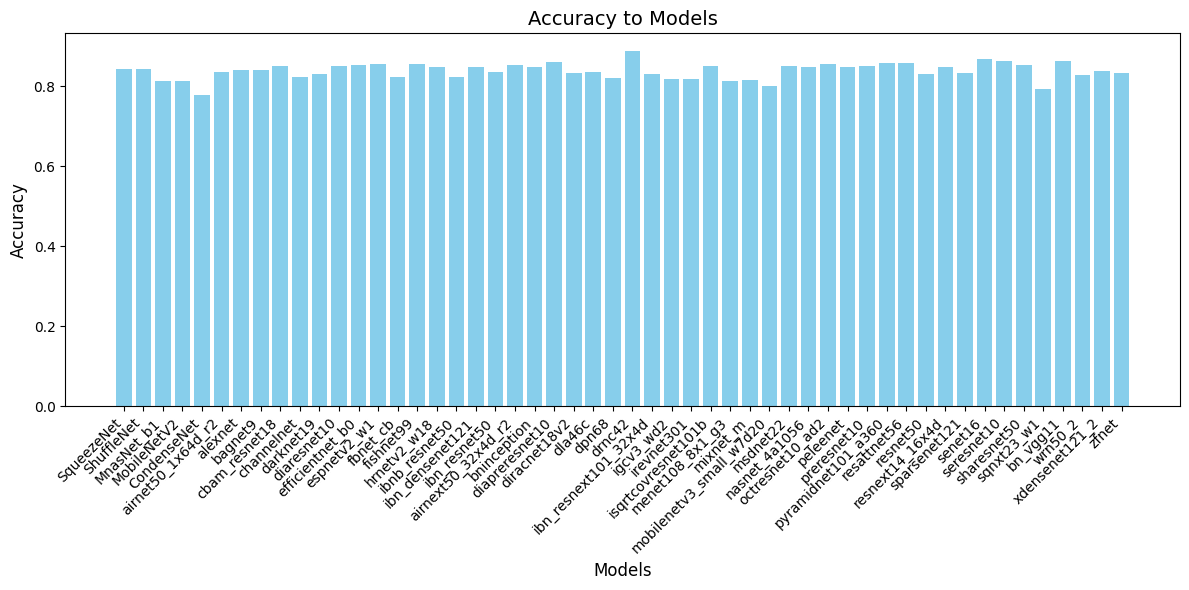

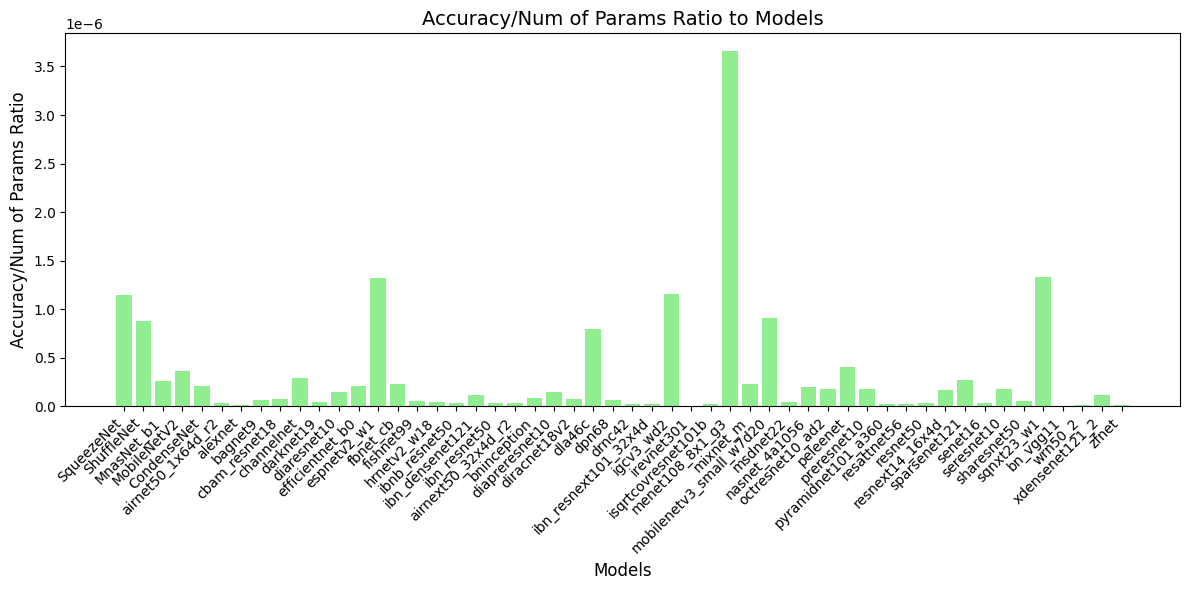

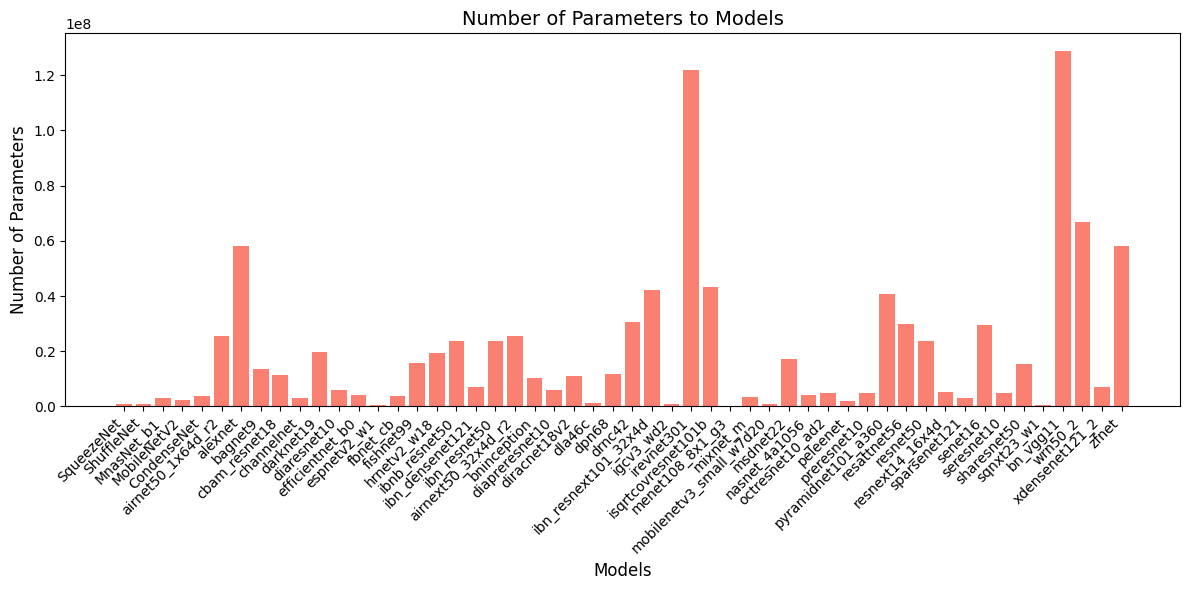

In [73]:
# Convert data appropriately - only use cpu().numpy() for tensor values
models = list(all_result.keys())
accuracies = [v['test_accuracy'].cpu().numpy() for v in all_result.values()]
num_params = [v['num_params'] for v in all_result.values()]  # Already integers, no conversion needed
accuracy_to_param_ratio = [a / n for a, n in zip(accuracies, num_params)]

# Plot 1: Accuracy to models
plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy to Models', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot 2: Accuracy/num of params ratio to models
plt.figure(figsize=(12, 6))
plt.bar(models, accuracy_to_param_ratio, color='lightgreen')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy/Num of Params Ratio', fontsize=12)
plt.title('Accuracy/Num of Params Ratio to Models', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot 3: Number of parameters to models
plt.figure(figsize=(12, 6))
plt.bar(models, num_params, color='salmon')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Number of Parameters', fontsize=12)
plt.title('Number of Parameters to Models', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

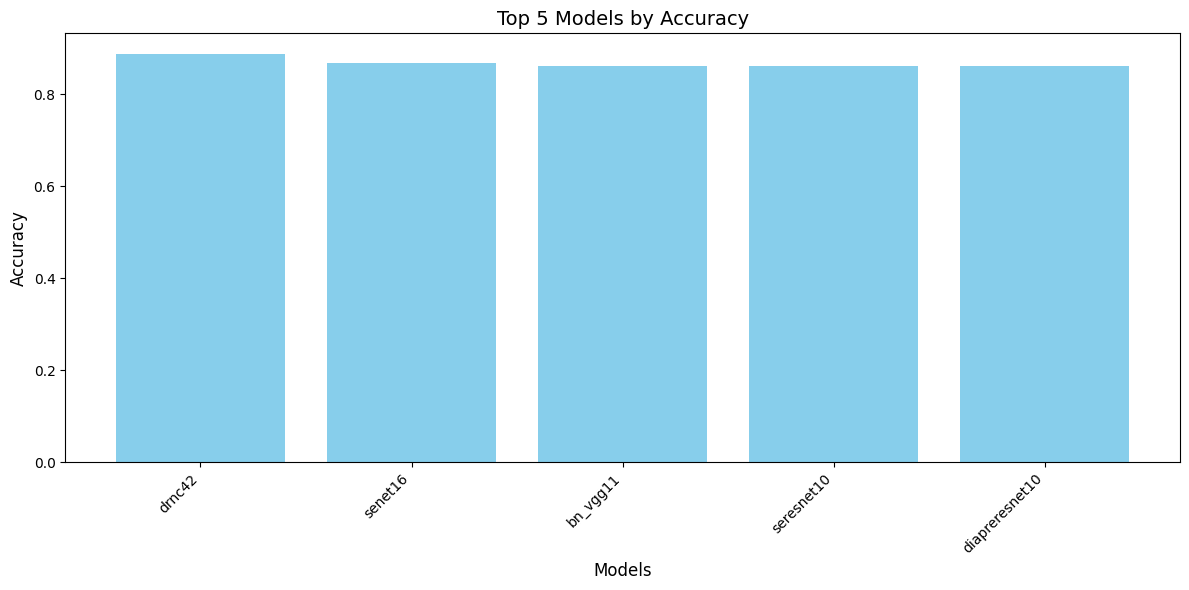

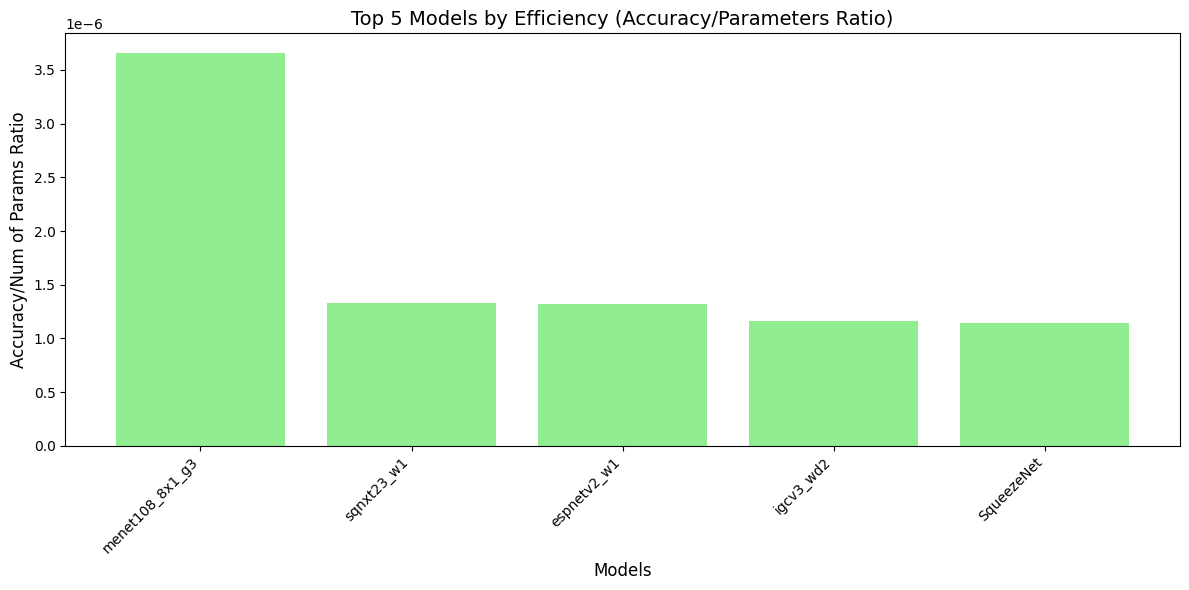

In [74]:
# Get data sorted by accuracy and accuracy/param ratio
models = list(all_result.keys())
accuracies = [v['test_accuracy'].cpu().numpy() for v in all_result.values()]
num_params = [v['num_params'] for v in all_result.values()]
accuracy_to_param_ratio = [a / n for a, n in zip(accuracies, num_params)]

# Get top 5 by accuracy
accuracy_pairs = list(zip(models, accuracies, num_params))
top_5_accuracy = sorted(accuracy_pairs, key=lambda x: x[1], reverse=True)[:5]
top_5_acc_models, top_5_acc_values, top_5_acc_params = zip(*top_5_accuracy)

# Get top 5 by efficiency (accuracy/params ratio)
efficiency_pairs = list(zip(models, accuracy_to_param_ratio, accuracies, num_params))
top_5_efficiency = sorted(efficiency_pairs, key=lambda x: x[1], reverse=True)[:5]
top_5_eff_models, top_5_eff_ratios, top_5_eff_acc, top_5_eff_params = zip(*top_5_efficiency)

# Plot 1: Top 5 by Accuracy
plt.figure(figsize=(12, 6))
plt.bar(top_5_acc_models, top_5_acc_values, color='skyblue')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Top 5 Models by Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot 2: Top 5 by Accuracy/Parameters Ratio
plt.figure(figsize=(12, 6))
plt.bar(top_5_eff_models, top_5_eff_ratios, color='lightgreen')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy/Num of Params Ratio', fontsize=12)
plt.title('Top 5 Models by Efficiency (Accuracy/Parameters Ratio)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [75]:
# Original 3 plots
# Plot 1: All models - Accuracy
plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy to Models', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('all_models_accuracy.png')
plt.close()

# Plot 2: All models - Efficiency
plt.figure(figsize=(12, 6))
plt.bar(models, accuracy_to_param_ratio, color='lightgreen')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy/Num of Params Ratio', fontsize=12)
plt.title('Accuracy/Num of Params Ratio to Models', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('all_models_efficiency.png')
plt.close()

# Plot 3: All models - Parameters
plt.figure(figsize=(12, 6))
plt.bar(models, num_params, color='salmon')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Number of Parameters', fontsize=12)
plt.title('Number of Parameters to Models', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('all_models_parameters.png')
plt.close()

# Get data for top 5 plots
accuracy_pairs = list(zip(models, accuracies, num_params))
top_5_accuracy = sorted(accuracy_pairs, key=lambda x: x[1], reverse=True)[:5]
top_5_acc_models, top_5_acc_values, top_5_acc_params = zip(*top_5_accuracy)

efficiency_pairs = list(zip(models, accuracy_to_param_ratio, accuracies, num_params))
top_5_efficiency = sorted(efficiency_pairs, key=lambda x: x[1], reverse=True)[:5]
top_5_eff_models, top_5_eff_ratios, top_5_eff_acc, top_5_eff_params = zip(*top_5_efficiency)

# Plot 4: Top 5 by Accuracy
plt.figure(figsize=(12, 6))
plt.bar(top_5_acc_models, top_5_acc_values, color='skyblue')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Top 5 Models by Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top5_accuracy.png')
plt.close()

# Plot 5: Top 5 by Efficiency
plt.figure(figsize=(12, 6))
plt.bar(top_5_eff_models, top_5_eff_ratios, color='lightgreen')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy/Num of Params Ratio', fontsize=12)
plt.title('Top 5 Models by Efficiency (Accuracy/Parameters Ratio)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top5_efficiency.png')
plt.close()

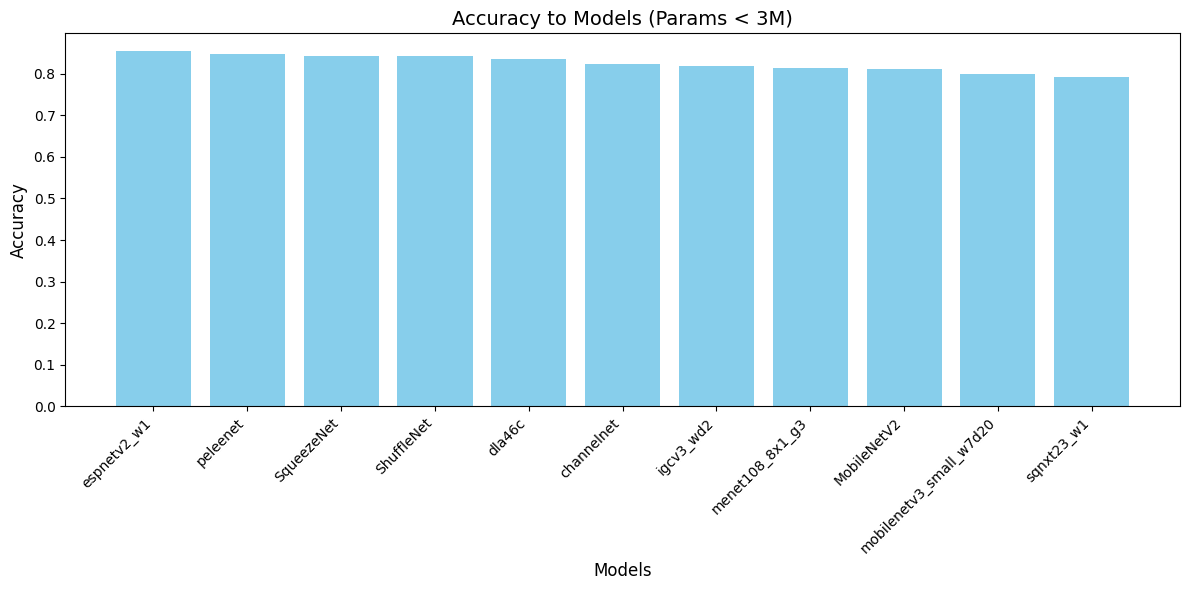

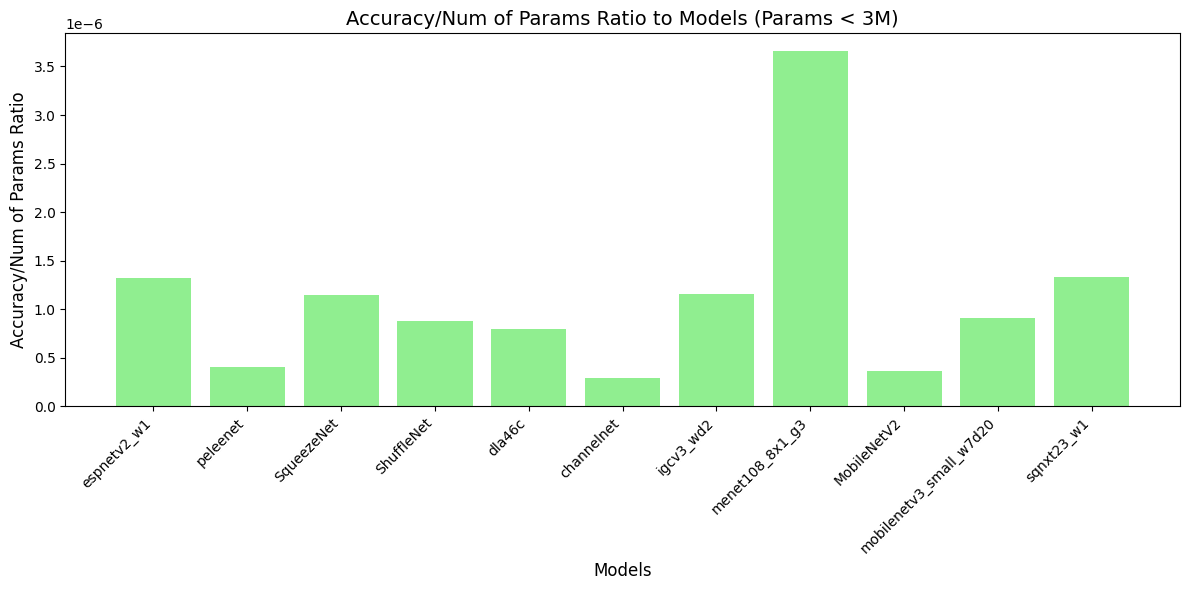

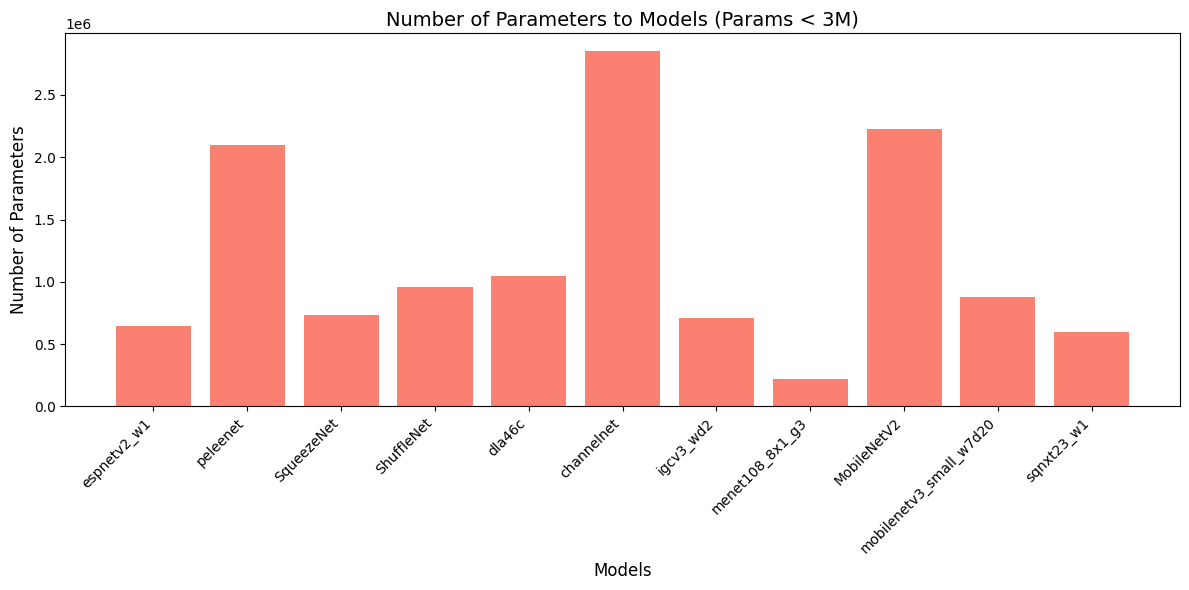

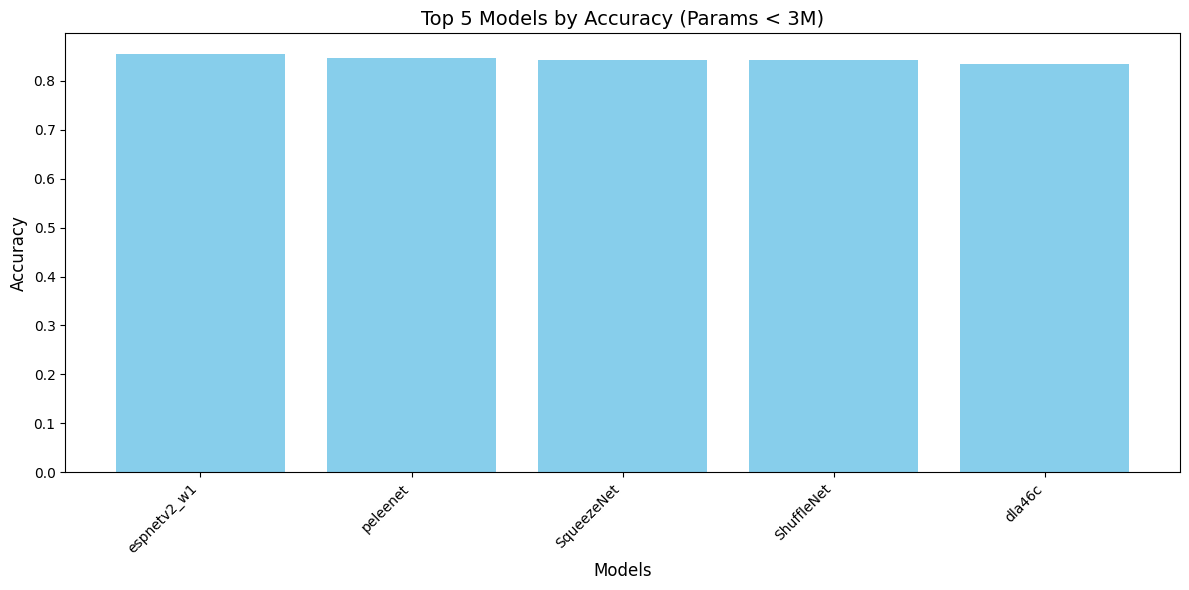

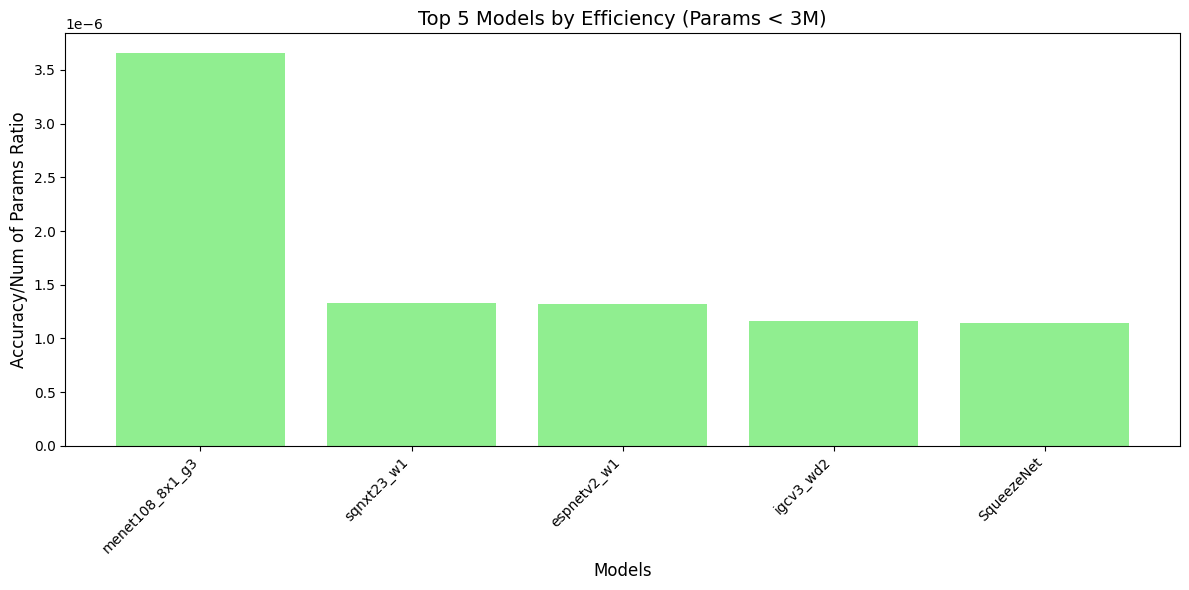

In [79]:
# Filter models with params < 3M
filtered_models = [(m, a, n) for m, a, n in zip(models, accuracies, num_params) if n < 3_000_000]
filtered_models.sort(key=lambda x: x[1], reverse=True)  # Sort by accuracy for consistent plotting
filtered_model_names, filtered_accuracies, filtered_params = zip(*filtered_models) if filtered_models else ([], [], [])
filtered_accuracy_to_param_ratio = [a / n for a, n in zip(filtered_accuracies, filtered_params)]

# Plot 1: Accuracy to Models (Params < 3M)
plt.figure(figsize=(12, 6))
plt.bar(filtered_model_names, filtered_accuracies, color='skyblue')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy to Models (Params < 3M)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('accuracy_to_models_under_3m_params.png')
plt.show()

# Plot 2: Accuracy/num of params ratio to Models (Params < 3M)
plt.figure(figsize=(12, 6))
plt.bar(filtered_model_names, filtered_accuracy_to_param_ratio, color='lightgreen')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy/Num of Params Ratio', fontsize=12)
plt.title('Accuracy/Num of Params Ratio to Models (Params < 3M)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('accuracy_param_ratio_to_models_under_3m_params.png')
plt.show()

# Plot 3: Number of Parameters to Models (Params < 3M)
plt.figure(figsize=(12, 6))
plt.bar(filtered_model_names, filtered_params, color='salmon')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Number of Parameters', fontsize=12)
plt.title('Number of Parameters to Models (Params < 3M)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('num_params_to_models_under_3m_params.png')
plt.show()

# Plot 4: Top 5 by Accuracy (Params < 3M)
top_5_accuracy = sorted(filtered_models, key=lambda x: x[1], reverse=True)[:5]
top_5_acc_models, top_5_acc_values, top_5_acc_params = zip(*top_5_accuracy) if top_5_accuracy else ([], [], [])
plt.figure(figsize=(12, 6))
plt.bar(top_5_acc_models, top_5_acc_values, color='skyblue')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Top 5 Models by Accuracy (Params < 3M)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_5_accuracy_under_3m_params.png')
plt.show()

# Plot 5: Top 5 by Accuracy/Parameters Ratio (Params < 3M)
efficiency_pairs = [(m, a / n, a, n) for m, a, n in zip(filtered_model_names, filtered_accuracies, filtered_params)]
top_5_efficiency = sorted(efficiency_pairs, key=lambda x: x[1], reverse=True)[:5]
top_5_eff_models, top_5_eff_ratios, top_5_eff_acc, top_5_eff_params = zip(*top_5_efficiency) if top_5_efficiency else ([], [], [], [])
plt.figure(figsize=(12, 6))
plt.bar(top_5_eff_models, top_5_eff_ratios, color='lightgreen')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy/Num of Params Ratio', fontsize=12)
plt.title('Top 5 Models by Efficiency (Params < 3M)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('top_5_efficiency_under_3m_params.png')
plt.show()
